# Mask R-CNN - Train on Shapes Dataset


This notebook shows how to train Mask R-CNN on your own dataset. To keep things simple we use a synthetic dataset of shapes (squares, triangles, and circles) which enables fast training. You'd still need a GPU, though, because the network backbone is a Resnet101, which would be too slow to train on a CPU. On a GPU, you can start to get okay-ish results in a few minutes, and good results in less than an hour.

The code of the *Shapes* dataset is included below. It generates images on the fly, so it doesn't require downloading any data. And it can generate images of any size, so we pick a small image size to train faster. 

In [1]:
import os
import sys
import piexif

import random
import math
import re
import time
import numpy as np
import cv2
import matplotlib
import matplotlib.pyplot as plt
import skimage
# Root directory of the project
ROOT_DIR = os.path.abspath("../../")

# Import Mask RCNN
sys.path.append(ROOT_DIR)  # To find local version of the library
from mrcnn.config import Config
from mrcnn import utils
import mrcnn.model as modellib
from mrcnn import visualize
from mrcnn.model import log
import pycocotools
%matplotlib inline 
import json
from pycocotools.coco import COCO
from pycocotools.cocoeval import COCOeval
from pycocotools import mask as maskUtils
# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, "logs")

# Local path to trained weights file
COCO_MODEL_PATH = os.path.join(ROOT_DIR, "mask_rcnn_coco.h5")
# Download COCO trained weights from Releases if needed
if not os.path.exists(COCO_MODEL_PATH):
    utils.download_trained_weights(COCO_MODEL_PATH)

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:523: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:524: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:525: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/hom

In [2]:
from tensorflow.python.client import device_lib

def get_available_gpus():
    local_device_protos = device_lib.list_local_devices()
    return [x.name for x in local_device_protos if x.device_type == 'GPU']

get_available_gpus()

['/device:GPU:0']

In [3]:
from tensorflow.python.client import device_lib

device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 12457712167449454293, name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 11137299252
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 4954202912887695850
 physical_device_desc: "device: 0, name: TITAN Xp, pci bus id: 0000:01:00.0, compute capability: 6.1"]

In [4]:
#import keras
#import tensorflow as tf
#config = tf.ConfigProto( device_count = {'GPU': 1 , 'CPU': 56} ) 
#sess = tf.Session(config=config) 
#keras.backend.set_session(sess)


## Configurations

In [5]:
class ShapesConfig(Config):
    """Configuration for training on the toy shapes dataset.
    Derives from the base Config class and overrides values specific
    to the toy shapes dataset.
    """
    # Give the configuration a recognizable name
    NAME = "shapes"

    # Train on 1 GPU and 1 images per GPU. We can put multiple images on each
    # GPU because the images are small. Batch size is 1 (GPUs * images/GPU).
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1
    STEPS_PER_EPOCH = 100
    # Number of classes (including background)
    NUM_CLASSES = 1 + 1  # background + 1 shapes

    # Use small images for faster training. Set the limits of the small side
    # the large side, and that determines the image shape.
    #IMAGE_MIN_DIM = 128
    #IMAGE_MAX_DIM = 128

    # Use smaller anchors because our image and objects are small
    #RPN_ANCHOR_SCALES = (8, 16, 32, 64, 128, 256, 512, 768)  # anchor side in pixels

    # Reduce training ROIs per image because the images are small and have
    # few objects. Aim to allow ROI sampling to pick 33% positive ROIs.
    #TRAIN_ROIS_PER_IMAGE = 32

    # Use a small epoch since the data is simple
    #STEPS_PER_EPOCH = 100

    # use small validation steps since the epoch is small
    VALIDATION_STEPS = 10
    
config = ShapesConfig()
config.display()


Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 1
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  1024
IMAGE_META_SIZE                14
IMAGE_MIN_DIM                  800
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [1024 1024    3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE         

## Notebook Preferences

In [6]:
def get_ax(rows=1, cols=1, size=8):
    """Return a Matplotlib Axes array to be used in
    all visualizations in the notebook. Provide a
    central point to control graph sizes.
    
    Change the default size attribute to control the size
    of rendered images
    """
    _, ax = plt.subplots(rows, cols, figsize=(size*cols, size*rows))
    return ax


## Dataset

Create a synthetic dataset

Extend the Dataset class and add a method to load the shapes dataset, `load_shapes()`, and override the following methods:

* load_image()
* load_mask()
* image_reference()

In [7]:
def seperate_x_and_y_points(poly):   
    poly = ''.join(poly);
    a = poly.split(',')            
    x_points = a[0::2]            
    y_points = a[1::2]
    x_points = list(map(int, x_points))
    y_points = list(map(int, y_points))
    return x_points, y_points

class BalloonDataset(utils.Dataset):
    whichDataSetToLoad = ''
        
    def load_balloon(self, dataset_dir, subset):
        """Load a subset of the Balloon dataset.
        dataset_dir: Root directory of the dataset.
        subset: Subset to load: train or val
        """
        # Add classes. We have only one class to add.
        self.add_class("balloon", 1, "balloon")

        # Train or validation dataset?
       # assert subset in ["train", "val"]
        dataset_dir = os.path.join(dataset_dir, subset)

        # Load annotations
        # VGG Image Annotator (up to version 1.6) saves each image in the form:
        # { 'filename': '28503151_5b5b7ec140_b.jpg',
        #   'regions': {
        #       '0': {
        #           'region_attributes': {},
        #           'shape_attributes': {
        #               'all_points_x': [...],
        #               'all_points_y': [...],
        #               'name': 'polygon'}},
        #       ... more regions ...
        #   },
        #   'size': 100202
        # }
        # We mostly care about the x and y coordinates of each region
        # Note: In VIA 2.0, regions was changed from a dict to a list.
        annotations = json.load(open(os.path.join(dataset_dir, "instances.json")))        
       # print(dataset_dir)
        print()
        
        for  i in range(len(annotations['images'])):
            polygon = list(dict())
            polygon = [{'name': 'polygon', 'all_points_x': [], 'all_points_y': []}]
            polygon[0]['name'] ='text'
            
            #print(polygon)
            file_name = annotations['images'][i]['file_name']
            #print(file_name)
            width = int(annotations['images'][i]['width'])
            height = int(annotations['images'][i]['height'])
           # print(file_name, width, height)
        
            if(self.whichDataSetToLoad != 'ground_truth'):            
                image_path = os.path.join(dataset_dir, file_name)+ '.jpg'  
                #print(image_path)
            if(self.whichDataSetToLoad == 'ground_truth'):   
                image_path = os.path.join(dataset_dir, file_name)+ '.png'  
            #print(image_path)
            segmentation = annotations['annotations'][i]['segmentation']
            polygons = []
            for poly in segmentation:   
                x_points, y_points = seperate_x_and_y_points(poly)                          
                polygon = {'name': 'polygon', 'all_points_x': [], 'all_points_y': []}
                polygon['name'] ='text'
                polygon['all_points_x'] = x_points
                polygon['all_points_y'] = y_points         
                polygons.append(polygon)
            #print(polygons)
            self.add_image(
                    "balloon",
                    image_id=file_name,  # use file name as a unique image id
                    path=image_path,
                    width=width, height=height,
                    polygons=polygons)
    def load_mask(self, image_id):
        """Generate instance masks for an image.
       Returns:
        masks: A bool array of shape [height, width, instance count] with
            one mask per instance.
        class_ids: a 1D array of class IDs of the instance masks.
        """
        # If not a balloon dataset image, delegate to parent class.
        image_info = self.image_info[image_id]
        if image_info["source"] != "balloon":
            return super(self.__class__, self).load_mask(image_id)

        # Convert polygons to a bitmap mask of shape
        # [height, width, instance_count]
        info = self.image_info[image_id]
        mask = np.zeros([info["height"], info["width"], len(info["polygons"])],
                        dtype=np.uint8)
        for i, p in enumerate(info["polygons"]):
            # Get indexes of pixels inside the polygon and set them to 1
            rr, cc = skimage.draw.polygon(p['all_points_y'], p['all_points_x'])
            mask[rr, cc, i] = 1

        # Return mask, and array of class IDs of each instance. Since we have
        # one class ID only, we return an array of 1s
        return mask.astype(np.bool), np.ones([mask.shape[-1]], dtype=np.int32)

    def image_reference(self, image_id):
        """Return the path of the image."""
        info = self.image_info[image_id]
        if info["source"] == "balloon":
            return info["path"]
        else:
            super(self.__class__, self).image_reference(image_id)
        


In [8]:
# Training dataset
dataset_train = BalloonDataset()
dataset_train.whichDataSetToLoad = 'training'
dataset_train.load_balloon('/home/harsh/Mask_RCNN/datasets/documents/images/', "train")
dataset_train.prepare()

# Validation dataset
dataset_val =  BalloonDataset()
dataset_train.whichDataSetToLoad = 'training'
dataset_val.load_balloon('/home/harsh/Mask_RCNN/datasets/documents/images/', "val")
dataset_val.prepare()


# Test dataset
dataset_test =  BalloonDataset()
dataset_train.whichDataSetToLoad = 'training'
dataset_test.load_balloon('/home/harsh/Mask_RCNN/datasets/documents/images/', "test")
dataset_test.prepare()



In [9]:

# Training dataset
dataset_train_gt = BalloonDataset()
dataset_train_gt.whichDataSetToLoad = 'ground_truth'
dataset_train_gt.load_balloon('/home/harsh/Mask_RCNN/datasets/documents/ground_truth/', "train")
dataset_train_gt.prepare()

# Validation dataset
dataset_val_gt =  BalloonDataset()
dataset_train_gt.whichDataSetToLoad = 'ground_truth'
dataset_val_gt.load_balloon('/home/harsh/Mask_RCNN/datasets/documents/ground_truth/', "val")
dataset_val_gt.prepare()


# Test dataset
dataset_test_gt =  BalloonDataset()
dataset_train_gt.whichDataSetToLoad = 'ground_truth'
dataset_test_gt.load_balloon('/home/harsh/Mask_RCNN/datasets/documents/ground_truth/', "test")
dataset_test_gt.prepare()



##  Loading ground truth mask to show that masks are loading correctly 

In [10]:
'''
# Loading ground truth mask to show that masks are loading correctly
# Load and display random samples
print(dataset_train_gt.num_images)
image_ids = np.random.choice(dataset_train_gt.image_ids, 10)
print(image_ids)
for image_id in image_ids:
    image = dataset_train_gt.load_image(image_id)
    mask, class_ids = dataset_train_gt.load_mask(image_id)
    print(class_ids)
    visualize.display_top_masks(image, mask, class_ids, dataset_train_gt.class_names)
    '''

'\n# Loading ground truth mask to show that masks are loading correctly\n# Load and display random samples\nprint(dataset_train_gt.num_images)\nimage_ids = np.random.choice(dataset_train_gt.image_ids, 10)\nprint(image_ids)\nfor image_id in image_ids:\n    image = dataset_train_gt.load_image(image_id)\n    mask, class_ids = dataset_train_gt.load_mask(image_id)\n    print(class_ids)\n    visualize.display_top_masks(image, mask, class_ids, dataset_train_gt.class_names)\n    '

##  Loading Training Images mask to show that masks are loading correctly 

In [11]:
'''
# Load and display random samples
print(dataset_train.num_images)
image_ids = np.random.choice(dataset_train.image_ids, 10)
print(image_ids)
for image_id in image_ids:
    image = dataset_train.load_image(image_id)
    mask, class_ids = dataset_train.load_mask(image_id)
    print(class_ids)
    visualize.display_top_masks(image, mask, class_ids, dataset_train.class_names)
    '''

'\n# Load and display random samples\nprint(dataset_train.num_images)\nimage_ids = np.random.choice(dataset_train.image_ids, 10)\nprint(image_ids)\nfor image_id in image_ids:\n    image = dataset_train.load_image(image_id)\n    mask, class_ids = dataset_train.load_mask(image_id)\n    print(class_ids)\n    visualize.display_top_masks(image, mask, class_ids, dataset_train.class_names)\n    '

In [12]:
# Applying Augmentation

import numpy as np
import imgaug as ia
import imgaug.augmenters as iaa


ia.seed(1)


seq = iaa.Sequential([    
    iaa.Crop(percent=(0, 0.1)), # random crops
    # Small gaussian blur with random sigma between 0 and 0.5.
    # But we only blur about 50% of all images.
    iaa.Sometimes(0.5,
        iaa.GaussianBlur(sigma=(0, 0.5))
    ),
    # Strengthen or weaken the contrast in each image.
    iaa.ContrastNormalization((0.75, 1.5)),
    # Add gaussian noise.
    # For 50% of all images, we sample the noise once per pixel.
    # For the other 50% of all images, we sample the noise per pixel AND
    # channel. This can change the color (not only brightness) of the
    # pixels.
    iaa.AdditiveGaussianNoise(loc=0, scale=(0.0, 0.05*255), per_channel=0.5),
    # Make some images brighter and some darker.
    # In 20% of all cases, we sample the multiplier once per channel,
    # which can end up changing the color of the images.
    iaa.OneOf([iaa.Affine(rotate=10),
                   iaa.Affine(rotate=350),
                   iaa.Affine(rotate=20)])
], random_order=True) # apply augmenters in random order

## Create Model

In [13]:
# Create model in training mode
model = modellib.MaskRCNN(mode="training", config=config,
                          model_dir=MODEL_DIR)

In [14]:
# Which weights to start with?
init_with = "coco"  # imagenet, coco, or last

if init_with == "imagenet":
    model.load_weights(model.get_imagenet_weights(), by_name=True)
elif init_with == "coco":
    # Load weights trained on MS COCO, but skip layers that
    # are different due to the different number of classes
    # See README for instructions to download the COCO weights
    model.load_weights(COCO_MODEL_PATH, by_name=True,
                       exclude=["mrcnn_class_logits", "mrcnn_bbox_fc", 
                                "mrcnn_bbox", "mrcnn_mask"])
elif init_with == "last":
    # Load the last model you trained and continue training
    model.load_weights(model.find_last(), by_name=True)

## Training

Train in two stages:
1. Only the heads. Here we're freezing all the backbone layers and training only the randomly initialized layers (i.e. the ones that we didn't use pre-trained weights from MS COCO). To train only the head layers, pass `layers='heads'` to the `train()` function.

2. Fine-tune all layers. For this simple example it's not necessary, but we're including it to show the process. Simply pass `layers="all` to train all layers.


Starting at epoch 0. LR=0.001

Checkpoint Path: /home/harsh/Mask_RCNN/logs/shapes20190825T1933/mask_rcnn_shapes_{epoch:04d}.h5
Selecting layers to train
fpn_c5p5               (Conv2D)
fpn_c4p4               (Conv2D)
fpn_c3p3               (Conv2D)
fpn_c2p2               (Conv2D)
fpn_p5                 (Conv2D)
fpn_p2                 (Conv2D)
fpn_p3                 (Conv2D)
fpn_p4                 (Conv2D)
In model:  rpn_model
    rpn_conv_shared        (Conv2D)
    rpn_class_raw          (Conv2D)
    rpn_bbox_pred          (Conv2D)
mrcnn_mask_conv1       (TimeDistributed)
mrcnn_mask_bn1         (TimeDistributed)
mrcnn_mask_conv2       (TimeDistributed)
mrcnn_mask_bn2         (TimeDistributed)
mrcnn_class_conv1      (TimeDistributed)
mrcnn_class_bn1        (TimeDistributed)
mrcnn_mask_conv3       (TimeDistributed)
mrcnn_mask_bn3         (TimeDistributed)
mrcnn_class_conv2      (TimeDistributed)
mrcnn_class_bn2        (TimeDistributed)
mrcnn_mask_conv4       (TimeDistributed)
mrcnn_mask

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:108: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/keras/engine/training_generator.py:47: UserWarning: Using a generator with `use_multiprocessing=True` and multiple workers may duplicate your data. Please consider using the`keras.utils.Sequence class.
  UserWarning('Using a generator with `use_multiprocessing=True`'


Epoch 1/30
 66/100 [==================>...........] - ETA: 34s - loss: 3.2524 - rpn_class_loss: 0.4315 - rpn_bbox_loss: 1.5168 - mrcnn_class_loss: 0.0835 - mrcnn_bbox_loss: 0.7426 - mrcnn_mask_loss: 0.4781

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6

 67/100 [===================>..........] - ETA: 33s - loss: 3.2446 - rpn_class_loss: 0.4359 - rpn_bbox_loss: 1.5097 - mrcnn_class_loss: 0.0827 - mrcnn_bbox_loss: 0.7409 - mrcnn_mask_loss: 0.4753

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6

 68/100 [===================>..........] - ETA: 32s - loss: 3.2346 - rpn_class_loss: 0.4395 - rpn_bbox_loss: 1.5015 - mrcnn_class_loss: 0.0820 - mrcnn_bbox_loss: 0.7390 - mrcnn_mask_loss: 0.4726

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


100/100 [==============================] - 96s 957ms/step - loss: 2.8806 - rpn_class_loss: 0.4331 - rpn_bbox_loss: 1.2436 - mrcnn_class_loss: 0.0630 - mrcnn_bbox_loss: 0.7198 - mrcnn_mask_loss: 0.4212 - val_loss: 3.2194 - val_rpn_class_loss: 0.2830 - val_rpn_bbox_loss: 0.8861 - val_mrcnn_class_loss: 0.0429 - val_mrcnn_bbox_loss: 0.8567 - val_mrcnn_mask_loss: 1.1506
Epoch 2/30
100/100 [==============================] - 53s 534ms/step - loss: 1.7677 - rpn_class_loss: 0.1943 - rpn_bbox_loss: 0.5280 - mrcnn_class_loss: 0.0640 - mrcnn_bbox_loss: 0.4870 - mrcnn_mask_loss: 0.4944 - val_loss: 3.6159 - val_rpn_class_loss: 0.9728 - val_rpn_bbox_loss: 2.6431 - val_mrcnn_class_loss: 4.3749e-05 - val_mrcnn_bbox_loss: 0.0000e+00 - val_mrcnn_mask_loss: 0.0000e+00
Epoch 3/30
  6/100 [>.............................] - ETA: 48s - loss: 1.4887 - rpn_class_loss: 0.1025 - rpn_bbox_loss: 0.4984 - mrcnn_class_loss: 0.0674 - mrcnn_bbox_loss: 0.3828 - mrcnn_mask_loss: 0.4377

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


  8/100 [=>............................] - ETA: 47s - loss: 1.8841 - rpn_class_loss: 0.1659 - rpn_bbox_loss: 0.6341 - mrcnn_class_loss: 0.0531 - mrcnn_bbox_loss: 0.5010 - mrcnn_mask_loss: 0.5301

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 10/100 [==>...........................] - ETA: 46s - loss: 1.9249 - rpn_class_loss: 0.1755 - rpn_bbox_loss: 0.6538 - mrcnn_class_loss: 0.0546 - mrcnn_bbox_loss: 0.5029 - mrcnn_mask_loss: 0.5381

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 12/100 [==>...........................] - ETA: 45s - loss: 1.9962 - rpn_class_loss: 0.1982 - rpn_bbox_loss: 0.7017 - mrcnn_class_loss: 0.0474 - mrcnn_bbox_loss: 0.4970 - mrcnn_mask_loss: 0.5520

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 17/100 [====>.........................] - ETA: 42s - loss: 1.9481 - rpn_class_loss: 0.1936 - rpn_bbox_loss: 0.6567 - mrcnn_class_loss: 0.0755 - mrcnn_bbox_loss: 0.5097 - mrcnn_mask_loss: 0.5126

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 19/100 [====>.........................] - ETA: 40s - loss: 1.9383 - rpn_class_loss: 0.1955 - rpn_bbox_loss: 0.6501 - mrcnn_class_loss: 0.0779 - mrcnn_bbox_loss: 0.5146 - mrcnn_mask_loss: 0.5002

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 21/100 [=====>........................] - ETA: 39s - loss: 1.9207 - rpn_class_loss: 0.1961 - rpn_bbox_loss: 0.6427 - mrcnn_class_loss: 0.0801 - mrcnn_bbox_loss: 0.5134 - mrcnn_mask_loss: 0.4884

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 24/100 [======>.......................] - ETA: 38s - loss: 1.9756 - rpn_class_loss: 0.1993 - rpn_bbox_loss: 0.6527 - mrcnn_class_loss: 0.0812 - mrcnn_bbox_loss: 0.5352 - mrcnn_mask_loss: 0.5073

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


100/100 [==============================] - 54s 537ms/step - loss: 1.7179 - rpn_class_loss: 0.1441 - rpn_bbox_loss: 0.5319 - mrcnn_class_loss: 0.0700 - mrcnn_bbox_loss: 0.5110 - mrcnn_mask_loss: 0.4610 - val_loss: 3.0320 - val_rpn_class_loss: 0.2570 - val_rpn_bbox_loss: 2.7747 - val_mrcnn_class_loss: 3.2734e-04 - val_mrcnn_bbox_loss: 0.0000e+00 - val_mrcnn_mask_loss: 0.0000e+00
Epoch 4/30
100/100 [==============================] - 56s 556ms/step - loss: 1.3980 - rpn_class_loss: 0.1029 - rpn_bbox_loss: 0.5372 - mrcnn_class_loss: 0.0823 - mrcnn_bbox_loss: 0.3563 - mrcnn_mask_loss: 0.3193 - val_loss: 4.1433 - val_rpn_class_loss: 0.7329 - val_rpn_bbox_loss: 3.4104 - val_mrcnn_class_loss: 9.5367e-06 - val_mrcnn_bbox_loss: 0.0000e+00 - val_mrcnn_mask_loss: 0.0000e+00
Epoch 5/30
100/100 [==============================] - 54s 540ms/step - loss: 1.5237 - rpn_class_loss: 0.1582 - rpn_bbox_loss: 0.5118 - mrcnn_class_loss: 0.1053 - mrcnn_bbox_loss: 0.4139 - mrcnn_mask_loss: 0.3345 - val_loss: 4.689

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 83/100 [=======================>......] - ETA: 8s - loss: 1.3604 - rpn_class_loss: 0.1415 - rpn_bbox_loss: 0.4530 - mrcnn_class_loss: 0.0960 - mrcnn_bbox_loss: 0.3280 - mrcnn_mask_loss: 0.3419

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 86/100 [========================>.....] - ETA: 7s - loss: 1.3490 - rpn_class_loss: 0.1400 - rpn_bbox_loss: 0.4482 - mrcnn_class_loss: 0.0936 - mrcnn_bbox_loss: 0.3286 - mrcnn_mask_loss: 0.3386

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 91/100 [==========================>...] - ETA: 4s - loss: 1.3484 - rpn_class_loss: 0.1381 - rpn_bbox_loss: 0.4559 - mrcnn_class_loss: 0.0916 - mrcnn_bbox_loss: 0.3309 - mrcnn_mask_loss: 0.3318

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 95/100 [===========================>..] - ETA: 2s - loss: 1.3314 - rpn_class_loss: 0.1356 - rpn_bbox_loss: 0.4516 - mrcnn_class_loss: 0.0894 - mrcnn_bbox_loss: 0.3286 - mrcnn_mask_loss: 0.3263

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


100/100 [==============================] - 55s 550ms/step - loss: 1.3317 - rpn_class_loss: 0.1333 - rpn_bbox_loss: 0.4538 - mrcnn_class_loss: 0.0892 - mrcnn_bbox_loss: 0.3300 - mrcnn_mask_loss: 0.3255 - val_loss: 3.4508 - val_rpn_class_loss: 0.4511 - val_rpn_bbox_loss: 2.4233 - val_mrcnn_class_loss: 0.0035 - val_mrcnn_bbox_loss: 0.3816 - val_mrcnn_mask_loss: 0.1914
Epoch 8/30
  2/100 [..............................] - ETA: 50s - loss: 1.1748 - rpn_class_loss: 0.0705 - rpn_bbox_loss: 0.5157 - mrcnn_class_loss: 0.0373 - mrcnn_bbox_loss: 0.3708 - mrcnn_mask_loss: 0.1804

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


  8/100 [=>............................] - ETA: 46s - loss: 1.2538 - rpn_class_loss: 0.0690 - rpn_bbox_loss: 0.4656 - mrcnn_class_loss: 0.0701 - mrcnn_bbox_loss: 0.3522 - mrcnn_mask_loss: 0.2969

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 11/100 [==>...........................] - ETA: 45s - loss: 1.2189 - rpn_class_loss: 0.0709 - rpn_bbox_loss: 0.4477 - mrcnn_class_loss: 0.0720 - mrcnn_bbox_loss: 0.3319 - mrcnn_mask_loss: 0.2964

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 69/100 [===================>..........] - ETA: 16s - loss: 1.1302 - rpn_class_loss: 0.0711 - rpn_bbox_loss: 0.3850 - mrcnn_class_loss: 0.0797 - mrcnn_bbox_loss: 0.2900 - mrcnn_mask_loss: 0.3044

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 74/100 [=====================>........] - ETA: 13s - loss: 1.1169 - rpn_class_loss: 0.0698 - rpn_bbox_loss: 0.3796 - mrcnn_class_loss: 0.0777 - mrcnn_bbox_loss: 0.2858 - mrcnn_mask_loss: 0.3040

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 77/100 [======================>.......] - ETA: 12s - loss: 1.1105 - rpn_class_loss: 0.0689 - rpn_bbox_loss: 0.3795 - mrcnn_class_loss: 0.0764 - mrcnn_bbox_loss: 0.2836 - mrcnn_mask_loss: 0.3020

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 83/100 [=======================>......] - ETA: 9s - loss: 1.0877 - rpn_class_loss: 0.0670 - rpn_bbox_loss: 0.3677 - mrcnn_class_loss: 0.0746 - mrcnn_bbox_loss: 0.2776 - mrcnn_mask_loss: 0.3008

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 89/100 [=========================>....] - ETA: 6s - loss: 1.0951 - rpn_class_loss: 0.0678 - rpn_bbox_loss: 0.3708 - mrcnn_class_loss: 0.0745 - mrcnn_bbox_loss: 0.2793 - mrcnn_mask_loss: 0.3026

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 94/100 [===========================>..] - ETA: 3s - loss: 1.0833 - rpn_class_loss: 0.0674 - rpn_bbox_loss: 0.3662 - mrcnn_class_loss: 0.0751 - mrcnn_bbox_loss: 0.2761 - mrcnn_mask_loss: 0.2986

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


100/100 [==============================] - 57s 575ms/step - loss: 1.0897 - rpn_class_loss: 0.0668 - rpn_bbox_loss: 0.3690 - mrcnn_class_loss: 0.0754 - mrcnn_bbox_loss: 0.2776 - mrcnn_mask_loss: 0.3009 - val_loss: 3.1287 - val_rpn_class_loss: 0.4779 - val_rpn_bbox_loss: 2.6508 - val_mrcnn_class_loss: 1.1921e-05 - val_mrcnn_bbox_loss: 0.0000e+00 - val_mrcnn_mask_loss: 0.0000e+00
Epoch 9/30
  1/100 [..............................] - ETA: 47s - loss: 1.1685 - rpn_class_loss: 0.0973 - rpn_bbox_loss: 0.3134 - mrcnn_class_loss: 0.2705 - mrcnn_bbox_loss: 0.3286 - mrcnn_mask_loss: 0.1587

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


  5/100 [>.............................] - ETA: 48s - loss: 1.0244 - rpn_class_loss: 0.0470 - rpn_bbox_loss: 0.4066 - mrcnn_class_loss: 0.0870 - mrcnn_bbox_loss: 0.2209 - mrcnn_mask_loss: 0.2628

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


100/100 [==============================] - 53s 535ms/step - loss: 1.2130 - rpn_class_loss: 0.0823 - rpn_bbox_loss: 0.4470 - mrcnn_class_loss: 0.1025 - mrcnn_bbox_loss: 0.2748 - mrcnn_mask_loss: 0.3064 - val_loss: 4.0584 - val_rpn_class_loss: 0.5387 - val_rpn_bbox_loss: 2.3456 - val_mrcnn_class_loss: 0.0076 - val_mrcnn_bbox_loss: 0.7332 - val_mrcnn_mask_loss: 0.4332
Epoch 10/30
100/100 [==============================] - 54s 542ms/step - loss: 1.0547 - rpn_class_loss: 0.0672 - rpn_bbox_loss: 0.3829 - mrcnn_class_loss: 0.0589 - mrcnn_bbox_loss: 0.2624 - mrcnn_mask_loss: 0.2834 - val_loss: 3.5229 - val_rpn_class_loss: 0.2633 - val_rpn_bbox_loss: 3.2596 - val_mrcnn_class_loss: 9.2744e-06 - val_mrcnn_bbox_loss: 0.0000e+00 - val_mrcnn_mask_loss: 0.0000e+00
Epoch 11/30
 36/100 [=========>....................] - ETA: 33s - loss: 1.0707 - rpn_class_loss: 0.0788 - rpn_bbox_loss: 0.3527 - mrcnn_class_loss: 0.0758 - mrcnn_bbox_loss: 0.2753 - mrcnn_mask_loss: 0.2880

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 46/100 [============>.................] - ETA: 27s - loss: 1.0316 - rpn_class_loss: 0.0738 - rpn_bbox_loss: 0.3402 - mrcnn_class_loss: 0.0769 - mrcnn_bbox_loss: 0.2643 - mrcnn_mask_loss: 0.2764

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 52/100 [==============>...............] - ETA: 24s - loss: 1.0216 - rpn_class_loss: 0.0713 - rpn_bbox_loss: 0.3366 - mrcnn_class_loss: 0.0780 - mrcnn_bbox_loss: 0.2626 - mrcnn_mask_loss: 0.2731

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 55/100 [===============>..............] - ETA: 23s - loss: 1.0275 - rpn_class_loss: 0.0712 - rpn_bbox_loss: 0.3368 - mrcnn_class_loss: 0.0803 - mrcnn_bbox_loss: 0.2637 - mrcnn_mask_loss: 0.2755

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 68/100 [===================>..........] - ETA: 16s - loss: 1.0259 - rpn_class_loss: 0.0670 - rpn_bbox_loss: 0.3355 - mrcnn_class_loss: 0.0832 - mrcnn_bbox_loss: 0.2652 - mrcnn_mask_loss: 0.2751

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 70/100 [====================>.........] - ETA: 15s - loss: 1.0284 - rpn_class_loss: 0.0665 - rpn_bbox_loss: 0.3333 - mrcnn_class_loss: 0.0835 - mrcnn_bbox_loss: 0.2671 - mrcnn_mask_loss: 0.2779

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 76/100 [=====================>........] - ETA: 12s - loss: 1.0513 - rpn_class_loss: 0.0668 - rpn_bbox_loss: 0.3401 - mrcnn_class_loss: 0.0857 - mrcnn_bbox_loss: 0.2720 - mrcnn_mask_loss: 0.2868

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 79/100 [======================>.......] - ETA: 11s - loss: 1.0463 - rpn_class_loss: 0.0657 - rpn_bbox_loss: 0.3429 - mrcnn_class_loss: 0.0834 - mrcnn_bbox_loss: 0.2709 - mrcnn_mask_loss: 0.2834

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


100/100 [==============================] - 56s 564ms/step - loss: 1.0470 - rpn_class_loss: 0.0616 - rpn_bbox_loss: 0.3544 - mrcnn_class_loss: 0.0833 - mrcnn_bbox_loss: 0.2668 - mrcnn_mask_loss: 0.2808 - val_loss: 3.3257 - val_rpn_class_loss: 0.5295 - val_rpn_bbox_loss: 2.4832 - val_mrcnn_class_loss: 0.0114 - val_mrcnn_bbox_loss: 0.1382 - val_mrcnn_mask_loss: 0.1634
Epoch 12/30
100/100 [==============================] - 53s 534ms/step - loss: 1.2626 - rpn_class_loss: 0.0914 - rpn_bbox_loss: 0.4535 - mrcnn_class_loss: 0.1322 - mrcnn_bbox_loss: 0.3114 - mrcnn_mask_loss: 0.2741 - val_loss: 3.4859 - val_rpn_class_loss: 0.3269 - val_rpn_bbox_loss: 1.7978 - val_mrcnn_class_loss: 0.0514 - val_mrcnn_bbox_loss: 0.7433 - val_mrcnn_mask_loss: 0.5665
Epoch 13/30
100/100 [==============================] - 55s 553ms/step - loss: 0.8178 - rpn_class_loss: 0.0428 - rpn_bbox_loss: 0.2600 - mrcnn_class_loss: 0.0641 - mrcnn_bbox_loss: 0.2169 - mrcnn_mask_loss: 0.2339 - val_loss: 3.1527 - val_rpn_class_loss

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 72/100 [====================>.........] - ETA: 14s - loss: 0.9622 - rpn_class_loss: 0.0600 - rpn_bbox_loss: 0.3254 - mrcnn_class_loss: 0.0619 - mrcnn_bbox_loss: 0.2420 - mrcnn_mask_loss: 0.2730

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 86/100 [========================>.....] - ETA: 7s - loss: 0.9709 - rpn_class_loss: 0.0609 - rpn_bbox_loss: 0.3420 - mrcnn_class_loss: 0.0622 - mrcnn_bbox_loss: 0.2401 - mrcnn_mask_loss: 0.2658

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 93/100 [==========================>...] - ETA: 3s - loss: 0.9773 - rpn_class_loss: 0.0622 - rpn_bbox_loss: 0.3441 - mrcnn_class_loss: 0.0650 - mrcnn_bbox_loss: 0.2406 - mrcnn_mask_loss: 0.2653

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 95/100 [===========================>..] - ETA: 2s - loss: 0.9853 - rpn_class_loss: 0.0631 - rpn_bbox_loss: 0.3449 - mrcnn_class_loss: 0.0688 - mrcnn_bbox_loss: 0.2413 - mrcnn_mask_loss: 0.2671

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


100/100 [==============================] - 55s 550ms/step - loss: 0.9843 - rpn_class_loss: 0.0634 - rpn_bbox_loss: 0.3456 - mrcnn_class_loss: 0.0678 - mrcnn_bbox_loss: 0.2410 - mrcnn_mask_loss: 0.2664 - val_loss: 2.3193 - val_rpn_class_loss: 0.3886 - val_rpn_bbox_loss: 1.7001 - val_mrcnn_class_loss: 0.0134 - val_mrcnn_bbox_loss: 0.0907 - val_mrcnn_mask_loss: 0.1264
Epoch 16/30
  8/100 [=>............................] - ETA: 48s - loss: 0.9013 - rpn_class_loss: 0.0535 - rpn_bbox_loss: 0.3389 - mrcnn_class_loss: 0.0816 - mrcnn_bbox_loss: 0.1790 - mrcnn_mask_loss: 0.2482

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 15/100 [===>..........................] - ETA: 44s - loss: 0.9452 - rpn_class_loss: 0.0541 - rpn_bbox_loss: 0.3426 - mrcnn_class_loss: 0.1046 - mrcnn_bbox_loss: 0.1917 - mrcnn_mask_loss: 0.2522

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 20/100 [=====>........................] - ETA: 41s - loss: 0.9741 - rpn_class_loss: 0.0549 - rpn_bbox_loss: 0.3541 - mrcnn_class_loss: 0.1103 - mrcnn_bbox_loss: 0.2004 - mrcnn_mask_loss: 0.2544

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


100/100 [==============================] - 55s 553ms/step - loss: 0.8645 - rpn_class_loss: 0.0430 - rpn_bbox_loss: 0.3376 - mrcnn_class_loss: 0.0678 - mrcnn_bbox_loss: 0.1932 - mrcnn_mask_loss: 0.2230 - val_loss: 3.0153 - val_rpn_class_loss: 0.5758 - val_rpn_bbox_loss: 1.6374 - val_mrcnn_class_loss: 0.0289 - val_mrcnn_bbox_loss: 0.3894 - val_mrcnn_mask_loss: 0.3838
Epoch 17/30
100/100 [==============================] - 55s 553ms/step - loss: 0.9607 - rpn_class_loss: 0.0551 - rpn_bbox_loss: 0.3624 - mrcnn_class_loss: 0.0858 - mrcnn_bbox_loss: 0.2105 - mrcnn_mask_loss: 0.2468 - val_loss: 3.0698 - val_rpn_class_loss: 0.5058 - val_rpn_bbox_loss: 2.2503 - val_mrcnn_class_loss: 0.0133 - val_mrcnn_bbox_loss: 0.1261 - val_mrcnn_mask_loss: 0.1743
Epoch 18/30
 22/100 [=====>........................] - ETA: 40s - loss: 0.8485 - rpn_class_loss: 0.0316 - rpn_bbox_loss: 0.3215 - mrcnn_class_loss: 0.0844 - mrcnn_bbox_loss: 0.2003 - mrcnn_mask_loss: 0.2107

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 32/100 [========>.....................] - ETA: 35s - loss: 0.8239 - rpn_class_loss: 0.0303 - rpn_bbox_loss: 0.2977 - mrcnn_class_loss: 0.0858 - mrcnn_bbox_loss: 0.1985 - mrcnn_mask_loss: 0.2115

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 45/100 [============>.................] - ETA: 28s - loss: 0.8977 - rpn_class_loss: 0.0439 - rpn_bbox_loss: 0.3251 - mrcnn_class_loss: 0.0890 - mrcnn_bbox_loss: 0.2140 - mrcnn_mask_loss: 0.2257

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 50/100 [==============>...............] - ETA: 26s - loss: 0.8766 - rpn_class_loss: 0.0427 - rpn_bbox_loss: 0.3147 - mrcnn_class_loss: 0.0866 - mrcnn_bbox_loss: 0.2099 - mrcnn_mask_loss: 0.2227

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 56/100 [===============>..............] - ETA: 22s - loss: 0.8854 - rpn_class_loss: 0.0456 - rpn_bbox_loss: 0.3191 - mrcnn_class_loss: 0.0895 - mrcnn_bbox_loss: 0.2094 - mrcnn_mask_loss: 0.2218

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 60/100 [=================>............] - ETA: 20s - loss: 0.8937 - rpn_class_loss: 0.0468 - rpn_bbox_loss: 0.3246 - mrcnn_class_loss: 0.0855 - mrcnn_bbox_loss: 0.2085 - mrcnn_mask_loss: 0.2283

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 73/100 [====================>.........] - ETA: 14s - loss: 0.9502 - rpn_class_loss: 0.0595 - rpn_bbox_loss: 0.3316 - mrcnn_class_loss: 0.0985 - mrcnn_bbox_loss: 0.2158 - mrcnn_mask_loss: 0.2449

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 76/100 [=====================>........] - ETA: 12s - loss: 0.9406 - rpn_class_loss: 0.0586 - rpn_bbox_loss: 0.3304 - mrcnn_class_loss: 0.0965 - mrcnn_bbox_loss: 0.2119 - mrcnn_mask_loss: 0.2433

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


100/100 [==============================] - 54s 545ms/step - loss: 0.9407 - rpn_class_loss: 0.0611 - rpn_bbox_loss: 0.3332 - mrcnn_class_loss: 0.0970 - mrcnn_bbox_loss: 0.2030 - mrcnn_mask_loss: 0.2465 - val_loss: 4.1417 - val_rpn_class_loss: 0.4421 - val_rpn_bbox_loss: 2.9663 - val_mrcnn_class_loss: 0.0033 - val_mrcnn_bbox_loss: 0.4145 - val_mrcnn_mask_loss: 0.3156
Epoch 19/30
 31/100 [========>.....................] - ETA: 34s - loss: 0.8653 - rpn_class_loss: 0.0511 - rpn_bbox_loss: 0.3143 - mrcnn_class_loss: 0.0638 - mrcnn_bbox_loss: 0.1789 - mrcnn_mask_loss: 0.2572

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 43/100 [===========>..................] - ETA: 28s - loss: 0.8589 - rpn_class_loss: 0.0481 - rpn_bbox_loss: 0.3102 - mrcnn_class_loss: 0.0667 - mrcnn_bbox_loss: 0.1819 - mrcnn_mask_loss: 0.2520

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 57/100 [================>.............] - ETA: 21s - loss: 0.8758 - rpn_class_loss: 0.0481 - rpn_bbox_loss: 0.3053 - mrcnn_class_loss: 0.0702 - mrcnn_bbox_loss: 0.1936 - mrcnn_mask_loss: 0.2584

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 62/100 [=================>............] - ETA: 19s - loss: 0.8688 - rpn_class_loss: 0.0474 - rpn_bbox_loss: 0.3069 - mrcnn_class_loss: 0.0680 - mrcnn_bbox_loss: 0.1933 - mrcnn_mask_loss: 0.2532

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 65/100 [==================>...........] - ETA: 17s - loss: 0.8721 - rpn_class_loss: 0.0475 - rpn_bbox_loss: 0.3089 - mrcnn_class_loss: 0.0690 - mrcnn_bbox_loss: 0.1956 - mrcnn_mask_loss: 0.2511

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 71/100 [====================>.........] - ETA: 14s - loss: 0.8680 - rpn_class_loss: 0.0463 - rpn_bbox_loss: 0.2991 - mrcnn_class_loss: 0.0721 - mrcnn_bbox_loss: 0.1979 - mrcnn_mask_loss: 0.2526

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 83/100 [=======================>......] - ETA: 8s - loss: 0.8421 - rpn_class_loss: 0.0444 - rpn_bbox_loss: 0.2885 - mrcnn_class_loss: 0.0714 - mrcnn_bbox_loss: 0.1928 - mrcnn_mask_loss: 0.2450

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 85/100 [========================>.....] - ETA: 7s - loss: 0.8411 - rpn_class_loss: 0.0443 - rpn_bbox_loss: 0.2876 - mrcnn_class_loss: 0.0718 - mrcnn_bbox_loss: 0.1936 - mrcnn_mask_loss: 0.2437

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


100/100 [==============================] - 54s 539ms/step - loss: 0.8294 - rpn_class_loss: 0.0430 - rpn_bbox_loss: 0.2854 - mrcnn_class_loss: 0.0711 - mrcnn_bbox_loss: 0.1967 - mrcnn_mask_loss: 0.2332 - val_loss: 4.1832 - val_rpn_class_loss: 0.5775 - val_rpn_bbox_loss: 3.1681 - val_mrcnn_class_loss: 0.0091 - val_mrcnn_bbox_loss: 0.1759 - val_mrcnn_mask_loss: 0.2527
Epoch 20/30
100/100 [==============================] - 55s 546ms/step - loss: 0.7473 - rpn_class_loss: 0.0407 - rpn_bbox_loss: 0.2553 - mrcnn_class_loss: 0.0546 - mrcnn_bbox_loss: 0.1987 - mrcnn_mask_loss: 0.1979 - val_loss: 3.3853 - val_rpn_class_loss: 0.4019 - val_rpn_bbox_loss: 2.9834 - val_mrcnn_class_loss: 1.8668e-05 - val_mrcnn_bbox_loss: 0.0000e+00 - val_mrcnn_mask_loss: 0.0000e+00
Epoch 21/30
100/100 [==============================] - 56s 563ms/step - loss: 0.8760 - rpn_class_loss: 0.0574 - rpn_bbox_loss: 0.2789 - mrcnn_class_loss: 0.0814 - mrcnn_bbox_loss: 0.2119 - mrcnn_mask_loss: 0.2463 - val_loss: 3.0643 - val_rp

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 24/100 [======>.......................] - ETA: 38s - loss: 0.8453 - rpn_class_loss: 0.0267 - rpn_bbox_loss: 0.3024 - mrcnn_class_loss: 0.0938 - mrcnn_bbox_loss: 0.2068 - mrcnn_mask_loss: 0.2156

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 38/100 [==========>...................] - ETA: 32s - loss: 0.8120 - rpn_class_loss: 0.0238 - rpn_bbox_loss: 0.3025 - mrcnn_class_loss: 0.0874 - mrcnn_bbox_loss: 0.1989 - mrcnn_mask_loss: 0.1993

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 42/100 [===========>..................] - ETA: 30s - loss: 0.8097 - rpn_class_loss: 0.0243 - rpn_bbox_loss: 0.3127 - mrcnn_class_loss: 0.0836 - mrcnn_bbox_loss: 0.1932 - mrcnn_mask_loss: 0.1959

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 49/100 [=============>................] - ETA: 27s - loss: 0.7798 - rpn_class_loss: 0.0233 - rpn_bbox_loss: 0.2976 - mrcnn_class_loss: 0.0797 - mrcnn_bbox_loss: 0.1843 - mrcnn_mask_loss: 0.1950

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 54/100 [===============>..............] - ETA: 24s - loss: 0.8048 - rpn_class_loss: 0.0243 - rpn_bbox_loss: 0.3198 - mrcnn_class_loss: 0.0771 - mrcnn_bbox_loss: 0.1867 - mrcnn_mask_loss: 0.1969

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 59/100 [================>.............] - ETA: 22s - loss: 0.7902 - rpn_class_loss: 0.0231 - rpn_bbox_loss: 0.3102 - mrcnn_class_loss: 0.0750 - mrcnn_bbox_loss: 0.1841 - mrcnn_mask_loss: 0.1978

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 64/100 [==================>...........] - ETA: 19s - loss: 0.7923 - rpn_class_loss: 0.0240 - rpn_bbox_loss: 0.3123 - mrcnn_class_loss: 0.0736 - mrcnn_bbox_loss: 0.1841 - mrcnn_mask_loss: 0.1982

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


100/100 [==============================] - 56s 557ms/step - loss: 0.7758 - rpn_class_loss: 0.0295 - rpn_bbox_loss: 0.3057 - mrcnn_class_loss: 0.0672 - mrcnn_bbox_loss: 0.1748 - mrcnn_mask_loss: 0.1987 - val_loss: 2.7962 - val_rpn_class_loss: 0.3550 - val_rpn_bbox_loss: 1.7883 - val_mrcnn_class_loss: 0.0271 - val_mrcnn_bbox_loss: 0.3010 - val_mrcnn_mask_loss: 0.3247
Epoch 24/30
100/100 [==============================] - 54s 544ms/step - loss: 0.8333 - rpn_class_loss: 0.0465 - rpn_bbox_loss: 0.2808 - mrcnn_class_loss: 0.0745 - mrcnn_bbox_loss: 0.1873 - mrcnn_mask_loss: 0.2442 - val_loss: 3.5669 - val_rpn_class_loss: 0.3046 - val_rpn_bbox_loss: 2.1891 - val_mrcnn_class_loss: 0.0333 - val_mrcnn_bbox_loss: 0.5836 - val_mrcnn_mask_loss: 0.4563
Epoch 25/30
 54/100 [===============>..............] - ETA: 24s - loss: 0.7370 - rpn_class_loss: 0.0290 - rpn_bbox_loss: 0.2396 - mrcnn_class_loss: 0.0542 - mrcnn_bbox_loss: 0.1850 - mrcnn_mask_loss: 0.2292

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 60/100 [=================>............] - ETA: 21s - loss: 0.7370 - rpn_class_loss: 0.0290 - rpn_bbox_loss: 0.2430 - mrcnn_class_loss: 0.0524 - mrcnn_bbox_loss: 0.1827 - mrcnn_mask_loss: 0.2299

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 82/100 [=======================>......] - ETA: 9s - loss: 0.7604 - rpn_class_loss: 0.0341 - rpn_bbox_loss: 0.2463 - mrcnn_class_loss: 0.0568 - mrcnn_bbox_loss: 0.1880 - mrcnn_mask_loss: 0.2353 

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 91/100 [==========================>...] - ETA: 4s - loss: 0.7738 - rpn_class_loss: 0.0358 - rpn_bbox_loss: 0.2507 - mrcnn_class_loss: 0.0598 - mrcnn_bbox_loss: 0.1892 - mrcnn_mask_loss: 0.2383

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 92/100 [==========================>...] - ETA: 4s - loss: 0.7736 - rpn_class_loss: 0.0356 - rpn_bbox_loss: 0.2510 - mrcnn_class_loss: 0.0597 - mrcnn_bbox_loss: 0.1889 - mrcnn_mask_loss: 0.2384

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


100/100 [==============================] - 56s 559ms/step - loss: 0.7877 - rpn_class_loss: 0.0371 - rpn_bbox_loss: 0.2527 - mrcnn_class_loss: 0.0624 - mrcnn_bbox_loss: 0.1940 - mrcnn_mask_loss: 0.2414 - val_loss: 3.3234 - val_rpn_class_loss: 0.2099 - val_rpn_bbox_loss: 2.4480 - val_mrcnn_class_loss: 0.0209 - val_mrcnn_bbox_loss: 0.3828 - val_mrcnn_mask_loss: 0.2618
Epoch 26/30
  1/100 [..............................] - ETA: 50s - loss: 0.6614 - rpn_class_loss: 0.0214 - rpn_bbox_loss: 0.2662 - mrcnn_class_loss: 0.0411 - mrcnn_bbox_loss: 0.1561 - mrcnn_mask_loss: 0.1766

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


  3/100 [..............................] - ETA: 49s - loss: 0.6404 - rpn_class_loss: 0.0294 - rpn_bbox_loss: 0.1905 - mrcnn_class_loss: 0.0398 - mrcnn_bbox_loss: 0.1383 - mrcnn_mask_loss: 0.2425

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 11/100 [==>...........................] - ETA: 45s - loss: 0.7995 - rpn_class_loss: 0.0440 - rpn_bbox_loss: 0.2275 - mrcnn_class_loss: 0.0749 - mrcnn_bbox_loss: 0.1846 - mrcnn_mask_loss: 0.2685

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


100/100 [==============================] - 54s 540ms/step - loss: 0.9018 - rpn_class_loss: 0.0520 - rpn_bbox_loss: 0.3245 - mrcnn_class_loss: 0.0907 - mrcnn_bbox_loss: 0.1821 - mrcnn_mask_loss: 0.2525 - val_loss: 2.9103 - val_rpn_class_loss: 0.4283 - val_rpn_bbox_loss: 2.1671 - val_mrcnn_class_loss: 0.0126 - val_mrcnn_bbox_loss: 0.1431 - val_mrcnn_mask_loss: 0.1592
Epoch 27/30
100/100 [==============================] - 56s 557ms/step - loss: 0.7323 - rpn_class_loss: 0.0378 - rpn_bbox_loss: 0.2680 - mrcnn_class_loss: 0.0621 - mrcnn_bbox_loss: 0.1629 - mrcnn_mask_loss: 0.2014 - val_loss: 3.1981 - val_rpn_class_loss: 0.5388 - val_rpn_bbox_loss: 2.1410 - val_mrcnn_class_loss: 0.0240 - val_mrcnn_bbox_loss: 0.1806 - val_mrcnn_mask_loss: 0.3137
Epoch 28/30
 55/100 [===============>..............] - ETA: 22s - loss: 0.7590 - rpn_class_loss: 0.0368 - rpn_bbox_loss: 0.2433 - mrcnn_class_loss: 0.0898 - mrcnn_bbox_loss: 0.1809 - mrcnn_mask_loss: 0.2083

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 62/100 [=================>............] - ETA: 19s - loss: 0.7756 - rpn_class_loss: 0.0363 - rpn_bbox_loss: 0.2575 - mrcnn_class_loss: 0.0883 - mrcnn_bbox_loss: 0.1810 - mrcnn_mask_loss: 0.2125

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 82/100 [=======================>......] - ETA: 9s - loss: 0.7951 - rpn_class_loss: 0.0362 - rpn_bbox_loss: 0.2668 - mrcnn_class_loss: 0.0906 - mrcnn_bbox_loss: 0.1785 - mrcnn_mask_loss: 0.2229

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 93/100 [==========================>...] - ETA: 3s - loss: 0.7924 - rpn_class_loss: 0.0351 - rpn_bbox_loss: 0.2756 - mrcnn_class_loss: 0.0874 - mrcnn_bbox_loss: 0.1739 - mrcnn_mask_loss: 0.2204

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 97/100 [============================>.] - ETA: 1s - loss: 0.7903 - rpn_class_loss: 0.0344 - rpn_bbox_loss: 0.2785 - mrcnn_class_loss: 0.0860 - mrcnn_bbox_loss: 0.1728 - mrcnn_mask_loss: 0.2186

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


100/100 [==============================] - 53s 534ms/step - loss: 0.7874 - rpn_class_loss: 0.0339 - rpn_bbox_loss: 0.2805 - mrcnn_class_loss: 0.0845 - mrcnn_bbox_loss: 0.1709 - mrcnn_mask_loss: 0.2176 - val_loss: 3.5352 - val_rpn_class_loss: 0.8359 - val_rpn_bbox_loss: 2.3307 - val_mrcnn_class_loss: 4.6735e-04 - val_mrcnn_bbox_loss: 0.1810 - val_mrcnn_mask_loss: 0.1872
Epoch 29/30
  7/100 [=>............................] - ETA: 46s - loss: 0.5705 - rpn_class_loss: 0.0176 - rpn_bbox_loss: 0.2117 - mrcnn_class_loss: 0.0573 - mrcnn_bbox_loss: 0.1213 - mrcnn_mask_loss: 0.1625

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 12/100 [==>...........................] - ETA: 44s - loss: 0.6722 - rpn_class_loss: 0.0247 - rpn_bbox_loss: 0.2629 - mrcnn_class_loss: 0.0669 - mrcnn_bbox_loss: 0.1377 - mrcnn_mask_loss: 0.1801

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 14/100 [===>..........................] - ETA: 43s - loss: 0.6470 - rpn_class_loss: 0.0233 - rpn_bbox_loss: 0.2516 - mrcnn_class_loss: 0.0629 - mrcnn_bbox_loss: 0.1285 - mrcnn_mask_loss: 0.1807

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


100/100 [==============================] - 55s 545ms/step - loss: 0.6889 - rpn_class_loss: 0.0268 - rpn_bbox_loss: 0.2711 - mrcnn_class_loss: 0.0589 - mrcnn_bbox_loss: 0.1477 - mrcnn_mask_loss: 0.1845 - val_loss: 3.8493 - val_rpn_class_loss: 0.5115 - val_rpn_bbox_loss: 2.2924 - val_mrcnn_class_loss: 0.0028 - val_mrcnn_bbox_loss: 0.4611 - val_mrcnn_mask_loss: 0.5815
Epoch 30/30
 13/100 [==>...........................] - ETA: 47s - loss: 0.6365 - rpn_class_loss: 0.0262 - rpn_bbox_loss: 0.2350 - mrcnn_class_loss: 0.0491 - mrcnn_bbox_loss: 0.1447 - mrcnn_mask_loss: 0.1815

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 24/100 [======>.......................] - ETA: 42s - loss: 0.6332 - rpn_class_loss: 0.0255 - rpn_bbox_loss: 0.2134 - mrcnn_class_loss: 0.0467 - mrcnn_bbox_loss: 0.1483 - mrcnn_mask_loss: 0.1993

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 35/100 [=========>....................] - ETA: 35s - loss: 0.6410 - rpn_class_loss: 0.0303 - rpn_bbox_loss: 0.2169 - mrcnn_class_loss: 0.0454 - mrcnn_bbox_loss: 0.1483 - mrcnn_mask_loss: 0.2001

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 48/100 [=============>................] - ETA: 28s - loss: 0.6559 - rpn_class_loss: 0.0301 - rpn_bbox_loss: 0.2336 - mrcnn_class_loss: 0.0414 - mrcnn_bbox_loss: 0.1501 - mrcnn_mask_loss: 0.2007

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 50/100 [==============>...............] - ETA: 27s - loss: 0.6532 - rpn_class_loss: 0.0301 - rpn_bbox_loss: 0.2285 - mrcnn_class_loss: 0.0432 - mrcnn_bbox_loss: 0.1496 - mrcnn_mask_loss: 0.2017

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 56/100 [===============>..............] - ETA: 24s - loss: 0.6780 - rpn_class_loss: 0.0351 - rpn_bbox_loss: 0.2336 - mrcnn_class_loss: 0.0540 - mrcnn_bbox_loss: 0.1523 - mrcnn_mask_loss: 0.2030

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 65/100 [==================>...........] - ETA: 19s - loss: 0.6867 - rpn_class_loss: 0.0372 - rpn_bbox_loss: 0.2314 - mrcnn_class_loss: 0.0600 - mrcnn_bbox_loss: 0.1539 - mrcnn_mask_loss: 0.2042

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 71/100 [====================>.........] - ETA: 15s - loss: 0.6843 - rpn_class_loss: 0.0361 - rpn_bbox_loss: 0.2290 - mrcnn_class_loss: 0.0600 - mrcnn_bbox_loss: 0.1565 - mrcnn_mask_loss: 0.2027

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


100/100 [==============================] - 57s 566ms/step - loss: 0.7522 - rpn_class_loss: 0.0374 - rpn_bbox_loss: 0.2634 - mrcnn_class_loss: 0.0720 - mrcnn_bbox_loss: 0.1688 - mrcnn_mask_loss: 0.2106 - val_loss: 4.0751 - val_rpn_class_loss: 0.3630 - val_rpn_bbox_loss: 2.5797 - val_mrcnn_class_loss: 0.0030 - val_mrcnn_bbox_loss: 0.7414 - val_mrcnn_mask_loss: 0.3880
Validation Loss 



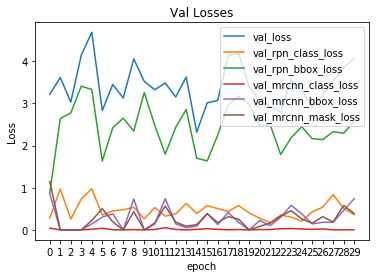

Train Loss 



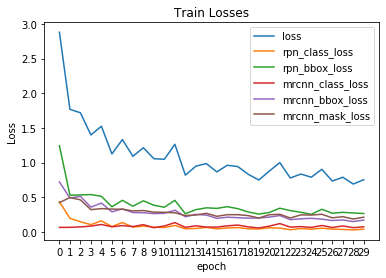

In [15]:
# Train the head branches
# Passing layers="heads" freezes all layers except the head
# layers. You can also pass a regular expression to select
# which layers to train by name pattern.


model.train(dataset_train, dataset_val, 
            learning_rate=config.LEARNING_RATE, 
            epochs=30, 
            layers='heads', augmentation= seq)




Fine tune Resnet stage 4 and up

Starting at epoch 0. LR=0.001

Checkpoint Path: /home/harsh/Mask_RCNN/logs/shapes20190825T1933/mask_rcnn_shapes_{epoch:04d}.h5
Selecting layers to train
res4a_branch2a         (Conv2D)
bn4a_branch2a          (BatchNorm)
res4a_branch2b         (Conv2D)
bn4a_branch2b          (BatchNorm)
res4a_branch2c         (Conv2D)
res4a_branch1          (Conv2D)
bn4a_branch2c          (BatchNorm)
bn4a_branch1           (BatchNorm)
res4b_branch2a         (Conv2D)
bn4b_branch2a          (BatchNorm)
res4b_branch2b         (Conv2D)
bn4b_branch2b          (BatchNorm)
res4b_branch2c         (Conv2D)
bn4b_branch2c          (BatchNorm)
res4c_branch2a         (Conv2D)
bn4c_branch2a          (BatchNorm)
res4c_branch2b         (Conv2D)
bn4c_branch2b          (BatchNorm)
res4c_branch2c         (Conv2D)
bn4c_branch2c          (BatchNorm)
res4d_branch2a         (Conv2D)
bn4d_branch2a          (BatchNorm)
res4d_branch2b         (Conv2D)
bn4d_branch2b          (BatchNorm)
res4d_bran

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 13/100 [==>...........................] - ETA: 7:16 - loss: 0.7311 - rpn_class_loss: 0.0235 - rpn_bbox_loss: 0.2393 - mrcnn_class_loss: 0.0465 - mrcnn_bbox_loss: 0.1720 - mrcnn_mask_loss: 0.2499

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 14/100 [===>..........................] - ETA: 6:45 - loss: 0.7227 - rpn_class_loss: 0.0224 - rpn_bbox_loss: 0.2364 - mrcnn_class_loss: 0.0461 - mrcnn_bbox_loss: 0.1697 - mrcnn_mask_loss: 0.2481

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6

 16/100 [===>..........................] - ETA: 5:54 - loss: 0.7046 - rpn_class_loss: 0.0206 - rpn_bbox_loss: 0.2304 - mrcnn_class_loss: 0.0460 - mrcnn_bbox_loss: 0.1625 - mrcnn_mask_loss: 0.2452

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


100/100 [==============================] - 124s 1s/step - loss: 0.9251 - rpn_class_loss: 0.0867 - rpn_bbox_loss: 0.2966 - mrcnn_class_loss: 0.1097 - mrcnn_bbox_loss: 0.1935 - mrcnn_mask_loss: 0.2385 - val_loss: 3.3114 - val_rpn_class_loss: 0.3488 - val_rpn_bbox_loss: 1.5630 - val_mrcnn_class_loss: 0.0586 - val_mrcnn_bbox_loss: 0.5266 - val_mrcnn_mask_loss: 0.8144
Epoch 2/30
100/100 [==============================] - 68s 677ms/step - loss: 0.7265 - rpn_class_loss: 0.0228 - rpn_bbox_loss: 0.2228 - mrcnn_class_loss: 0.0760 - mrcnn_bbox_loss: 0.1663 - mrcnn_mask_loss: 0.2386 - val_loss: 4.3038 - val_rpn_class_loss: 0.8463 - val_rpn_bbox_loss: 3.0416 - val_mrcnn_class_loss: 7.0538e-04 - val_mrcnn_bbox_loss: 0.2553 - val_mrcnn_mask_loss: 0.1599
Epoch 3/30
  8/100 [=>............................] - ETA: 57s - loss: 0.7662 - rpn_class_loss: 0.0407 - rpn_bbox_loss: 0.2408 - mrcnn_class_loss: 0.0534 - mrcnn_bbox_loss: 0.2074 - mrcnn_mask_loss: 0.2239

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


  9/100 [=>............................] - ETA: 57s - loss: 0.8746 - rpn_class_loss: 0.0630 - rpn_bbox_loss: 0.2941 - mrcnn_class_loss: 0.0528 - mrcnn_bbox_loss: 0.2386 - mrcnn_mask_loss: 0.2261

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 11/100 [==>...........................] - ETA: 56s - loss: 0.8818 - rpn_class_loss: 0.0666 - rpn_bbox_loss: 0.3007 - mrcnn_class_loss: 0.0527 - mrcnn_bbox_loss: 0.2335 - mrcnn_mask_loss: 0.2283

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 13/100 [==>...........................] - ETA: 55s - loss: 0.9022 - rpn_class_loss: 0.0690 - rpn_bbox_loss: 0.3165 - mrcnn_class_loss: 0.0503 - mrcnn_bbox_loss: 0.2337 - mrcnn_mask_loss: 0.2326

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 14/100 [===>..........................] - ETA: 54s - loss: 0.9108 - rpn_class_loss: 0.0658 - rpn_bbox_loss: 0.3120 - mrcnn_class_loss: 0.0590 - mrcnn_bbox_loss: 0.2325 - mrcnn_mask_loss: 0.2414

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 18/100 [====>.........................] - ETA: 52s - loss: 0.8790 - rpn_class_loss: 0.0569 - rpn_bbox_loss: 0.2997 - mrcnn_class_loss: 0.0612 - mrcnn_bbox_loss: 0.2249 - mrcnn_mask_loss: 0.2362

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 20/100 [=====>........................] - ETA: 50s - loss: 0.8547 - rpn_class_loss: 0.0524 - rpn_bbox_loss: 0.2800 - mrcnn_class_loss: 0.0723 - mrcnn_bbox_loss: 0.2166 - mrcnn_mask_loss: 0.2334

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 23/100 [=====>........................] - ETA: 48s - loss: 0.8837 - rpn_class_loss: 0.0497 - rpn_bbox_loss: 0.2654 - mrcnn_class_loss: 0.0820 - mrcnn_bbox_loss: 0.2343 - mrcnn_mask_loss: 0.2522

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


100/100 [==============================] - 67s 669ms/step - loss: 0.8334 - rpn_class_loss: 0.0343 - rpn_bbox_loss: 0.2491 - mrcnn_class_loss: 0.0764 - mrcnn_bbox_loss: 0.2112 - mrcnn_mask_loss: 0.2624 - val_loss: 4.4367 - val_rpn_class_loss: 0.8853 - val_rpn_bbox_loss: 2.3521 - val_mrcnn_class_loss: 6.6838e-04 - val_mrcnn_bbox_loss: 0.8585 - val_mrcnn_mask_loss: 0.3401
Epoch 4/30
100/100 [==============================] - 68s 677ms/step - loss: 0.6204 - rpn_class_loss: 0.0258 - rpn_bbox_loss: 0.1812 - mrcnn_class_loss: 0.0744 - mrcnn_bbox_loss: 0.1258 - mrcnn_mask_loss: 0.2132 - val_loss: 4.9422 - val_rpn_class_loss: 1.4490 - val_rpn_bbox_loss: 3.0136 - val_mrcnn_class_loss: 0.0276 - val_mrcnn_bbox_loss: 0.2067 - val_mrcnn_mask_loss: 0.2452
Epoch 5/30
100/100 [==============================] - 67s 672ms/step - loss: 0.6571 - rpn_class_loss: 0.0330 - rpn_bbox_loss: 0.1947 - mrcnn_class_loss: 0.0852 - mrcnn_bbox_loss: 0.1406 - mrcnn_mask_loss: 0.2036 - val_loss: 4.0045 - val_rpn_class_lo

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 84/100 [========================>.....] - ETA: 10s - loss: 0.6381 - rpn_class_loss: 0.0324 - rpn_bbox_loss: 0.1865 - mrcnn_class_loss: 0.0800 - mrcnn_bbox_loss: 0.1326 - mrcnn_mask_loss: 0.2066

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 87/100 [=========================>....] - ETA: 8s - loss: 0.6280 - rpn_class_loss: 0.0317 - rpn_bbox_loss: 0.1836 - mrcnn_class_loss: 0.0779 - mrcnn_bbox_loss: 0.1302 - mrcnn_mask_loss: 0.2045

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 95/100 [===========================>..] - ETA: 3s - loss: 0.6090 - rpn_class_loss: 0.0298 - rpn_bbox_loss: 0.1780 - mrcnn_class_loss: 0.0739 - mrcnn_bbox_loss: 0.1267 - mrcnn_mask_loss: 0.2005

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 98/100 [============================>.] - ETA: 1s - loss: 0.6010 - rpn_class_loss: 0.0290 - rpn_bbox_loss: 0.1763 - mrcnn_class_loss: 0.0723 - mrcnn_bbox_loss: 0.1247 - mrcnn_mask_loss: 0.1986

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


100/100 [==============================] - 68s 677ms/step - loss: 0.6119 - rpn_class_loss: 0.0292 - rpn_bbox_loss: 0.1779 - mrcnn_class_loss: 0.0732 - mrcnn_bbox_loss: 0.1273 - mrcnn_mask_loss: 0.2043 - val_loss: 4.6053 - val_rpn_class_loss: 1.4684 - val_rpn_bbox_loss: 2.5182 - val_mrcnn_class_loss: 6.2442e-04 - val_mrcnn_bbox_loss: 0.2772 - val_mrcnn_mask_loss: 0.3408
Epoch 8/30
  1/100 [..............................] - ETA: 1:03 - loss: 0.2293 - rpn_class_loss: 0.0042 - rpn_bbox_loss: 0.0463 - mrcnn_class_loss: 0.0323 - mrcnn_bbox_loss: 0.0503 - mrcnn_mask_loss: 0.0962

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


  4/100 [>.............................] - ETA: 1:00 - loss: 0.2260 - rpn_class_loss: 0.0029 - rpn_bbox_loss: 0.0403 - mrcnn_class_loss: 0.0188 - mrcnn_bbox_loss: 0.0469 - mrcnn_mask_loss: 0.1172

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


  8/100 [=>............................] - ETA: 58s - loss: 0.5534 - rpn_class_loss: 0.0050 - rpn_bbox_loss: 0.1385 - mrcnn_class_loss: 0.0443 - mrcnn_bbox_loss: 0.1424 - mrcnn_mask_loss: 0.2232

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 68/100 [===================>..........] - ETA: 20s - loss: 0.4887 - rpn_class_loss: 0.0207 - rpn_bbox_loss: 0.1165 - mrcnn_class_loss: 0.0566 - mrcnn_bbox_loss: 0.0967 - mrcnn_mask_loss: 0.1982

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 73/100 [====================>.........] - ETA: 17s - loss: 0.4853 - rpn_class_loss: 0.0198 - rpn_bbox_loss: 0.1170 - mrcnn_class_loss: 0.0556 - mrcnn_bbox_loss: 0.0950 - mrcnn_mask_loss: 0.1979

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 78/100 [======================>.......] - ETA: 14s - loss: 0.4790 - rpn_class_loss: 0.0191 - rpn_bbox_loss: 0.1176 - mrcnn_class_loss: 0.0540 - mrcnn_bbox_loss: 0.0933 - mrcnn_mask_loss: 0.1951

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 83/100 [=======================>......] - ETA: 11s - loss: 0.4768 - rpn_class_loss: 0.0184 - rpn_bbox_loss: 0.1176 - mrcnn_class_loss: 0.0528 - mrcnn_bbox_loss: 0.0919 - mrcnn_mask_loss: 0.1961

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 88/100 [=========================>....] - ETA: 7s - loss: 0.4738 - rpn_class_loss: 0.0178 - rpn_bbox_loss: 0.1175 - mrcnn_class_loss: 0.0531 - mrcnn_bbox_loss: 0.0918 - mrcnn_mask_loss: 0.1936

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 91/100 [==========================>...] - ETA: 5s - loss: 0.4708 - rpn_class_loss: 0.0175 - rpn_bbox_loss: 0.1177 - mrcnn_class_loss: 0.0525 - mrcnn_bbox_loss: 0.0905 - mrcnn_mask_loss: 0.1926

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 95/100 [===========================>..] - ETA: 3s - loss: 0.4767 - rpn_class_loss: 0.0172 - rpn_bbox_loss: 0.1204 - mrcnn_class_loss: 0.0528 - mrcnn_bbox_loss: 0.0922 - mrcnn_mask_loss: 0.1941

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 97/100 [============================>.] - ETA: 1s - loss: 0.4758 - rpn_class_loss: 0.0170 - rpn_bbox_loss: 0.1209 - mrcnn_class_loss: 0.0525 - mrcnn_bbox_loss: 0.0916 - mrcnn_mask_loss: 0.1939

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


100/100 [==============================] - 69s 690ms/step - loss: 0.4726 - rpn_class_loss: 0.0167 - rpn_bbox_loss: 0.1198 - mrcnn_class_loss: 0.0526 - mrcnn_bbox_loss: 0.0909 - mrcnn_mask_loss: 0.1925 - val_loss: 3.5968 - val_rpn_class_loss: 0.9598 - val_rpn_bbox_loss: 2.2895 - val_mrcnn_class_loss: 0.0141 - val_mrcnn_bbox_loss: 0.1113 - val_mrcnn_mask_loss: 0.2222
Epoch 9/30
100/100 [==============================] - 66s 656ms/step - loss: 0.5130 - rpn_class_loss: 0.0112 - rpn_bbox_loss: 0.1347 - mrcnn_class_loss: 0.0715 - mrcnn_bbox_loss: 0.0964 - mrcnn_mask_loss: 0.1992 - val_loss: 2.8511 - val_rpn_class_loss: 0.7151 - val_rpn_bbox_loss: 2.0959 - val_mrcnn_class_loss: 0.0029 - val_mrcnn_bbox_loss: 0.0141 - val_mrcnn_mask_loss: 0.0230
Epoch 10/30
100/100 [==============================] - 67s 668ms/step - loss: 0.4440 - rpn_class_loss: 0.0188 - rpn_bbox_loss: 0.1463 - mrcnn_class_loss: 0.0362 - mrcnn_bbox_loss: 0.0848 - mrcnn_mask_loss: 0.1579 - val_loss: 4.0191 - val_rpn_class_loss:

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 56/100 [===============>..............] - ETA: 28s - loss: 0.5367 - rpn_class_loss: 0.0129 - rpn_bbox_loss: 0.1508 - mrcnn_class_loss: 0.0617 - mrcnn_bbox_loss: 0.1090 - mrcnn_mask_loss: 0.2023

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 58/100 [================>.............] - ETA: 26s - loss: 0.5369 - rpn_class_loss: 0.0125 - rpn_bbox_loss: 0.1498 - mrcnn_class_loss: 0.0622 - mrcnn_bbox_loss: 0.1087 - mrcnn_mask_loss: 0.2039

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 61/100 [=================>............] - ETA: 25s - loss: 0.5256 - rpn_class_loss: 0.0119 - rpn_bbox_loss: 0.1459 - mrcnn_class_loss: 0.0607 - mrcnn_bbox_loss: 0.1057 - mrcnn_mask_loss: 0.2014

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 62/100 [=================>............] - ETA: 24s - loss: 0.5213 - rpn_class_loss: 0.0118 - rpn_bbox_loss: 0.1441 - mrcnn_class_loss: 0.0604 - mrcnn_bbox_loss: 0.1045 - mrcnn_mask_loss: 0.2006

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 67/100 [===================>..........] - ETA: 21s - loss: 0.5213 - rpn_class_loss: 0.0121 - rpn_bbox_loss: 0.1444 - mrcnn_class_loss: 0.0593 - mrcnn_bbox_loss: 0.1048 - mrcnn_mask_loss: 0.2007

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 72/100 [====================>.........] - ETA: 18s - loss: 0.5071 - rpn_class_loss: 0.0114 - rpn_bbox_loss: 0.1385 - mrcnn_class_loss: 0.0567 - mrcnn_bbox_loss: 0.1013 - mrcnn_mask_loss: 0.1992

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 75/100 [=====================>........] - ETA: 16s - loss: 0.5070 - rpn_class_loss: 0.0117 - rpn_bbox_loss: 0.1400 - mrcnn_class_loss: 0.0554 - mrcnn_bbox_loss: 0.1022 - mrcnn_mask_loss: 0.1978

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


100/100 [==============================] - 68s 684ms/step - loss: 0.5175 - rpn_class_loss: 0.0114 - rpn_bbox_loss: 0.1375 - mrcnn_class_loss: 0.0581 - mrcnn_bbox_loss: 0.1052 - mrcnn_mask_loss: 0.2053 - val_loss: 4.1933 - val_rpn_class_loss: 1.3662 - val_rpn_bbox_loss: 2.6854 - val_mrcnn_class_loss: 0.0145 - val_mrcnn_bbox_loss: 0.0554 - val_mrcnn_mask_loss: 0.0717
Epoch 12/30
100/100 [==============================] - 66s 659ms/step - loss: 0.5129 - rpn_class_loss: 0.0261 - rpn_bbox_loss: 0.1205 - mrcnn_class_loss: 0.0765 - mrcnn_bbox_loss: 0.0964 - mrcnn_mask_loss: 0.1933 - val_loss: 2.8906 - val_rpn_class_loss: 0.4164 - val_rpn_bbox_loss: 1.0406 - val_mrcnn_class_loss: 0.1329 - val_mrcnn_bbox_loss: 0.4049 - val_mrcnn_mask_loss: 0.8958
Epoch 13/30
100/100 [==============================] - 67s 666ms/step - loss: 0.4409 - rpn_class_loss: 0.0055 - rpn_bbox_loss: 0.1226 - mrcnn_class_loss: 0.0382 - mrcnn_bbox_loss: 0.0990 - mrcnn_mask_loss: 0.1756 - val_loss: 4.5054 - val_rpn_class_loss

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 82/100 [=======================>......] - ETA: 11s - loss: 0.4716 - rpn_class_loss: 0.0099 - rpn_bbox_loss: 0.1297 - mrcnn_class_loss: 0.0513 - mrcnn_bbox_loss: 0.0904 - mrcnn_mask_loss: 0.1903

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 92/100 [==========================>...] - ETA: 5s - loss: 0.4649 - rpn_class_loss: 0.0094 - rpn_bbox_loss: 0.1287 - mrcnn_class_loss: 0.0507 - mrcnn_bbox_loss: 0.0878 - mrcnn_mask_loss: 0.1883

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 94/100 [===========================>..] - ETA: 3s - loss: 0.4702 - rpn_class_loss: 0.0094 - rpn_bbox_loss: 0.1294 - mrcnn_class_loss: 0.0533 - mrcnn_bbox_loss: 0.0885 - mrcnn_mask_loss: 0.1895

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 96/100 [===========================>..] - ETA: 2s - loss: 0.4634 - rpn_class_loss: 0.0093 - rpn_bbox_loss: 0.1273 - mrcnn_class_loss: 0.0523 - mrcnn_bbox_loss: 0.0870 - mrcnn_mask_loss: 0.1875

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 98/100 [============================>.] - ETA: 1s - loss: 0.4612 - rpn_class_loss: 0.0093 - rpn_bbox_loss: 0.1273 - mrcnn_class_loss: 0.0517 - mrcnn_bbox_loss: 0.0867 - mrcnn_mask_loss: 0.1862

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


100/100 [==============================] - 67s 669ms/step - loss: 0.4660 - rpn_class_loss: 0.0094 - rpn_bbox_loss: 0.1280 - mrcnn_class_loss: 0.0541 - mrcnn_bbox_loss: 0.0874 - mrcnn_mask_loss: 0.1870 - val_loss: 3.7535 - val_rpn_class_loss: 0.2239 - val_rpn_bbox_loss: 1.5683 - val_mrcnn_class_loss: 0.0142 - val_mrcnn_bbox_loss: 0.8898 - val_mrcnn_mask_loss: 1.0572
Epoch 16/30
  8/100 [=>............................] - ETA: 58s - loss: 0.5652 - rpn_class_loss: 0.0090 - rpn_bbox_loss: 0.1746 - mrcnn_class_loss: 0.0698 - mrcnn_bbox_loss: 0.1010 - mrcnn_mask_loss: 0.2108

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 10/100 [==>...........................] - ETA: 57s - loss: 0.5067 - rpn_class_loss: 0.0076 - rpn_bbox_loss: 0.1537 - mrcnn_class_loss: 0.0619 - mrcnn_bbox_loss: 0.0919 - mrcnn_mask_loss: 0.1916

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


100/100 [==============================] - 67s 672ms/step - loss: 0.3833 - rpn_class_loss: 0.0084 - rpn_bbox_loss: 0.0996 - mrcnn_class_loss: 0.0419 - mrcnn_bbox_loss: 0.0676 - mrcnn_mask_loss: 0.1658 - val_loss: 2.5753 - val_rpn_class_loss: 0.2211 - val_rpn_bbox_loss: 1.1074 - val_mrcnn_class_loss: 0.0979 - val_mrcnn_bbox_loss: 0.3275 - val_mrcnn_mask_loss: 0.8213
Epoch 17/30
100/100 [==============================] - 67s 668ms/step - loss: 0.4438 - rpn_class_loss: 0.0126 - rpn_bbox_loss: 0.1140 - mrcnn_class_loss: 0.0428 - mrcnn_bbox_loss: 0.0899 - mrcnn_mask_loss: 0.1845 - val_loss: 4.3515 - val_rpn_class_loss: 1.4632 - val_rpn_bbox_loss: 2.4159 - val_mrcnn_class_loss: 0.0069 - val_mrcnn_bbox_loss: 0.2204 - val_mrcnn_mask_loss: 0.2452
Epoch 18/30
 26/100 [======>.......................] - ETA: 47s - loss: 0.4092 - rpn_class_loss: 0.0022 - rpn_bbox_loss: 0.0849 - mrcnn_class_loss: 0.0510 - mrcnn_bbox_loss: 0.1010 - mrcnn_mask_loss: 0.1700

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 37/100 [==========>...................] - ETA: 40s - loss: 0.3711 - rpn_class_loss: 0.0022 - rpn_bbox_loss: 0.0789 - mrcnn_class_loss: 0.0411 - mrcnn_bbox_loss: 0.0898 - mrcnn_mask_loss: 0.1592

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 46/100 [============>.................] - ETA: 34s - loss: 0.3541 - rpn_class_loss: 0.0028 - rpn_bbox_loss: 0.0760 - mrcnn_class_loss: 0.0371 - mrcnn_bbox_loss: 0.0831 - mrcnn_mask_loss: 0.1550

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 53/100 [==============>...............] - ETA: 29s - loss: 0.3791 - rpn_class_loss: 0.0089 - rpn_bbox_loss: 0.0798 - mrcnn_class_loss: 0.0476 - mrcnn_bbox_loss: 0.0837 - mrcnn_mask_loss: 0.1591

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 55/100 [===============>..............] - ETA: 28s - loss: 0.3769 - rpn_class_loss: 0.0087 - rpn_bbox_loss: 0.0793 - mrcnn_class_loss: 0.0475 - mrcnn_bbox_loss: 0.0821 - mrcnn_mask_loss: 0.1592

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 58/100 [================>.............] - ETA: 26s - loss: 0.3881 - rpn_class_loss: 0.0097 - rpn_bbox_loss: 0.0826 - mrcnn_class_loss: 0.0522 - mrcnn_bbox_loss: 0.0828 - mrcnn_mask_loss: 0.1607

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 65/100 [==================>...........] - ETA: 22s - loss: 0.3865 - rpn_class_loss: 0.0092 - rpn_bbox_loss: 0.0870 - mrcnn_class_loss: 0.0495 - mrcnn_bbox_loss: 0.0797 - mrcnn_mask_loss: 0.1611

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 68/100 [===================>..........] - ETA: 20s - loss: 0.3924 - rpn_class_loss: 0.0097 - rpn_bbox_loss: 0.0889 - mrcnn_class_loss: 0.0517 - mrcnn_bbox_loss: 0.0800 - mrcnn_mask_loss: 0.1622

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


100/100 [==============================] - 66s 662ms/step - loss: 0.4023 - rpn_class_loss: 0.0095 - rpn_bbox_loss: 0.0954 - mrcnn_class_loss: 0.0529 - mrcnn_bbox_loss: 0.0768 - mrcnn_mask_loss: 0.1676 - val_loss: 4.3172 - val_rpn_class_loss: 1.1496 - val_rpn_bbox_loss: 3.0939 - val_mrcnn_class_loss: 0.0072 - val_mrcnn_bbox_loss: 0.0255 - val_mrcnn_mask_loss: 0.0410
Epoch 19/30
 37/100 [==========>...................] - ETA: 39s - loss: 0.3180 - rpn_class_loss: 0.0080 - rpn_bbox_loss: 0.0809 - mrcnn_class_loss: 0.0328 - mrcnn_bbox_loss: 0.0534 - mrcnn_mask_loss: 0.1428

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 46/100 [============>.................] - ETA: 33s - loss: 0.3248 - rpn_class_loss: 0.0073 - rpn_bbox_loss: 0.0793 - mrcnn_class_loss: 0.0339 - mrcnn_bbox_loss: 0.0559 - mrcnn_mask_loss: 0.1485

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 57/100 [================>.............] - ETA: 27s - loss: 0.3272 - rpn_class_loss: 0.0066 - rpn_bbox_loss: 0.0775 - mrcnn_class_loss: 0.0338 - mrcnn_bbox_loss: 0.0565 - mrcnn_mask_loss: 0.1528

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 66/100 [==================>...........] - ETA: 21s - loss: 0.3394 - rpn_class_loss: 0.0078 - rpn_bbox_loss: 0.0817 - mrcnn_class_loss: 0.0357 - mrcnn_bbox_loss: 0.0601 - mrcnn_mask_loss: 0.1541

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 67/100 [===================>..........] - ETA: 20s - loss: 0.3374 - rpn_class_loss: 0.0077 - rpn_bbox_loss: 0.0815 - mrcnn_class_loss: 0.0354 - mrcnn_bbox_loss: 0.0596 - mrcnn_mask_loss: 0.1532

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 70/100 [====================>.........] - ETA: 18s - loss: 0.3339 - rpn_class_loss: 0.0075 - rpn_bbox_loss: 0.0813 - mrcnn_class_loss: 0.0347 - mrcnn_bbox_loss: 0.0588 - mrcnn_mask_loss: 0.1516

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 77/100 [======================>.......] - ETA: 14s - loss: 0.3323 - rpn_class_loss: 0.0071 - rpn_bbox_loss: 0.0808 - mrcnn_class_loss: 0.0349 - mrcnn_bbox_loss: 0.0595 - mrcnn_mask_loss: 0.1501

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 80/100 [=======================>......] - ETA: 12s - loss: 0.3308 - rpn_class_loss: 0.0069 - rpn_bbox_loss: 0.0798 - mrcnn_class_loss: 0.0340 - mrcnn_bbox_loss: 0.0594 - mrcnn_mask_loss: 0.1506

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


100/100 [==============================] - 66s 660ms/step - loss: 0.3198 - rpn_class_loss: 0.0064 - rpn_bbox_loss: 0.0797 - mrcnn_class_loss: 0.0305 - mrcnn_bbox_loss: 0.0583 - mrcnn_mask_loss: 0.1450 - val_loss: 4.4377 - val_rpn_class_loss: 0.7985 - val_rpn_bbox_loss: 2.9566 - val_mrcnn_class_loss: 0.0434 - val_mrcnn_bbox_loss: 0.1475 - val_mrcnn_mask_loss: 0.4917
Epoch 20/30
100/100 [==============================] - 67s 671ms/step - loss: 0.2659 - rpn_class_loss: 0.0035 - rpn_bbox_loss: 0.0723 - mrcnn_class_loss: 0.0199 - mrcnn_bbox_loss: 0.0485 - mrcnn_mask_loss: 0.1216 - val_loss: 4.8658 - val_rpn_class_loss: 1.2977 - val_rpn_bbox_loss: 2.5247 - val_mrcnn_class_loss: 0.0857 - val_mrcnn_bbox_loss: 0.3694 - val_mrcnn_mask_loss: 0.5883
Epoch 21/30
100/100 [==============================] - 67s 675ms/step - loss: 0.4257 - rpn_class_loss: 0.0093 - rpn_bbox_loss: 0.1116 - mrcnn_class_loss: 0.0415 - mrcnn_bbox_loss: 0.0888 - mrcnn_mask_loss: 0.1744 - val_loss: 3.7781 - val_rpn_class_loss

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 25/100 [======>.......................] - ETA: 47s - loss: 0.3294 - rpn_class_loss: 0.0032 - rpn_bbox_loss: 0.0648 - mrcnn_class_loss: 0.0449 - mrcnn_bbox_loss: 0.0687 - mrcnn_mask_loss: 0.1478

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 30/100 [========>.....................] - ETA: 44s - loss: 0.3150 - rpn_class_loss: 0.0029 - rpn_bbox_loss: 0.0622 - mrcnn_class_loss: 0.0425 - mrcnn_bbox_loss: 0.0644 - mrcnn_mask_loss: 0.1431

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 42/100 [===========>..................] - ETA: 37s - loss: 0.3325 - rpn_class_loss: 0.0024 - rpn_bbox_loss: 0.0718 - mrcnn_class_loss: 0.0398 - mrcnn_bbox_loss: 0.0689 - mrcnn_mask_loss: 0.1496

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 47/100 [=============>................] - ETA: 34s - loss: 0.3251 - rpn_class_loss: 0.0023 - rpn_bbox_loss: 0.0704 - mrcnn_class_loss: 0.0381 - mrcnn_bbox_loss: 0.0677 - mrcnn_mask_loss: 0.1467

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 50/100 [==============>...............] - ETA: 32s - loss: 0.3253 - rpn_class_loss: 0.0022 - rpn_bbox_loss: 0.0694 - mrcnn_class_loss: 0.0371 - mrcnn_bbox_loss: 0.0674 - mrcnn_mask_loss: 0.1492

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 56/100 [===============>..............] - ETA: 28s - loss: 0.3286 - rpn_class_loss: 0.0022 - rpn_bbox_loss: 0.0759 - mrcnn_class_loss: 0.0356 - mrcnn_bbox_loss: 0.0666 - mrcnn_mask_loss: 0.1484

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 58/100 [================>.............] - ETA: 27s - loss: 0.3252 - rpn_class_loss: 0.0022 - rpn_bbox_loss: 0.0751 - mrcnn_class_loss: 0.0349 - mrcnn_bbox_loss: 0.0653 - mrcnn_mask_loss: 0.1476

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


100/100 [==============================] - 67s 673ms/step - loss: 0.3268 - rpn_class_loss: 0.0036 - rpn_bbox_loss: 0.0872 - mrcnn_class_loss: 0.0311 - mrcnn_bbox_loss: 0.0621 - mrcnn_mask_loss: 0.1429 - val_loss: 3.0583 - val_rpn_class_loss: 0.3407 - val_rpn_bbox_loss: 1.3113 - val_mrcnn_class_loss: 0.0566 - val_mrcnn_bbox_loss: 0.5251 - val_mrcnn_mask_loss: 0.8246
Epoch 24/30
100/100 [==============================] - 66s 659ms/step - loss: 0.3412 - rpn_class_loss: 0.0073 - rpn_bbox_loss: 0.0718 - mrcnn_class_loss: 0.0421 - mrcnn_bbox_loss: 0.0607 - mrcnn_mask_loss: 0.1593 - val_loss: 2.9271 - val_rpn_class_loss: 0.5064 - val_rpn_bbox_loss: 2.0149 - val_mrcnn_class_loss: 0.0490 - val_mrcnn_bbox_loss: 0.1205 - val_mrcnn_mask_loss: 0.2364
Epoch 25/30
 61/100 [=================>............] - ETA: 25s - loss: 0.2939 - rpn_class_loss: 0.0031 - rpn_bbox_loss: 0.0690 - mrcnn_class_loss: 0.0262 - mrcnn_bbox_loss: 0.0524 - mrcnn_mask_loss: 0.1433

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 74/100 [=====================>........] - ETA: 16s - loss: 0.3014 - rpn_class_loss: 0.0029 - rpn_bbox_loss: 0.0716 - mrcnn_class_loss: 0.0262 - mrcnn_bbox_loss: 0.0555 - mrcnn_mask_loss: 0.1451

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 76/100 [=====================>........] - ETA: 15s - loss: 0.3033 - rpn_class_loss: 0.0029 - rpn_bbox_loss: 0.0718 - mrcnn_class_loss: 0.0261 - mrcnn_bbox_loss: 0.0555 - mrcnn_mask_loss: 0.1470

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 87/100 [=========================>....] - ETA: 8s - loss: 0.3065 - rpn_class_loss: 0.0029 - rpn_bbox_loss: 0.0716 - mrcnn_class_loss: 0.0256 - mrcnn_bbox_loss: 0.0563 - mrcnn_mask_loss: 0.1502

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 89/100 [=========================>....] - ETA: 7s - loss: 0.3053 - rpn_class_loss: 0.0029 - rpn_bbox_loss: 0.0710 - mrcnn_class_loss: 0.0253 - mrcnn_bbox_loss: 0.0560 - mrcnn_mask_loss: 0.1502

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 94/100 [===========================>..] - ETA: 3s - loss: 0.3098 - rpn_class_loss: 0.0030 - rpn_bbox_loss: 0.0711 - mrcnn_class_loss: 0.0274 - mrcnn_bbox_loss: 0.0569 - mrcnn_mask_loss: 0.1514

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


100/100 [==============================] - 67s 672ms/step - loss: 0.3063 - rpn_class_loss: 0.0029 - rpn_bbox_loss: 0.0705 - mrcnn_class_loss: 0.0271 - mrcnn_bbox_loss: 0.0559 - mrcnn_mask_loss: 0.1499 - val_loss: 3.1268 - val_rpn_class_loss: 0.6324 - val_rpn_bbox_loss: 2.0448 - val_mrcnn_class_loss: 0.0412 - val_mrcnn_bbox_loss: 0.1057 - val_mrcnn_mask_loss: 0.3027
Epoch 26/30
  3/100 [..............................] - ETA: 58s - loss: 0.4857 - rpn_class_loss: 0.0053 - rpn_bbox_loss: 0.0899 - mrcnn_class_loss: 0.0865 - mrcnn_bbox_loss: 0.0944 - mrcnn_mask_loss: 0.2097 

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


  7/100 [=>............................] - ETA: 56s - loss: 0.4129 - rpn_class_loss: 0.0044 - rpn_bbox_loss: 0.0694 - mrcnn_class_loss: 0.0751 - mrcnn_bbox_loss: 0.0705 - mrcnn_mask_loss: 0.1934

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


100/100 [==============================] - 65s 652ms/step - loss: 0.4023 - rpn_class_loss: 0.0103 - rpn_bbox_loss: 0.1040 - mrcnn_class_loss: 0.0501 - mrcnn_bbox_loss: 0.0656 - mrcnn_mask_loss: 0.1723 - val_loss: 2.7308 - val_rpn_class_loss: 0.4798 - val_rpn_bbox_loss: 1.6669 - val_mrcnn_class_loss: 0.0515 - val_mrcnn_bbox_loss: 0.1989 - val_mrcnn_mask_loss: 0.3337
Epoch 27/30
100/100 [==============================] - 67s 674ms/step - loss: 0.2951 - rpn_class_loss: 0.0045 - rpn_bbox_loss: 0.0707 - mrcnn_class_loss: 0.0244 - mrcnn_bbox_loss: 0.0602 - mrcnn_mask_loss: 0.1353 - val_loss: 3.6280 - val_rpn_class_loss: 1.1839 - val_rpn_bbox_loss: 2.3502 - val_mrcnn_class_loss: 0.0114 - val_mrcnn_bbox_loss: 0.0308 - val_mrcnn_mask_loss: 0.0516
Epoch 28/30
 63/100 [=================>............] - ETA: 22s - loss: 0.3387 - rpn_class_loss: 0.0046 - rpn_bbox_loss: 0.0853 - mrcnn_class_loss: 0.0424 - mrcnn_bbox_loss: 0.0653 - mrcnn_mask_loss: 0.1411

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 76/100 [=====================>........] - ETA: 14s - loss: 0.3462 - rpn_class_loss: 0.0045 - rpn_bbox_loss: 0.0915 - mrcnn_class_loss: 0.0421 - mrcnn_bbox_loss: 0.0645 - mrcnn_mask_loss: 0.1436

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 86/100 [========================>.....] - ETA: 8s - loss: 0.3546 - rpn_class_loss: 0.0051 - rpn_bbox_loss: 0.0965 - mrcnn_class_loss: 0.0414 - mrcnn_bbox_loss: 0.0647 - mrcnn_mask_loss: 0.1467

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 91/100 [==========================>...] - ETA: 5s - loss: 0.3530 - rpn_class_loss: 0.0052 - rpn_bbox_loss: 0.0972 - mrcnn_class_loss: 0.0401 - mrcnn_bbox_loss: 0.0643 - mrcnn_mask_loss: 0.1462

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 93/100 [==========================>...] - ETA: 4s - loss: 0.3538 - rpn_class_loss: 0.0051 - rpn_bbox_loss: 0.0981 - mrcnn_class_loss: 0.0399 - mrcnn_bbox_loss: 0.0645 - mrcnn_mask_loss: 0.1463

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 96/100 [===========================>..] - ETA: 2s - loss: 0.3517 - rpn_class_loss: 0.0052 - rpn_bbox_loss: 0.0970 - mrcnn_class_loss: 0.0393 - mrcnn_bbox_loss: 0.0640 - mrcnn_mask_loss: 0.1461

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


100/100 [==============================] - 65s 652ms/step - loss: 0.3490 - rpn_class_loss: 0.0050 - rpn_bbox_loss: 0.0965 - mrcnn_class_loss: 0.0383 - mrcnn_bbox_loss: 0.0630 - mrcnn_mask_loss: 0.1462 - val_loss: 3.4620 - val_rpn_class_loss: 0.8561 - val_rpn_bbox_loss: 2.2081 - val_mrcnn_class_loss: 0.0182 - val_mrcnn_bbox_loss: 0.1884 - val_mrcnn_mask_loss: 0.1912
Epoch 29/30
  6/100 [>.............................] - ETA: 59s - loss: 0.2303 - rpn_class_loss: 8.4625e-04 - rpn_bbox_loss: 0.0475 - mrcnn_class_loss: 0.0273 - mrcnn_bbox_loss: 0.0363 - mrcnn_mask_loss: 0.1183

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 13/100 [==>...........................] - ETA: 54s - loss: 0.2211 - rpn_class_loss: 6.2512e-04 - rpn_bbox_loss: 0.0444 - mrcnn_class_loss: 0.0220 - mrcnn_bbox_loss: 0.0318 - mrcnn_mask_loss: 0.1222

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


100/100 [==============================] - 66s 664ms/step - loss: 0.2330 - rpn_class_loss: 0.0015 - rpn_bbox_loss: 0.0545 - mrcnn_class_loss: 0.0205 - mrcnn_bbox_loss: 0.0409 - mrcnn_mask_loss: 0.1156 - val_loss: 4.1991 - val_rpn_class_loss: 1.2590 - val_rpn_bbox_loss: 2.6748 - val_mrcnn_class_loss: 0.0411 - val_mrcnn_bbox_loss: 0.0636 - val_mrcnn_mask_loss: 0.1606
Epoch 30/30
 19/100 [====>.........................] - ETA: 51s - loss: 0.2374 - rpn_class_loss: 0.0022 - rpn_bbox_loss: 0.0534 - mrcnn_class_loss: 0.0145 - mrcnn_bbox_loss: 0.0533 - mrcnn_mask_loss: 0.1139

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 35/100 [=========>....................] - ETA: 41s - loss: 0.2486 - rpn_class_loss: 0.0019 - rpn_bbox_loss: 0.0571 - mrcnn_class_loss: 0.0165 - mrcnn_bbox_loss: 0.0529 - mrcnn_mask_loss: 0.1201

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 40/100 [===========>..................] - ETA: 38s - loss: 0.2459 - rpn_class_loss: 0.0022 - rpn_bbox_loss: 0.0591 - mrcnn_class_loss: 0.0157 - mrcnn_bbox_loss: 0.0506 - mrcnn_mask_loss: 0.1182

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 45/100 [============>.................] - ETA: 35s - loss: 0.2498 - rpn_class_loss: 0.0024 - rpn_bbox_loss: 0.0591 - mrcnn_class_loss: 0.0158 - mrcnn_bbox_loss: 0.0508 - mrcnn_mask_loss: 0.1217

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 49/100 [=============>................] - ETA: 33s - loss: 0.2447 - rpn_class_loss: 0.0023 - rpn_bbox_loss: 0.0569 - mrcnn_class_loss: 0.0153 - mrcnn_bbox_loss: 0.0494 - mrcnn_mask_loss: 0.1208

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 51/100 [==============>...............] - ETA: 31s - loss: 0.2477 - rpn_class_loss: 0.0024 - rpn_bbox_loss: 0.0569 - mrcnn_class_loss: 0.0159 - mrcnn_bbox_loss: 0.0501 - mrcnn_mask_loss: 0.1223

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 54/100 [===============>..............] - ETA: 29s - loss: 0.2537 - rpn_class_loss: 0.0024 - rpn_bbox_loss: 0.0603 - mrcnn_class_loss: 0.0160 - mrcnn_bbox_loss: 0.0517 - mrcnn_mask_loss: 0.1232

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 62/100 [=================>............] - ETA: 24s - loss: 0.2755 - rpn_class_loss: 0.0055 - rpn_bbox_loss: 0.0639 - mrcnn_class_loss: 0.0223 - mrcnn_bbox_loss: 0.0536 - mrcnn_mask_loss: 0.1301

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


100/100 [==============================] - 67s 670ms/step - loss: 0.2971 - rpn_class_loss: 0.0058 - rpn_bbox_loss: 0.0657 - mrcnn_class_loss: 0.0334 - mrcnn_bbox_loss: 0.0554 - mrcnn_mask_loss: 0.1368 - val_loss: 4.9362 - val_rpn_class_loss: 1.2130 - val_rpn_bbox_loss: 3.0073 - val_mrcnn_class_loss: 0.0152 - val_mrcnn_bbox_loss: 0.3977 - val_mrcnn_mask_loss: 0.3030
Validation Loss 



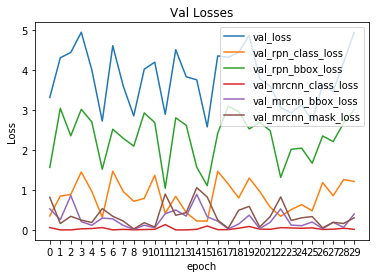

Train Loss 



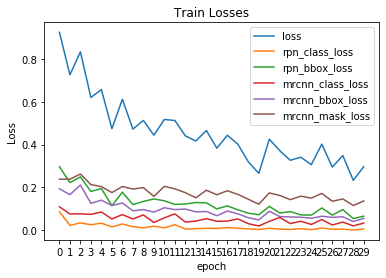

In [16]:

    # Training - Stage 2
        # Finetune layers from ResNet stage 4 and up
        print("Fine tune Resnet stage 4 and up")
        model.train(dataset_train, dataset_val,
                    learning_rate=config.LEARNING_RATE,
                    epochs=30,
                    layers='4+',
                    augmentation=seq)
                    

Fine tune all layers

Starting at epoch 0. LR=0.0001

Checkpoint Path: /home/harsh/Mask_RCNN/logs/shapes20190825T1933/mask_rcnn_shapes_{epoch:04d}.h5
Selecting layers to train
conv1                  (Conv2D)
bn_conv1               (BatchNorm)
res2a_branch2a         (Conv2D)
bn2a_branch2a          (BatchNorm)
res2a_branch2b         (Conv2D)
bn2a_branch2b          (BatchNorm)
res2a_branch2c         (Conv2D)
res2a_branch1          (Conv2D)
bn2a_branch2c          (BatchNorm)
bn2a_branch1           (BatchNorm)
res2b_branch2a         (Conv2D)
bn2b_branch2a          (BatchNorm)
res2b_branch2b         (Conv2D)
bn2b_branch2b          (BatchNorm)
res2b_branch2c         (Conv2D)
bn2b_branch2c          (BatchNorm)
res2c_branch2a         (Conv2D)
bn2c_branch2a          (BatchNorm)
res2c_branch2b         (Conv2D)
bn2c_branch2b          (BatchNorm)
res2c_branch2c         (Conv2D)
bn2c_branch2c          (BatchNorm)
res3a_branch2a         (Conv2D)
bn3a_branch2a          (BatchNorm)
res3a_branch2b      

  3/100 [..............................] - ETA: 34:41 - loss: 0.4849 - rpn_class_loss: 0.0106 - rpn_bbox_loss: 0.1468 - mrcnn_class_loss: 0.0040 - mrcnn_bbox_loss: 0.1082 - mrcnn_mask_loss: 0.2153

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


  4/100 [>.............................] - ETA: 26:01 - loss: 0.4742 - rpn_class_loss: 0.0106 - rpn_bbox_loss: 0.1424 - mrcnn_class_loss: 0.0050 - mrcnn_bbox_loss: 0.1054 - mrcnn_mask_loss: 0.2109

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


  5/100 [>.............................] - ETA: 20:50 - loss: 0.4605 - rpn_class_loss: 0.0105 - rpn_bbox_loss: 0.1370 - mrcnn_class_loss: 0.0049 - mrcnn_bbox_loss: 0.1018 - mrcnn_mask_loss: 0.2062

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


  6/100 [>.............................] - ETA: 17:23 - loss: 0.4448 - rpn_class_loss: 0.0105 - rpn_bbox_loss: 0.1310 - mrcnn_class_loss: 0.0048 - mrcnn_bbox_loss: 0.0981 - mrcnn_mask_loss: 0.2005

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


  7/100 [=>............................] - ETA: 14:55 - loss: 0.4278 - rpn_class_loss: 0.0104 - rpn_bbox_loss: 0.1244 - mrcnn_class_loss: 0.0046 - mrcnn_bbox_loss: 0.0938 - mrcnn_mask_loss: 0.1946

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


  8/100 [=>............................] - ETA: 13:03 - loss: 0.4105 - rpn_class_loss: 0.0104 - rpn_bbox_loss: 0.1177 - mrcnn_class_loss: 0.0051 - mrcnn_bbox_loss: 0.0890 - mrcnn_mask_loss: 0.1883

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 12/100 [==>...........................] - ETA: 8:39 - loss: 0.5044 - rpn_class_loss: 0.0073 - rpn_bbox_loss: 0.1687 - mrcnn_class_loss: 0.0261 - mrcnn_bbox_loss: 0.1031 - mrcnn_mask_loss: 0.1992

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 14/100 [===>..........................] - ETA: 7:23 - loss: 0.5155 - rpn_class_loss: 0.0064 - rpn_bbox_loss: 0.1773 - mrcnn_class_loss: 0.0303 - mrcnn_bbox_loss: 0.1029 - mrcnn_mask_loss: 0.1985

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


100/100 [==============================] - 135s 1s/step - loss: 0.4456 - rpn_class_loss: 0.0103 - rpn_bbox_loss: 0.1358 - mrcnn_class_loss: 0.0568 - mrcnn_bbox_loss: 0.0841 - mrcnn_mask_loss: 0.1586 - val_loss: 2.2819 - val_rpn_class_loss: 0.2105 - val_rpn_bbox_loss: 0.9591 - val_mrcnn_class_loss: 0.0922 - val_mrcnn_bbox_loss: 0.2498 - val_mrcnn_mask_loss: 0.7703
Epoch 2/30
100/100 [==============================] - 74s 741ms/step - loss: 0.3329 - rpn_class_loss: 0.0048 - rpn_bbox_loss: 0.0768 - mrcnn_class_loss: 0.0342 - mrcnn_bbox_loss: 0.0673 - mrcnn_mask_loss: 0.1499 - val_loss: 3.1546 - val_rpn_class_loss: 0.4598 - val_rpn_bbox_loss: 2.3012 - val_mrcnn_class_loss: 4.0487e-05 - val_mrcnn_bbox_loss: 0.1990 - val_mrcnn_mask_loss: 0.1945
Epoch 3/30
  8/100 [=>............................] - ETA: 1:03 - loss: 0.3231 - rpn_class_loss: 8.3931e-04 - rpn_bbox_loss: 0.0947 - mrcnn_class_loss: 0.0202 - mrcnn_bbox_loss: 0.0642 - mrcnn_mask_loss: 0.1431

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


  9/100 [=>............................] - ETA: 1:03 - loss: 0.3423 - rpn_class_loss: 9.5812e-04 - rpn_bbox_loss: 0.1039 - mrcnn_class_loss: 0.0201 - mrcnn_bbox_loss: 0.0733 - mrcnn_mask_loss: 0.1440

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 10/100 [==>...........................] - ETA: 1:03 - loss: 0.3314 - rpn_class_loss: 9.1621e-04 - rpn_bbox_loss: 0.0973 - mrcnn_class_loss: 0.0215 - mrcnn_bbox_loss: 0.0686 - mrcnn_mask_loss: 0.1431

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 12/100 [==>...........................] - ETA: 1:01 - loss: 0.3310 - rpn_class_loss: 9.5612e-04 - rpn_bbox_loss: 0.0968 - mrcnn_class_loss: 0.0207 - mrcnn_bbox_loss: 0.0698 - mrcnn_mask_loss: 0.1426

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 14/100 [===>..........................] - ETA: 1:00 - loss: 0.3361 - rpn_class_loss: 0.0011 - rpn_bbox_loss: 0.1008 - mrcnn_class_loss: 0.0206 - mrcnn_bbox_loss: 0.0726 - mrcnn_mask_loss: 0.1411   

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 19/100 [====>.........................] - ETA: 56s - loss: 0.3231 - rpn_class_loss: 0.0010 - rpn_bbox_loss: 0.0874 - mrcnn_class_loss: 0.0249 - mrcnn_bbox_loss: 0.0699 - mrcnn_mask_loss: 0.1399  

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 21/100 [=====>........................] - ETA: 55s - loss: 0.3176 - rpn_class_loss: 0.0010 - rpn_bbox_loss: 0.0845 - mrcnn_class_loss: 0.0253 - mrcnn_bbox_loss: 0.0681 - mrcnn_mask_loss: 0.1387

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 23/100 [=====>........................] - ETA: 53s - loss: 0.3220 - rpn_class_loss: 0.0011 - rpn_bbox_loss: 0.0826 - mrcnn_class_loss: 0.0272 - mrcnn_bbox_loss: 0.0698 - mrcnn_mask_loss: 0.1414    

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


100/100 [==============================] - 74s 741ms/step - loss: 0.3409 - rpn_class_loss: 0.0030 - rpn_bbox_loss: 0.0776 - mrcnn_class_loss: 0.0302 - mrcnn_bbox_loss: 0.0731 - mrcnn_mask_loss: 0.1569 - val_loss: 4.2778 - val_rpn_class_loss: 1.2315 - val_rpn_bbox_loss: 2.6472 - val_mrcnn_class_loss: 6.3939e-06 - val_mrcnn_bbox_loss: 0.2227 - val_mrcnn_mask_loss: 0.1764
Epoch 4/30
100/100 [==============================] - 75s 749ms/step - loss: 0.3007 - rpn_class_loss: 0.0107 - rpn_bbox_loss: 0.0654 - mrcnn_class_loss: 0.0304 - mrcnn_bbox_loss: 0.0505 - mrcnn_mask_loss: 0.1439 - val_loss: 4.6907 - val_rpn_class_loss: 1.5440 - val_rpn_bbox_loss: 2.8439 - val_mrcnn_class_loss: 0.0596 - val_mrcnn_bbox_loss: 0.0696 - val_mrcnn_mask_loss: 0.1735
Epoch 5/30
100/100 [==============================] - 74s 739ms/step - loss: 0.3140 - rpn_class_loss: 0.0041 - rpn_bbox_loss: 0.0770 - mrcnn_class_loss: 0.0356 - mrcnn_bbox_loss: 0.0578 - mrcnn_mask_loss: 0.1395 - val_loss: 3.8555 - val_rpn_class_lo

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 85/100 [========================>.....] - ETA: 10s - loss: 0.2968 - rpn_class_loss: 0.0067 - rpn_bbox_loss: 0.0727 - mrcnn_class_loss: 0.0344 - mrcnn_bbox_loss: 0.0511 - mrcnn_mask_loss: 0.1319

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 88/100 [=========================>....] - ETA: 8s - loss: 0.2983 - rpn_class_loss: 0.0069 - rpn_bbox_loss: 0.0734 - mrcnn_class_loss: 0.0337 - mrcnn_bbox_loss: 0.0527 - mrcnn_mask_loss: 0.1317

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 90/100 [==========================>...] - ETA: 7s - loss: 0.2970 - rpn_class_loss: 0.0070 - rpn_bbox_loss: 0.0725 - mrcnn_class_loss: 0.0333 - mrcnn_bbox_loss: 0.0531 - mrcnn_mask_loss: 0.1311

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 98/100 [============================>.] - ETA: 1s - loss: 0.2969 - rpn_class_loss: 0.0066 - rpn_bbox_loss: 0.0740 - mrcnn_class_loss: 0.0322 - mrcnn_bbox_loss: 0.0542 - mrcnn_mask_loss: 0.1300

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


100/100 [==============================] - 74s 743ms/step - loss: 0.2963 - rpn_class_loss: 0.0065 - rpn_bbox_loss: 0.0735 - mrcnn_class_loss: 0.0317 - mrcnn_bbox_loss: 0.0547 - mrcnn_mask_loss: 0.1300 - val_loss: 4.5408 - val_rpn_class_loss: 1.5957 - val_rpn_bbox_loss: 2.5796 - val_mrcnn_class_loss: 4.9816e-05 - val_mrcnn_bbox_loss: 0.1838 - val_mrcnn_mask_loss: 0.1816
Epoch 8/30
  1/100 [..............................] - ETA: 1:07 - loss: 0.2510 - rpn_class_loss: 2.2780e-04 - rpn_bbox_loss: 0.0516 - mrcnn_class_loss: 0.0055 - mrcnn_bbox_loss: 0.0691 - mrcnn_mask_loss: 0.1247

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


  4/100 [>.............................] - ETA: 1:06 - loss: 0.3423 - rpn_class_loss: 7.5684e-04 - rpn_bbox_loss: 0.0644 - mrcnn_class_loss: 0.0492 - mrcnn_bbox_loss: 0.0699 - mrcnn_mask_loss: 0.1581

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


  8/100 [=>............................] - ETA: 1:04 - loss: 0.3259 - rpn_class_loss: 7.8100e-04 - rpn_bbox_loss: 0.0578 - mrcnn_class_loss: 0.0467 - mrcnn_bbox_loss: 0.0661 - mrcnn_mask_loss: 0.1544

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 70/100 [====================>.........] - ETA: 21s - loss: 0.2655 - rpn_class_loss: 0.0019 - rpn_bbox_loss: 0.0486 - mrcnn_class_loss: 0.0335 - mrcnn_bbox_loss: 0.0468 - mrcnn_mask_loss: 0.1347

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 75/100 [=====================>........] - ETA: 18s - loss: 0.2619 - rpn_class_loss: 0.0018 - rpn_bbox_loss: 0.0493 - mrcnn_class_loss: 0.0320 - mrcnn_bbox_loss: 0.0456 - mrcnn_mask_loss: 0.1333

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 78/100 [======================>.......] - ETA: 16s - loss: 0.2613 - rpn_class_loss: 0.0018 - rpn_bbox_loss: 0.0489 - mrcnn_class_loss: 0.0317 - mrcnn_bbox_loss: 0.0453 - mrcnn_mask_loss: 0.1336

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 80/100 [=======================>......] - ETA: 14s - loss: 0.2612 - rpn_class_loss: 0.0018 - rpn_bbox_loss: 0.0498 - mrcnn_class_loss: 0.0311 - mrcnn_bbox_loss: 0.0448 - mrcnn_mask_loss: 0.1336

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 86/100 [========================>.....] - ETA: 10s - loss: 0.2633 - rpn_class_loss: 0.0019 - rpn_bbox_loss: 0.0521 - mrcnn_class_loss: 0.0304 - mrcnn_bbox_loss: 0.0439 - mrcnn_mask_loss: 0.1350

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 90/100 [==========================>...] - ETA: 7s - loss: 0.2640 - rpn_class_loss: 0.0019 - rpn_bbox_loss: 0.0537 - mrcnn_class_loss: 0.0303 - mrcnn_bbox_loss: 0.0438 - mrcnn_mask_loss: 0.1343

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 92/100 [==========================>...] - ETA: 5s - loss: 0.2634 - rpn_class_loss: 0.0019 - rpn_bbox_loss: 0.0541 - mrcnn_class_loss: 0.0301 - mrcnn_bbox_loss: 0.0435 - mrcnn_mask_loss: 0.1338

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 97/100 [============================>.] - ETA: 2s - loss: 0.2629 - rpn_class_loss: 0.0019 - rpn_bbox_loss: 0.0545 - mrcnn_class_loss: 0.0298 - mrcnn_bbox_loss: 0.0433 - mrcnn_mask_loss: 0.1335

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


100/100 [==============================] - 75s 753ms/step - loss: 0.2621 - rpn_class_loss: 0.0019 - rpn_bbox_loss: 0.0547 - mrcnn_class_loss: 0.0297 - mrcnn_bbox_loss: 0.0429 - mrcnn_mask_loss: 0.1330 - val_loss: 4.5982 - val_rpn_class_loss: 1.6128 - val_rpn_bbox_loss: 2.6373 - val_mrcnn_class_loss: 0.0274 - val_mrcnn_bbox_loss: 0.1087 - val_mrcnn_mask_loss: 0.2120
Epoch 9/30
100/100 [==============================] - 73s 733ms/step - loss: 0.3062 - rpn_class_loss: 0.0044 - rpn_bbox_loss: 0.0724 - mrcnn_class_loss: 0.0363 - mrcnn_bbox_loss: 0.0521 - mrcnn_mask_loss: 0.1410 - val_loss: 2.9215 - val_rpn_class_loss: 0.6190 - val_rpn_bbox_loss: 2.2238 - val_mrcnn_class_loss: 0.0071 - val_mrcnn_bbox_loss: 0.0169 - val_mrcnn_mask_loss: 0.0547
Epoch 10/30
100/100 [==============================] - 74s 739ms/step - loss: 0.2247 - rpn_class_loss: 0.0033 - rpn_bbox_loss: 0.0462 - mrcnn_class_loss: 0.0213 - mrcnn_bbox_loss: 0.0349 - mrcnn_mask_loss: 0.1190 - val_loss: 3.9124 - val_rpn_class_loss:

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 54/100 [===============>..............] - ETA: 32s - loss: 0.3166 - rpn_class_loss: 0.0053 - rpn_bbox_loss: 0.0632 - mrcnn_class_loss: 0.0390 - mrcnn_bbox_loss: 0.0626 - mrcnn_mask_loss: 0.1464

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 56/100 [===============>..............] - ETA: 31s - loss: 0.3196 - rpn_class_loss: 0.0052 - rpn_bbox_loss: 0.0625 - mrcnn_class_loss: 0.0397 - mrcnn_bbox_loss: 0.0628 - mrcnn_mask_loss: 0.1494

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 59/100 [================>.............] - ETA: 29s - loss: 0.3175 - rpn_class_loss: 0.0050 - rpn_bbox_loss: 0.0620 - mrcnn_class_loss: 0.0395 - mrcnn_bbox_loss: 0.0620 - mrcnn_mask_loss: 0.1490

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 66/100 [==================>...........] - ETA: 24s - loss: 0.3059 - rpn_class_loss: 0.0045 - rpn_bbox_loss: 0.0587 - mrcnn_class_loss: 0.0376 - mrcnn_bbox_loss: 0.0584 - mrcnn_mask_loss: 0.1466

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 70/100 [====================>.........] - ETA: 21s - loss: 0.2989 - rpn_class_loss: 0.0043 - rpn_bbox_loss: 0.0568 - mrcnn_class_loss: 0.0371 - mrcnn_bbox_loss: 0.0563 - mrcnn_mask_loss: 0.1445

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 71/100 [====================>.........] - ETA: 20s - loss: 0.2969 - rpn_class_loss: 0.0042 - rpn_bbox_loss: 0.0564 - mrcnn_class_loss: 0.0368 - mrcnn_bbox_loss: 0.0557 - mrcnn_mask_loss: 0.1437

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 75/100 [=====================>........] - ETA: 17s - loss: 0.2907 - rpn_class_loss: 0.0040 - rpn_bbox_loss: 0.0550 - mrcnn_class_loss: 0.0359 - mrcnn_bbox_loss: 0.0541 - mrcnn_mask_loss: 0.1418

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


100/100 [==============================] - 75s 746ms/step - loss: 0.2788 - rpn_class_loss: 0.0033 - rpn_bbox_loss: 0.0512 - mrcnn_class_loss: 0.0338 - mrcnn_bbox_loss: 0.0502 - mrcnn_mask_loss: 0.1404 - val_loss: 4.6491 - val_rpn_class_loss: 1.5394 - val_rpn_bbox_loss: 2.6891 - val_mrcnn_class_loss: 0.0408 - val_mrcnn_bbox_loss: 0.0962 - val_mrcnn_mask_loss: 0.2835
Epoch 12/30
100/100 [==============================] - 73s 732ms/step - loss: 0.2949 - rpn_class_loss: 0.0046 - rpn_bbox_loss: 0.0565 - mrcnn_class_loss: 0.0444 - mrcnn_bbox_loss: 0.0520 - mrcnn_mask_loss: 0.1373 - val_loss: 3.3930 - val_rpn_class_loss: 0.7829 - val_rpn_bbox_loss: 1.4855 - val_mrcnn_class_loss: 0.1054 - val_mrcnn_bbox_loss: 0.3675 - val_mrcnn_mask_loss: 0.6517
Epoch 13/30
100/100 [==============================] - 74s 742ms/step - loss: 0.2067 - rpn_class_loss: 0.0016 - rpn_bbox_loss: 0.0380 - mrcnn_class_loss: 0.0179 - mrcnn_bbox_loss: 0.0378 - mrcnn_mask_loss: 0.1114 - val_loss: 3.8930 - val_rpn_class_loss

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 79/100 [======================>.......] - ETA: 15s - loss: 0.2292 - rpn_class_loss: 0.0011 - rpn_bbox_loss: 0.0384 - mrcnn_class_loss: 0.0236 - mrcnn_bbox_loss: 0.0334 - mrcnn_mask_loss: 0.1327

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 88/100 [=========================>....] - ETA: 8s - loss: 0.2322 - rpn_class_loss: 0.0014 - rpn_bbox_loss: 0.0398 - mrcnn_class_loss: 0.0243 - mrcnn_bbox_loss: 0.0338 - mrcnn_mask_loss: 0.1329

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 94/100 [===========================>..] - ETA: 4s - loss: 0.2286 - rpn_class_loss: 0.0014 - rpn_bbox_loss: 0.0394 - mrcnn_class_loss: 0.0234 - mrcnn_bbox_loss: 0.0334 - mrcnn_mask_loss: 0.1310

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 99/100 [============================>.] - ETA: 0s - loss: 0.2382 - rpn_class_loss: 0.0016 - rpn_bbox_loss: 0.0418 - mrcnn_class_loss: 0.0270 - mrcnn_bbox_loss: 0.0346 - mrcnn_mask_loss: 0.1332

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


100/100 [==============================] - 74s 743ms/step - loss: 0.2369 - rpn_class_loss: 0.0016 - rpn_bbox_loss: 0.0415 - mrcnn_class_loss: 0.0267 - mrcnn_bbox_loss: 0.0344 - mrcnn_mask_loss: 0.1326 - val_loss: 2.1964 - val_rpn_class_loss: 0.2865 - val_rpn_bbox_loss: 1.7614 - val_mrcnn_class_loss: 0.0141 - val_mrcnn_bbox_loss: 0.0424 - val_mrcnn_mask_loss: 0.0920
Epoch 16/30
  6/100 [>.............................] - ETA: 1:06 - loss: 0.2740 - rpn_class_loss: 0.0036 - rpn_bbox_loss: 0.0636 - mrcnn_class_loss: 0.0419 - mrcnn_bbox_loss: 0.0378 - mrcnn_mask_loss: 0.1271    

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


  8/100 [=>............................] - ETA: 1:04 - loss: 0.3135 - rpn_class_loss: 0.0043 - rpn_bbox_loss: 0.0697 - mrcnn_class_loss: 0.0540 - mrcnn_bbox_loss: 0.0424 - mrcnn_mask_loss: 0.1431

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 13/100 [==>...........................] - ETA: 1:01 - loss: 0.3549 - rpn_class_loss: 0.0050 - rpn_bbox_loss: 0.0796 - mrcnn_class_loss: 0.0644 - mrcnn_bbox_loss: 0.0478 - mrcnn_mask_loss: 0.1581

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


100/100 [==============================] - 75s 746ms/step - loss: 0.1974 - rpn_class_loss: 0.0032 - rpn_bbox_loss: 0.0364 - mrcnn_class_loss: 0.0233 - mrcnn_bbox_loss: 0.0261 - mrcnn_mask_loss: 0.1084 - val_loss: 2.6130 - val_rpn_class_loss: 0.3892 - val_rpn_bbox_loss: 1.2462 - val_mrcnn_class_loss: 0.0939 - val_mrcnn_bbox_loss: 0.2768 - val_mrcnn_mask_loss: 0.6069
Epoch 17/30
100/100 [==============================] - 74s 741ms/step - loss: 0.2131 - rpn_class_loss: 0.0026 - rpn_bbox_loss: 0.0363 - mrcnn_class_loss: 0.0264 - mrcnn_bbox_loss: 0.0284 - mrcnn_mask_loss: 0.1195 - val_loss: 4.3799 - val_rpn_class_loss: 1.5807 - val_rpn_bbox_loss: 2.4463 - val_mrcnn_class_loss: 0.0125 - val_mrcnn_bbox_loss: 0.1264 - val_mrcnn_mask_loss: 0.2139
Epoch 18/30
 25/100 [======>.......................] - ETA: 53s - loss: 0.2081 - rpn_class_loss: 5.0493e-04 - rpn_bbox_loss: 0.0317 - mrcnn_class_loss: 0.0254 - mrcnn_bbox_loss: 0.0388 - mrcnn_mask_loss: 0.1116

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 35/100 [=========>....................] - ETA: 46s - loss: 0.1956 - rpn_class_loss: 4.6211e-04 - rpn_bbox_loss: 0.0293 - mrcnn_class_loss: 0.0224 - mrcnn_bbox_loss: 0.0358 - mrcnn_mask_loss: 0.1078

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 45/100 [============>.................] - ETA: 39s - loss: 0.1991 - rpn_class_loss: 0.0013 - rpn_bbox_loss: 0.0323 - mrcnn_class_loss: 0.0240 - mrcnn_bbox_loss: 0.0341 - mrcnn_mask_loss: 0.1075    

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 49/100 [=============>................] - ETA: 36s - loss: 0.1967 - rpn_class_loss: 0.0013 - rpn_bbox_loss: 0.0321 - mrcnn_class_loss: 0.0231 - mrcnn_bbox_loss: 0.0334 - mrcnn_mask_loss: 0.1068

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 55/100 [===============>..............] - ETA: 32s - loss: 0.2024 - rpn_class_loss: 0.0018 - rpn_bbox_loss: 0.0335 - mrcnn_class_loss: 0.0250 - mrcnn_bbox_loss: 0.0334 - mrcnn_mask_loss: 0.1087

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 61/100 [=================>............] - ETA: 27s - loss: 0.1997 - rpn_class_loss: 0.0018 - rpn_bbox_loss: 0.0328 - mrcnn_class_loss: 0.0235 - mrcnn_bbox_loss: 0.0325 - mrcnn_mask_loss: 0.1092

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 67/100 [===================>..........] - ETA: 23s - loss: 0.2068 - rpn_class_loss: 0.0023 - rpn_bbox_loss: 0.0346 - mrcnn_class_loss: 0.0246 - mrcnn_bbox_loss: 0.0328 - mrcnn_mask_loss: 0.1123

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 71/100 [====================>.........] - ETA: 20s - loss: 0.2115 - rpn_class_loss: 0.0027 - rpn_bbox_loss: 0.0357 - mrcnn_class_loss: 0.0265 - mrcnn_bbox_loss: 0.0329 - mrcnn_mask_loss: 0.1138

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


100/100 [==============================] - 74s 739ms/step - loss: 0.2220 - rpn_class_loss: 0.0033 - rpn_bbox_loss: 0.0392 - mrcnn_class_loss: 0.0291 - mrcnn_bbox_loss: 0.0325 - mrcnn_mask_loss: 0.1178 - val_loss: 3.7551 - val_rpn_class_loss: 0.8898 - val_rpn_bbox_loss: 2.8059 - val_mrcnn_class_loss: 0.0049 - val_mrcnn_bbox_loss: 0.0158 - val_mrcnn_mask_loss: 0.0387
Epoch 19/30
 38/100 [==========>...................] - ETA: 44s - loss: 0.1891 - rpn_class_loss: 0.0022 - rpn_bbox_loss: 0.0335 - mrcnn_class_loss: 0.0188 - mrcnn_bbox_loss: 0.0259 - mrcnn_mask_loss: 0.1088

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 49/100 [=============>................] - ETA: 36s - loss: 0.1924 - rpn_class_loss: 0.0021 - rpn_bbox_loss: 0.0334 - mrcnn_class_loss: 0.0196 - mrcnn_bbox_loss: 0.0270 - mrcnn_mask_loss: 0.1103

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 52/100 [==============>...............] - ETA: 34s - loss: 0.1941 - rpn_class_loss: 0.0021 - rpn_bbox_loss: 0.0341 - mrcnn_class_loss: 0.0191 - mrcnn_bbox_loss: 0.0269 - mrcnn_mask_loss: 0.1119

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 61/100 [=================>............] - ETA: 27s - loss: 0.1943 - rpn_class_loss: 0.0019 - rpn_bbox_loss: 0.0341 - mrcnn_class_loss: 0.0197 - mrcnn_bbox_loss: 0.0275 - mrcnn_mask_loss: 0.1111

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 64/100 [==================>...........] - ETA: 25s - loss: 0.1931 - rpn_class_loss: 0.0018 - rpn_bbox_loss: 0.0339 - mrcnn_class_loss: 0.0193 - mrcnn_bbox_loss: 0.0271 - mrcnn_mask_loss: 0.1110

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 74/100 [=====================>........] - ETA: 18s - loss: 0.1896 - rpn_class_loss: 0.0017 - rpn_bbox_loss: 0.0334 - mrcnn_class_loss: 0.0190 - mrcnn_bbox_loss: 0.0266 - mrcnn_mask_loss: 0.1089

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 79/100 [======================>.......] - ETA: 14s - loss: 0.1875 - rpn_class_loss: 0.0016 - rpn_bbox_loss: 0.0333 - mrcnn_class_loss: 0.0186 - mrcnn_bbox_loss: 0.0262 - mrcnn_mask_loss: 0.1079

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 83/100 [=======================>......] - ETA: 12s - loss: 0.1838 - rpn_class_loss: 0.0015 - rpn_bbox_loss: 0.0324 - mrcnn_class_loss: 0.0179 - mrcnn_bbox_loss: 0.0255 - mrcnn_mask_loss: 0.1066

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


100/100 [==============================] - 74s 738ms/step - loss: 0.1743 - rpn_class_loss: 0.0014 - rpn_bbox_loss: 0.0301 - mrcnn_class_loss: 0.0166 - mrcnn_bbox_loss: 0.0241 - mrcnn_mask_loss: 0.1021 - val_loss: 4.8886 - val_rpn_class_loss: 1.3167 - val_rpn_bbox_loss: 3.1693 - val_mrcnn_class_loss: 0.0199 - val_mrcnn_bbox_loss: 0.1011 - val_mrcnn_mask_loss: 0.2816
Epoch 20/30
100/100 [==============================] - 74s 741ms/step - loss: 0.1569 - rpn_class_loss: 0.0012 - rpn_bbox_loss: 0.0299 - mrcnn_class_loss: 0.0144 - mrcnn_bbox_loss: 0.0223 - mrcnn_mask_loss: 0.0891 - val_loss: 4.8765 - val_rpn_class_loss: 1.5901 - val_rpn_bbox_loss: 2.7016 - val_mrcnn_class_loss: 0.0329 - val_mrcnn_bbox_loss: 0.1681 - val_mrcnn_mask_loss: 0.3839
Epoch 21/30
100/100 [==============================] - 74s 744ms/step - loss: 0.2086 - rpn_class_loss: 0.0029 - rpn_bbox_loss: 0.0369 - mrcnn_class_loss: 0.0216 - mrcnn_bbox_loss: 0.0326 - mrcnn_mask_loss: 0.1145 - val_loss: 4.0549 - val_rpn_class_loss

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 28/100 [=======>......................] - ETA: 52s - loss: 0.1868 - rpn_class_loss: 8.3955e-04 - rpn_bbox_loss: 0.0279 - mrcnn_class_loss: 0.0270 - mrcnn_bbox_loss: 0.0264 - mrcnn_mask_loss: 0.1045

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 30/100 [========>.....................] - ETA: 50s - loss: 0.1860 - rpn_class_loss: 8.0337e-04 - rpn_bbox_loss: 0.0276 - mrcnn_class_loss: 0.0277 - mrcnn_bbox_loss: 0.0258 - mrcnn_mask_loss: 0.1041

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 39/100 [==========>...................] - ETA: 44s - loss: 0.1813 - rpn_class_loss: 7.7481e-04 - rpn_bbox_loss: 0.0268 - mrcnn_class_loss: 0.0270 - mrcnn_bbox_loss: 0.0247 - mrcnn_mask_loss: 0.1021

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 45/100 [============>.................] - ETA: 39s - loss: 0.1768 - rpn_class_loss: 7.4683e-04 - rpn_bbox_loss: 0.0259 - mrcnn_class_loss: 0.0251 - mrcnn_bbox_loss: 0.0239 - mrcnn_mask_loss: 0.1012

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 51/100 [==============>...............] - ETA: 35s - loss: 0.1769 - rpn_class_loss: 7.3676e-04 - rpn_bbox_loss: 0.0269 - mrcnn_class_loss: 0.0241 - mrcnn_bbox_loss: 0.0237 - mrcnn_mask_loss: 0.1014

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 55/100 [===============>..............] - ETA: 32s - loss: 0.1734 - rpn_class_loss: 7.0536e-04 - rpn_bbox_loss: 0.0261 - mrcnn_class_loss: 0.0230 - mrcnn_bbox_loss: 0.0230 - mrcnn_mask_loss: 0.1006

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 60/100 [=================>............] - ETA: 29s - loss: 0.1721 - rpn_class_loss: 8.2540e-04 - rpn_bbox_loss: 0.0259 - mrcnn_class_loss: 0.0219 - mrcnn_bbox_loss: 0.0228 - mrcnn_mask_loss: 0.1007

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


100/100 [==============================] - 75s 748ms/step - loss: 0.1716 - rpn_class_loss: 0.0014 - rpn_bbox_loss: 0.0287 - mrcnn_class_loss: 0.0178 - mrcnn_bbox_loss: 0.0231 - mrcnn_mask_loss: 0.1006 - val_loss: 2.7842 - val_rpn_class_loss: 0.4234 - val_rpn_bbox_loss: 1.5281 - val_mrcnn_class_loss: 0.0816 - val_mrcnn_bbox_loss: 0.2001 - val_mrcnn_mask_loss: 0.5510
Epoch 24/30
100/100 [==============================] - 74s 737ms/step - loss: 0.1968 - rpn_class_loss: 0.0020 - rpn_bbox_loss: 0.0316 - mrcnn_class_loss: 0.0250 - mrcnn_bbox_loss: 0.0265 - mrcnn_mask_loss: 0.1116 - val_loss: 3.7291 - val_rpn_class_loss: 0.6832 - val_rpn_bbox_loss: 1.8471 - val_mrcnn_class_loss: 0.0831 - val_mrcnn_bbox_loss: 0.3814 - val_mrcnn_mask_loss: 0.7344
Epoch 25/30
 59/100 [================>.............] - ETA: 29s - loss: 0.1846 - rpn_class_loss: 0.0011 - rpn_bbox_loss: 0.0267 - mrcnn_class_loss: 0.0171 - mrcnn_bbox_loss: 0.0274 - mrcnn_mask_loss: 0.1123

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 70/100 [====================>.........] - ETA: 21s - loss: 0.1809 - rpn_class_loss: 0.0011 - rpn_bbox_loss: 0.0264 - mrcnn_class_loss: 0.0163 - mrcnn_bbox_loss: 0.0268 - mrcnn_mask_loss: 0.1103

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 73/100 [====================>.........] - ETA: 19s - loss: 0.1802 - rpn_class_loss: 0.0011 - rpn_bbox_loss: 0.0265 - mrcnn_class_loss: 0.0160 - mrcnn_bbox_loss: 0.0266 - mrcnn_mask_loss: 0.1101

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 86/100 [========================>.....] - ETA: 10s - loss: 0.1788 - rpn_class_loss: 0.0011 - rpn_bbox_loss: 0.0269 - mrcnn_class_loss: 0.0161 - mrcnn_bbox_loss: 0.0257 - mrcnn_mask_loss: 0.1090

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 92/100 [==========================>...] - ETA: 5s - loss: 0.1811 - rpn_class_loss: 0.0011 - rpn_bbox_loss: 0.0272 - mrcnn_class_loss: 0.0171 - mrcnn_bbox_loss: 0.0260 - mrcnn_mask_loss: 0.1096

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 99/100 [============================>.] - ETA: 0s - loss: 0.1800 - rpn_class_loss: 0.0011 - rpn_bbox_loss: 0.0283 - mrcnn_class_loss: 0.0169 - mrcnn_bbox_loss: 0.0254 - mrcnn_mask_loss: 0.1084

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


100/100 [==============================] - 75s 747ms/step - loss: 0.1805 - rpn_class_loss: 0.0011 - rpn_bbox_loss: 0.0282 - mrcnn_class_loss: 0.0171 - mrcnn_bbox_loss: 0.0254 - mrcnn_mask_loss: 0.1087 - val_loss: 3.5118 - val_rpn_class_loss: 0.7533 - val_rpn_bbox_loss: 2.4232 - val_mrcnn_class_loss: 0.0295 - val_mrcnn_bbox_loss: 0.0881 - val_mrcnn_mask_loss: 0.2177
Epoch 26/30
  4/100 [>.............................] - ETA: 1:05 - loss: 0.2722 - rpn_class_loss: 0.0010 - rpn_bbox_loss: 0.0464 - mrcnn_class_loss: 0.0439 - mrcnn_bbox_loss: 0.0401 - mrcnn_mask_loss: 0.1406

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


  8/100 [=>............................] - ETA: 1:02 - loss: 0.2471 - rpn_class_loss: 8.9354e-04 - rpn_bbox_loss: 0.0478 - mrcnn_class_loss: 0.0325 - mrcnn_bbox_loss: 0.0373 - mrcnn_mask_loss: 0.1287

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


100/100 [==============================] - 73s 732ms/step - loss: 0.2128 - rpn_class_loss: 0.0028 - rpn_bbox_loss: 0.0378 - mrcnn_class_loss: 0.0308 - mrcnn_bbox_loss: 0.0273 - mrcnn_mask_loss: 0.1141 - val_loss: 2.9094 - val_rpn_class_loss: 0.4627 - val_rpn_bbox_loss: 1.5508 - val_mrcnn_class_loss: 0.1011 - val_mrcnn_bbox_loss: 0.1994 - val_mrcnn_mask_loss: 0.5955
Epoch 27/30
100/100 [==============================] - 75s 746ms/step - loss: 0.1585 - rpn_class_loss: 0.0011 - rpn_bbox_loss: 0.0258 - mrcnn_class_loss: 0.0141 - mrcnn_bbox_loss: 0.0214 - mrcnn_mask_loss: 0.0960 - val_loss: 3.1226 - val_rpn_class_loss: 0.9413 - val_rpn_bbox_loss: 2.1181 - val_mrcnn_class_loss: 0.0032 - val_mrcnn_bbox_loss: 0.0164 - val_mrcnn_mask_loss: 0.0437
Epoch 28/30
 60/100 [=================>............] - ETA: 28s - loss: 0.1782 - rpn_class_loss: 9.3356e-04 - rpn_bbox_loss: 0.0316 - mrcnn_class_loss: 0.0211 - mrcnn_bbox_loss: 0.0245 - mrcnn_mask_loss: 0.1001

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 74/100 [=====================>........] - ETA: 18s - loss: 0.1828 - rpn_class_loss: 0.0011 - rpn_bbox_loss: 0.0334 - mrcnn_class_loss: 0.0217 - mrcnn_bbox_loss: 0.0251 - mrcnn_mask_loss: 0.1015

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 78/100 [======================>.......] - ETA: 15s - loss: 0.1852 - rpn_class_loss: 0.0012 - rpn_bbox_loss: 0.0340 - mrcnn_class_loss: 0.0218 - mrcnn_bbox_loss: 0.0255 - mrcnn_mask_loss: 0.1027

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 89/100 [=========================>....] - ETA: 7s - loss: 0.1887 - rpn_class_loss: 0.0012 - rpn_bbox_loss: 0.0356 - mrcnn_class_loss: 0.0219 - mrcnn_bbox_loss: 0.0260 - mrcnn_mask_loss: 0.1040

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 96/100 [===========================>..] - ETA: 2s - loss: 0.1882 - rpn_class_loss: 0.0012 - rpn_bbox_loss: 0.0354 - mrcnn_class_loss: 0.0219 - mrcnn_bbox_loss: 0.0257 - mrcnn_mask_loss: 0.1040

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


100/100 [==============================] - 73s 729ms/step - loss: 0.1850 - rpn_class_loss: 0.0012 - rpn_bbox_loss: 0.0346 - mrcnn_class_loss: 0.0213 - mrcnn_bbox_loss: 0.0251 - mrcnn_mask_loss: 0.1028 - val_loss: 4.2602 - val_rpn_class_loss: 0.9219 - val_rpn_bbox_loss: 2.1160 - val_mrcnn_class_loss: 0.0110 - val_mrcnn_bbox_loss: 0.4449 - val_mrcnn_mask_loss: 0.7663


/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


Epoch 29/30
 10/100 [==>...........................] - ETA: 1:02 - loss: 0.1720 - rpn_class_loss: 3.8050e-04 - rpn_bbox_loss: 0.0294 - mrcnn_class_loss: 0.0188 - mrcnn_bbox_loss: 0.0224 - mrcnn_mask_loss: 0.1010

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 14/100 [===>..........................] - ETA: 59s - loss: 0.1605 - rpn_class_loss: 3.6379e-04 - rpn_bbox_loss: 0.0248 - mrcnn_class_loss: 0.0186 - mrcnn_bbox_loss: 0.0200 - mrcnn_mask_loss: 0.0968 

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


100/100 [==============================] - 74s 739ms/step - loss: 0.1361 - rpn_class_loss: 5.2896e-04 - rpn_bbox_loss: 0.0189 - mrcnn_class_loss: 0.0139 - mrcnn_bbox_loss: 0.0163 - mrcnn_mask_loss: 0.0865 - val_loss: 4.3642 - val_rpn_class_loss: 1.5273 - val_rpn_bbox_loss: 2.4985 - val_mrcnn_class_loss: 0.0297 - val_mrcnn_bbox_loss: 0.0736 - val_mrcnn_mask_loss: 0.2351
Epoch 30/30
 18/100 [====>.........................] - ETA: 59s - loss: 0.1308 - rpn_class_loss: 6.8924e-04 - rpn_bbox_loss: 0.0186 - mrcnn_class_loss: 0.0124 - mrcnn_bbox_loss: 0.0182 - mrcnn_mask_loss: 0.0810 

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 27/100 [=======>......................] - ETA: 53s - loss: 0.1308 - rpn_class_loss: 5.3598e-04 - rpn_bbox_loss: 0.0181 - mrcnn_class_loss: 0.0122 - mrcnn_bbox_loss: 0.0181 - mrcnn_mask_loss: 0.0818

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 33/100 [========>.....................] - ETA: 48s - loss: 0.1270 - rpn_class_loss: 5.2046e-04 - rpn_bbox_loss: 0.0175 - mrcnn_class_loss: 0.0112 - mrcnn_bbox_loss: 0.0172 - mrcnn_mask_loss: 0.0805

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 44/100 [============>.................] - ETA: 40s - loss: 0.1284 - rpn_class_loss: 6.2143e-04 - rpn_bbox_loss: 0.0179 - mrcnn_class_loss: 0.0113 - mrcnn_bbox_loss: 0.0171 - mrcnn_mask_loss: 0.0815

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 50/100 [==============>...............] - ETA: 36s - loss: 0.1282 - rpn_class_loss: 6.4710e-04 - rpn_bbox_loss: 0.0183 - mrcnn_class_loss: 0.0113 - mrcnn_bbox_loss: 0.0169 - mrcnn_mask_loss: 0.0810

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 53/100 [==============>...............] - ETA: 34s - loss: 0.1268 - rpn_class_loss: 6.6352e-04 - rpn_bbox_loss: 0.0182 - mrcnn_class_loss: 0.0110 - mrcnn_bbox_loss: 0.0165 - mrcnn_mask_loss: 0.0805

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 64/100 [==================>...........] - ETA: 26s - loss: 0.1379 - rpn_class_loss: 7.6341e-04 - rpn_bbox_loss: 0.0199 - mrcnn_class_loss: 0.0146 - mrcnn_bbox_loss: 0.0178 - mrcnn_mask_loss: 0.0848

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 69/100 [===================>..........] - ETA: 22s - loss: 0.1392 - rpn_class_loss: 9.5561e-04 - rpn_bbox_loss: 0.0201 - mrcnn_class_loss: 0.0146 - mrcnn_bbox_loss: 0.0178 - mrcnn_mask_loss: 0.0857

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


100/100 [==============================] - 75s 746ms/step - loss: 0.1730 - rpn_class_loss: 0.0022 - rpn_bbox_loss: 0.0257 - mrcnn_class_loss: 0.0250 - mrcnn_bbox_loss: 0.0229 - mrcnn_mask_loss: 0.0973 - val_loss: 4.4147 - val_rpn_class_loss: 1.1750 - val_rpn_bbox_loss: 2.4182 - val_mrcnn_class_loss: 0.0079 - val_mrcnn_bbox_loss: 0.3882 - val_mrcnn_mask_loss: 0.4253
Validation Loss 



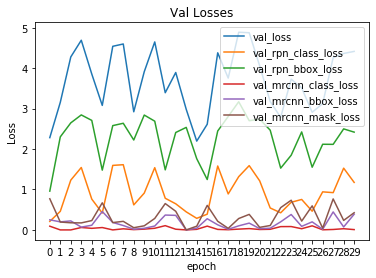

Train Loss 



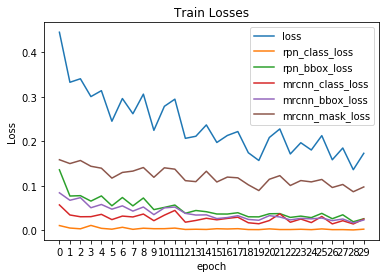

In [17]:

    # Training - Stage 3
        # Fine tune all layers
        print("Fine tune all layers")
        model.train(dataset_train, dataset_val,
                    learning_rate=config.LEARNING_RATE / 10,
                    epochs=30,
                    layers='all',
                    augmentation=seq)
                   
    

In [18]:
class ShapesConfig(Config):
    """Configuration for training on the toy shapes dataset.
    Derives from the base Config class and overrides values specific
    to the toy shapes dataset.
    """
    # Give the configuration a recognizable name
    NAME = "shapes"

    # Train on 1 GPU and 1 images per GPU. We can put multiple images on each
    # GPU because the images are small. Batch size is 1 (GPUs * images/GPU).
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1
    STEPS_PER_EPOCH = 100
    # Number of classes (including background)
    NUM_CLASSES = 1 + 1  # background + 1 shapes

    # Use small images for faster training. Set the limits of the small side
    # the large side, and that determines the image shape.
    #IMAGE_MIN_DIM = 128
    #IMAGE_MAX_DIM = 128

    # Use smaller anchors because our image and objects are small
    #RPN_ANCHOR_SCALES = (8, 16, 32, 64, 128, 256, 512, 768)  # anchor side in pixels

    # Reduce training ROIs per image because the images are small and have
    # few objects. Aim to allow ROI sampling to pick 33% positive ROIs.
    #TRAIN_ROIS_PER_IMAGE = 32

    # Use a small epoch since the data is simple
    #STEPS_PER_EPOCH = 100

    # use small validation steps since the epoch is small
    VALIDATION_STEPS = 10    
    RPN_ANCHOR_SCALES = (32,64, 128, 256, 512, 768)
    BACKBONE_STRIDES = [4, 8, 16, 32, 64, 128]
config = ShapesConfig()
#config.display()

In [19]:
# Create model in training mode
model = modellib.MaskRCNN(mode="training", config=config,
                          model_dir=MODEL_DIR)

# Which weights to start with?
init_with = "coco"  # imagenet, coco, or last

if init_with == "imagenet":
    model.load_weights(model.get_imagenet_weights(), by_name=True)
elif init_with == "coco":
    # Load weights trained on MS COCO, but skip layers that
    # are different due to the different number of classes
    # See README for instructions to download the COCO weights
    model.load_weights(COCO_MODEL_PATH, by_name=True,
                       exclude=["mrcnn_class_logits", "mrcnn_bbox_fc", 
                                "mrcnn_bbox", "mrcnn_mask"])
elif init_with == "last":
    # Load the last model you trained and continue training
    model.load_weights(model.find_last(), by_name=True)


Starting at epoch 0. LR=0.001

Checkpoint Path: /home/harsh/Mask_RCNN/logs/shapes20190825T2117/mask_rcnn_shapes_{epoch:04d}.h5
Selecting layers to train
fpn_c5p5               (Conv2D)
fpn_c4p4               (Conv2D)
fpn_c3p3               (Conv2D)
fpn_c2p2               (Conv2D)
fpn_p5                 (Conv2D)
fpn_p2                 (Conv2D)
fpn_p3                 (Conv2D)
fpn_p4                 (Conv2D)
In model:  rpn_model
    rpn_conv_shared        (Conv2D)
    rpn_class_raw          (Conv2D)
    rpn_bbox_pred          (Conv2D)
mrcnn_mask_conv1       (TimeDistributed)
mrcnn_mask_bn1         (TimeDistributed)
mrcnn_mask_conv2       (TimeDistributed)
mrcnn_mask_bn2         (TimeDistributed)
mrcnn_class_conv1      (TimeDistributed)
mrcnn_class_bn1        (TimeDistributed)
mrcnn_mask_conv3       (TimeDistributed)
mrcnn_mask_bn3         (TimeDistributed)
mrcnn_class_conv2      (TimeDistributed)
mrcnn_class_bn2        (TimeDistributed)
mrcnn_mask_conv4       (TimeDistributed)
mrcnn_mask

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 86/100 [========================>.....] - ETA: 13s - loss: 2.6858 - rpn_class_loss: 0.4015 - rpn_bbox_loss: 1.0183 - mrcnn_class_loss: 0.1169 - mrcnn_bbox_loss: 0.6293 - mrcnn_mask_loss: 0.5197

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 87/100 [=========================>....] - ETA: 12s - loss: 2.6763 - rpn_class_loss: 0.3986 - rpn_bbox_loss: 1.0132 - mrcnn_class_loss: 0.1161 - mrcnn_bbox_loss: 0.6273 - mrcnn_mask_loss: 0.5212

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 89/100 [=========================>....] - ETA: 10s - loss: 2.6829 - rpn_class_loss: 0.3911 - rpn_bbox_loss: 1.0168 - mrcnn_class_loss: 0.1136 - mrcnn_bbox_loss: 0.6379 - mrcnn_mask_loss: 0.5235

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 91/100 [==========================>...] - ETA: 8s - loss: 2.6687 - rpn_class_loss: 0.3844 - rpn_bbox_loss: 1.0102 - mrcnn_class_loss: 0.1117 - mrcnn_bbox_loss: 0.6364 - mrcnn_mask_loss: 0.5259

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6

 93/100 [==========================>...] - ETA: 6s - loss: 2.6545 - rpn_class_loss: 0.3791 - rpn_bbox_loss: 0.9981 - mrcnn_class_loss: 0.1095 - mrcnn_bbox_loss: 0.6393 - mrcnn_mask_loss: 0.5286

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


100/100 [==============================] - 99s 989ms/step - loss: 2.5988 - rpn_class_loss: 0.3586 - rpn_bbox_loss: 0.9707 - mrcnn_class_loss: 0.1038 - mrcnn_bbox_loss: 0.6334 - mrcnn_mask_loss: 0.5323 - val_loss: 3.3179 - val_rpn_class_loss: 0.8563 - val_rpn_bbox_loss: 2.4616 - val_mrcnn_class_loss: 2.2888e-05 - val_mrcnn_bbox_loss: 0.0000e+00 - val_mrcnn_mask_loss: 0.0000e+00
Epoch 2/30
100/100 [==============================] - 53s 530ms/step - loss: 1.8926 - rpn_class_loss: 0.1929 - rpn_bbox_loss: 0.6282 - mrcnn_class_loss: 0.0660 - mrcnn_bbox_loss: 0.5363 - mrcnn_mask_loss: 0.4692 - val_loss: 4.5514 - val_rpn_class_loss: 0.8391 - val_rpn_bbox_loss: 3.7123 - val_mrcnn_class_loss: 5.3428e-05 - val_mrcnn_bbox_loss: 0.0000e+00 - val_mrcnn_mask_loss: 0.0000e+00
Epoch 3/30
100/100 [==============================] - 53s 532ms/step - loss: 1.5251 - rpn_class_loss: 0.1217 - rpn_bbox_loss: 0.4974 - mrcnn_class_loss: 0.0775 - mrcnn_bbox_loss: 0.4258 - mrcnn_mask_loss: 0.4027 - val_loss: 3.154

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 73/100 [====================>.........] - ETA: 14s - loss: 1.2598 - rpn_class_loss: 0.0836 - rpn_bbox_loss: 0.4486 - mrcnn_class_loss: 0.0553 - mrcnn_bbox_loss: 0.3466 - mrcnn_mask_loss: 0.3257

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 76/100 [=====================>........] - ETA: 13s - loss: 1.2597 - rpn_class_loss: 0.0842 - rpn_bbox_loss: 0.4476 - mrcnn_class_loss: 0.0555 - mrcnn_bbox_loss: 0.3459 - mrcnn_mask_loss: 0.3266

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 83/100 [=======================>......] - ETA: 9s - loss: 1.2743 - rpn_class_loss: 0.0884 - rpn_bbox_loss: 0.4587 - mrcnn_class_loss: 0.0541 - mrcnn_bbox_loss: 0.3537 - mrcnn_mask_loss: 0.3194

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 86/100 [========================>.....] - ETA: 7s - loss: 1.2964 - rpn_class_loss: 0.0901 - rpn_bbox_loss: 0.4672 - mrcnn_class_loss: 0.0549 - mrcnn_bbox_loss: 0.3606 - mrcnn_mask_loss: 0.3235

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 90/100 [==========================>...] - ETA: 5s - loss: 1.3067 - rpn_class_loss: 0.0912 - rpn_bbox_loss: 0.4713 - mrcnn_class_loss: 0.0569 - mrcnn_bbox_loss: 0.3604 - mrcnn_mask_loss: 0.3270

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 95/100 [===========================>..] - ETA: 2s - loss: 1.3353 - rpn_class_loss: 0.0928 - rpn_bbox_loss: 0.4789 - mrcnn_class_loss: 0.0580 - mrcnn_bbox_loss: 0.3706 - mrcnn_mask_loss: 0.3350

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 96/100 [===========================>..] - ETA: 2s - loss: 1.3388 - rpn_class_loss: 0.0933 - rpn_bbox_loss: 0.4811 - mrcnn_class_loss: 0.0582 - mrcnn_bbox_loss: 0.3709 - mrcnn_mask_loss: 0.3353

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


100/100 [==============================] - 57s 570ms/step - loss: 1.3470 - rpn_class_loss: 0.0940 - rpn_bbox_loss: 0.4785 - mrcnn_class_loss: 0.0586 - mrcnn_bbox_loss: 0.3755 - mrcnn_mask_loss: 0.3405 - val_loss: 3.0976 - val_rpn_class_loss: 0.3341 - val_rpn_bbox_loss: 2.7634 - val_mrcnn_class_loss: 1.4237e-04 - val_mrcnn_bbox_loss: 0.0000e+00 - val_mrcnn_mask_loss: 0.0000e+00
Epoch 5/30
100/100 [==============================] - 54s 544ms/step - loss: 1.5869 - rpn_class_loss: 0.1682 - rpn_bbox_loss: 0.6174 - mrcnn_class_loss: 0.0776 - mrcnn_bbox_loss: 0.3853 - mrcnn_mask_loss: 0.3384 - val_loss: 2.9324 - val_rpn_class_loss: 0.1877 - val_rpn_bbox_loss: 0.7501 - val_mrcnn_class_loss: 0.0566 - val_mrcnn_bbox_loss: 0.6947 - val_mrcnn_mask_loss: 1.2433
Epoch 6/30
 19/100 [====>.........................] - ETA: 40s - loss: 1.1567 - rpn_class_loss: 0.0872 - rpn_bbox_loss: 0.3509 - mrcnn_class_loss: 0.1035 - mrcnn_bbox_loss: 0.4013 - mrcnn_mask_loss: 0.2139

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 32/100 [========>.....................] - ETA: 34s - loss: 1.1453 - rpn_class_loss: 0.1051 - rpn_bbox_loss: 0.3390 - mrcnn_class_loss: 0.0967 - mrcnn_bbox_loss: 0.3663 - mrcnn_mask_loss: 0.2382

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 39/100 [==========>...................] - ETA: 31s - loss: 1.1383 - rpn_class_loss: 0.1090 - rpn_bbox_loss: 0.3439 - mrcnn_class_loss: 0.0905 - mrcnn_bbox_loss: 0.3540 - mrcnn_mask_loss: 0.2409

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 42/100 [===========>..................] - ETA: 29s - loss: 1.1374 - rpn_class_loss: 0.1110 - rpn_bbox_loss: 0.3483 - mrcnn_class_loss: 0.0886 - mrcnn_bbox_loss: 0.3437 - mrcnn_mask_loss: 0.2457

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 43/100 [===========>..................] - ETA: 29s - loss: 1.1328 - rpn_class_loss: 0.1117 - rpn_bbox_loss: 0.3482 - mrcnn_class_loss: 0.0876 - mrcnn_bbox_loss: 0.3413 - mrcnn_mask_loss: 0.2439

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 52/100 [==============>...............] - ETA: 24s - loss: 1.1377 - rpn_class_loss: 0.1136 - rpn_bbox_loss: 0.3506 - mrcnn_class_loss: 0.0861 - mrcnn_bbox_loss: 0.3357 - mrcnn_mask_loss: 0.2517

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 54/100 [===============>..............] - ETA: 23s - loss: 1.1332 - rpn_class_loss: 0.1125 - rpn_bbox_loss: 0.3530 - mrcnn_class_loss: 0.0849 - mrcnn_bbox_loss: 0.3322 - mrcnn_mask_loss: 0.2505

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 58/100 [================>.............] - ETA: 21s - loss: 1.1166 - rpn_class_loss: 0.1111 - rpn_bbox_loss: 0.3504 - mrcnn_class_loss: 0.0827 - mrcnn_bbox_loss: 0.3245 - mrcnn_mask_loss: 0.2479

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


100/100 [==============================] - 55s 551ms/step - loss: 1.1342 - rpn_class_loss: 0.0949 - rpn_bbox_loss: 0.3351 - mrcnn_class_loss: 0.0842 - mrcnn_bbox_loss: 0.3112 - mrcnn_mask_loss: 0.3088 - val_loss: 2.9503 - val_rpn_class_loss: 0.2749 - val_rpn_bbox_loss: 1.7470 - val_mrcnn_class_loss: 0.0273 - val_mrcnn_bbox_loss: 0.3161 - val_mrcnn_mask_loss: 0.5850
Epoch 7/30
100/100 [==============================] - 55s 554ms/step - loss: 1.2298 - rpn_class_loss: 0.0712 - rpn_bbox_loss: 0.4971 - mrcnn_class_loss: 0.0812 - mrcnn_bbox_loss: 0.2839 - mrcnn_mask_loss: 0.2964 - val_loss: 2.6851 - val_rpn_class_loss: 0.4946 - val_rpn_bbox_loss: 2.1904 - val_mrcnn_class_loss: 7.3812e-05 - val_mrcnn_bbox_loss: 0.0000e+00 - val_mrcnn_mask_loss: 0.0000e+00
Epoch 8/30
100/100 [==============================] - 56s 558ms/step - loss: 1.2261 - rpn_class_loss: 0.0813 - rpn_bbox_loss: 0.4155 - mrcnn_class_loss: 0.1123 - mrcnn_bbox_loss: 0.3163 - mrcnn_mask_loss: 0.3007 - val_loss: 4.6191 - val_rpn_

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 53/100 [==============>...............] - ETA: 24s - loss: 1.0652 - rpn_class_loss: 0.0826 - rpn_bbox_loss: 0.3836 - mrcnn_class_loss: 0.0727 - mrcnn_bbox_loss: 0.2358 - mrcnn_mask_loss: 0.2904

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 62/100 [=================>............] - ETA: 19s - loss: 1.0550 - rpn_class_loss: 0.0791 - rpn_bbox_loss: 0.3731 - mrcnn_class_loss: 0.0715 - mrcnn_bbox_loss: 0.2373 - mrcnn_mask_loss: 0.2940

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 72/100 [====================>.........] - ETA: 14s - loss: 1.0436 - rpn_class_loss: 0.0779 - rpn_bbox_loss: 0.3673 - mrcnn_class_loss: 0.0673 - mrcnn_bbox_loss: 0.2365 - mrcnn_mask_loss: 0.2947

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 86/100 [========================>.....] - ETA: 7s - loss: 1.0253 - rpn_class_loss: 0.0745 - rpn_bbox_loss: 0.3644 - mrcnn_class_loss: 0.0621 - mrcnn_bbox_loss: 0.2337 - mrcnn_mask_loss: 0.2905

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 90/100 [==========================>...] - ETA: 5s - loss: 1.0177 - rpn_class_loss: 0.0726 - rpn_bbox_loss: 0.3595 - mrcnn_class_loss: 0.0616 - mrcnn_bbox_loss: 0.2334 - mrcnn_mask_loss: 0.2905

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 92/100 [==========================>...] - ETA: 4s - loss: 1.0137 - rpn_class_loss: 0.0720 - rpn_bbox_loss: 0.3605 - mrcnn_class_loss: 0.0614 - mrcnn_bbox_loss: 0.2313 - mrcnn_mask_loss: 0.2885

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 96/100 [===========================>..] - ETA: 2s - loss: 1.0002 - rpn_class_loss: 0.0710 - rpn_bbox_loss: 0.3571 - mrcnn_class_loss: 0.0602 - mrcnn_bbox_loss: 0.2261 - mrcnn_mask_loss: 0.2858

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


100/100 [==============================] - 54s 541ms/step - loss: 0.9970 - rpn_class_loss: 0.0707 - rpn_bbox_loss: 0.3541 - mrcnn_class_loss: 0.0608 - mrcnn_bbox_loss: 0.2272 - mrcnn_mask_loss: 0.2842 - val_loss: 3.1617 - val_rpn_class_loss: 0.4565 - val_rpn_bbox_loss: 2.0202 - val_mrcnn_class_loss: 0.0274 - val_mrcnn_bbox_loss: 0.2379 - val_mrcnn_mask_loss: 0.4196
Epoch 11/30
100/100 [==============================] - 55s 545ms/step - loss: 0.9055 - rpn_class_loss: 0.0589 - rpn_bbox_loss: 0.3138 - mrcnn_class_loss: 0.0659 - mrcnn_bbox_loss: 0.2170 - mrcnn_mask_loss: 0.2499 - val_loss: 2.9532 - val_rpn_class_loss: 0.2697 - val_rpn_bbox_loss: 2.0206 - val_mrcnn_class_loss: 0.0221 - val_mrcnn_bbox_loss: 0.3025 - val_mrcnn_mask_loss: 0.3383
Epoch 12/30
 80/100 [=======================>......] - ETA: 10s - loss: 0.8582 - rpn_class_loss: 0.0400 - rpn_bbox_loss: 0.3172 - mrcnn_class_loss: 0.0645 - mrcnn_bbox_loss: 0.1998 - mrcnn_mask_loss: 0.2366

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 90/100 [==========================>...] - ETA: 5s - loss: 0.8773 - rpn_class_loss: 0.0448 - rpn_bbox_loss: 0.3218 - mrcnn_class_loss: 0.0683 - mrcnn_bbox_loss: 0.2004 - mrcnn_mask_loss: 0.2419

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 96/100 [===========================>..] - ETA: 2s - loss: 0.8986 - rpn_class_loss: 0.0465 - rpn_bbox_loss: 0.3254 - mrcnn_class_loss: 0.0717 - mrcnn_bbox_loss: 0.2059 - mrcnn_mask_loss: 0.2491

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


100/100 [==============================] - 56s 556ms/step - loss: 0.9069 - rpn_class_loss: 0.0478 - rpn_bbox_loss: 0.3249 - mrcnn_class_loss: 0.0759 - mrcnn_bbox_loss: 0.2080 - mrcnn_mask_loss: 0.2503 - val_loss: 2.5832 - val_rpn_class_loss: 0.4669 - val_rpn_bbox_loss: 2.1163 - val_mrcnn_class_loss: 3.0279e-06 - val_mrcnn_bbox_loss: 0.0000e+00 - val_mrcnn_mask_loss: 0.0000e+00
Epoch 13/30
 16/100 [===>..........................] - ETA: 41s - loss: 1.1202 - rpn_class_loss: 0.0761 - rpn_bbox_loss: 0.3840 - mrcnn_class_loss: 0.0829 - mrcnn_bbox_loss: 0.2831 - mrcnn_mask_loss: 0.2941

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 23/100 [=====>........................] - ETA: 38s - loss: 1.2371 - rpn_class_loss: 0.0805 - rpn_bbox_loss: 0.4159 - mrcnn_class_loss: 0.1134 - mrcnn_bbox_loss: 0.3094 - mrcnn_mask_loss: 0.3180

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 33/100 [========>.....................] - ETA: 33s - loss: 1.2683 - rpn_class_loss: 0.0816 - rpn_bbox_loss: 0.4091 - mrcnn_class_loss: 0.1273 - mrcnn_bbox_loss: 0.3262 - mrcnn_mask_loss: 0.3241

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 36/100 [=========>....................] - ETA: 32s - loss: 1.2427 - rpn_class_loss: 0.0812 - rpn_bbox_loss: 0.3961 - mrcnn_class_loss: 0.1225 - mrcnn_bbox_loss: 0.3217 - mrcnn_mask_loss: 0.3212

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 42/100 [===========>..................] - ETA: 29s - loss: 1.3265 - rpn_class_loss: 0.1065 - rpn_bbox_loss: 0.4409 - mrcnn_class_loss: 0.1225 - mrcnn_bbox_loss: 0.3273 - mrcnn_mask_loss: 0.3294

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


100/100 [==============================] - 54s 542ms/step - loss: 1.2296 - rpn_class_loss: 0.0972 - rpn_bbox_loss: 0.4651 - mrcnn_class_loss: 0.0981 - mrcnn_bbox_loss: 0.2782 - mrcnn_mask_loss: 0.2910 - val_loss: 3.2297 - val_rpn_class_loss: 0.4112 - val_rpn_bbox_loss: 2.8184 - val_mrcnn_class_loss: 1.9741e-05 - val_mrcnn_bbox_loss: 0.0000e+00 - val_mrcnn_mask_loss: 0.0000e+00
Epoch 14/30
100/100 [==============================] - 56s 558ms/step - loss: 0.9200 - rpn_class_loss: 0.0646 - rpn_bbox_loss: 0.3213 - mrcnn_class_loss: 0.0831 - mrcnn_bbox_loss: 0.2186 - mrcnn_mask_loss: 0.2324 - val_loss: 3.3622 - val_rpn_class_loss: 0.5030 - val_rpn_bbox_loss: 2.8592 - val_mrcnn_class_loss: 7.7486e-06 - val_mrcnn_bbox_loss: 0.0000e+00 - val_mrcnn_mask_loss: 0.0000e+00
Epoch 15/30
 23/100 [=====>........................] - ETA: 38s - loss: 1.0612 - rpn_class_loss: 0.0688 - rpn_bbox_loss: 0.3240 - mrcnn_class_loss: 0.0622 - mrcnn_bbox_loss: 0.3068 - mrcnn_mask_loss: 0.2994

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 42/100 [===========>..................] - ETA: 29s - loss: 1.1344 - rpn_class_loss: 0.0767 - rpn_bbox_loss: 0.3662 - mrcnn_class_loss: 0.0847 - mrcnn_bbox_loss: 0.3124 - mrcnn_mask_loss: 0.2944

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 44/100 [============>.................] - ETA: 28s - loss: 1.1328 - rpn_class_loss: 0.0771 - rpn_bbox_loss: 0.3652 - mrcnn_class_loss: 0.0846 - mrcnn_bbox_loss: 0.3109 - mrcnn_mask_loss: 0.2949

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 62/100 [=================>............] - ETA: 19s - loss: 1.1232 - rpn_class_loss: 0.0762 - rpn_bbox_loss: 0.3558 - mrcnn_class_loss: 0.0932 - mrcnn_bbox_loss: 0.2976 - mrcnn_mask_loss: 0.3004

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 74/100 [=====================>........] - ETA: 13s - loss: 1.0970 - rpn_class_loss: 0.0724 - rpn_bbox_loss: 0.3462 - mrcnn_class_loss: 0.0949 - mrcnn_bbox_loss: 0.2839 - mrcnn_mask_loss: 0.2997

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 79/100 [======================>.......] - ETA: 10s - loss: 1.1006 - rpn_class_loss: 0.0710 - rpn_bbox_loss: 0.3525 - mrcnn_class_loss: 0.0973 - mrcnn_bbox_loss: 0.2801 - mrcnn_mask_loss: 0.2998

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 83/100 [=======================>......] - ETA: 8s - loss: 1.0982 - rpn_class_loss: 0.0701 - rpn_bbox_loss: 0.3512 - mrcnn_class_loss: 0.1002 - mrcnn_bbox_loss: 0.2778 - mrcnn_mask_loss: 0.2989

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 94/100 [===========================>..] - ETA: 3s - loss: 1.0738 - rpn_class_loss: 0.0670 - rpn_bbox_loss: 0.3459 - mrcnn_class_loss: 0.0981 - mrcnn_bbox_loss: 0.2674 - mrcnn_mask_loss: 0.2954

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


100/100 [==============================] - 53s 533ms/step - loss: 1.0440 - rpn_class_loss: 0.0647 - rpn_bbox_loss: 0.3389 - mrcnn_class_loss: 0.0941 - mrcnn_bbox_loss: 0.2589 - mrcnn_mask_loss: 0.2873 - val_loss: 3.2839 - val_rpn_class_loss: 0.6229 - val_rpn_bbox_loss: 2.6611 - val_mrcnn_class_loss: 3.1352e-06 - val_mrcnn_bbox_loss: 0.0000e+00 - val_mrcnn_mask_loss: 0.0000e+00
Epoch 16/30
100/100 [==============================] - 56s 563ms/step - loss: 0.8729 - rpn_class_loss: 0.0545 - rpn_bbox_loss: 0.3473 - mrcnn_class_loss: 0.0563 - mrcnn_bbox_loss: 0.1930 - mrcnn_mask_loss: 0.2218 - val_loss: 3.6048 - val_rpn_class_loss: 0.4208 - val_rpn_bbox_loss: 2.1884 - val_mrcnn_class_loss: 0.0117 - val_mrcnn_bbox_loss: 0.4053 - val_mrcnn_mask_loss: 0.5786
Epoch 17/30
100/100 [==============================] - 54s 536ms/step - loss: 0.9626 - rpn_class_loss: 0.0635 - rpn_bbox_loss: 0.3476 - mrcnn_class_loss: 0.1068 - mrcnn_bbox_loss: 0.2110 - mrcnn_mask_loss: 0.2337 - val_loss: 3.5062 - val_rp

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 30/100 [========>.....................] - ETA: 35s - loss: 0.8466 - rpn_class_loss: 0.0427 - rpn_bbox_loss: 0.2690 - mrcnn_class_loss: 0.0748 - mrcnn_bbox_loss: 0.2140 - mrcnn_mask_loss: 0.2462

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 44/100 [============>.................] - ETA: 28s - loss: 0.8615 - rpn_class_loss: 0.0469 - rpn_bbox_loss: 0.2624 - mrcnn_class_loss: 0.0809 - mrcnn_bbox_loss: 0.2195 - mrcnn_mask_loss: 0.2517

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 57/100 [================>.............] - ETA: 22s - loss: 0.8556 - rpn_class_loss: 0.0456 - rpn_bbox_loss: 0.2590 - mrcnn_class_loss: 0.0813 - mrcnn_bbox_loss: 0.2214 - mrcnn_mask_loss: 0.2483

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 70/100 [====================>.........] - ETA: 15s - loss: 0.8617 - rpn_class_loss: 0.0457 - rpn_bbox_loss: 0.2636 - mrcnn_class_loss: 0.0786 - mrcnn_bbox_loss: 0.2227 - mrcnn_mask_loss: 0.2512

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 75/100 [=====================>........] - ETA: 12s - loss: 0.8638 - rpn_class_loss: 0.0459 - rpn_bbox_loss: 0.2671 - mrcnn_class_loss: 0.0778 - mrcnn_bbox_loss: 0.2219 - mrcnn_mask_loss: 0.2511

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 80/100 [=======================>......] - ETA: 10s - loss: 0.8596 - rpn_class_loss: 0.0446 - rpn_bbox_loss: 0.2660 - mrcnn_class_loss: 0.0768 - mrcnn_bbox_loss: 0.2188 - mrcnn_mask_loss: 0.2533

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 90/100 [==========================>...] - ETA: 5s - loss: 0.8713 - rpn_class_loss: 0.0436 - rpn_bbox_loss: 0.2734 - mrcnn_class_loss: 0.0762 - mrcnn_bbox_loss: 0.2221 - mrcnn_mask_loss: 0.2560

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


100/100 [==============================] - 54s 541ms/step - loss: 0.8959 - rpn_class_loss: 0.0445 - rpn_bbox_loss: 0.2762 - mrcnn_class_loss: 0.0783 - mrcnn_bbox_loss: 0.2279 - mrcnn_mask_loss: 0.2689 - val_loss: 3.8332 - val_rpn_class_loss: 0.5194 - val_rpn_bbox_loss: 3.3138 - val_mrcnn_class_loss: 1.2350e-05 - val_mrcnn_bbox_loss: 0.0000e+00 - val_mrcnn_mask_loss: 0.0000e+00
Epoch 19/30
 69/100 [===================>..........] - ETA: 15s - loss: 0.8889 - rpn_class_loss: 0.0476 - rpn_bbox_loss: 0.3439 - mrcnn_class_loss: 0.0726 - mrcnn_bbox_loss: 0.2117 - mrcnn_mask_loss: 0.2131

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 72/100 [====================>.........] - ETA: 14s - loss: 0.8830 - rpn_class_loss: 0.0466 - rpn_bbox_loss: 0.3440 - mrcnn_class_loss: 0.0713 - mrcnn_bbox_loss: 0.2087 - mrcnn_mask_loss: 0.2124

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 88/100 [=========================>....] - ETA: 6s - loss: 0.8530 - rpn_class_loss: 0.0460 - rpn_bbox_loss: 0.3326 - mrcnn_class_loss: 0.0682 - mrcnn_bbox_loss: 0.1987 - mrcnn_mask_loss: 0.2075

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


100/100 [==============================] - 54s 540ms/step - loss: 0.8461 - rpn_class_loss: 0.0449 - rpn_bbox_loss: 0.3277 - mrcnn_class_loss: 0.0678 - mrcnn_bbox_loss: 0.1954 - mrcnn_mask_loss: 0.2104 - val_loss: 3.7247 - val_rpn_class_loss: 0.7336 - val_rpn_bbox_loss: 2.0238 - val_mrcnn_class_loss: 0.0166 - val_mrcnn_bbox_loss: 0.4472 - val_mrcnn_mask_loss: 0.5035
Epoch 20/30
  1/100 [..............................] - ETA: 49s - loss: 0.8523 - rpn_class_loss: 0.0691 - rpn_bbox_loss: 0.2553 - mrcnn_class_loss: 0.0478 - mrcnn_bbox_loss: 0.1883 - mrcnn_mask_loss: 0.2917

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 15/100 [===>..........................] - ETA: 42s - loss: 0.7372 - rpn_class_loss: 0.0348 - rpn_bbox_loss: 0.2307 - mrcnn_class_loss: 0.0570 - mrcnn_bbox_loss: 0.1911 - mrcnn_mask_loss: 0.2236

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 21/100 [=====>........................] - ETA: 40s - loss: 0.7222 - rpn_class_loss: 0.0314 - rpn_bbox_loss: 0.2162 - mrcnn_class_loss: 0.0600 - mrcnn_bbox_loss: 0.1951 - mrcnn_mask_loss: 0.2196

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 25/100 [======>.......................] - ETA: 38s - loss: 0.7159 - rpn_class_loss: 0.0301 - rpn_bbox_loss: 0.2125 - mrcnn_class_loss: 0.0567 - mrcnn_bbox_loss: 0.2054 - mrcnn_mask_loss: 0.2112

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 31/100 [========>.....................] - ETA: 35s - loss: 0.6918 - rpn_class_loss: 0.0299 - rpn_bbox_loss: 0.2046 - mrcnn_class_loss: 0.0596 - mrcnn_bbox_loss: 0.1990 - mrcnn_mask_loss: 0.1987

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


100/100 [==============================] - 55s 547ms/step - loss: 0.7804 - rpn_class_loss: 0.0339 - rpn_bbox_loss: 0.2498 - mrcnn_class_loss: 0.0744 - mrcnn_bbox_loss: 0.2084 - mrcnn_mask_loss: 0.2139 - val_loss: 2.9709 - val_rpn_class_loss: 0.3322 - val_rpn_bbox_loss: 1.7401 - val_mrcnn_class_loss: 0.0182 - val_mrcnn_bbox_loss: 0.2554 - val_mrcnn_mask_loss: 0.6251
Epoch 21/30
100/100 [==============================] - 55s 555ms/step - loss: 0.9541 - rpn_class_loss: 0.0595 - rpn_bbox_loss: 0.3930 - mrcnn_class_loss: 0.0822 - mrcnn_bbox_loss: 0.1896 - mrcnn_mask_loss: 0.2298 - val_loss: 3.3200 - val_rpn_class_loss: 0.2320 - val_rpn_bbox_loss: 2.0950 - val_mrcnn_class_loss: 0.0090 - val_mrcnn_bbox_loss: 0.4979 - val_mrcnn_mask_loss: 0.4860
Epoch 22/30
 29/100 [=======>......................] - ETA: 36s - loss: 1.0672 - rpn_class_loss: 0.0793 - rpn_bbox_loss: 0.3274 - mrcnn_class_loss: 0.1304 - mrcnn_bbox_loss: 0.2504 - mrcnn_mask_loss: 0.2798

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 32/100 [========>.....................] - ETA: 35s - loss: 1.0900 - rpn_class_loss: 0.0790 - rpn_bbox_loss: 0.3403 - mrcnn_class_loss: 0.1355 - mrcnn_bbox_loss: 0.2499 - mrcnn_mask_loss: 0.2853

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 35/100 [=========>....................] - ETA: 34s - loss: 1.0730 - rpn_class_loss: 0.0743 - rpn_bbox_loss: 0.3466 - mrcnn_class_loss: 0.1258 - mrcnn_bbox_loss: 0.2498 - mrcnn_mask_loss: 0.2765

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 57/100 [================>.............] - ETA: 22s - loss: 1.0271 - rpn_class_loss: 0.0601 - rpn_bbox_loss: 0.3295 - mrcnn_class_loss: 0.1117 - mrcnn_bbox_loss: 0.2454 - mrcnn_mask_loss: 0.2803

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 66/100 [==================>...........] - ETA: 17s - loss: 0.9828 - rpn_class_loss: 0.0556 - rpn_bbox_loss: 0.3125 - mrcnn_class_loss: 0.1046 - mrcnn_bbox_loss: 0.2382 - mrcnn_mask_loss: 0.2719

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 76/100 [=====================>........] - ETA: 12s - loss: 0.9396 - rpn_class_loss: 0.0513 - rpn_bbox_loss: 0.3028 - mrcnn_class_loss: 0.0967 - mrcnn_bbox_loss: 0.2255 - mrcnn_mask_loss: 0.2633

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 86/100 [========================>.....] - ETA: 7s - loss: 0.9144 - rpn_class_loss: 0.0477 - rpn_bbox_loss: 0.2965 - mrcnn_class_loss: 0.0925 - mrcnn_bbox_loss: 0.2188 - mrcnn_mask_loss: 0.2589

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 93/100 [==========================>...] - ETA: 3s - loss: 0.9337 - rpn_class_loss: 0.0494 - rpn_bbox_loss: 0.2992 - mrcnn_class_loss: 0.1000 - mrcnn_bbox_loss: 0.2217 - mrcnn_mask_loss: 0.2635

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


100/100 [==============================] - 55s 547ms/step - loss: 0.9317 - rpn_class_loss: 0.0489 - rpn_bbox_loss: 0.2940 - mrcnn_class_loss: 0.1021 - mrcnn_bbox_loss: 0.2211 - mrcnn_mask_loss: 0.2657 - val_loss: 4.3424 - val_rpn_class_loss: 1.0117 - val_rpn_bbox_loss: 3.0551 - val_mrcnn_class_loss: 0.0024 - val_mrcnn_bbox_loss: 0.1378 - val_mrcnn_mask_loss: 0.1353
Epoch 23/30
100/100 [==============================] - 53s 535ms/step - loss: 0.8610 - rpn_class_loss: 0.0401 - rpn_bbox_loss: 0.3239 - mrcnn_class_loss: 0.0881 - mrcnn_bbox_loss: 0.1958 - mrcnn_mask_loss: 0.2132 - val_loss: 3.4118 - val_rpn_class_loss: 0.4302 - val_rpn_bbox_loss: 2.8517 - val_mrcnn_class_loss: 0.0027 - val_mrcnn_bbox_loss: 0.0735 - val_mrcnn_mask_loss: 0.0537
Epoch 24/30
100/100 [==============================] - 54s 538ms/step - loss: 0.8879 - rpn_class_loss: 0.0506 - rpn_bbox_loss: 0.3148 - mrcnn_class_loss: 0.0591 - mrcnn_bbox_loss: 0.2185 - mrcnn_mask_loss: 0.2449 - val_loss: 3.4564 - val_rpn_class_loss

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 69/100 [===================>..........] - ETA: 16s - loss: 0.7738 - rpn_class_loss: 0.0383 - rpn_bbox_loss: 0.2899 - mrcnn_class_loss: 0.0463 - mrcnn_bbox_loss: 0.1839 - mrcnn_mask_loss: 0.2154

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 74/100 [=====================>........] - ETA: 14s - loss: 0.7598 - rpn_class_loss: 0.0380 - rpn_bbox_loss: 0.2811 - mrcnn_class_loss: 0.0471 - mrcnn_bbox_loss: 0.1795 - mrcnn_mask_loss: 0.2140

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 98/100 [============================>.] - ETA: 1s - loss: 0.7513 - rpn_class_loss: 0.0369 - rpn_bbox_loss: 0.2720 - mrcnn_class_loss: 0.0492 - mrcnn_bbox_loss: 0.1815 - mrcnn_mask_loss: 0.2116

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


100/100 [==============================] - 56s 562ms/step - loss: 0.7511 - rpn_class_loss: 0.0371 - rpn_bbox_loss: 0.2702 - mrcnn_class_loss: 0.0497 - mrcnn_bbox_loss: 0.1818 - mrcnn_mask_loss: 0.2124 - val_loss: 3.1449 - val_rpn_class_loss: 0.4053 - val_rpn_bbox_loss: 2.6318 - val_mrcnn_class_loss: 1.7913e-04 - val_mrcnn_bbox_loss: 0.0537 - val_mrcnn_mask_loss: 0.0539
Epoch 26/30
  3/100 [..............................] - ETA: 48s - loss: 0.7938 - rpn_class_loss: 0.0296 - rpn_bbox_loss: 0.3762 - mrcnn_class_loss: 0.0399 - mrcnn_bbox_loss: 0.1887 - mrcnn_mask_loss: 0.1594

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


  9/100 [=>............................] - ETA: 46s - loss: 0.7847 - rpn_class_loss: 0.0324 - rpn_bbox_loss: 0.3271 - mrcnn_class_loss: 0.0553 - mrcnn_bbox_loss: 0.1865 - mrcnn_mask_loss: 0.1833

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 18/100 [====>.........................] - ETA: 41s - loss: 0.9365 - rpn_class_loss: 0.0606 - rpn_bbox_loss: 0.3291 - mrcnn_class_loss: 0.1224 - mrcnn_bbox_loss: 0.2095 - mrcnn_mask_loss: 0.2148

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 30/100 [========>.....................] - ETA: 35s - loss: 0.8650 - rpn_class_loss: 0.0510 - rpn_bbox_loss: 0.2829 - mrcnn_class_loss: 0.0974 - mrcnn_bbox_loss: 0.2048 - mrcnn_mask_loss: 0.2288

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


100/100 [==============================] - 54s 541ms/step - loss: 0.8726 - rpn_class_loss: 0.0468 - rpn_bbox_loss: 0.2929 - mrcnn_class_loss: 0.0942 - mrcnn_bbox_loss: 0.1956 - mrcnn_mask_loss: 0.2431 - val_loss: 3.8088 - val_rpn_class_loss: 0.8786 - val_rpn_bbox_loss: 2.9302 - val_mrcnn_class_loss: 2.3842e-06 - val_mrcnn_bbox_loss: 0.0000e+00 - val_mrcnn_mask_loss: 0.0000e+00
Epoch 27/30
100/100 [==============================] - 54s 537ms/step - loss: 0.7565 - rpn_class_loss: 0.0426 - rpn_bbox_loss: 0.2548 - mrcnn_class_loss: 0.0735 - mrcnn_bbox_loss: 0.1727 - mrcnn_mask_loss: 0.2130 - val_loss: 2.7410 - val_rpn_class_loss: 0.5313 - val_rpn_bbox_loss: 1.8993 - val_mrcnn_class_loss: 0.0179 - val_mrcnn_bbox_loss: 0.1347 - val_mrcnn_mask_loss: 0.1577
Epoch 28/30
  4/100 [>.............................] - ETA: 46s - loss: 0.6019 - rpn_class_loss: 0.0231 - rpn_bbox_loss: 0.1923 - mrcnn_class_loss: 0.0855 - mrcnn_bbox_loss: 0.1445 - mrcnn_mask_loss: 0.1565

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 23/100 [=====>........................] - ETA: 38s - loss: 0.6831 - rpn_class_loss: 0.0312 - rpn_bbox_loss: 0.2372 - mrcnn_class_loss: 0.0612 - mrcnn_bbox_loss: 0.1561 - mrcnn_mask_loss: 0.1975

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 35/100 [=========>....................] - ETA: 32s - loss: 0.6621 - rpn_class_loss: 0.0287 - rpn_bbox_loss: 0.2151 - mrcnn_class_loss: 0.0578 - mrcnn_bbox_loss: 0.1569 - mrcnn_mask_loss: 0.2035

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 55/100 [===============>..............] - ETA: 22s - loss: 0.6737 - rpn_class_loss: 0.0310 - rpn_bbox_loss: 0.2338 - mrcnn_class_loss: 0.0588 - mrcnn_bbox_loss: 0.1519 - mrcnn_mask_loss: 0.1982

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 57/100 [================>.............] - ETA: 21s - loss: 0.6787 - rpn_class_loss: 0.0308 - rpn_bbox_loss: 0.2296 - mrcnn_class_loss: 0.0584 - mrcnn_bbox_loss: 0.1549 - mrcnn_mask_loss: 0.2050

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 66/100 [==================>...........] - ETA: 17s - loss: 0.6769 - rpn_class_loss: 0.0310 - rpn_bbox_loss: 0.2306 - mrcnn_class_loss: 0.0586 - mrcnn_bbox_loss: 0.1527 - mrcnn_mask_loss: 0.2040

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 70/100 [====================>.........] - ETA: 15s - loss: 0.6696 - rpn_class_loss: 0.0303 - rpn_bbox_loss: 0.2279 - mrcnn_class_loss: 0.0569 - mrcnn_bbox_loss: 0.1509 - mrcnn_mask_loss: 0.2036

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 81/100 [=======================>......] - ETA: 9s - loss: 0.6533 - rpn_class_loss: 0.0290 - rpn_bbox_loss: 0.2243 - mrcnn_class_loss: 0.0529 - mrcnn_bbox_loss: 0.1483 - mrcnn_mask_loss: 0.1988 

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


100/100 [==============================] - 55s 553ms/step - loss: 0.6549 - rpn_class_loss: 0.0285 - rpn_bbox_loss: 0.2339 - mrcnn_class_loss: 0.0514 - mrcnn_bbox_loss: 0.1442 - mrcnn_mask_loss: 0.1969 - val_loss: 3.1049 - val_rpn_class_loss: 0.3592 - val_rpn_bbox_loss: 1.5887 - val_mrcnn_class_loss: 0.0320 - val_mrcnn_bbox_loss: 0.5069 - val_mrcnn_mask_loss: 0.6180
Epoch 29/30
100/100 [==============================] - 54s 540ms/step - loss: 0.8300 - rpn_class_loss: 0.0532 - rpn_bbox_loss: 0.3314 - mrcnn_class_loss: 0.0802 - mrcnn_bbox_loss: 0.1696 - mrcnn_mask_loss: 0.1955 - val_loss: 3.0053 - val_rpn_class_loss: 0.5084 - val_rpn_bbox_loss: 2.1282 - val_mrcnn_class_loss: 0.0133 - val_mrcnn_bbox_loss: 0.1620 - val_mrcnn_mask_loss: 0.1934
Epoch 30/30
 35/100 [=========>....................] - ETA: 33s - loss: 0.7210 - rpn_class_loss: 0.0334 - rpn_bbox_loss: 0.2517 - mrcnn_class_loss: 0.0696 - mrcnn_bbox_loss: 0.1560 - mrcnn_mask_loss: 0.2102

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 54/100 [===============>..............] - ETA: 23s - loss: 0.7502 - rpn_class_loss: 0.0327 - rpn_bbox_loss: 0.2554 - mrcnn_class_loss: 0.0703 - mrcnn_bbox_loss: 0.1688 - mrcnn_mask_loss: 0.2230

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 72/100 [====================>.........] - ETA: 14s - loss: 0.7386 - rpn_class_loss: 0.0298 - rpn_bbox_loss: 0.2381 - mrcnn_class_loss: 0.0699 - mrcnn_bbox_loss: 0.1659 - mrcnn_mask_loss: 0.2349

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 88/100 [=========================>....] - ETA: 6s - loss: 0.7282 - rpn_class_loss: 0.0302 - rpn_bbox_loss: 0.2316 - mrcnn_class_loss: 0.0689 - mrcnn_bbox_loss: 0.1665 - mrcnn_mask_loss: 0.2309

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 94/100 [===========================>..] - ETA: 3s - loss: 0.7368 - rpn_class_loss: 0.0304 - rpn_bbox_loss: 0.2419 - mrcnn_class_loss: 0.0693 - mrcnn_bbox_loss: 0.1664 - mrcnn_mask_loss: 0.2288

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 98/100 [============================>.] - ETA: 1s - loss: 0.7356 - rpn_class_loss: 0.0303 - rpn_bbox_loss: 0.2396 - mrcnn_class_loss: 0.0695 - mrcnn_bbox_loss: 0.1674 - mrcnn_mask_loss: 0.2287

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


100/100 [==============================] - 54s 541ms/step - loss: 0.7351 - rpn_class_loss: 0.0307 - rpn_bbox_loss: 0.2402 - mrcnn_class_loss: 0.0687 - mrcnn_bbox_loss: 0.1681 - mrcnn_mask_loss: 0.2275 - val_loss: 3.5031 - val_rpn_class_loss: 0.6010 - val_rpn_bbox_loss: 2.4525 - val_mrcnn_class_loss: 0.0018 - val_mrcnn_bbox_loss: 0.3253 - val_mrcnn_mask_loss: 0.1224
Validation Loss 



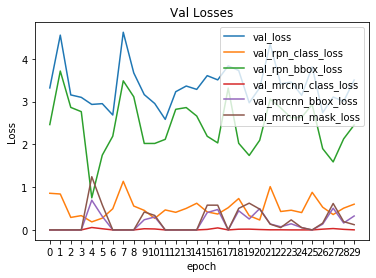

Train Loss 



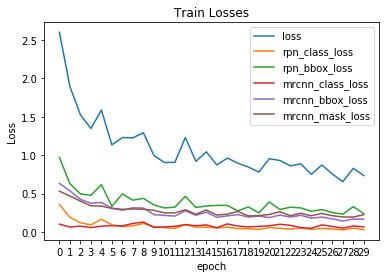

Fine tune Resnet stage 4 and up

Starting at epoch 0. LR=0.001

Checkpoint Path: /home/harsh/Mask_RCNN/logs/shapes20190825T2117/mask_rcnn_shapes_{epoch:04d}.h5
Selecting layers to train
res4a_branch2a         (Conv2D)
bn4a_branch2a          (BatchNorm)
res4a_branch2b         (Conv2D)
bn4a_branch2b          (BatchNorm)
res4a_branch2c         (Conv2D)
res4a_branch1          (Conv2D)
bn4a_branch2c          (BatchNorm)
bn4a_branch1           (BatchNorm)
res4b_branch2a         (Conv2D)
bn4b_branch2a          (BatchNorm)
res4b_branch2b         (Conv2D)
bn4b_branch2b          (BatchNorm)
res4b_branch2c         (Conv2D)
bn4b_branch2c          (BatchNorm)
res4c_branch2a         (Conv2D)
bn4c_branch2a          (BatchNorm)
res4c_branch2b         (Conv2D)
bn4c_branch2b          (BatchNorm)
res4c_branch2c         (Conv2D)
bn4c_branch2c          (BatchNorm)
res4d_branch2a         (Conv2D)
bn4d_branch2a          (BatchNorm)
res4d_branch2b         (Conv2D)
bn4d_branch2b          (BatchNorm)
res4d_bran

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 51/100 [==============>...............] - ETA: 1:27 - loss: 0.8447 - rpn_class_loss: 0.0304 - rpn_bbox_loss: 0.3012 - mrcnn_class_loss: 0.0811 - mrcnn_bbox_loss: 0.1998 - mrcnn_mask_loss: 0.2321

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 52/100 [==============>...............] - ETA: 1:25 - loss: 0.8388 - rpn_class_loss: 0.0300 - rpn_bbox_loss: 0.2996 - mrcnn_class_loss: 0.0800 - mrcnn_bbox_loss: 0.1991 - mrcnn_mask_loss: 0.2301

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 53/100 [==============>...............] - ETA: 1:22 - loss: 0.8323 - rpn_class_loss: 0.0297 - rpn_bbox_loss: 0.2989 - mrcnn_class_loss: 0.0789 - mrcnn_bbox_loss: 0.1970 - mrcnn_mask_loss: 0.2279

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 55/100 [===============>..............] - ETA: 1:17 - loss: 0.8174 - rpn_class_loss: 0.0291 - rpn_bbox_loss: 0.2960 - mrcnn_class_loss: 0.0768 - mrcnn_bbox_loss: 0.1923 - mrcnn_mask_loss: 0.2232

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 57/100 [================>.............] - ETA: 1:11 - loss: 0.8372 - rpn_class_loss: 0.0358 - rpn_bbox_loss: 0.2976 - mrcnn_class_loss: 0.0840 - mrcnn_bbox_loss: 0.1949 - mrcnn_mask_loss: 0.2249

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 59/100 [================>.............] - ETA: 1:07 - loss: 0.8806 - rpn_class_loss: 0.0421 - rpn_bbox_loss: 0.3060 - mrcnn_class_loss: 0.0991 - mrcnn_bbox_loss: 0.2015 - mrcnn_mask_loss: 0.2319

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 63/100 [=================>............] - ETA: 58s - loss: 0.9340 - rpn_class_loss: 0.0452 - rpn_bbox_loss: 0.3197 - mrcnn_class_loss: 0.1166 - mrcnn_bbox_loss: 0.2096 - mrcnn_mask_loss: 0.2429 

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


100/100 [==============================] - 127s 1s/step - loss: 0.8497 - rpn_class_loss: 0.0419 - rpn_bbox_loss: 0.2902 - mrcnn_class_loss: 0.0910 - mrcnn_bbox_loss: 0.1939 - mrcnn_mask_loss: 0.2326 - val_loss: 2.6936 - val_rpn_class_loss: 0.5836 - val_rpn_bbox_loss: 2.1100 - val_mrcnn_class_loss: 5.7697e-06 - val_mrcnn_bbox_loss: 0.0000e+00 - val_mrcnn_mask_loss: 0.0000e+00
Epoch 2/30
100/100 [==============================] - 65s 654ms/step - loss: 0.8130 - rpn_class_loss: 0.0540 - rpn_bbox_loss: 0.2559 - mrcnn_class_loss: 0.0709 - mrcnn_bbox_loss: 0.1898 - mrcnn_mask_loss: 0.2424 - val_loss: 3.6527 - val_rpn_class_loss: 0.4784 - val_rpn_bbox_loss: 3.1742 - val_mrcnn_class_loss: 3.9816e-06 - val_mrcnn_bbox_loss: 0.0000e+00 - val_mrcnn_mask_loss: 0.0000e+00
Epoch 3/30
100/100 [==============================] - 66s 658ms/step - loss: 0.6713 - rpn_class_loss: 0.0228 - rpn_bbox_loss: 0.2079 - mrcnn_class_loss: 0.0704 - mrcnn_bbox_loss: 0.1573 - mrcnn_mask_loss: 0.2128 - val_loss: 3.4099 

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 73/100 [====================>.........] - ETA: 18s - loss: 0.4898 - rpn_class_loss: 0.0132 - rpn_bbox_loss: 0.1348 - mrcnn_class_loss: 0.0441 - mrcnn_bbox_loss: 0.1077 - mrcnn_mask_loss: 0.1899

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 78/100 [======================>.......] - ETA: 14s - loss: 0.4984 - rpn_class_loss: 0.0137 - rpn_bbox_loss: 0.1379 - mrcnn_class_loss: 0.0453 - mrcnn_bbox_loss: 0.1117 - mrcnn_mask_loss: 0.1897

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 80/100 [=======================>......] - ETA: 13s - loss: 0.5165 - rpn_class_loss: 0.0161 - rpn_bbox_loss: 0.1482 - mrcnn_class_loss: 0.0464 - mrcnn_bbox_loss: 0.1140 - mrcnn_mask_loss: 0.1918

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 85/100 [========================>.....] - ETA: 9s - loss: 0.5297 - rpn_class_loss: 0.0184 - rpn_bbox_loss: 0.1544 - mrcnn_class_loss: 0.0477 - mrcnn_bbox_loss: 0.1163 - mrcnn_mask_loss: 0.1928 

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 90/100 [==========================>...] - ETA: 6s - loss: 0.5391 - rpn_class_loss: 0.0181 - rpn_bbox_loss: 0.1575 - mrcnn_class_loss: 0.0492 - mrcnn_bbox_loss: 0.1184 - mrcnn_mask_loss: 0.1959

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 91/100 [==========================>...] - ETA: 5s - loss: 0.5401 - rpn_class_loss: 0.0181 - rpn_bbox_loss: 0.1573 - mrcnn_class_loss: 0.0495 - mrcnn_bbox_loss: 0.1188 - mrcnn_mask_loss: 0.1963

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 95/100 [===========================>..] - ETA: 3s - loss: 0.5538 - rpn_class_loss: 0.0184 - rpn_bbox_loss: 0.1585 - mrcnn_class_loss: 0.0511 - mrcnn_bbox_loss: 0.1231 - mrcnn_mask_loss: 0.2027

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


100/100 [==============================] - 69s 687ms/step - loss: 0.5624 - rpn_class_loss: 0.0186 - rpn_bbox_loss: 0.1586 - mrcnn_class_loss: 0.0529 - mrcnn_bbox_loss: 0.1258 - mrcnn_mask_loss: 0.2065 - val_loss: 3.1122 - val_rpn_class_loss: 0.3788 - val_rpn_bbox_loss: 2.5013 - val_mrcnn_class_loss: 1.1902e-04 - val_mrcnn_bbox_loss: 0.1287 - val_mrcnn_mask_loss: 0.1033
Epoch 5/30
100/100 [==============================] - 67s 665ms/step - loss: 0.7455 - rpn_class_loss: 0.0482 - rpn_bbox_loss: 0.2380 - mrcnn_class_loss: 0.0774 - mrcnn_bbox_loss: 0.1464 - mrcnn_mask_loss: 0.2356 - val_loss: 2.9198 - val_rpn_class_loss: 0.2209 - val_rpn_bbox_loss: 0.8243 - val_mrcnn_class_loss: 0.0720 - val_mrcnn_bbox_loss: 0.3408 - val_mrcnn_mask_loss: 1.4619
Epoch 6/30
 25/100 [======>.......................] - ETA: 47s - loss: 0.5271 - rpn_class_loss: 0.0186 - rpn_bbox_loss: 0.1259 - mrcnn_class_loss: 0.0714 - mrcnn_bbox_loss: 0.1271 - mrcnn_mask_loss: 0.1842

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 31/100 [========>.....................] - ETA: 43s - loss: 0.5158 - rpn_class_loss: 0.0199 - rpn_bbox_loss: 0.1258 - mrcnn_class_loss: 0.0680 - mrcnn_bbox_loss: 0.1178 - mrcnn_mask_loss: 0.1842

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 38/100 [==========>...................] - ETA: 39s - loss: 0.5174 - rpn_class_loss: 0.0202 - rpn_bbox_loss: 0.1349 - mrcnn_class_loss: 0.0633 - mrcnn_bbox_loss: 0.1129 - mrcnn_mask_loss: 0.1860

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 43/100 [===========>..................] - ETA: 36s - loss: 0.5194 - rpn_class_loss: 0.0195 - rpn_bbox_loss: 0.1324 - mrcnn_class_loss: 0.0650 - mrcnn_bbox_loss: 0.1133 - mrcnn_mask_loss: 0.1892

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 44/100 [============>.................] - ETA: 35s - loss: 0.5138 - rpn_class_loss: 0.0195 - rpn_bbox_loss: 0.1311 - mrcnn_class_loss: 0.0644 - mrcnn_bbox_loss: 0.1113 - mrcnn_mask_loss: 0.1876

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 50/100 [==============>...............] - ETA: 31s - loss: 0.5031 - rpn_class_loss: 0.0186 - rpn_bbox_loss: 0.1280 - mrcnn_class_loss: 0.0618 - mrcnn_bbox_loss: 0.1090 - mrcnn_mask_loss: 0.1856

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 53/100 [==============>...............] - ETA: 29s - loss: 0.4959 - rpn_class_loss: 0.0182 - rpn_bbox_loss: 0.1270 - mrcnn_class_loss: 0.0595 - mrcnn_bbox_loss: 0.1067 - mrcnn_mask_loss: 0.1845

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 57/100 [================>.............] - ETA: 27s - loss: 0.4920 - rpn_class_loss: 0.0180 - rpn_bbox_loss: 0.1264 - mrcnn_class_loss: 0.0583 - mrcnn_bbox_loss: 0.1055 - mrcnn_mask_loss: 0.1838

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


100/100 [==============================] - 67s 672ms/step - loss: 0.5061 - rpn_class_loss: 0.0214 - rpn_bbox_loss: 0.1230 - mrcnn_class_loss: 0.0575 - mrcnn_bbox_loss: 0.1081 - mrcnn_mask_loss: 0.1962 - val_loss: 2.8759 - val_rpn_class_loss: 0.3369 - val_rpn_bbox_loss: 1.3221 - val_mrcnn_class_loss: 0.0389 - val_mrcnn_bbox_loss: 0.6499 - val_mrcnn_mask_loss: 0.5281
Epoch 7/30
100/100 [==============================] - 67s 674ms/step - loss: 0.5268 - rpn_class_loss: 0.0229 - rpn_bbox_loss: 0.1416 - mrcnn_class_loss: 0.0619 - mrcnn_bbox_loss: 0.1055 - mrcnn_mask_loss: 0.1948 - val_loss: 2.5717 - val_rpn_class_loss: 0.6547 - val_rpn_bbox_loss: 1.9170 - val_mrcnn_class_loss: 2.3842e-07 - val_mrcnn_bbox_loss: 0.0000e+00 - val_mrcnn_mask_loss: 0.0000e+00
Epoch 8/30
100/100 [==============================] - 67s 674ms/step - loss: 0.5034 - rpn_class_loss: 0.0127 - rpn_bbox_loss: 0.1347 - mrcnn_class_loss: 0.0602 - mrcnn_bbox_loss: 0.1093 - mrcnn_mask_loss: 0.1864 - val_loss: 4.2401 - val_rpn_

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 57/100 [================>.............] - ETA: 27s - loss: 0.4245 - rpn_class_loss: 0.0155 - rpn_bbox_loss: 0.1079 - mrcnn_class_loss: 0.0411 - mrcnn_bbox_loss: 0.0830 - mrcnn_mask_loss: 0.1769

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 68/100 [===================>..........] - ETA: 20s - loss: 0.4182 - rpn_class_loss: 0.0139 - rpn_bbox_loss: 0.1070 - mrcnn_class_loss: 0.0391 - mrcnn_bbox_loss: 0.0811 - mrcnn_mask_loss: 0.1771

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 75/100 [=====================>........] - ETA: 15s - loss: 0.4192 - rpn_class_loss: 0.0133 - rpn_bbox_loss: 0.1095 - mrcnn_class_loss: 0.0375 - mrcnn_bbox_loss: 0.0803 - mrcnn_mask_loss: 0.1786

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 77/100 [======================>.......] - ETA: 14s - loss: 0.4164 - rpn_class_loss: 0.0131 - rpn_bbox_loss: 0.1080 - mrcnn_class_loss: 0.0374 - mrcnn_bbox_loss: 0.0796 - mrcnn_mask_loss: 0.1782

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 82/100 [=======================>......] - ETA: 11s - loss: 0.4148 - rpn_class_loss: 0.0127 - rpn_bbox_loss: 0.1085 - mrcnn_class_loss: 0.0363 - mrcnn_bbox_loss: 0.0791 - mrcnn_mask_loss: 0.1783

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 86/100 [========================>.....] - ETA: 8s - loss: 0.4073 - rpn_class_loss: 0.0122 - rpn_bbox_loss: 0.1071 - mrcnn_class_loss: 0.0350 - mrcnn_bbox_loss: 0.0777 - mrcnn_mask_loss: 0.1753

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 95/100 [===========================>..] - ETA: 3s - loss: 0.4018 - rpn_class_loss: 0.0115 - rpn_bbox_loss: 0.1086 - mrcnn_class_loss: 0.0335 - mrcnn_bbox_loss: 0.0755 - mrcnn_mask_loss: 0.1728

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


100/100 [==============================] - 67s 666ms/step - loss: 0.4033 - rpn_class_loss: 0.0114 - rpn_bbox_loss: 0.1091 - mrcnn_class_loss: 0.0329 - mrcnn_bbox_loss: 0.0762 - mrcnn_mask_loss: 0.1737 - val_loss: 3.2354 - val_rpn_class_loss: 0.3289 - val_rpn_bbox_loss: 1.9090 - val_mrcnn_class_loss: 0.0404 - val_mrcnn_bbox_loss: 0.4434 - val_mrcnn_mask_loss: 0.5137
Epoch 11/30
100/100 [==============================] - 67s 666ms/step - loss: 0.4343 - rpn_class_loss: 0.0127 - rpn_bbox_loss: 0.1126 - mrcnn_class_loss: 0.0394 - mrcnn_bbox_loss: 0.0917 - mrcnn_mask_loss: 0.1779 - val_loss: 2.8311 - val_rpn_class_loss: 0.4228 - val_rpn_bbox_loss: 1.7474 - val_mrcnn_class_loss: 0.0466 - val_mrcnn_bbox_loss: 0.2337 - val_mrcnn_mask_loss: 0.3807
Epoch 12/30
 97/100 [============================>.] - ETA: 1s - loss: 0.3767 - rpn_class_loss: 0.0181 - rpn_bbox_loss: 0.0822 - mrcnn_class_loss: 0.0475 - mrcnn_bbox_loss: 0.0699 - mrcnn_mask_loss: 0.1590

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 98/100 [============================>.] - ETA: 1s - loss: 0.3749 - rpn_class_loss: 0.0179 - rpn_bbox_loss: 0.0819 - mrcnn_class_loss: 0.0471 - mrcnn_bbox_loss: 0.0695 - mrcnn_mask_loss: 0.1585

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


100/100 [==============================] - 68s 675ms/step - loss: 0.3720 - rpn_class_loss: 0.0178 - rpn_bbox_loss: 0.0810 - mrcnn_class_loss: 0.0466 - mrcnn_bbox_loss: 0.0687 - mrcnn_mask_loss: 0.1579 - val_loss: 2.9718 - val_rpn_class_loss: 0.5508 - val_rpn_bbox_loss: 1.7041 - val_mrcnn_class_loss: 0.0112 - val_mrcnn_bbox_loss: 0.4132 - val_mrcnn_mask_loss: 0.2926
Epoch 13/30
  4/100 [>.............................] - ETA: 58s - loss: 0.5439 - rpn_class_loss: 0.0136 - rpn_bbox_loss: 0.1061 - mrcnn_class_loss: 0.1381 - mrcnn_bbox_loss: 0.0972 - mrcnn_mask_loss: 0.1889 

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 16/100 [===>..........................] - ETA: 51s - loss: 0.6763 - rpn_class_loss: 0.0174 - rpn_bbox_loss: 0.1862 - mrcnn_class_loss: 0.1167 - mrcnn_bbox_loss: 0.1349 - mrcnn_mask_loss: 0.2211

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 19/100 [====>.........................] - ETA: 50s - loss: 0.6908 - rpn_class_loss: 0.0163 - rpn_bbox_loss: 0.1951 - mrcnn_class_loss: 0.1252 - mrcnn_bbox_loss: 0.1327 - mrcnn_mask_loss: 0.2215

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 23/100 [=====>........................] - ETA: 47s - loss: 0.7169 - rpn_class_loss: 0.0167 - rpn_bbox_loss: 0.1991 - mrcnn_class_loss: 0.1258 - mrcnn_bbox_loss: 0.1431 - mrcnn_mask_loss: 0.2322

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 26/100 [======>.......................] - ETA: 45s - loss: 0.7262 - rpn_class_loss: 0.0173 - rpn_bbox_loss: 0.1948 - mrcnn_class_loss: 0.1316 - mrcnn_bbox_loss: 0.1448 - mrcnn_mask_loss: 0.2378

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 33/100 [========>.....................] - ETA: 41s - loss: 0.6654 - rpn_class_loss: 0.0156 - rpn_bbox_loss: 0.1746 - mrcnn_class_loss: 0.1135 - mrcnn_bbox_loss: 0.1322 - mrcnn_mask_loss: 0.2295

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


100/100 [==============================] - 66s 661ms/step - loss: 0.5911 - rpn_class_loss: 0.0299 - rpn_bbox_loss: 0.1939 - mrcnn_class_loss: 0.0687 - mrcnn_bbox_loss: 0.1013 - mrcnn_mask_loss: 0.1973 - val_loss: 3.5954 - val_rpn_class_loss: 0.5703 - val_rpn_bbox_loss: 2.5855 - val_mrcnn_class_loss: 0.0131 - val_mrcnn_bbox_loss: 0.1926 - val_mrcnn_mask_loss: 0.2339
Epoch 14/30
100/100 [==============================] - 69s 686ms/step - loss: 0.3921 - rpn_class_loss: 0.0106 - rpn_bbox_loss: 0.1071 - mrcnn_class_loss: 0.0421 - mrcnn_bbox_loss: 0.0736 - mrcnn_mask_loss: 0.1587 - val_loss: 3.5349 - val_rpn_class_loss: 0.5801 - val_rpn_bbox_loss: 2.9043 - val_mrcnn_class_loss: 0.0039 - val_mrcnn_bbox_loss: 0.0184 - val_mrcnn_mask_loss: 0.0281
Epoch 15/30
 42/100 [===========>..................] - ETA: 35s - loss: 0.5025 - rpn_class_loss: 0.0150 - rpn_bbox_loss: 0.1269 - mrcnn_class_loss: 0.0517 - mrcnn_bbox_loss: 0.1053 - mrcnn_mask_loss: 0.2035

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 49/100 [=============>................] - ETA: 31s - loss: 0.4971 - rpn_class_loss: 0.0139 - rpn_bbox_loss: 0.1212 - mrcnn_class_loss: 0.0516 - mrcnn_bbox_loss: 0.1048 - mrcnn_mask_loss: 0.2056

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 52/100 [==============>...............] - ETA: 29s - loss: 0.5144 - rpn_class_loss: 0.0148 - rpn_bbox_loss: 0.1218 - mrcnn_class_loss: 0.0586 - mrcnn_bbox_loss: 0.1085 - mrcnn_mask_loss: 0.2107

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 62/100 [=================>............] - ETA: 23s - loss: 0.5140 - rpn_class_loss: 0.0147 - rpn_bbox_loss: 0.1185 - mrcnn_class_loss: 0.0644 - mrcnn_bbox_loss: 0.1073 - mrcnn_mask_loss: 0.2091

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 69/100 [===================>..........] - ETA: 19s - loss: 0.5184 - rpn_class_loss: 0.0136 - rpn_bbox_loss: 0.1179 - mrcnn_class_loss: 0.0681 - mrcnn_bbox_loss: 0.1077 - mrcnn_mask_loss: 0.2110

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 72/100 [====================>.........] - ETA: 17s - loss: 0.5093 - rpn_class_loss: 0.0131 - rpn_bbox_loss: 0.1158 - mrcnn_class_loss: 0.0663 - mrcnn_bbox_loss: 0.1058 - mrcnn_mask_loss: 0.2085

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 76/100 [=====================>........] - ETA: 15s - loss: 0.5134 - rpn_class_loss: 0.0129 - rpn_bbox_loss: 0.1161 - mrcnn_class_loss: 0.0678 - mrcnn_bbox_loss: 0.1068 - mrcnn_mask_loss: 0.2098

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 79/100 [======================>.......] - ETA: 13s - loss: 0.5047 - rpn_class_loss: 0.0126 - rpn_bbox_loss: 0.1141 - mrcnn_class_loss: 0.0661 - mrcnn_bbox_loss: 0.1045 - mrcnn_mask_loss: 0.2074

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


100/100 [==============================] - 66s 656ms/step - loss: 0.4688 - rpn_class_loss: 0.0105 - rpn_bbox_loss: 0.1055 - mrcnn_class_loss: 0.0593 - mrcnn_bbox_loss: 0.0964 - mrcnn_mask_loss: 0.1971 - val_loss: 3.8975 - val_rpn_class_loss: 1.1514 - val_rpn_bbox_loss: 2.7461 - val_mrcnn_class_loss: 0.0000e+00 - val_mrcnn_bbox_loss: 0.0000e+00 - val_mrcnn_mask_loss: 0.0000e+00
Epoch 16/30
100/100 [==============================] - 69s 688ms/step - loss: 0.3810 - rpn_class_loss: 0.0182 - rpn_bbox_loss: 0.1128 - mrcnn_class_loss: 0.0281 - mrcnn_bbox_loss: 0.0714 - mrcnn_mask_loss: 0.1504 - val_loss: 4.4316 - val_rpn_class_loss: 0.9268 - val_rpn_bbox_loss: 2.4073 - val_mrcnn_class_loss: 0.0108 - val_mrcnn_bbox_loss: 0.4890 - val_mrcnn_mask_loss: 0.5977
Epoch 17/30
100/100 [==============================] - 66s 660ms/step - loss: 0.4053 - rpn_class_loss: 0.0105 - rpn_bbox_loss: 0.0997 - mrcnn_class_loss: 0.0661 - mrcnn_bbox_loss: 0.0719 - mrcnn_mask_loss: 0.1572 - val_loss: 3.2575 - val_rp

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 44/100 [============>.................] - ETA: 35s - loss: 0.3526 - rpn_class_loss: 0.0048 - rpn_bbox_loss: 0.0775 - mrcnn_class_loss: 0.0445 - mrcnn_bbox_loss: 0.0712 - mrcnn_mask_loss: 0.1546

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 46/100 [============>.................] - ETA: 34s - loss: 0.3444 - rpn_class_loss: 0.0047 - rpn_bbox_loss: 0.0749 - mrcnn_class_loss: 0.0429 - mrcnn_bbox_loss: 0.0699 - mrcnn_mask_loss: 0.1520

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 59/100 [================>.............] - ETA: 26s - loss: 0.3659 - rpn_class_loss: 0.0096 - rpn_bbox_loss: 0.0824 - mrcnn_class_loss: 0.0432 - mrcnn_bbox_loss: 0.0724 - mrcnn_mask_loss: 0.1583

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 65/100 [==================>...........] - ETA: 22s - loss: 0.3673 - rpn_class_loss: 0.0096 - rpn_bbox_loss: 0.0829 - mrcnn_class_loss: 0.0421 - mrcnn_bbox_loss: 0.0714 - mrcnn_mask_loss: 0.1613

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 71/100 [====================>.........] - ETA: 18s - loss: 0.3689 - rpn_class_loss: 0.0091 - rpn_bbox_loss: 0.0808 - mrcnn_class_loss: 0.0423 - mrcnn_bbox_loss: 0.0711 - mrcnn_mask_loss: 0.1657

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 72/100 [====================>.........] - ETA: 17s - loss: 0.3690 - rpn_class_loss: 0.0090 - rpn_bbox_loss: 0.0805 - mrcnn_class_loss: 0.0428 - mrcnn_bbox_loss: 0.0711 - mrcnn_mask_loss: 0.1656

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 74/100 [=====================>........] - ETA: 16s - loss: 0.3699 - rpn_class_loss: 0.0091 - rpn_bbox_loss: 0.0812 - mrcnn_class_loss: 0.0425 - mrcnn_bbox_loss: 0.0714 - mrcnn_mask_loss: 0.1658

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


100/100 [==============================] - 67s 666ms/step - loss: 0.3686 - rpn_class_loss: 0.0080 - rpn_bbox_loss: 0.0811 - mrcnn_class_loss: 0.0416 - mrcnn_bbox_loss: 0.0713 - mrcnn_mask_loss: 0.1665 - val_loss: 5.2234 - val_rpn_class_loss: 1.5190 - val_rpn_bbox_loss: 3.4059 - val_mrcnn_class_loss: 0.0177 - val_mrcnn_bbox_loss: 0.0970 - val_mrcnn_mask_loss: 0.1837
Epoch 19/30
 78/100 [======================>.......] - ETA: 13s - loss: 0.3133 - rpn_class_loss: 0.0059 - rpn_bbox_loss: 0.0788 - mrcnn_class_loss: 0.0332 - mrcnn_bbox_loss: 0.0563 - mrcnn_mask_loss: 0.1392

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 87/100 [=========================>....] - ETA: 8s - loss: 0.3048 - rpn_class_loss: 0.0057 - rpn_bbox_loss: 0.0765 - mrcnn_class_loss: 0.0313 - mrcnn_bbox_loss: 0.0552 - mrcnn_mask_loss: 0.1362

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 92/100 [==========================>...] - ETA: 5s - loss: 0.2997 - rpn_class_loss: 0.0057 - rpn_bbox_loss: 0.0752 - mrcnn_class_loss: 0.0300 - mrcnn_bbox_loss: 0.0534 - mrcnn_mask_loss: 0.1354

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


100/100 [==============================] - 67s 666ms/step - loss: 0.2984 - rpn_class_loss: 0.0061 - rpn_bbox_loss: 0.0754 - mrcnn_class_loss: 0.0297 - mrcnn_bbox_loss: 0.0534 - mrcnn_mask_loss: 0.1337 - val_loss: 3.9793 - val_rpn_class_loss: 0.9218 - val_rpn_bbox_loss: 2.3015 - val_mrcnn_class_loss: 0.0716 - val_mrcnn_bbox_loss: 0.2221 - val_mrcnn_mask_loss: 0.4623
Epoch 20/30
  5/100 [>.............................] - ETA: 1:00 - loss: 0.4415 - rpn_class_loss: 0.0081 - rpn_bbox_loss: 0.1302 - mrcnn_class_loss: 0.0370 - mrcnn_bbox_loss: 0.0958 - mrcnn_mask_loss: 0.1704

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


  9/100 [=>............................] - ETA: 58s - loss: 0.2996 - rpn_class_loss: 0.0053 - rpn_bbox_loss: 0.0783 - mrcnn_class_loss: 0.0239 - mrcnn_bbox_loss: 0.0624 - mrcnn_mask_loss: 0.1297

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 12/100 [==>...........................] - ETA: 56s - loss: 0.3891 - rpn_class_loss: 0.0081 - rpn_bbox_loss: 0.0961 - mrcnn_class_loss: 0.0400 - mrcnn_bbox_loss: 0.0852 - mrcnn_mask_loss: 0.1598

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 14/100 [===>..........................] - ETA: 54s - loss: 0.3701 - rpn_class_loss: 0.0083 - rpn_bbox_loss: 0.0931 - mrcnn_class_loss: 0.0372 - mrcnn_bbox_loss: 0.0785 - mrcnn_mask_loss: 0.1529

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 23/100 [=====>........................] - ETA: 48s - loss: 0.3694 - rpn_class_loss: 0.0064 - rpn_bbox_loss: 0.0902 - mrcnn_class_loss: 0.0427 - mrcnn_bbox_loss: 0.0783 - mrcnn_mask_loss: 0.1519

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


100/100 [==============================] - 67s 673ms/step - loss: 0.3351 - rpn_class_loss: 0.0053 - rpn_bbox_loss: 0.0811 - mrcnn_class_loss: 0.0384 - mrcnn_bbox_loss: 0.0632 - mrcnn_mask_loss: 0.1469 - val_loss: 3.0391 - val_rpn_class_loss: 0.4192 - val_rpn_bbox_loss: 1.6277 - val_mrcnn_class_loss: 0.0565 - val_mrcnn_bbox_loss: 0.3403 - val_mrcnn_mask_loss: 0.5953
Epoch 21/30
100/100 [==============================] - 67s 674ms/step - loss: 0.3613 - rpn_class_loss: 0.0108 - rpn_bbox_loss: 0.0953 - mrcnn_class_loss: 0.0397 - mrcnn_bbox_loss: 0.0633 - mrcnn_mask_loss: 0.1521 - val_loss: 2.7185 - val_rpn_class_loss: 0.4235 - val_rpn_bbox_loss: 2.0619 - val_mrcnn_class_loss: 0.0169 - val_mrcnn_bbox_loss: 0.0510 - val_mrcnn_mask_loss: 0.1652
Epoch 22/30
 34/100 [=========>....................] - ETA: 43s - loss: 0.5475 - rpn_class_loss: 0.0072 - rpn_bbox_loss: 0.1455 - mrcnn_class_loss: 0.0794 - mrcnn_bbox_loss: 0.1082 - mrcnn_mask_loss: 0.2073

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 42/100 [===========>..................] - ETA: 38s - loss: 0.5269 - rpn_class_loss: 0.0065 - rpn_bbox_loss: 0.1340 - mrcnn_class_loss: 0.0747 - mrcnn_bbox_loss: 0.1046 - mrcnn_mask_loss: 0.2071

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 47/100 [=============>................] - ETA: 34s - loss: 0.5155 - rpn_class_loss: 0.0062 - rpn_bbox_loss: 0.1306 - mrcnn_class_loss: 0.0687 - mrcnn_bbox_loss: 0.1044 - mrcnn_mask_loss: 0.2056

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 60/100 [=================>............] - ETA: 26s - loss: 0.4714 - rpn_class_loss: 0.0058 - rpn_bbox_loss: 0.1183 - mrcnn_class_loss: 0.0585 - mrcnn_bbox_loss: 0.0959 - mrcnn_mask_loss: 0.1930

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 64/100 [==================>...........] - ETA: 23s - loss: 0.4726 - rpn_class_loss: 0.0057 - rpn_bbox_loss: 0.1177 - mrcnn_class_loss: 0.0577 - mrcnn_bbox_loss: 0.0959 - mrcnn_mask_loss: 0.1955

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 69/100 [===================>..........] - ETA: 20s - loss: 0.4605 - rpn_class_loss: 0.0056 - rpn_bbox_loss: 0.1142 - mrcnn_class_loss: 0.0564 - mrcnn_bbox_loss: 0.0923 - mrcnn_mask_loss: 0.1921

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 75/100 [=====================>........] - ETA: 16s - loss: 0.4453 - rpn_class_loss: 0.0055 - rpn_bbox_loss: 0.1118 - mrcnn_class_loss: 0.0529 - mrcnn_bbox_loss: 0.0884 - mrcnn_mask_loss: 0.1867

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 78/100 [======================>.......] - ETA: 14s - loss: 0.4417 - rpn_class_loss: 0.0054 - rpn_bbox_loss: 0.1099 - mrcnn_class_loss: 0.0512 - mrcnn_bbox_loss: 0.0878 - mrcnn_mask_loss: 0.1874

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


100/100 [==============================] - 68s 676ms/step - loss: 0.4286 - rpn_class_loss: 0.0061 - rpn_bbox_loss: 0.1044 - mrcnn_class_loss: 0.0516 - mrcnn_bbox_loss: 0.0816 - mrcnn_mask_loss: 0.1848 - val_loss: 4.1452 - val_rpn_class_loss: 1.0765 - val_rpn_bbox_loss: 2.8004 - val_mrcnn_class_loss: 0.0291 - val_mrcnn_bbox_loss: 0.1222 - val_mrcnn_mask_loss: 0.1170
Epoch 23/30
100/100 [==============================] - 66s 664ms/step - loss: 0.3226 - rpn_class_loss: 0.0060 - rpn_bbox_loss: 0.0849 - mrcnn_class_loss: 0.0416 - mrcnn_bbox_loss: 0.0552 - mrcnn_mask_loss: 0.1349 - val_loss: 4.6299 - val_rpn_class_loss: 1.2637 - val_rpn_bbox_loss: 3.1061 - val_mrcnn_class_loss: 0.0279 - val_mrcnn_bbox_loss: 0.1248 - val_mrcnn_mask_loss: 0.1074
Epoch 24/30
100/100 [==============================] - 66s 664ms/step - loss: 0.3123 - rpn_class_loss: 0.0045 - rpn_bbox_loss: 0.0777 - mrcnn_class_loss: 0.0269 - mrcnn_bbox_loss: 0.0587 - mrcnn_mask_loss: 0.1445 - val_loss: 4.1443 - val_rpn_class_loss

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 76/100 [=====================>........] - ETA: 15s - loss: 0.2628 - rpn_class_loss: 0.0039 - rpn_bbox_loss: 0.0583 - mrcnn_class_loss: 0.0192 - mrcnn_bbox_loss: 0.0468 - mrcnn_mask_loss: 0.1345

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 81/100 [=======================>......] - ETA: 12s - loss: 0.2654 - rpn_class_loss: 0.0043 - rpn_bbox_loss: 0.0598 - mrcnn_class_loss: 0.0196 - mrcnn_bbox_loss: 0.0476 - mrcnn_mask_loss: 0.1340

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 90/100 [==========================>...] - ETA: 6s - loss: 0.2575 - rpn_class_loss: 0.0042 - rpn_bbox_loss: 0.0576 - mrcnn_class_loss: 0.0195 - mrcnn_bbox_loss: 0.0458 - mrcnn_mask_loss: 0.1304

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


100/100 [==============================] - 68s 682ms/step - loss: 0.2572 - rpn_class_loss: 0.0042 - rpn_bbox_loss: 0.0569 - mrcnn_class_loss: 0.0206 - mrcnn_bbox_loss: 0.0463 - mrcnn_mask_loss: 0.1292 - val_loss: 3.5649 - val_rpn_class_loss: 0.7816 - val_rpn_bbox_loss: 2.4203 - val_mrcnn_class_loss: 0.0364 - val_mrcnn_bbox_loss: 0.1901 - val_mrcnn_mask_loss: 0.1364
Epoch 26/30
  2/100 [..............................] - ETA: 59s - loss: 0.2228 - rpn_class_loss: 0.0050 - rpn_bbox_loss: 0.0369 - mrcnn_class_loss: 0.0331 - mrcnn_bbox_loss: 0.0406 - mrcnn_mask_loss: 0.1071 

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 12/100 [==>...........................] - ETA: 55s - loss: 0.2231 - rpn_class_loss: 0.0037 - rpn_bbox_loss: 0.0428 - mrcnn_class_loss: 0.0267 - mrcnn_bbox_loss: 0.0378 - mrcnn_mask_loss: 0.1121

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 13/100 [==>...........................] - ETA: 54s - loss: 0.2134 - rpn_class_loss: 0.0035 - rpn_bbox_loss: 0.0408 - mrcnn_class_loss: 0.0250 - mrcnn_bbox_loss: 0.0356 - mrcnn_mask_loss: 0.1085

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 16/100 [===>..........................] - ETA: 52s - loss: 0.2896 - rpn_class_loss: 0.0057 - rpn_bbox_loss: 0.0618 - mrcnn_class_loss: 0.0417 - mrcnn_bbox_loss: 0.0459 - mrcnn_mask_loss: 0.1345

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


100/100 [==============================] - 66s 659ms/step - loss: 0.3289 - rpn_class_loss: 0.0053 - rpn_bbox_loss: 0.0709 - mrcnn_class_loss: 0.0490 - mrcnn_bbox_loss: 0.0546 - mrcnn_mask_loss: 0.1491 - val_loss: 4.0472 - val_rpn_class_loss: 0.7845 - val_rpn_bbox_loss: 2.8283 - val_mrcnn_class_loss: 0.0109 - val_mrcnn_bbox_loss: 0.2189 - val_mrcnn_mask_loss: 0.2047
Epoch 27/30
100/100 [==============================] - 66s 663ms/step - loss: 0.3442 - rpn_class_loss: 0.0096 - rpn_bbox_loss: 0.0970 - mrcnn_class_loss: 0.0300 - mrcnn_bbox_loss: 0.0648 - mrcnn_mask_loss: 0.1427 - val_loss: 3.3505 - val_rpn_class_loss: 0.4443 - val_rpn_bbox_loss: 1.9346 - val_mrcnn_class_loss: 0.0153 - val_mrcnn_bbox_loss: 0.5603 - val_mrcnn_mask_loss: 0.3960
Epoch 28/30
 22/100 [=====>........................] - ETA: 48s - loss: 0.2731 - rpn_class_loss: 0.0041 - rpn_bbox_loss: 0.0841 - mrcnn_class_loss: 0.0245 - mrcnn_bbox_loss: 0.0447 - mrcnn_mask_loss: 0.1158

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 33/100 [========>.....................] - ETA: 42s - loss: 0.2674 - rpn_class_loss: 0.0052 - rpn_bbox_loss: 0.0769 - mrcnn_class_loss: 0.0225 - mrcnn_bbox_loss: 0.0441 - mrcnn_mask_loss: 0.1187

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 36/100 [=========>....................] - ETA: 40s - loss: 0.2613 - rpn_class_loss: 0.0050 - rpn_bbox_loss: 0.0733 - mrcnn_class_loss: 0.0218 - mrcnn_bbox_loss: 0.0427 - mrcnn_mask_loss: 0.1185

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 44/100 [============>.................] - ETA: 35s - loss: 0.2530 - rpn_class_loss: 0.0044 - rpn_bbox_loss: 0.0680 - mrcnn_class_loss: 0.0208 - mrcnn_bbox_loss: 0.0428 - mrcnn_mask_loss: 0.1169

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 55/100 [===============>..............] - ETA: 28s - loss: 0.2598 - rpn_class_loss: 0.0039 - rpn_bbox_loss: 0.0682 - mrcnn_class_loss: 0.0225 - mrcnn_bbox_loss: 0.0426 - mrcnn_mask_loss: 0.1224

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 68/100 [===================>..........] - ETA: 20s - loss: 0.2702 - rpn_class_loss: 0.0037 - rpn_bbox_loss: 0.0683 - mrcnn_class_loss: 0.0217 - mrcnn_bbox_loss: 0.0453 - mrcnn_mask_loss: 0.1312

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 70/100 [====================>.........] - ETA: 19s - loss: 0.2686 - rpn_class_loss: 0.0036 - rpn_bbox_loss: 0.0675 - mrcnn_class_loss: 0.0214 - mrcnn_bbox_loss: 0.0450 - mrcnn_mask_loss: 0.1312

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 72/100 [====================>.........] - ETA: 18s - loss: 0.2686 - rpn_class_loss: 0.0036 - rpn_bbox_loss: 0.0674 - mrcnn_class_loss: 0.0210 - mrcnn_bbox_loss: 0.0462 - mrcnn_mask_loss: 0.1304

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


100/100 [==============================] - 68s 682ms/step - loss: 0.2673 - rpn_class_loss: 0.0035 - rpn_bbox_loss: 0.0704 - mrcnn_class_loss: 0.0189 - mrcnn_bbox_loss: 0.0461 - mrcnn_mask_loss: 0.1284 - val_loss: 2.4846 - val_rpn_class_loss: 0.2409 - val_rpn_bbox_loss: 1.1051 - val_mrcnn_class_loss: 0.0657 - val_mrcnn_bbox_loss: 0.3444 - val_mrcnn_mask_loss: 0.7287
Epoch 29/30
100/100 [==============================] - 66s 664ms/step - loss: 0.3791 - rpn_class_loss: 0.0074 - rpn_bbox_loss: 0.1026 - mrcnn_class_loss: 0.0474 - mrcnn_bbox_loss: 0.0662 - mrcnn_mask_loss: 0.1555 - val_loss: 2.7688 - val_rpn_class_loss: 0.7137 - val_rpn_bbox_loss: 1.7573 - val_mrcnn_class_loss: 0.0250 - val_mrcnn_bbox_loss: 0.0747 - val_mrcnn_mask_loss: 0.1982
Epoch 30/30
 55/100 [===============>..............] - ETA: 28s - loss: 0.2708 - rpn_class_loss: 0.0031 - rpn_bbox_loss: 0.0587 - mrcnn_class_loss: 0.0308 - mrcnn_bbox_loss: 0.0472 - mrcnn_mask_loss: 0.1310

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 59/100 [================>.............] - ETA: 26s - loss: 0.2782 - rpn_class_loss: 0.0038 - rpn_bbox_loss: 0.0604 - mrcnn_class_loss: 0.0329 - mrcnn_bbox_loss: 0.0482 - mrcnn_mask_loss: 0.1330

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 69/100 [===================>..........] - ETA: 19s - loss: 0.2921 - rpn_class_loss: 0.0044 - rpn_bbox_loss: 0.0648 - mrcnn_class_loss: 0.0336 - mrcnn_bbox_loss: 0.0512 - mrcnn_mask_loss: 0.1380

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 74/100 [=====================>........] - ETA: 16s - loss: 0.2933 - rpn_class_loss: 0.0043 - rpn_bbox_loss: 0.0639 - mrcnn_class_loss: 0.0346 - mrcnn_bbox_loss: 0.0510 - mrcnn_mask_loss: 0.1396

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 86/100 [========================>.....] - ETA: 8s - loss: 0.2963 - rpn_class_loss: 0.0045 - rpn_bbox_loss: 0.0636 - mrcnn_class_loss: 0.0348 - mrcnn_bbox_loss: 0.0524 - mrcnn_mask_loss: 0.1411

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


100/100 [==============================] - 67s 669ms/step - loss: 0.3000 - rpn_class_loss: 0.0044 - rpn_bbox_loss: 0.0661 - mrcnn_class_loss: 0.0338 - mrcnn_bbox_loss: 0.0562 - mrcnn_mask_loss: 0.1395 - val_loss: 3.3903 - val_rpn_class_loss: 1.1684 - val_rpn_bbox_loss: 2.0863 - val_mrcnn_class_loss: 0.0096 - val_mrcnn_bbox_loss: 0.0560 - val_mrcnn_mask_loss: 0.0701
Validation Loss 



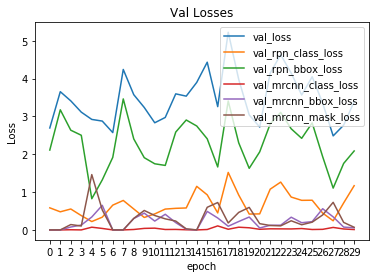

Train Loss 



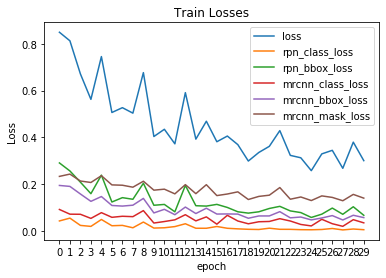

Fine tune all layers

Starting at epoch 0. LR=0.0001

Checkpoint Path: /home/harsh/Mask_RCNN/logs/shapes20190825T2117/mask_rcnn_shapes_{epoch:04d}.h5
Selecting layers to train
conv1                  (Conv2D)
bn_conv1               (BatchNorm)
res2a_branch2a         (Conv2D)
bn2a_branch2a          (BatchNorm)
res2a_branch2b         (Conv2D)
bn2a_branch2b          (BatchNorm)
res2a_branch2c         (Conv2D)
res2a_branch1          (Conv2D)
bn2a_branch2c          (BatchNorm)
bn2a_branch1           (BatchNorm)
res2b_branch2a         (Conv2D)
bn2b_branch2a          (BatchNorm)
res2b_branch2b         (Conv2D)
bn2b_branch2b          (BatchNorm)
res2b_branch2c         (Conv2D)
bn2b_branch2c          (BatchNorm)
res2c_branch2a         (Conv2D)
bn2c_branch2a          (BatchNorm)
res2c_branch2b         (Conv2D)
bn2c_branch2b          (BatchNorm)
res2c_branch2c         (Conv2D)
bn2c_branch2c          (BatchNorm)
res3a_branch2a         (Conv2D)
bn3a_branch2a          (BatchNorm)
res3a_branch2b      

Epoch 1/30
 48/100 [=============>................] - ETA: 1:42 - loss: 0.4617 - rpn_class_loss: 0.0093 - rpn_bbox_loss: 0.1268 - mrcnn_class_loss: 0.0474 - mrcnn_bbox_loss: 0.0945 - mrcnn_mask_loss: 0.1837

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 50/100 [==============>...............] - ETA: 1:36 - loss: 0.4509 - rpn_class_loss: 0.0090 - rpn_bbox_loss: 0.1231 - mrcnn_class_loss: 0.0460 - mrcnn_bbox_loss: 0.0920 - mrcnn_mask_loss: 0.1808

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 52/100 [==============>...............] - ETA: 1:30 - loss: 0.4576 - rpn_class_loss: 0.0090 - rpn_bbox_loss: 0.1236 - mrcnn_class_loss: 0.0508 - mrcnn_bbox_loss: 0.0926 - mrcnn_mask_loss: 0.1815

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 53/100 [==============>...............] - ETA: 1:27 - loss: 0.4522 - rpn_class_loss: 0.0089 - rpn_bbox_loss: 0.1219 - mrcnn_class_loss: 0.0500 - mrcnn_bbox_loss: 0.0913 - mrcnn_mask_loss: 0.1800

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 56/100 [===============>..............] - ETA: 1:19 - loss: 0.4365 - rpn_class_loss: 0.0085 - rpn_bbox_loss: 0.1169 - mrcnn_class_loss: 0.0480 - mrcnn_bbox_loss: 0.0877 - mrcnn_mask_loss: 0.1754

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 58/100 [================>.............] - ETA: 1:13 - loss: 0.4414 - rpn_class_loss: 0.0086 - rpn_bbox_loss: 0.1172 - mrcnn_class_loss: 0.0519 - mrcnn_bbox_loss: 0.0880 - mrcnn_mask_loss: 0.1757

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 60/100 [=================>............] - ETA: 1:08 - loss: 0.4605 - rpn_class_loss: 0.0088 - rpn_bbox_loss: 0.1209 - mrcnn_class_loss: 0.0608 - mrcnn_bbox_loss: 0.0907 - mrcnn_mask_loss: 0.1793

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 63/100 [=================>............] - ETA: 1:01 - loss: 0.4830 - rpn_class_loss: 0.0090 - rpn_bbox_loss: 0.1255 - mrcnn_class_loss: 0.0711 - mrcnn_bbox_loss: 0.0934 - mrcnn_mask_loss: 0.1840

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


100/100 [==============================] - 136s 1s/step - loss: 0.4220 - rpn_class_loss: 0.0075 - rpn_bbox_loss: 0.1150 - mrcnn_class_loss: 0.0512 - mrcnn_bbox_loss: 0.0768 - mrcnn_mask_loss: 0.1715 - val_loss: 2.2743 - val_rpn_class_loss: 0.3723 - val_rpn_bbox_loss: 1.9019 - val_mrcnn_class_loss: 0.0000e+00 - val_mrcnn_bbox_loss: 0.0000e+00 - val_mrcnn_mask_loss: 0.0000e+00
Epoch 2/30
100/100 [==============================] - 73s 734ms/step - loss: 0.3548 - rpn_class_loss: 0.0065 - rpn_bbox_loss: 0.0866 - mrcnn_class_loss: 0.0304 - mrcnn_bbox_loss: 0.0757 - mrcnn_mask_loss: 0.1556 - val_loss: 5.2750 - val_rpn_class_loss: 1.3541 - val_rpn_bbox_loss: 3.3745 - val_mrcnn_class_loss: 0.0486 - val_mrcnn_bbox_loss: 0.2315 - val_mrcnn_mask_loss: 0.2662
Epoch 3/30
100/100 [==============================] - 74s 738ms/step - loss: 0.2959 - rpn_class_loss: 0.0041 - rpn_bbox_loss: 0.0637 - mrcnn_class_loss: 0.0265 - mrcnn_bbox_loss: 0.0539 - mrcnn_mask_loss: 0.1478 - val_loss: 3.7695 - val_rpn_cl

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 74/100 [=====================>........] - ETA: 19s - loss: 0.2554 - rpn_class_loss: 0.0029 - rpn_bbox_loss: 0.0561 - mrcnn_class_loss: 0.0187 - mrcnn_bbox_loss: 0.0440 - mrcnn_mask_loss: 0.1336

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 78/100 [======================>.......] - ETA: 16s - loss: 0.2638 - rpn_class_loss: 0.0032 - rpn_bbox_loss: 0.0599 - mrcnn_class_loss: 0.0196 - mrcnn_bbox_loss: 0.0460 - mrcnn_mask_loss: 0.1351

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 81/100 [=======================>......] - ETA: 14s - loss: 0.2694 - rpn_class_loss: 0.0033 - rpn_bbox_loss: 0.0633 - mrcnn_class_loss: 0.0200 - mrcnn_bbox_loss: 0.0474 - mrcnn_mask_loss: 0.1353

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 84/100 [========================>.....] - ETA: 11s - loss: 0.2735 - rpn_class_loss: 0.0034 - rpn_bbox_loss: 0.0657 - mrcnn_class_loss: 0.0204 - mrcnn_bbox_loss: 0.0484 - mrcnn_mask_loss: 0.1355

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 88/100 [=========================>....] - ETA: 8s - loss: 0.2813 - rpn_class_loss: 0.0035 - rpn_bbox_loss: 0.0697 - mrcnn_class_loss: 0.0212 - mrcnn_bbox_loss: 0.0501 - mrcnn_mask_loss: 0.1368

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 91/100 [==========================>...] - ETA: 6s - loss: 0.2863 - rpn_class_loss: 0.0036 - rpn_bbox_loss: 0.0721 - mrcnn_class_loss: 0.0216 - mrcnn_bbox_loss: 0.0512 - mrcnn_mask_loss: 0.1379

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 95/100 [===========================>..] - ETA: 3s - loss: 0.2919 - rpn_class_loss: 0.0035 - rpn_bbox_loss: 0.0742 - mrcnn_class_loss: 0.0223 - mrcnn_bbox_loss: 0.0525 - mrcnn_mask_loss: 0.1393

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


100/100 [==============================] - 76s 762ms/step - loss: 0.2949 - rpn_class_loss: 0.0035 - rpn_bbox_loss: 0.0748 - mrcnn_class_loss: 0.0232 - mrcnn_bbox_loss: 0.0533 - mrcnn_mask_loss: 0.1400 - val_loss: 3.1445 - val_rpn_class_loss: 0.5044 - val_rpn_bbox_loss: 2.0826 - val_mrcnn_class_loss: 7.5914e-04 - val_mrcnn_bbox_loss: 0.3618 - val_mrcnn_mask_loss: 0.1950
Epoch 5/30
100/100 [==============================] - 75s 748ms/step - loss: 0.3348 - rpn_class_loss: 0.0055 - rpn_bbox_loss: 0.0941 - mrcnn_class_loss: 0.0351 - mrcnn_bbox_loss: 0.0571 - mrcnn_mask_loss: 0.1430 - val_loss: 2.4101 - val_rpn_class_loss: 0.0989 - val_rpn_bbox_loss: 0.6929 - val_mrcnn_class_loss: 0.1840 - val_mrcnn_bbox_loss: 0.4544 - val_mrcnn_mask_loss: 0.9800
Epoch 6/30
 27/100 [=======>......................] - ETA: 51s - loss: 0.2316 - rpn_class_loss: 0.0024 - rpn_bbox_loss: 0.0484 - mrcnn_class_loss: 0.0286 - mrcnn_bbox_loss: 0.0380 - mrcnn_mask_loss: 0.1144

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 30/100 [========>.....................] - ETA: 49s - loss: 0.2247 - rpn_class_loss: 0.0030 - rpn_bbox_loss: 0.0470 - mrcnn_class_loss: 0.0261 - mrcnn_bbox_loss: 0.0363 - mrcnn_mask_loss: 0.1123

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 40/100 [===========>..................] - ETA: 42s - loss: 0.2807 - rpn_class_loss: 0.0038 - rpn_bbox_loss: 0.0612 - mrcnn_class_loss: 0.0358 - mrcnn_bbox_loss: 0.0462 - mrcnn_mask_loss: 0.1337

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 42/100 [===========>..................] - ETA: 41s - loss: 0.2754 - rpn_class_loss: 0.0045 - rpn_bbox_loss: 0.0603 - mrcnn_class_loss: 0.0344 - mrcnn_bbox_loss: 0.0449 - mrcnn_mask_loss: 0.1313

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 45/100 [============>.................] - ETA: 39s - loss: 0.2837 - rpn_class_loss: 0.0044 - rpn_bbox_loss: 0.0630 - mrcnn_class_loss: 0.0350 - mrcnn_bbox_loss: 0.0462 - mrcnn_mask_loss: 0.1352

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 46/100 [============>.................] - ETA: 38s - loss: 0.2808 - rpn_class_loss: 0.0047 - rpn_bbox_loss: 0.0624 - mrcnn_class_loss: 0.0344 - mrcnn_bbox_loss: 0.0454 - mrcnn_mask_loss: 0.1339

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 52/100 [==============>...............] - ETA: 34s - loss: 0.2753 - rpn_class_loss: 0.0047 - rpn_bbox_loss: 0.0629 - mrcnn_class_loss: 0.0314 - mrcnn_bbox_loss: 0.0440 - mrcnn_mask_loss: 0.1324

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 57/100 [================>.............] - ETA: 30s - loss: 0.2694 - rpn_class_loss: 0.0047 - rpn_bbox_loss: 0.0620 - mrcnn_class_loss: 0.0294 - mrcnn_bbox_loss: 0.0425 - mrcnn_mask_loss: 0.1310

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


100/100 [==============================] - 75s 751ms/step - loss: 0.2632 - rpn_class_loss: 0.0035 - rpn_bbox_loss: 0.0525 - mrcnn_class_loss: 0.0288 - mrcnn_bbox_loss: 0.0432 - mrcnn_mask_loss: 0.1351 - val_loss: 2.7534 - val_rpn_class_loss: 0.5852 - val_rpn_bbox_loss: 1.2313 - val_mrcnn_class_loss: 0.0860 - val_mrcnn_bbox_loss: 0.2284 - val_mrcnn_mask_loss: 0.6225
Epoch 7/30
100/100 [==============================] - 75s 749ms/step - loss: 0.2568 - rpn_class_loss: 0.0031 - rpn_bbox_loss: 0.0489 - mrcnn_class_loss: 0.0334 - mrcnn_bbox_loss: 0.0414 - mrcnn_mask_loss: 0.1299 - val_loss: 2.2524 - val_rpn_class_loss: 0.6221 - val_rpn_bbox_loss: 1.6304 - val_mrcnn_class_loss: 0.0000e+00 - val_mrcnn_bbox_loss: 0.0000e+00 - val_mrcnn_mask_loss: 0.0000e+00
Epoch 8/30
100/100 [==============================] - 75s 749ms/step - loss: 0.2751 - rpn_class_loss: 0.0027 - rpn_bbox_loss: 0.0521 - mrcnn_class_loss: 0.0373 - mrcnn_bbox_loss: 0.0475 - mrcnn_mask_loss: 0.1354 - val_loss: 4.5523 - val_rpn_

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 65/100 [==================>...........] - ETA: 25s - loss: 0.2347 - rpn_class_loss: 0.0047 - rpn_bbox_loss: 0.0504 - mrcnn_class_loss: 0.0164 - mrcnn_bbox_loss: 0.0363 - mrcnn_mask_loss: 0.1270

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 69/100 [===================>..........] - ETA: 22s - loss: 0.2321 - rpn_class_loss: 0.0046 - rpn_bbox_loss: 0.0497 - mrcnn_class_loss: 0.0162 - mrcnn_bbox_loss: 0.0357 - mrcnn_mask_loss: 0.1259

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 74/100 [=====================>........] - ETA: 18s - loss: 0.2290 - rpn_class_loss: 0.0045 - rpn_bbox_loss: 0.0487 - mrcnn_class_loss: 0.0162 - mrcnn_bbox_loss: 0.0352 - mrcnn_mask_loss: 0.1245

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 78/100 [======================>.......] - ETA: 15s - loss: 0.2254 - rpn_class_loss: 0.0044 - rpn_bbox_loss: 0.0475 - mrcnn_class_loss: 0.0161 - mrcnn_bbox_loss: 0.0345 - mrcnn_mask_loss: 0.1229

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 79/100 [======================>.......] - ETA: 15s - loss: 0.2253 - rpn_class_loss: 0.0043 - rpn_bbox_loss: 0.0478 - mrcnn_class_loss: 0.0159 - mrcnn_bbox_loss: 0.0342 - mrcnn_mask_loss: 0.1231

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 88/100 [=========================>....] - ETA: 8s - loss: 0.2198 - rpn_class_loss: 0.0040 - rpn_bbox_loss: 0.0459 - mrcnn_class_loss: 0.0153 - mrcnn_bbox_loss: 0.0337 - mrcnn_mask_loss: 0.1208

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 92/100 [==========================>...] - ETA: 5s - loss: 0.2174 - rpn_class_loss: 0.0039 - rpn_bbox_loss: 0.0453 - mrcnn_class_loss: 0.0150 - mrcnn_bbox_loss: 0.0331 - mrcnn_mask_loss: 0.1201

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


100/100 [==============================] - 75s 748ms/step - loss: 0.2138 - rpn_class_loss: 0.0037 - rpn_bbox_loss: 0.0437 - mrcnn_class_loss: 0.0146 - mrcnn_bbox_loss: 0.0331 - mrcnn_mask_loss: 0.1187 - val_loss: 3.4040 - val_rpn_class_loss: 0.5645 - val_rpn_bbox_loss: 1.6889 - val_mrcnn_class_loss: 0.0790 - val_mrcnn_bbox_loss: 0.5467 - val_mrcnn_mask_loss: 0.5250
Epoch 11/30
100/100 [==============================] - 75s 747ms/step - loss: 0.1952 - rpn_class_loss: 0.0015 - rpn_bbox_loss: 0.0339 - mrcnn_class_loss: 0.0169 - mrcnn_bbox_loss: 0.0286 - mrcnn_mask_loss: 0.1143 - val_loss: 2.9075 - val_rpn_class_loss: 0.7681 - val_rpn_bbox_loss: 1.5326 - val_mrcnn_class_loss: 0.0623 - val_mrcnn_bbox_loss: 0.1478 - val_mrcnn_mask_loss: 0.3968
Epoch 12/30
 91/100 [==========================>...] - ETA: 6s - loss: 0.1852 - rpn_class_loss: 0.0039 - rpn_bbox_loss: 0.0295 - mrcnn_class_loss: 0.0184 - mrcnn_bbox_loss: 0.0259 - mrcnn_mask_loss: 0.1075

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


100/100 [==============================] - 76s 757ms/step - loss: 0.1875 - rpn_class_loss: 0.0041 - rpn_bbox_loss: 0.0297 - mrcnn_class_loss: 0.0187 - mrcnn_bbox_loss: 0.0264 - mrcnn_mask_loss: 0.1086 - val_loss: 2.5095 - val_rpn_class_loss: 0.5873 - val_rpn_bbox_loss: 1.7160 - val_mrcnn_class_loss: 0.0176 - val_mrcnn_bbox_loss: 0.0851 - val_mrcnn_mask_loss: 0.1033
Epoch 13/30
  4/100 [>.............................] - ETA: 1:06 - loss: 0.3911 - rpn_class_loss: 0.0069 - rpn_bbox_loss: 0.0815 - mrcnn_class_loss: 0.0848 - mrcnn_bbox_loss: 0.0659 - mrcnn_mask_loss: 0.1520

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


  9/100 [=>............................] - ETA: 1:04 - loss: 0.3853 - rpn_class_loss: 0.0065 - rpn_bbox_loss: 0.0923 - mrcnn_class_loss: 0.0733 - mrcnn_bbox_loss: 0.0625 - mrcnn_mask_loss: 0.1507

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 11/100 [==>...........................] - ETA: 1:03 - loss: 0.4147 - rpn_class_loss: 0.0073 - rpn_bbox_loss: 0.0985 - mrcnn_class_loss: 0.0813 - mrcnn_bbox_loss: 0.0680 - mrcnn_mask_loss: 0.1596

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 18/100 [====>.........................] - ETA: 58s - loss: 0.4202 - rpn_class_loss: 0.0080 - rpn_bbox_loss: 0.0999 - mrcnn_class_loss: 0.0784 - mrcnn_bbox_loss: 0.0706 - mrcnn_mask_loss: 0.1633

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 22/100 [=====>........................] - ETA: 55s - loss: 0.3915 - rpn_class_loss: 0.0072 - rpn_bbox_loss: 0.0958 - mrcnn_class_loss: 0.0680 - mrcnn_bbox_loss: 0.0640 - mrcnn_mask_loss: 0.1565

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 29/100 [=======>......................] - ETA: 50s - loss: 0.4075 - rpn_class_loss: 0.0074 - rpn_bbox_loss: 0.1024 - mrcnn_class_loss: 0.0713 - mrcnn_bbox_loss: 0.0644 - mrcnn_mask_loss: 0.1620

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 32/100 [========>.....................] - ETA: 48s - loss: 0.3981 - rpn_class_loss: 0.0071 - rpn_bbox_loss: 0.1005 - mrcnn_class_loss: 0.0668 - mrcnn_bbox_loss: 0.0630 - mrcnn_mask_loss: 0.1607

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


100/100 [==============================] - 75s 746ms/step - loss: 0.3695 - rpn_class_loss: 0.0116 - rpn_bbox_loss: 0.1363 - mrcnn_class_loss: 0.0371 - mrcnn_bbox_loss: 0.0457 - mrcnn_mask_loss: 0.1388 - val_loss: 4.6073 - val_rpn_class_loss: 1.2415 - val_rpn_bbox_loss: 2.6634 - val_mrcnn_class_loss: 0.0468 - val_mrcnn_bbox_loss: 0.2673 - val_mrcnn_mask_loss: 0.3882
Epoch 14/30
100/100 [==============================] - 76s 761ms/step - loss: 0.1999 - rpn_class_loss: 0.0018 - rpn_bbox_loss: 0.0359 - mrcnn_class_loss: 0.0189 - mrcnn_bbox_loss: 0.0303 - mrcnn_mask_loss: 0.1130 - val_loss: 4.3096 - val_rpn_class_loss: 0.8294 - val_rpn_bbox_loss: 2.9563 - val_mrcnn_class_loss: 0.0109 - val_mrcnn_bbox_loss: 0.3282 - val_mrcnn_mask_loss: 0.1847
Epoch 15/30
 35/100 [=========>....................] - ETA: 45s - loss: 0.2220 - rpn_class_loss: 0.0035 - rpn_bbox_loss: 0.0361 - mrcnn_class_loss: 0.0229 - mrcnn_bbox_loss: 0.0331 - mrcnn_mask_loss: 0.1264

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 55/100 [===============>..............] - ETA: 32s - loss: 0.2390 - rpn_class_loss: 0.0038 - rpn_bbox_loss: 0.0382 - mrcnn_class_loss: 0.0261 - mrcnn_bbox_loss: 0.0354 - mrcnn_mask_loss: 0.1355

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 56/100 [===============>..............] - ETA: 31s - loss: 0.2372 - rpn_class_loss: 0.0037 - rpn_bbox_loss: 0.0380 - mrcnn_class_loss: 0.0259 - mrcnn_bbox_loss: 0.0350 - mrcnn_mask_loss: 0.1346

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 58/100 [================>.............] - ETA: 29s - loss: 0.2362 - rpn_class_loss: 0.0037 - rpn_bbox_loss: 0.0375 - mrcnn_class_loss: 0.0256 - mrcnn_bbox_loss: 0.0346 - mrcnn_mask_loss: 0.1348

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 69/100 [===================>..........] - ETA: 22s - loss: 0.2574 - rpn_class_loss: 0.0036 - rpn_bbox_loss: 0.0413 - mrcnn_class_loss: 0.0336 - mrcnn_bbox_loss: 0.0380 - mrcnn_mask_loss: 0.1409

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 73/100 [====================>.........] - ETA: 19s - loss: 0.2624 - rpn_class_loss: 0.0035 - rpn_bbox_loss: 0.0419 - mrcnn_class_loss: 0.0358 - mrcnn_bbox_loss: 0.0388 - mrcnn_mask_loss: 0.1424

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 76/100 [=====================>........] - ETA: 17s - loss: 0.2598 - rpn_class_loss: 0.0034 - rpn_bbox_loss: 0.0413 - mrcnn_class_loss: 0.0350 - mrcnn_bbox_loss: 0.0385 - mrcnn_mask_loss: 0.1416

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 78/100 [======================>.......] - ETA: 15s - loss: 0.2636 - rpn_class_loss: 0.0034 - rpn_bbox_loss: 0.0422 - mrcnn_class_loss: 0.0366 - mrcnn_bbox_loss: 0.0392 - mrcnn_mask_loss: 0.1423

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


100/100 [==============================] - 74s 740ms/step - loss: 0.2491 - rpn_class_loss: 0.0030 - rpn_bbox_loss: 0.0403 - mrcnn_class_loss: 0.0337 - mrcnn_bbox_loss: 0.0371 - mrcnn_mask_loss: 0.1350 - val_loss: 3.2602 - val_rpn_class_loss: 0.7792 - val_rpn_bbox_loss: 2.0574 - val_mrcnn_class_loss: 4.0151e-05 - val_mrcnn_bbox_loss: 0.3206 - val_mrcnn_mask_loss: 0.1029
Epoch 16/30
100/100 [==============================] - 76s 765ms/step - loss: 0.2124 - rpn_class_loss: 0.0082 - rpn_bbox_loss: 0.0464 - mrcnn_class_loss: 0.0124 - mrcnn_bbox_loss: 0.0348 - mrcnn_mask_loss: 0.1106 - val_loss: 3.4494 - val_rpn_class_loss: 0.6008 - val_rpn_bbox_loss: 2.0064 - val_mrcnn_class_loss: 0.0125 - val_mrcnn_bbox_loss: 0.4569 - val_mrcnn_mask_loss: 0.3728
Epoch 17/30
100/100 [==============================] - 75s 745ms/step - loss: 0.2300 - rpn_class_loss: 0.0017 - rpn_bbox_loss: 0.0470 - mrcnn_class_loss: 0.0307 - mrcnn_bbox_loss: 0.0344 - mrcnn_mask_loss: 0.1162 - val_loss: 3.0631 - val_rpn_class_

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 50/100 [==============>...............] - ETA: 35s - loss: 0.2053 - rpn_class_loss: 0.0019 - rpn_bbox_loss: 0.0372 - mrcnn_class_loss: 0.0171 - mrcnn_bbox_loss: 0.0359 - mrcnn_mask_loss: 0.1132

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 56/100 [===============>..............] - ETA: 31s - loss: 0.2048 - rpn_class_loss: 0.0019 - rpn_bbox_loss: 0.0370 - mrcnn_class_loss: 0.0166 - mrcnn_bbox_loss: 0.0353 - mrcnn_mask_loss: 0.1142

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 60/100 [=================>............] - ETA: 28s - loss: 0.2062 - rpn_class_loss: 0.0019 - rpn_bbox_loss: 0.0368 - mrcnn_class_loss: 0.0171 - mrcnn_bbox_loss: 0.0352 - mrcnn_mask_loss: 0.1152

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 63/100 [=================>............] - ETA: 26s - loss: 0.2078 - rpn_class_loss: 0.0021 - rpn_bbox_loss: 0.0372 - mrcnn_class_loss: 0.0172 - mrcnn_bbox_loss: 0.0351 - mrcnn_mask_loss: 0.1163

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 65/100 [==================>...........] - ETA: 25s - loss: 0.2088 - rpn_class_loss: 0.0021 - rpn_bbox_loss: 0.0371 - mrcnn_class_loss: 0.0173 - mrcnn_bbox_loss: 0.0351 - mrcnn_mask_loss: 0.1173

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 70/100 [====================>.........] - ETA: 21s - loss: 0.2108 - rpn_class_loss: 0.0022 - rpn_bbox_loss: 0.0372 - mrcnn_class_loss: 0.0175 - mrcnn_bbox_loss: 0.0349 - mrcnn_mask_loss: 0.1190

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 75/100 [=====================>........] - ETA: 17s - loss: 0.2112 - rpn_class_loss: 0.0023 - rpn_bbox_loss: 0.0376 - mrcnn_class_loss: 0.0173 - mrcnn_bbox_loss: 0.0342 - mrcnn_mask_loss: 0.1198

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


100/100 [==============================] - 75s 745ms/step - loss: 0.2128 - rpn_class_loss: 0.0024 - rpn_bbox_loss: 0.0380 - mrcnn_class_loss: 0.0178 - mrcnn_bbox_loss: 0.0335 - mrcnn_mask_loss: 0.1210 - val_loss: 4.8786 - val_rpn_class_loss: 1.1507 - val_rpn_bbox_loss: 3.1331 - val_mrcnn_class_loss: 0.0305 - val_mrcnn_bbox_loss: 0.2392 - val_mrcnn_mask_loss: 0.3251
Epoch 19/30
 75/100 [=====================>........] - ETA: 18s - loss: 0.1772 - rpn_class_loss: 0.0021 - rpn_bbox_loss: 0.0314 - mrcnn_class_loss: 0.0160 - mrcnn_bbox_loss: 0.0233 - mrcnn_mask_loss: 0.1043

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 94/100 [===========================>..] - ETA: 4s - loss: 0.1756 - rpn_class_loss: 0.0032 - rpn_bbox_loss: 0.0318 - mrcnn_class_loss: 0.0146 - mrcnn_bbox_loss: 0.0231 - mrcnn_mask_loss: 0.1030

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


100/100 [==============================] - 75s 751ms/step - loss: 0.1727 - rpn_class_loss: 0.0033 - rpn_bbox_loss: 0.0312 - mrcnn_class_loss: 0.0139 - mrcnn_bbox_loss: 0.0226 - mrcnn_mask_loss: 0.1017 - val_loss: 4.0074 - val_rpn_class_loss: 0.7414 - val_rpn_bbox_loss: 1.7236 - val_mrcnn_class_loss: 0.0613 - val_mrcnn_bbox_loss: 0.5646 - val_mrcnn_mask_loss: 0.9166
Epoch 20/30
  3/100 [..............................] - ETA: 1:11 - loss: 0.1012 - rpn_class_loss: 0.0074 - rpn_bbox_loss: 0.0117 - mrcnn_class_loss: 0.0036 - mrcnn_bbox_loss: 0.0088 - mrcnn_mask_loss: 0.0696

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


  4/100 [>.............................] - ETA: 1:09 - loss: 0.1632 - rpn_class_loss: 0.0062 - rpn_bbox_loss: 0.0228 - mrcnn_class_loss: 0.0131 - mrcnn_bbox_loss: 0.0204 - mrcnn_mask_loss: 0.1006

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


  6/100 [>.............................] - ETA: 1:06 - loss: 0.1394 - rpn_class_loss: 0.0049 - rpn_bbox_loss: 0.0196 - mrcnn_class_loss: 0.0112 - mrcnn_bbox_loss: 0.0175 - mrcnn_mask_loss: 0.0862

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


  8/100 [=>............................] - ETA: 1:06 - loss: 0.1516 - rpn_class_loss: 0.0041 - rpn_bbox_loss: 0.0279 - mrcnn_class_loss: 0.0139 - mrcnn_bbox_loss: 0.0212 - mrcnn_mask_loss: 0.0846

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 13/100 [==>...........................] - ETA: 1:02 - loss: 0.1335 - rpn_class_loss: 0.0032 - rpn_bbox_loss: 0.0245 - mrcnn_class_loss: 0.0100 - mrcnn_bbox_loss: 0.0176 - mrcnn_mask_loss: 0.0782

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 17/100 [====>.........................] - ETA: 59s - loss: 0.1413 - rpn_class_loss: 0.0032 - rpn_bbox_loss: 0.0275 - mrcnn_class_loss: 0.0115 - mrcnn_bbox_loss: 0.0193 - mrcnn_mask_loss: 0.0798 

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


100/100 [==============================] - 76s 757ms/step - loss: 0.1813 - rpn_class_loss: 0.0019 - rpn_bbox_loss: 0.0317 - mrcnn_class_loss: 0.0166 - mrcnn_bbox_loss: 0.0275 - mrcnn_mask_loss: 0.1035 - val_loss: 2.8367 - val_rpn_class_loss: 0.1944 - val_rpn_bbox_loss: 1.2205 - val_mrcnn_class_loss: 0.0578 - val_mrcnn_bbox_loss: 0.3962 - val_mrcnn_mask_loss: 0.9678
Epoch 21/30
100/100 [==============================] - 76s 756ms/step - loss: 0.2142 - rpn_class_loss: 0.0021 - rpn_bbox_loss: 0.0432 - mrcnn_class_loss: 0.0201 - mrcnn_bbox_loss: 0.0307 - mrcnn_mask_loss: 0.1181 - val_loss: 3.0747 - val_rpn_class_loss: 0.6155 - val_rpn_bbox_loss: 1.8298 - val_mrcnn_class_loss: 0.0377 - val_mrcnn_bbox_loss: 0.2486 - val_mrcnn_mask_loss: 0.3432
Epoch 22/30
 29/100 [=======>......................] - ETA: 51s - loss: 0.3574 - rpn_class_loss: 0.0026 - rpn_bbox_loss: 0.0831 - mrcnn_class_loss: 0.0568 - mrcnn_bbox_loss: 0.0555 - mrcnn_mask_loss: 0.1594

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 48/100 [=============>................] - ETA: 37s - loss: 0.3074 - rpn_class_loss: 0.0022 - rpn_bbox_loss: 0.0648 - mrcnn_class_loss: 0.0433 - mrcnn_bbox_loss: 0.0506 - mrcnn_mask_loss: 0.1465

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 55/100 [===============>..............] - ETA: 32s - loss: 0.2888 - rpn_class_loss: 0.0021 - rpn_bbox_loss: 0.0595 - mrcnn_class_loss: 0.0387 - mrcnn_bbox_loss: 0.0482 - mrcnn_mask_loss: 0.1404

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 60/100 [=================>............] - ETA: 29s - loss: 0.2792 - rpn_class_loss: 0.0021 - rpn_bbox_loss: 0.0562 - mrcnn_class_loss: 0.0366 - mrcnn_bbox_loss: 0.0465 - mrcnn_mask_loss: 0.1378

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 65/100 [==================>...........] - ETA: 25s - loss: 0.2728 - rpn_class_loss: 0.0021 - rpn_bbox_loss: 0.0540 - mrcnn_class_loss: 0.0345 - mrcnn_bbox_loss: 0.0461 - mrcnn_mask_loss: 0.1362

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 69/100 [===================>..........] - ETA: 22s - loss: 0.2685 - rpn_class_loss: 0.0021 - rpn_bbox_loss: 0.0528 - mrcnn_class_loss: 0.0330 - mrcnn_bbox_loss: 0.0455 - mrcnn_mask_loss: 0.1351

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 70/100 [====================>.........] - ETA: 21s - loss: 0.2673 - rpn_class_loss: 0.0021 - rpn_bbox_loss: 0.0524 - mrcnn_class_loss: 0.0328 - mrcnn_bbox_loss: 0.0452 - mrcnn_mask_loss: 0.1348

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 75/100 [=====================>........] - ETA: 18s - loss: 0.2654 - rpn_class_loss: 0.0022 - rpn_bbox_loss: 0.0515 - mrcnn_class_loss: 0.0321 - mrcnn_bbox_loss: 0.0446 - mrcnn_mask_loss: 0.1351

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


100/100 [==============================] - 76s 757ms/step - loss: 0.2571 - rpn_class_loss: 0.0027 - rpn_bbox_loss: 0.0482 - mrcnn_class_loss: 0.0298 - mrcnn_bbox_loss: 0.0417 - mrcnn_mask_loss: 0.1347 - val_loss: 3.9021 - val_rpn_class_loss: 1.1655 - val_rpn_bbox_loss: 2.5244 - val_mrcnn_class_loss: 0.0238 - val_mrcnn_bbox_loss: 0.0953 - val_mrcnn_mask_loss: 0.0931
Epoch 23/30
100/100 [==============================] - 74s 744ms/step - loss: 0.1964 - rpn_class_loss: 0.0028 - rpn_bbox_loss: 0.0361 - mrcnn_class_loss: 0.0282 - mrcnn_bbox_loss: 0.0261 - mrcnn_mask_loss: 0.1032 - val_loss: 4.1292 - val_rpn_class_loss: 1.1121 - val_rpn_bbox_loss: 2.4281 - val_mrcnn_class_loss: 0.0577 - val_mrcnn_bbox_loss: 0.2019 - val_mrcnn_mask_loss: 0.3294
Epoch 24/30
100/100 [==============================] - 75s 746ms/step - loss: 0.1933 - rpn_class_loss: 0.0022 - rpn_bbox_loss: 0.0376 - mrcnn_class_loss: 0.0144 - mrcnn_bbox_loss: 0.0265 - mrcnn_mask_loss: 0.1127 - val_loss: 4.5739 - val_rpn_class_loss

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 82/100 [=======================>......] - ETA: 13s - loss: 0.1579 - rpn_class_loss: 0.0019 - rpn_bbox_loss: 0.0237 - mrcnn_class_loss: 0.0122 - mrcnn_bbox_loss: 0.0217 - mrcnn_mask_loss: 0.0984

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 92/100 [==========================>...] - ETA: 5s - loss: 0.1554 - rpn_class_loss: 0.0019 - rpn_bbox_loss: 0.0233 - mrcnn_class_loss: 0.0118 - mrcnn_bbox_loss: 0.0213 - mrcnn_mask_loss: 0.0971

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 96/100 [===========================>..] - ETA: 2s - loss: 0.1527 - rpn_class_loss: 0.0019 - rpn_bbox_loss: 0.0228 - mrcnn_class_loss: 0.0115 - mrcnn_bbox_loss: 0.0208 - mrcnn_mask_loss: 0.0957

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


100/100 [==============================] - 76s 760ms/step - loss: 0.1527 - rpn_class_loss: 0.0019 - rpn_bbox_loss: 0.0231 - mrcnn_class_loss: 0.0115 - mrcnn_bbox_loss: 0.0208 - mrcnn_mask_loss: 0.0955 - val_loss: 3.7448 - val_rpn_class_loss: 0.8134 - val_rpn_bbox_loss: 2.2618 - val_mrcnn_class_loss: 0.0547 - val_mrcnn_bbox_loss: 0.3282 - val_mrcnn_mask_loss: 0.2868
Epoch 26/30
  2/100 [..............................] - ETA: 1:09 - loss: 0.1039 - rpn_class_loss: 0.0015 - rpn_bbox_loss: 0.0134 - mrcnn_class_loss: 0.0052 - mrcnn_bbox_loss: 0.0111 - mrcnn_mask_loss: 0.0727    

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


  3/100 [..............................] - ETA: 1:08 - loss: 0.1457 - rpn_class_loss: 0.0015 - rpn_bbox_loss: 0.0231 - mrcnn_class_loss: 0.0106 - mrcnn_bbox_loss: 0.0201 - mrcnn_mask_loss: 0.0904

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


  9/100 [=>............................] - ETA: 1:04 - loss: 0.1972 - rpn_class_loss: 0.0019 - rpn_bbox_loss: 0.0396 - mrcnn_class_loss: 0.0306 - mrcnn_bbox_loss: 0.0269 - mrcnn_mask_loss: 0.0983

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 13/100 [==>...........................] - ETA: 1:02 - loss: 0.1687 - rpn_class_loss: 0.0018 - rpn_bbox_loss: 0.0311 - mrcnn_class_loss: 0.0237 - mrcnn_bbox_loss: 0.0231 - mrcnn_mask_loss: 0.0891

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


100/100 [==============================] - 74s 745ms/step - loss: 0.2106 - rpn_class_loss: 0.0017 - rpn_bbox_loss: 0.0412 - mrcnn_class_loss: 0.0262 - mrcnn_bbox_loss: 0.0267 - mrcnn_mask_loss: 0.1148 - val_loss: 4.1745 - val_rpn_class_loss: 0.8994 - val_rpn_bbox_loss: 2.9319 - val_mrcnn_class_loss: 0.0085 - val_mrcnn_bbox_loss: 0.1802 - val_mrcnn_mask_loss: 0.1545
Epoch 27/30
100/100 [==============================] - 75s 746ms/step - loss: 0.1782 - rpn_class_loss: 0.0039 - rpn_bbox_loss: 0.0301 - mrcnn_class_loss: 0.0162 - mrcnn_bbox_loss: 0.0252 - mrcnn_mask_loss: 0.1027 - val_loss: 2.5973 - val_rpn_class_loss: 0.3558 - val_rpn_bbox_loss: 1.7288 - val_mrcnn_class_loss: 0.0233 - val_mrcnn_bbox_loss: 0.2171 - val_mrcnn_mask_loss: 0.2723
Epoch 28/30
 17/100 [====>.........................] - ETA: 58s - loss: 0.1330 - rpn_class_loss: 0.0046 - rpn_bbox_loss: 0.0198 - mrcnn_class_loss: 0.0077 - mrcnn_bbox_loss: 0.0186 - mrcnn_mask_loss: 0.0824

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 35/100 [=========>....................] - ETA: 45s - loss: 0.1311 - rpn_class_loss: 0.0045 - rpn_bbox_loss: 0.0200 - mrcnn_class_loss: 0.0085 - mrcnn_bbox_loss: 0.0176 - mrcnn_mask_loss: 0.0804

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 46/100 [============>.................] - ETA: 38s - loss: 0.1423 - rpn_class_loss: 0.0038 - rpn_bbox_loss: 0.0206 - mrcnn_class_loss: 0.0128 - mrcnn_bbox_loss: 0.0187 - mrcnn_mask_loss: 0.0863

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 54/100 [===============>..............] - ETA: 32s - loss: 0.1481 - rpn_class_loss: 0.0036 - rpn_bbox_loss: 0.0211 - mrcnn_class_loss: 0.0138 - mrcnn_bbox_loss: 0.0200 - mrcnn_mask_loss: 0.0897

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 57/100 [================>.............] - ETA: 30s - loss: 0.1489 - rpn_class_loss: 0.0035 - rpn_bbox_loss: 0.0210 - mrcnn_class_loss: 0.0137 - mrcnn_bbox_loss: 0.0202 - mrcnn_mask_loss: 0.0905

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 63/100 [=================>............] - ETA: 26s - loss: 0.1474 - rpn_class_loss: 0.0033 - rpn_bbox_loss: 0.0202 - mrcnn_class_loss: 0.0131 - mrcnn_bbox_loss: 0.0197 - mrcnn_mask_loss: 0.0910

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 64/100 [==================>...........] - ETA: 25s - loss: 0.1460 - rpn_class_loss: 0.0033 - rpn_bbox_loss: 0.0200 - mrcnn_class_loss: 0.0129 - mrcnn_bbox_loss: 0.0195 - mrcnn_mask_loss: 0.0903

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 66/100 [==================>...........] - ETA: 24s - loss: 0.1460 - rpn_class_loss: 0.0033 - rpn_bbox_loss: 0.0200 - mrcnn_class_loss: 0.0127 - mrcnn_bbox_loss: 0.0193 - mrcnn_mask_loss: 0.0906

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


100/100 [==============================] - 76s 759ms/step - loss: 0.1442 - rpn_class_loss: 0.0027 - rpn_bbox_loss: 0.0205 - mrcnn_class_loss: 0.0112 - mrcnn_bbox_loss: 0.0181 - mrcnn_mask_loss: 0.0918 - val_loss: 2.4179 - val_rpn_class_loss: 0.3823 - val_rpn_bbox_loss: 1.3136 - val_mrcnn_class_loss: 0.0458 - val_mrcnn_bbox_loss: 0.1840 - val_mrcnn_mask_loss: 0.4922
Epoch 29/30
100/100 [==============================] - 75s 749ms/step - loss: 0.2035 - rpn_class_loss: 0.0025 - rpn_bbox_loss: 0.0381 - mrcnn_class_loss: 0.0256 - mrcnn_bbox_loss: 0.0249 - mrcnn_mask_loss: 0.1124 - val_loss: 3.2250 - val_rpn_class_loss: 0.8279 - val_rpn_bbox_loss: 1.8340 - val_mrcnn_class_loss: 0.0203 - val_mrcnn_bbox_loss: 0.2579 - val_mrcnn_mask_loss: 0.2848
Epoch 30/30
 44/100 [============>.................] - ETA: 40s - loss: 0.1611 - rpn_class_loss: 9.6748e-04 - rpn_bbox_loss: 0.0266 - mrcnn_class_loss: 0.0162 - mrcnn_bbox_loss: 0.0216 - mrcnn_mask_loss: 0.0958

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 64/100 [==================>...........] - ETA: 25s - loss: 0.1704 - rpn_class_loss: 0.0010 - rpn_bbox_loss: 0.0273 - mrcnn_class_loss: 0.0183 - mrcnn_bbox_loss: 0.0234 - mrcnn_mask_loss: 0.1004

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 79/100 [======================>.......] - ETA: 15s - loss: 0.1770 - rpn_class_loss: 0.0012 - rpn_bbox_loss: 0.0287 - mrcnn_class_loss: 0.0187 - mrcnn_bbox_loss: 0.0256 - mrcnn_mask_loss: 0.1029

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 84/100 [========================>.....] - ETA: 11s - loss: 0.1797 - rpn_class_loss: 0.0013 - rpn_bbox_loss: 0.0297 - mrcnn_class_loss: 0.0187 - mrcnn_bbox_loss: 0.0256 - mrcnn_mask_loss: 0.1044

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 90/100 [==========================>...] - ETA: 7s - loss: 0.1805 - rpn_class_loss: 0.0013 - rpn_bbox_loss: 0.0298 - mrcnn_class_loss: 0.0185 - mrcnn_bbox_loss: 0.0260 - mrcnn_mask_loss: 0.1049

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 97/100 [============================>.] - ETA: 2s - loss: 0.1885 - rpn_class_loss: 0.0014 - rpn_bbox_loss: 0.0315 - mrcnn_class_loss: 0.0198 - mrcnn_bbox_loss: 0.0283 - mrcnn_mask_loss: 0.1074

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 99/100 [============================>.] - ETA: 0s - loss: 0.1894 - rpn_class_loss: 0.0014 - rpn_bbox_loss: 0.0326 - mrcnn_class_loss: 0.0197 - mrcnn_bbox_loss: 0.0284 - mrcnn_mask_loss: 0.1074

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


100/100 [==============================] - 75s 748ms/step - loss: 0.1884 - rpn_class_loss: 0.0014 - rpn_bbox_loss: 0.0323 - mrcnn_class_loss: 0.0195 - mrcnn_bbox_loss: 0.0281 - mrcnn_mask_loss: 0.1071 - val_loss: 3.3160 - val_rpn_class_loss: 0.9995 - val_rpn_bbox_loss: 2.1954 - val_mrcnn_class_loss: 0.0097 - val_mrcnn_bbox_loss: 0.0570 - val_mrcnn_mask_loss: 0.0544

Validation Loss 



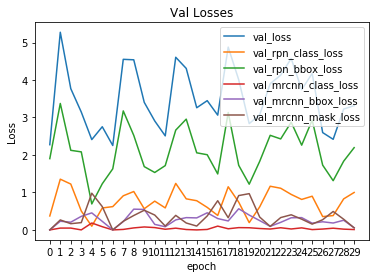

Train Loss 



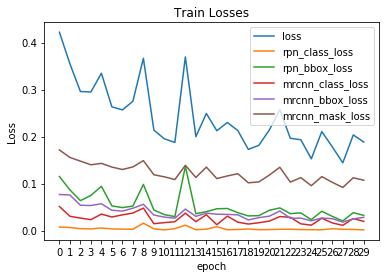

In [20]:
        
model.train(dataset_train, dataset_val, 
            learning_rate=config.LEARNING_RATE, 
            epochs=30, 
            layers='heads', augmentation= seq)

# Training - Stage 2
# Finetune layers from ResNet stage 4 and up
print("Fine tune Resnet stage 4 and up")
model.train(dataset_train, dataset_val,
            learning_rate=config.LEARNING_RATE,
            epochs=30,
            layers='4+',
            augmentation=seq)


# Training - Stage 3
# Fine tune all layers
print("Fine tune all layers")
model.train(dataset_train, dataset_val,
            learning_rate=config.LEARNING_RATE / 10,
            epochs=30,
            layers='all',
            augmentation=seq)


In [21]:
'''
model_path = os.path.join(MODEL_DIR, "mask_rcnn_shapes_with_augmentation.h5")
model.keras_model.save_weights(model_path)
'''

'\nmodel_path = os.path.join(MODEL_DIR, "mask_rcnn_shapes_with_augmentation.h5")\nmodel.keras_model.save_weights(model_path)\n'

In [22]:
# Save weights
# Typically not needed because callbacks save after every epoch
# Uncomment to save manually
'''
model_path = os.path.join(MODEL_DIR, "mask_rcnn_shapes_with_augmentation.h5")
model.keras_model.save_weights(model_path)
'''


'\nmodel_path = os.path.join(MODEL_DIR, "mask_rcnn_shapes_with_augmentation.h5")\nmodel.keras_model.save_weights(model_path)\n'

## Detection

In [23]:
'''
class InferenceConfig(ShapesConfig):
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

inference_config = InferenceConfig()

# Recreate the model in inference mode
model = modellib.MaskRCNN(mode="inference", 
                          config=inference_config,
                          model_dir=MODEL_DIR)

# Get path to saved weights
# Either set a specific path or find last trained weights
# model_path = os.path.join(ROOT_DIR, ".h5 file name here")

model_path = model.find_last()
#model_path = os.path.join(MODEL_DIR, "mask_rcnn_shapes_with_augmentation.h5")

model_path = '/home/harsh/Mask_RCNN/logs/shapes20190824T0132/mask_rcnn_shapes_0150.h5'
# Load trained weights
print("Loading weights from ", model_path)
model.load_weights(model_path, by_name=True)
'''

'\nclass InferenceConfig(ShapesConfig):\n    GPU_COUNT = 1\n    IMAGES_PER_GPU = 1\n\ninference_config = InferenceConfig()\n\n# Recreate the model in inference mode\nmodel = modellib.MaskRCNN(mode="inference", \n                          config=inference_config,\n                          model_dir=MODEL_DIR)\n\n# Get path to saved weights\n# Either set a specific path or find last trained weights\n# model_path = os.path.join(ROOT_DIR, ".h5 file name here")\n\nmodel_path = model.find_last()\n#model_path = os.path.join(MODEL_DIR, "mask_rcnn_shapes_with_augmentation.h5")\n\nmodel_path = \'/home/harsh/Mask_RCNN/logs/shapes20190824T0132/mask_rcnn_shapes_0150.h5\'\n# Load trained weights\nprint("Loading weights from ", model_path)\nmodel.load_weights(model_path, by_name=True)\n'

In [23]:
class ShapesConfig(Config):
    """Configuration for training on the toy shapes dataset.
    Derives from the base Config class and overrides values specific
    to the toy shapes dataset.
    """
    # Give the configuration a recognizable name
    NAME = "shapes"

    # Train on 1 GPU and 1 images per GPU. We can put multiple images on each
    # GPU because the images are small. Batch size is 1 (GPUs * images/GPU).
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1
    STEPS_PER_EPOCH = 100
    # Number of classes (including background)
    NUM_CLASSES = 1 + 1  # background + 1 shapes

    # Use small images for faster training. Set the limits of the small side
    # the large side, and that determines the image shape.
    #IMAGE_MIN_DIM = 128
    #IMAGE_MAX_DIM = 128

    # Use smaller anchors because our image and objects are small
    #RPN_ANCHOR_SCALES = (8, 16, 32, 64, 128, 256, 512, 768)  # anchor side in pixels

    # Reduce training ROIs per image because the images are small and have
    # few objects. Aim to allow ROI sampling to pick 33% positive ROIs.
    #TRAIN_ROIS_PER_IMAGE = 32

    # Use a small epoch since the data is simple
    #STEPS_PER_EPOCH = 100

    # use small validation steps since the epoch is small
    VALIDATION_STEPS = 10    
    WEIGHT_DECAY = 0.001
config = ShapesConfig()
#config.display()

In [24]:
# Create model in training mode
model = modellib.MaskRCNN(mode="training", config=config,
                          model_dir=MODEL_DIR)

# Which weights to start with?
init_with = "coco"  # imagenet, coco, or last

if init_with == "imagenet":
    model.load_weights(model.get_imagenet_weights(), by_name=True)
elif init_with == "coco":
    # Load weights trained on MS COCO, but skip layers that
    # are different due to the different number of classes
    # See README for instructions to download the COCO weights
    model.load_weights(COCO_MODEL_PATH, by_name=True,
                       exclude=["mrcnn_class_logits", "mrcnn_bbox_fc", 
                                "mrcnn_bbox", "mrcnn_mask"])
elif init_with == "last":
    # Load the last model you trained and continue training
    model.load_weights(model.find_last(), by_name=True)



Starting at epoch 0. LR=0.001

Checkpoint Path: /home/harsh/Mask_RCNN/logs/shapes20190826T0916/mask_rcnn_shapes_{epoch:04d}.h5
Selecting layers to train
fpn_c5p5               (Conv2D)
fpn_c4p4               (Conv2D)
fpn_c3p3               (Conv2D)
fpn_c2p2               (Conv2D)
fpn_p5                 (Conv2D)
fpn_p2                 (Conv2D)
fpn_p3                 (Conv2D)
fpn_p4                 (Conv2D)
In model:  rpn_model
    rpn_conv_shared        (Conv2D)
    rpn_class_raw          (Conv2D)
    rpn_bbox_pred          (Conv2D)
mrcnn_mask_conv1       (TimeDistributed)
mrcnn_mask_bn1         (TimeDistributed)
mrcnn_mask_conv2       (TimeDistributed)
mrcnn_mask_bn2         (TimeDistributed)
mrcnn_class_conv1      (TimeDistributed)
mrcnn_class_bn1        (TimeDistributed)
mrcnn_mask_conv3       (TimeDistributed)
mrcnn_mask_bn3         (TimeDistributed)
mrcnn_class_conv2      (TimeDistributed)
mrcnn_class_bn2        (TimeDistributed)
mrcnn_mask_conv4       (TimeDistributed)
mrcnn_mask

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:108: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/keras/engine/training_generator.py:47: UserWarning: Using a generator with `use_multiprocessing=True` and multiple workers may duplicate your data. Please consider using the`keras.utils.Sequence class.
  UserWarning('Using a generator with `use_multiprocessing=True`'


Epoch 1/30
 91/100 [==========================>...] - ETA: 10s - loss: 2.4388 - rpn_class_loss: 0.3057 - rpn_bbox_loss: 0.8677 - mrcnn_class_loss: 0.0862 - mrcnn_bbox_loss: 0.6335 - mrcnn_mask_loss: 0.5456

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 92/100 [==========================>...] - ETA: 9s - loss: 2.4332 - rpn_class_loss: 0.3044 - rpn_bbox_loss: 0.8641 - mrcnn_class_loss: 0.0857 - mrcnn_bbox_loss: 0.6320 - mrcnn_mask_loss: 0.5469 

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 93/100 [==========================>...] - ETA: 8s - loss: 2.4267 - rpn_class_loss: 0.3031 - rpn_bbox_loss: 0.8604 - mrcnn_class_loss: 0.0854 - mrcnn_bbox_loss: 0.6301 - mrcnn_mask_loss: 0.5477

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 94/100 [===========================>..] - ETA: 6s - loss: 2.4249 - rpn_class_loss: 0.3013 - rpn_bbox_loss: 0.8593 - mrcnn_class_loss: 0.0848 - mrcnn_bbox_loss: 0.6339 - mrcnn_mask_loss: 0.5454

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 95/100 [===========================>..] - ETA: 5s - loss: 2.4192 - rpn_class_loss: 0.3001 - rpn_bbox_loss: 0.8553 - mrcnn_class_loss: 0.0844 - mrcnn_bbox_loss: 0.6336 - mrcnn_mask_loss: 0.5458

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 96/100 [===========================>..] - ETA: 4s - loss: 2.4130 - rpn_class_loss: 0.2988 - rpn_bbox_loss: 0.8512 - mrcnn_class_loss: 0.0840 - mrcnn_bbox_loss: 0.6330 - mrcnn_mask_loss: 0.5460

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 97/100 [============================>.] - ETA: 3s - loss: 2.4055 - rpn_class_loss: 0.2975 - rpn_bbox_loss: 0.8470 - mrcnn_class_loss: 0.0837 - mrcnn_bbox_loss: 0.6311 - mrcnn_mask_loss: 0.5461

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 98/100 [============================>.] - ETA: 2s - loss: 2.4008 - rpn_class_loss: 0.2958 - rpn_bbox_loss: 0.8453 - mrcnn_class_loss: 0.0832 - mrcnn_bbox_loss: 0.6324 - mrcnn_mask_loss: 0.5441

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


100/100 [==============================] - 115s 1s/step - loss: 2.3893 - rpn_class_loss: 0.2925 - rpn_bbox_loss: 0.8410 - mrcnn_class_loss: 0.0824 - mrcnn_bbox_loss: 0.6337 - mrcnn_mask_loss: 0.5396 - val_loss: 2.9974 - val_rpn_class_loss: 0.9581 - val_rpn_bbox_loss: 2.0385 - val_mrcnn_class_loss: 7.8185e-04 - val_mrcnn_bbox_loss: 0.0000e+00 - val_mrcnn_mask_loss: 0.0000e+00
Epoch 2/30
100/100 [==============================] - 54s 543ms/step - loss: 2.0429 - rpn_class_loss: 0.2962 - rpn_bbox_loss: 0.6621 - mrcnn_class_loss: 0.0543 - mrcnn_bbox_loss: 0.5249 - mrcnn_mask_loss: 0.5054 - val_loss: 3.9312 - val_rpn_class_loss: 1.0753 - val_rpn_bbox_loss: 2.8558 - val_mrcnn_class_loss: 1.2626e-04 - val_mrcnn_bbox_loss: 0.0000e+00 - val_mrcnn_mask_loss: 0.0000e+00
Epoch 3/30
 71/100 [====================>.........] - ETA: 14s - loss: 1.7125 - rpn_class_loss: 0.1547 - rpn_bbox_loss: 0.5219 - mrcnn_class_loss: 0.0463 - mrcnn_bbox_loss: 0.5716 - mrcnn_mask_loss: 0.4181

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 74/100 [=====================>........] - ETA: 13s - loss: 1.7077 - rpn_class_loss: 0.1533 - rpn_bbox_loss: 0.5178 - mrcnn_class_loss: 0.0462 - mrcnn_bbox_loss: 0.5737 - mrcnn_mask_loss: 0.4167

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 76/100 [=====================>........] - ETA: 12s - loss: 1.7057 - rpn_class_loss: 0.1511 - rpn_bbox_loss: 0.5177 - mrcnn_class_loss: 0.0461 - mrcnn_bbox_loss: 0.5730 - mrcnn_mask_loss: 0.4177

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 78/100 [======================>.......] - ETA: 11s - loss: 1.7045 - rpn_class_loss: 0.1499 - rpn_bbox_loss: 0.5171 - mrcnn_class_loss: 0.0467 - mrcnn_bbox_loss: 0.5719 - mrcnn_mask_loss: 0.4190

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 80/100 [=======================>......] - ETA: 10s - loss: 1.6989 - rpn_class_loss: 0.1486 - rpn_bbox_loss: 0.5152 - mrcnn_class_loss: 0.0470 - mrcnn_bbox_loss: 0.5679 - mrcnn_mask_loss: 0.4202

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 81/100 [=======================>......] - ETA: 9s - loss: 1.6926 - rpn_class_loss: 0.1475 - rpn_bbox_loss: 0.5122 - mrcnn_class_loss: 0.0468 - mrcnn_bbox_loss: 0.5662 - mrcnn_mask_loss: 0.4198 

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 83/100 [=======================>......] - ETA: 8s - loss: 1.6839 - rpn_class_loss: 0.1459 - rpn_bbox_loss: 0.5085 - mrcnn_class_loss: 0.0472 - mrcnn_bbox_loss: 0.5620 - mrcnn_mask_loss: 0.4203

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 85/100 [========================>.....] - ETA: 7s - loss: 1.6779 - rpn_class_loss: 0.1449 - rpn_bbox_loss: 0.5069 - mrcnn_class_loss: 0.0479 - mrcnn_bbox_loss: 0.5563 - mrcnn_mask_loss: 0.4218

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


100/100 [==============================] - 54s 536ms/step - loss: 1.6514 - rpn_class_loss: 0.1392 - rpn_bbox_loss: 0.4996 - mrcnn_class_loss: 0.0657 - mrcnn_bbox_loss: 0.5328 - mrcnn_mask_loss: 0.4140 - val_loss: 4.3468 - val_rpn_class_loss: 0.9041 - val_rpn_bbox_loss: 3.4425 - val_mrcnn_class_loss: 1.9520e-04 - val_mrcnn_bbox_loss: 0.0000e+00 - val_mrcnn_mask_loss: 0.0000e+00
Epoch 4/30
100/100 [==============================] - 54s 543ms/step - loss: 1.6079 - rpn_class_loss: 0.1112 - rpn_bbox_loss: 0.6435 - mrcnn_class_loss: 0.0609 - mrcnn_bbox_loss: 0.4062 - mrcnn_mask_loss: 0.3861 - val_loss: 2.7991 - val_rpn_class_loss: 0.3787 - val_rpn_bbox_loss: 1.1323 - val_mrcnn_class_loss: 0.0507 - val_mrcnn_bbox_loss: 0.5694 - val_mrcnn_mask_loss: 0.6681
Epoch 5/30
100/100 [==============================] - 57s 570ms/step - loss: 1.4926 - rpn_class_loss: 0.1224 - rpn_bbox_loss: 0.5403 - mrcnn_class_loss: 0.0680 - mrcnn_bbox_loss: 0.3794 - mrcnn_mask_loss: 0.3824 - val_loss: 3.4093 - val_rpn_

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 86/100 [========================>.....] - ETA: 7s - loss: 1.5097 - rpn_class_loss: 0.1365 - rpn_bbox_loss: 0.5118 - mrcnn_class_loss: 0.1088 - mrcnn_bbox_loss: 0.3706 - mrcnn_mask_loss: 0.3820

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 88/100 [=========================>....] - ETA: 6s - loss: 1.5170 - rpn_class_loss: 0.1379 - rpn_bbox_loss: 0.5119 - mrcnn_class_loss: 0.1098 - mrcnn_bbox_loss: 0.3724 - mrcnn_mask_loss: 0.3848

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


100/100 [==============================] - 54s 537ms/step - loss: 1.5005 - rpn_class_loss: 0.1367 - rpn_bbox_loss: 0.4969 - mrcnn_class_loss: 0.1070 - mrcnn_bbox_loss: 0.3673 - mrcnn_mask_loss: 0.3928 - val_loss: 2.2795 - val_rpn_class_loss: 0.2441 - val_rpn_bbox_loss: 1.2219 - val_mrcnn_class_loss: 0.0420 - val_mrcnn_bbox_loss: 0.3111 - val_mrcnn_mask_loss: 0.4603
Epoch 8/30
  3/100 [..............................] - ETA: 47s - loss: 1.3717 - rpn_class_loss: 0.0941 - rpn_bbox_loss: 0.5162 - mrcnn_class_loss: 0.0943 - mrcnn_bbox_loss: 0.3164 - mrcnn_mask_loss: 0.3506

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


  9/100 [=>............................] - ETA: 45s - loss: 1.3152 - rpn_class_loss: 0.0873 - rpn_bbox_loss: 0.4717 - mrcnn_class_loss: 0.0931 - mrcnn_bbox_loss: 0.3341 - mrcnn_mask_loss: 0.3290

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 14/100 [===>..........................] - ETA: 43s - loss: 1.3312 - rpn_class_loss: 0.0817 - rpn_bbox_loss: 0.4816 - mrcnn_class_loss: 0.1065 - mrcnn_bbox_loss: 0.3322 - mrcnn_mask_loss: 0.3291

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 21/100 [=====>........................] - ETA: 39s - loss: 1.2835 - rpn_class_loss: 0.0755 - rpn_bbox_loss: 0.4669 - mrcnn_class_loss: 0.1013 - mrcnn_bbox_loss: 0.3243 - mrcnn_mask_loss: 0.3154

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 23/100 [=====>........................] - ETA: 38s - loss: 1.2769 - rpn_class_loss: 0.0777 - rpn_bbox_loss: 0.4673 - mrcnn_class_loss: 0.1011 - mrcnn_bbox_loss: 0.3181 - mrcnn_mask_loss: 0.3127

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


100/100 [==============================] - 54s 540ms/step - loss: 1.2090 - rpn_class_loss: 0.0688 - rpn_bbox_loss: 0.4578 - mrcnn_class_loss: 0.0892 - mrcnn_bbox_loss: 0.3045 - mrcnn_mask_loss: 0.2887 - val_loss: 2.9859 - val_rpn_class_loss: 0.3275 - val_rpn_bbox_loss: 2.3719 - val_mrcnn_class_loss: 0.0132 - val_mrcnn_bbox_loss: 0.1124 - val_mrcnn_mask_loss: 0.1609
Epoch 9/30
 99/100 [============================>.] - ETA: 0s - loss: 0.9780 - rpn_class_loss: 0.0503 - rpn_bbox_loss: 0.3428 - mrcnn_class_loss: 0.0894 - mrcnn_bbox_loss: 0.2415 - mrcnn_mask_loss: 0.2540

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


100/100 [==============================] - 55s 554ms/step - loss: 0.9779 - rpn_class_loss: 0.0501 - rpn_bbox_loss: 0.3429 - mrcnn_class_loss: 0.0905 - mrcnn_bbox_loss: 0.2412 - mrcnn_mask_loss: 0.2532 - val_loss: 4.3225 - val_rpn_class_loss: 0.5851 - val_rpn_bbox_loss: 3.5618 - val_mrcnn_class_loss: 0.0021 - val_mrcnn_bbox_loss: 0.1188 - val_mrcnn_mask_loss: 0.0547
Epoch 10/30
  6/100 [>.............................] - ETA: 47s - loss: 1.0651 - rpn_class_loss: 0.0432 - rpn_bbox_loss: 0.4801 - mrcnn_class_loss: 0.0722 - mrcnn_bbox_loss: 0.2601 - mrcnn_mask_loss: 0.2095

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 12/100 [==>...........................] - ETA: 44s - loss: 1.1236 - rpn_class_loss: 0.0455 - rpn_bbox_loss: 0.4222 - mrcnn_class_loss: 0.0964 - mrcnn_bbox_loss: 0.2865 - mrcnn_mask_loss: 0.2730

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 26/100 [======>.......................] - ETA: 37s - loss: 1.1476 - rpn_class_loss: 0.0479 - rpn_bbox_loss: 0.4053 - mrcnn_class_loss: 0.0953 - mrcnn_bbox_loss: 0.2944 - mrcnn_mask_loss: 0.3048

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 35/100 [=========>....................] - ETA: 33s - loss: 1.1523 - rpn_class_loss: 0.0511 - rpn_bbox_loss: 0.4051 - mrcnn_class_loss: 0.0925 - mrcnn_bbox_loss: 0.2895 - mrcnn_mask_loss: 0.3140

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 37/100 [==========>...................] - ETA: 32s - loss: 1.1691 - rpn_class_loss: 0.0507 - rpn_bbox_loss: 0.3972 - mrcnn_class_loss: 0.0915 - mrcnn_bbox_loss: 0.3065 - mrcnn_mask_loss: 0.3231

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 49/100 [=============>................] - ETA: 26s - loss: 1.2263 - rpn_class_loss: 0.0846 - rpn_bbox_loss: 0.4003 - mrcnn_class_loss: 0.0947 - mrcnn_bbox_loss: 0.3121 - mrcnn_mask_loss: 0.3347

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 50/100 [==============>...............] - ETA: 25s - loss: 1.2171 - rpn_class_loss: 0.0834 - rpn_bbox_loss: 0.3979 - mrcnn_class_loss: 0.0949 - mrcnn_bbox_loss: 0.3086 - mrcnn_mask_loss: 0.3323

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


100/100 [==============================] - 54s 543ms/step - loss: 1.2478 - rpn_class_loss: 0.0919 - rpn_bbox_loss: 0.4160 - mrcnn_class_loss: 0.1027 - mrcnn_bbox_loss: 0.3121 - mrcnn_mask_loss: 0.3251 - val_loss: 4.0993 - val_rpn_class_loss: 0.4135 - val_rpn_bbox_loss: 3.2159 - val_mrcnn_class_loss: 0.0056 - val_mrcnn_bbox_loss: 0.2693 - val_mrcnn_mask_loss: 0.1951
Epoch 11/30
 77/100 [======================>.......] - ETA: 11s - loss: 1.0193 - rpn_class_loss: 0.0647 - rpn_bbox_loss: 0.3796 - mrcnn_class_loss: 0.0688 - mrcnn_bbox_loss: 0.2578 - mrcnn_mask_loss: 0.2485

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 83/100 [=======================>......] - ETA: 8s - loss: 1.0276 - rpn_class_loss: 0.0646 - rpn_bbox_loss: 0.3767 - mrcnn_class_loss: 0.0709 - mrcnn_bbox_loss: 0.2658 - mrcnn_mask_loss: 0.2496

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 87/100 [=========================>....] - ETA: 6s - loss: 1.0211 - rpn_class_loss: 0.0645 - rpn_bbox_loss: 0.3731 - mrcnn_class_loss: 0.0705 - mrcnn_bbox_loss: 0.2638 - mrcnn_mask_loss: 0.2492

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


100/100 [==============================] - 54s 543ms/step - loss: 1.0139 - rpn_class_loss: 0.0627 - rpn_bbox_loss: 0.3643 - mrcnn_class_loss: 0.0728 - mrcnn_bbox_loss: 0.2652 - mrcnn_mask_loss: 0.2488 - val_loss: 4.2758 - val_rpn_class_loss: 0.9173 - val_rpn_bbox_loss: 3.3584 - val_mrcnn_class_loss: 4.1865e-05 - val_mrcnn_bbox_loss: 0.0000e+00 - val_mrcnn_mask_loss: 0.0000e+00


/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


Epoch 12/30
 11/100 [==>...........................] - ETA: 46s - loss: 0.8650 - rpn_class_loss: 0.0371 - rpn_bbox_loss: 0.2757 - mrcnn_class_loss: 0.0657 - mrcnn_bbox_loss: 0.2518 - mrcnn_mask_loss: 0.2346

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 15/100 [===>..........................] - ETA: 43s - loss: 0.9540 - rpn_class_loss: 0.0396 - rpn_bbox_loss: 0.3328 - mrcnn_class_loss: 0.0599 - mrcnn_bbox_loss: 0.2650 - mrcnn_mask_loss: 0.2566

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 20/100 [=====>........................] - ETA: 41s - loss: 0.9008 - rpn_class_loss: 0.0374 - rpn_bbox_loss: 0.3045 - mrcnn_class_loss: 0.0651 - mrcnn_bbox_loss: 0.2487 - mrcnn_mask_loss: 0.2452

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 29/100 [=======>......................] - ETA: 36s - loss: 0.9254 - rpn_class_loss: 0.0410 - rpn_bbox_loss: 0.3307 - mrcnn_class_loss: 0.0674 - mrcnn_bbox_loss: 0.2419 - mrcnn_mask_loss: 0.2444

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


100/100 [==============================] - 56s 560ms/step - loss: 0.9104 - rpn_class_loss: 0.0496 - rpn_bbox_loss: 0.3108 - mrcnn_class_loss: 0.0675 - mrcnn_bbox_loss: 0.2330 - mrcnn_mask_loss: 0.2495 - val_loss: 3.6886 - val_rpn_class_loss: 0.5728 - val_rpn_bbox_loss: 3.1158 - val_mrcnn_class_loss: 6.5446e-06 - val_mrcnn_bbox_loss: 0.0000e+00 - val_mrcnn_mask_loss: 0.0000e+00
Epoch 13/30
100/100 [==============================] - 54s 541ms/step - loss: 1.0420 - rpn_class_loss: 0.0652 - rpn_bbox_loss: 0.4034 - mrcnn_class_loss: 0.0966 - mrcnn_bbox_loss: 0.2296 - mrcnn_mask_loss: 0.2473 - val_loss: 2.1806 - val_rpn_class_loss: 0.2567 - val_rpn_bbox_loss: 1.9239 - val_mrcnn_class_loss: 2.6226e-06 - val_mrcnn_bbox_loss: 0.0000e+00 - val_mrcnn_mask_loss: 0.0000e+00
Epoch 14/30
100/100 [==============================] - 56s 561ms/step - loss: 0.9472 - rpn_class_loss: 0.0494 - rpn_bbox_loss: 0.3327 - mrcnn_class_loss: 0.0818 - mrcnn_bbox_loss: 0.2312 - mrcnn_mask_loss: 0.2522 - val_loss: 2.6

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 94/100 [===========================>..] - ETA: 3s - loss: 1.0815 - rpn_class_loss: 0.0633 - rpn_bbox_loss: 0.3859 - mrcnn_class_loss: 0.1119 - mrcnn_bbox_loss: 0.2342 - mrcnn_mask_loss: 0.2863

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


100/100 [==============================] - 53s 535ms/step - loss: 1.0760 - rpn_class_loss: 0.0620 - rpn_bbox_loss: 0.3797 - mrcnn_class_loss: 0.1093 - mrcnn_bbox_loss: 0.2364 - mrcnn_mask_loss: 0.2886 - val_loss: 2.1317 - val_rpn_class_loss: 0.0955 - val_rpn_bbox_loss: 0.7810 - val_mrcnn_class_loss: 0.0764 - val_mrcnn_bbox_loss: 0.4822 - val_mrcnn_mask_loss: 0.6965
Epoch 16/30
  2/100 [..............................] - ETA: 48s - loss: 1.0100 - rpn_class_loss: 0.0279 - rpn_bbox_loss: 0.4314 - mrcnn_class_loss: 0.0647 - mrcnn_bbox_loss: 0.2426 - mrcnn_mask_loss: 0.2433

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


  5/100 [>.............................] - ETA: 47s - loss: 0.9235 - rpn_class_loss: 0.0379 - rpn_bbox_loss: 0.3998 - mrcnn_class_loss: 0.0674 - mrcnn_bbox_loss: 0.2035 - mrcnn_mask_loss: 0.2148

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 16/100 [===>..........................] - ETA: 43s - loss: 0.9356 - rpn_class_loss: 0.0361 - rpn_bbox_loss: 0.3615 - mrcnn_class_loss: 0.0845 - mrcnn_bbox_loss: 0.2387 - mrcnn_mask_loss: 0.2147

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 22/100 [=====>........................] - ETA: 40s - loss: 0.9371 - rpn_class_loss: 0.0343 - rpn_bbox_loss: 0.3633 - mrcnn_class_loss: 0.0777 - mrcnn_bbox_loss: 0.2495 - mrcnn_mask_loss: 0.2122

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 25/100 [======>.......................] - ETA: 38s - loss: 0.9393 - rpn_class_loss: 0.0338 - rpn_bbox_loss: 0.3679 - mrcnn_class_loss: 0.0774 - mrcnn_bbox_loss: 0.2501 - mrcnn_mask_loss: 0.2101

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 35/100 [=========>....................] - ETA: 33s - loss: 0.8948 - rpn_class_loss: 0.0308 - rpn_bbox_loss: 0.3479 - mrcnn_class_loss: 0.0689 - mrcnn_bbox_loss: 0.2301 - mrcnn_mask_loss: 0.2171

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 37/100 [==========>...................] - ETA: 32s - loss: 0.8946 - rpn_class_loss: 0.0308 - rpn_bbox_loss: 0.3473 - mrcnn_class_loss: 0.0711 - mrcnn_bbox_loss: 0.2291 - mrcnn_mask_loss: 0.2163

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 38/100 [==========>...................] - ETA: 31s - loss: 0.9019 - rpn_class_loss: 0.0307 - rpn_bbox_loss: 0.3538 - mrcnn_class_loss: 0.0706 - mrcnn_bbox_loss: 0.2300 - mrcnn_mask_loss: 0.2168

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 48/100 [=============>................] - ETA: 26s - loss: 0.8714 - rpn_class_loss: 0.0300 - rpn_bbox_loss: 0.3428 - mrcnn_class_loss: 0.0677 - mrcnn_bbox_loss: 0.2172 - mrcnn_mask_loss: 0.2137

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 50/100 [==============>...............] - ETA: 25s - loss: 0.8765 - rpn_class_loss: 0.0310 - rpn_bbox_loss: 0.3495 - mrcnn_class_loss: 0.0672 - mrcnn_bbox_loss: 0.2153 - mrcnn_mask_loss: 0.2135

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 64/100 [==================>...........] - ETA: 18s - loss: 0.8640 - rpn_class_loss: 0.0330 - rpn_bbox_loss: 0.3553 - mrcnn_class_loss: 0.0611 - mrcnn_bbox_loss: 0.2054 - mrcnn_mask_loss: 0.2092

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 69/100 [===================>..........] - ETA: 15s - loss: 0.8640 - rpn_class_loss: 0.0324 - rpn_bbox_loss: 0.3580 - mrcnn_class_loss: 0.0613 - mrcnn_bbox_loss: 0.2033 - mrcnn_mask_loss: 0.2089

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 73/100 [====================>.........] - ETA: 13s - loss: 0.8628 - rpn_class_loss: 0.0324 - rpn_bbox_loss: 0.3614 - mrcnn_class_loss: 0.0602 - mrcnn_bbox_loss: 0.2007 - mrcnn_mask_loss: 0.2081

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 84/100 [========================>.....] - ETA: 8s - loss: 0.8899 - rpn_class_loss: 0.0343 - rpn_bbox_loss: 0.3677 - mrcnn_class_loss: 0.0624 - mrcnn_bbox_loss: 0.2035 - mrcnn_mask_loss: 0.2219

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


100/100 [==============================] - 55s 547ms/step - loss: 0.9256 - rpn_class_loss: 0.0385 - rpn_bbox_loss: 0.3813 - mrcnn_class_loss: 0.0632 - mrcnn_bbox_loss: 0.2110 - mrcnn_mask_loss: 0.2315 - val_loss: 2.9121 - val_rpn_class_loss: 0.6167 - val_rpn_bbox_loss: 1.9554 - val_mrcnn_class_loss: 0.0257 - val_mrcnn_bbox_loss: 0.1253 - val_mrcnn_mask_loss: 0.1890
Epoch 17/30
100/100 [==============================] - 54s 545ms/step - loss: 0.9729 - rpn_class_loss: 0.0446 - rpn_bbox_loss: 0.3942 - mrcnn_class_loss: 0.0763 - mrcnn_bbox_loss: 0.2051 - mrcnn_mask_loss: 0.2527 - val_loss: 3.1819 - val_rpn_class_loss: 0.4710 - val_rpn_bbox_loss: 2.7108 - val_mrcnn_class_loss: 5.1498e-06 - val_mrcnn_bbox_loss: 0.0000e+00 - val_mrcnn_mask_loss: 0.0000e+00
Epoch 18/30
100/100 [==============================] - 55s 549ms/step - loss: 0.9977 - rpn_class_loss: 0.0515 - rpn_bbox_loss: 0.3542 - mrcnn_class_loss: 0.0870 - mrcnn_bbox_loss: 0.2503 - mrcnn_mask_loss: 0.2548 - val_loss: 3.9030 - val_rp

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 66/100 [==================>...........] - ETA: 17s - loss: 0.8723 - rpn_class_loss: 0.0454 - rpn_bbox_loss: 0.3138 - mrcnn_class_loss: 0.0914 - mrcnn_bbox_loss: 0.2077 - mrcnn_mask_loss: 0.2140

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 79/100 [======================>.......] - ETA: 10s - loss: 0.8796 - rpn_class_loss: 0.0446 - rpn_bbox_loss: 0.3098 - mrcnn_class_loss: 0.0994 - mrcnn_bbox_loss: 0.2079 - mrcnn_mask_loss: 0.2178

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 80/100 [=======================>......] - ETA: 10s - loss: 0.8839 - rpn_class_loss: 0.0444 - rpn_bbox_loss: 0.3124 - mrcnn_class_loss: 0.0999 - mrcnn_bbox_loss: 0.2087 - mrcnn_mask_loss: 0.2184

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 92/100 [==========================>...] - ETA: 4s - loss: 0.8823 - rpn_class_loss: 0.0430 - rpn_bbox_loss: 0.3084 - mrcnn_class_loss: 0.1005 - mrcnn_bbox_loss: 0.2125 - mrcnn_mask_loss: 0.2180

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 98/100 [============================>.] - ETA: 1s - loss: 0.8704 - rpn_class_loss: 0.0416 - rpn_bbox_loss: 0.3006 - mrcnn_class_loss: 0.0992 - mrcnn_bbox_loss: 0.2118 - mrcnn_mask_loss: 0.2172

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


100/100 [==============================] - 54s 535ms/step - loss: 0.8760 - rpn_class_loss: 0.0415 - rpn_bbox_loss: 0.3017 - mrcnn_class_loss: 0.1003 - mrcnn_bbox_loss: 0.2149 - mrcnn_mask_loss: 0.2175 - val_loss: 4.5554 - val_rpn_class_loss: 0.9047 - val_rpn_bbox_loss: 3.3971 - val_mrcnn_class_loss: 0.0044 - val_mrcnn_bbox_loss: 0.1334 - val_mrcnn_mask_loss: 0.1156
Epoch 20/30
  7/100 [=>............................] - ETA: 46s - loss: 0.8095 - rpn_class_loss: 0.0287 - rpn_bbox_loss: 0.2314 - mrcnn_class_loss: 0.0986 - mrcnn_bbox_loss: 0.2529 - mrcnn_mask_loss: 0.1979

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


  9/100 [=>............................] - ETA: 45s - loss: 0.7894 - rpn_class_loss: 0.0272 - rpn_bbox_loss: 0.2320 - mrcnn_class_loss: 0.0877 - mrcnn_bbox_loss: 0.2466 - mrcnn_mask_loss: 0.1959

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


100/100 [==============================] - 56s 563ms/step - loss: 0.9077 - rpn_class_loss: 0.0481 - rpn_bbox_loss: 0.3033 - mrcnn_class_loss: 0.0874 - mrcnn_bbox_loss: 0.2364 - mrcnn_mask_loss: 0.2325 - val_loss: 3.4898 - val_rpn_class_loss: 0.6650 - val_rpn_bbox_loss: 2.8248 - val_mrcnn_class_loss: 9.5367e-07 - val_mrcnn_bbox_loss: 0.0000e+00 - val_mrcnn_mask_loss: 0.0000e+00
Epoch 21/30
100/100 [==============================] - 54s 543ms/step - loss: 1.0051 - rpn_class_loss: 0.0572 - rpn_bbox_loss: 0.3515 - mrcnn_class_loss: 0.1032 - mrcnn_bbox_loss: 0.2345 - mrcnn_mask_loss: 0.2587 - val_loss: 3.4331 - val_rpn_class_loss: 0.2590 - val_rpn_bbox_loss: 2.2864 - val_mrcnn_class_loss: 0.0262 - val_mrcnn_bbox_loss: 0.4653 - val_mrcnn_mask_loss: 0.3963
Epoch 22/30
 46/100 [============>.................] - ETA: 28s - loss: 0.6763 - rpn_class_loss: 0.0298 - rpn_bbox_loss: 0.2380 - mrcnn_class_loss: 0.0674 - mrcnn_bbox_loss: 0.1483 - mrcnn_mask_loss: 0.1928

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 59/100 [================>.............] - ETA: 21s - loss: 0.6995 - rpn_class_loss: 0.0284 - rpn_bbox_loss: 0.2613 - mrcnn_class_loss: 0.0693 - mrcnn_bbox_loss: 0.1520 - mrcnn_mask_loss: 0.1885

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 72/100 [====================>.........] - ETA: 14s - loss: 0.7212 - rpn_class_loss: 0.0292 - rpn_bbox_loss: 0.2695 - mrcnn_class_loss: 0.0705 - mrcnn_bbox_loss: 0.1588 - mrcnn_mask_loss: 0.1932

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 75/100 [=====================>........] - ETA: 13s - loss: 0.7171 - rpn_class_loss: 0.0285 - rpn_bbox_loss: 0.2702 - mrcnn_class_loss: 0.0681 - mrcnn_bbox_loss: 0.1573 - mrcnn_mask_loss: 0.1929

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 84/100 [========================>.....] - ETA: 8s - loss: 0.7425 - rpn_class_loss: 0.0295 - rpn_bbox_loss: 0.2826 - mrcnn_class_loss: 0.0732 - mrcnn_bbox_loss: 0.1602 - mrcnn_mask_loss: 0.1970

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 99/100 [============================>.] - ETA: 0s - loss: 0.7619 - rpn_class_loss: 0.0301 - rpn_bbox_loss: 0.2869 - mrcnn_class_loss: 0.0788 - mrcnn_bbox_loss: 0.1630 - mrcnn_mask_loss: 0.2030

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


100/100 [==============================] - 55s 550ms/step - loss: 0.7682 - rpn_class_loss: 0.0304 - rpn_bbox_loss: 0.2891 - mrcnn_class_loss: 0.0788 - mrcnn_bbox_loss: 0.1647 - mrcnn_mask_loss: 0.2052 - val_loss: 2.8499 - val_rpn_class_loss: 0.3386 - val_rpn_bbox_loss: 1.6287 - val_mrcnn_class_loss: 0.0483 - val_mrcnn_bbox_loss: 0.3170 - val_mrcnn_mask_loss: 0.5173
Epoch 23/30
  3/100 [..............................] - ETA: 48s - loss: 0.7200 - rpn_class_loss: 0.0268 - rpn_bbox_loss: 0.3085 - mrcnn_class_loss: 0.0259 - mrcnn_bbox_loss: 0.1492 - mrcnn_mask_loss: 0.2096

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


  8/100 [=>............................] - ETA: 45s - loss: 0.9769 - rpn_class_loss: 0.0586 - rpn_bbox_loss: 0.3735 - mrcnn_class_loss: 0.1478 - mrcnn_bbox_loss: 0.1716 - mrcnn_mask_loss: 0.2254

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


100/100 [==============================] - 54s 540ms/step - loss: 0.7968 - rpn_class_loss: 0.0439 - rpn_bbox_loss: 0.2745 - mrcnn_class_loss: 0.0765 - mrcnn_bbox_loss: 0.1672 - mrcnn_mask_loss: 0.2345 - val_loss: 2.9441 - val_rpn_class_loss: 0.5118 - val_rpn_bbox_loss: 2.4322 - val_mrcnn_class_loss: 3.0041e-06 - val_mrcnn_bbox_loss: 0.0000e+00 - val_mrcnn_mask_loss: 0.0000e+00
Epoch 24/30
 57/100 [================>.............] - ETA: 22s - loss: 0.6597 - rpn_class_loss: 0.0240 - rpn_bbox_loss: 0.2404 - mrcnn_class_loss: 0.0558 - mrcnn_bbox_loss: 0.1354 - mrcnn_mask_loss: 0.2041

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 70/100 [====================>.........] - ETA: 15s - loss: 0.6609 - rpn_class_loss: 0.0265 - rpn_bbox_loss: 0.2473 - mrcnn_class_loss: 0.0571 - mrcnn_bbox_loss: 0.1317 - mrcnn_mask_loss: 0.1983

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 80/100 [=======================>......] - ETA: 10s - loss: 0.6952 - rpn_class_loss: 0.0296 - rpn_bbox_loss: 0.2656 - mrcnn_class_loss: 0.0584 - mrcnn_bbox_loss: 0.1402 - mrcnn_mask_loss: 0.2014

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 84/100 [========================>.....] - ETA: 8s - loss: 0.6980 - rpn_class_loss: 0.0294 - rpn_bbox_loss: 0.2696 - mrcnn_class_loss: 0.0582 - mrcnn_bbox_loss: 0.1402 - mrcnn_mask_loss: 0.2006

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 91/100 [==========================>...] - ETA: 4s - loss: 0.7195 - rpn_class_loss: 0.0312 - rpn_bbox_loss: 0.2785 - mrcnn_class_loss: 0.0603 - mrcnn_bbox_loss: 0.1468 - mrcnn_mask_loss: 0.2028

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


100/100 [==============================] - 54s 544ms/step - loss: 0.7328 - rpn_class_loss: 0.0326 - rpn_bbox_loss: 0.2835 - mrcnn_class_loss: 0.0624 - mrcnn_bbox_loss: 0.1496 - mrcnn_mask_loss: 0.2046 - val_loss: 3.5845 - val_rpn_class_loss: 0.3259 - val_rpn_bbox_loss: 2.8642 - val_mrcnn_class_loss: 9.1447e-04 - val_mrcnn_bbox_loss: 0.2716 - val_mrcnn_mask_loss: 0.1218
Epoch 25/30
 10/100 [==>...........................] - ETA: 46s - loss: 0.8275 - rpn_class_loss: 0.0345 - rpn_bbox_loss: 0.3316 - mrcnn_class_loss: 0.0618 - mrcnn_bbox_loss: 0.1862 - mrcnn_mask_loss: 0.2133

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 11/100 [==>...........................] - ETA: 45s - loss: 0.9256 - rpn_class_loss: 0.0430 - rpn_bbox_loss: 0.3486 - mrcnn_class_loss: 0.0751 - mrcnn_bbox_loss: 0.2076 - mrcnn_mask_loss: 0.2513

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 17/100 [====>.........................] - ETA: 42s - loss: 0.8988 - rpn_class_loss: 0.0409 - rpn_bbox_loss: 0.3478 - mrcnn_class_loss: 0.0816 - mrcnn_bbox_loss: 0.2019 - mrcnn_mask_loss: 0.2265

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


100/100 [==============================] - 54s 543ms/step - loss: 0.8183 - rpn_class_loss: 0.0356 - rpn_bbox_loss: 0.2893 - mrcnn_class_loss: 0.0830 - mrcnn_bbox_loss: 0.1827 - mrcnn_mask_loss: 0.2278 - val_loss: 3.9260 - val_rpn_class_loss: 0.3506 - val_rpn_bbox_loss: 3.5753 - val_mrcnn_class_loss: 0.0000e+00 - val_mrcnn_bbox_loss: 0.0000e+00 - val_mrcnn_mask_loss: 0.0000e+00
Epoch 26/30
100/100 [==============================] - 56s 562ms/step - loss: 0.7691 - rpn_class_loss: 0.0377 - rpn_bbox_loss: 0.2996 - mrcnn_class_loss: 0.0611 - mrcnn_bbox_loss: 0.1600 - mrcnn_mask_loss: 0.2107 - val_loss: 3.7091 - val_rpn_class_loss: 0.3934 - val_rpn_bbox_loss: 2.8583 - val_mrcnn_class_loss: 0.0093 - val_mrcnn_bbox_loss: 0.2136 - val_mrcnn_mask_loss: 0.2345
Epoch 27/30
100/100 [==============================] - 54s 539ms/step - loss: 0.8448 - rpn_class_loss: 0.0596 - rpn_bbox_loss: 0.2563 - mrcnn_class_loss: 0.1019 - mrcnn_bbox_loss: 0.1921 - mrcnn_mask_loss: 0.2348 - val_loss: 3.3465 - val_rp

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 53/100 [==============>...............] - ETA: 25s - loss: 0.7192 - rpn_class_loss: 0.0342 - rpn_bbox_loss: 0.2758 - mrcnn_class_loss: 0.0564 - mrcnn_bbox_loss: 0.1451 - mrcnn_mask_loss: 0.2077

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 60/100 [=================>............] - ETA: 21s - loss: 0.7171 - rpn_class_loss: 0.0325 - rpn_bbox_loss: 0.2795 - mrcnn_class_loss: 0.0556 - mrcnn_bbox_loss: 0.1446 - mrcnn_mask_loss: 0.2049

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 62/100 [=================>............] - ETA: 20s - loss: 0.7223 - rpn_class_loss: 0.0324 - rpn_bbox_loss: 0.2838 - mrcnn_class_loss: 0.0556 - mrcnn_bbox_loss: 0.1456 - mrcnn_mask_loss: 0.2048

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 74/100 [=====================>........] - ETA: 13s - loss: 0.7185 - rpn_class_loss: 0.0320 - rpn_bbox_loss: 0.2821 - mrcnn_class_loss: 0.0575 - mrcnn_bbox_loss: 0.1424 - mrcnn_mask_loss: 0.2045

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 93/100 [==========================>...] - ETA: 3s - loss: 0.7248 - rpn_class_loss: 0.0309 - rpn_bbox_loss: 0.2861 - mrcnn_class_loss: 0.0649 - mrcnn_bbox_loss: 0.1425 - mrcnn_mask_loss: 0.2004

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 96/100 [===========================>..] - ETA: 2s - loss: 0.7337 - rpn_class_loss: 0.0310 - rpn_bbox_loss: 0.2914 - mrcnn_class_loss: 0.0667 - mrcnn_bbox_loss: 0.1442 - mrcnn_mask_loss: 0.2004

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


100/100 [==============================] - 55s 552ms/step - loss: 0.7510 - rpn_class_loss: 0.0341 - rpn_bbox_loss: 0.2942 - mrcnn_class_loss: 0.0729 - mrcnn_bbox_loss: 0.1464 - mrcnn_mask_loss: 0.2034 - val_loss: 3.8309 - val_rpn_class_loss: 0.5184 - val_rpn_bbox_loss: 2.8154 - val_mrcnn_class_loss: 0.0067 - val_mrcnn_bbox_loss: 0.2494 - val_mrcnn_mask_loss: 0.2409
Epoch 30/30
  2/100 [..............................] - ETA: 47s - loss: 0.8545 - rpn_class_loss: 0.0414 - rpn_bbox_loss: 0.3464 - mrcnn_class_loss: 0.1256 - mrcnn_bbox_loss: 0.1596 - mrcnn_mask_loss: 0.1815

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


100/100 [==============================] - 56s 564ms/step - loss: 0.8153 - rpn_class_loss: 0.0385 - rpn_bbox_loss: 0.2960 - mrcnn_class_loss: 0.0904 - mrcnn_bbox_loss: 0.1765 - mrcnn_mask_loss: 0.2139 - val_loss: 3.7512 - val_rpn_class_loss: 0.5391 - val_rpn_bbox_loss: 2.9669 - val_mrcnn_class_loss: 0.0017 - val_mrcnn_bbox_loss: 0.1469 - val_mrcnn_mask_loss: 0.0965
Validation Loss 



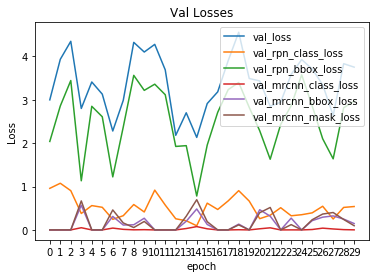

Train Loss 



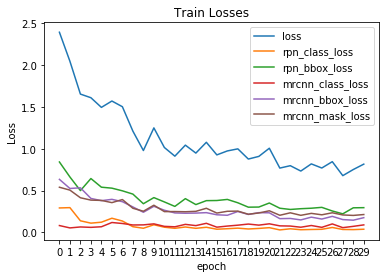

Fine tune Resnet stage 4 and up

Starting at epoch 0. LR=0.001

Checkpoint Path: /home/harsh/Mask_RCNN/logs/shapes20190826T0916/mask_rcnn_shapes_{epoch:04d}.h5
Selecting layers to train
res4a_branch2a         (Conv2D)
bn4a_branch2a          (BatchNorm)
res4a_branch2b         (Conv2D)
bn4a_branch2b          (BatchNorm)
res4a_branch2c         (Conv2D)
res4a_branch1          (Conv2D)
bn4a_branch2c          (BatchNorm)
bn4a_branch1           (BatchNorm)
res4b_branch2a         (Conv2D)
bn4b_branch2a          (BatchNorm)
res4b_branch2b         (Conv2D)
bn4b_branch2b          (BatchNorm)
res4b_branch2c         (Conv2D)
bn4b_branch2c          (BatchNorm)
res4c_branch2a         (Conv2D)
bn4c_branch2a          (BatchNorm)
res4c_branch2b         (Conv2D)
bn4c_branch2b          (BatchNorm)
res4c_branch2c         (Conv2D)
bn4c_branch2c          (BatchNorm)
res4d_branch2a         (Conv2D)
bn4d_branch2a          (BatchNorm)
res4d_branch2b         (Conv2D)
bn4d_branch2b          (BatchNorm)
res4d_bran

ResourceExhaustedError: OOM when allocating tensor with shape[600,256,28,28] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[{{node training_11/SGD/gradients/mrcnn_mask_4/convolution_grad/Conv2DBackpropInput}} = Conv2DBackpropInput[T=DT_FLOAT, _class=["loc:@train...propFilter"], data_format="NCHW", dilations=[1, 1, 1, 1], padding="VALID", strides=[1, 1, 1, 1], use_cudnn_on_gpu=true, _device="/job:localhost/replica:0/task:0/device:GPU:0"](training_11/SGD/gradients/mrcnn_mask_4/convolution_grad/Conv2DBackpropInput-0-VecPermuteNHWCToNCHW-LayoutOptimizer, mrcnn_mask_4/kernel/read, training_11/SGD/gradients/mrcnn_mask_4/Sigmoid_grad/SigmoidGrad)]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.

	 [[{{node training_11/SGD/gradients/mrcnn_mask_conv1_4/convolution_grad/Conv2DBackpropInput-0-0-TransposeNCHWToNHWC-LayoutOptimizer/_34697}} = _Recv[client_terminated=false, recv_device="/job:localhost/replica:0/task:0/device:CPU:0", send_device="/job:localhost/replica:0/task:0/device:GPU:0", send_device_incarnation=1, tensor_name="edge_9415_...tOptimizer", tensor_type=DT_FLOAT, _device="/job:localhost/replica:0/task:0/device:CPU:0"]()]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.


In [25]:
        
model.train(dataset_train, dataset_val, 
            learning_rate=config.LEARNING_RATE, 
            epochs=30, 
            layers='heads', augmentation= seq)


print("Fine tune Resnet stage 4 and up")
model.train(dataset_train, dataset_val,
            learning_rate=config.LEARNING_RATE,
            epochs=30,
            layers='4+',
            augmentation=seq)



print("Fine tune all layers")
model.train(dataset_train, dataset_val,
            learning_rate=config.LEARNING_RATE / 10,
            epochs=30,
            layers='all',
            augmentation=seq)


In [17]:
class ShapesConfig(Config):
    """Configuration for training on the toy shapes dataset.
    Derives from the base Config class and overrides values specific
    to the toy shapes dataset.
    """
    # Give the configuration a recognizable name
    NAME = "shapes"

    # Train on 1 GPU and 1 images per GPU. We can put multiple images on each
    # GPU because the images are small. Batch size is 1 (GPUs * images/GPU).
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1
    STEPS_PER_EPOCH = 100
    # Number of classes (including background)
    NUM_CLASSES = 1 + 1  # background + 1 shapes

    # Use small images for faster training. Set the limits of the small side
    # the large side, and that determines the image shape.
    #IMAGE_MIN_DIM = 128
    #IMAGE_MAX_DIM = 128

    # Use smaller anchors because our image and objects are small
    #RPN_ANCHOR_SCALES = (8, 16, 32, 64, 128, 256, 512, 768)  # anchor side in pixels

    # Reduce training ROIs per image because the images are small and have
    # few objects. Aim to allow ROI sampling to pick 33% positive ROIs.
    #TRAIN_ROIS_PER_IMAGE = 32

    # Use a small epoch since the data is simple
    #STEPS_PER_EPOCH = 100

    # use small validation steps since the epoch is small
    VALIDATION_STEPS = 10
    WEIGHT_DECAY = 0.005
    
config = ShapesConfig()
config.display()


Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 1
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  1024
IMAGE_META_SIZE                14
IMAGE_MIN_DIM                  800
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [1024 1024    3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE         

In [18]:
# Create model in training mode
model = modellib.MaskRCNN(mode="training", config=config,
                          model_dir=MODEL_DIR)

# Which weights to start with?
init_with = "coco"  # imagenet, coco, or last

if init_with == "imagenet":
    model.load_weights(model.get_imagenet_weights(), by_name=True)
elif init_with == "coco":
    # Load weights trained on MS COCO, but skip layers that
    # are different due to the different number of classes
    # See README for instructions to download the COCO weights
    model.load_weights(COCO_MODEL_PATH, by_name=True,
                       exclude=["mrcnn_class_logits", "mrcnn_bbox_fc", 
                                "mrcnn_bbox", "mrcnn_mask"])
elif init_with == "last":
    # Load the last model you trained and continue training
    model.load_weights(model.find_last(), by_name=True)



Starting at epoch 0. LR=0.001

Checkpoint Path: /home/harsh/Mask_RCNN/logs/shapes20190826T0255/mask_rcnn_shapes_{epoch:04d}.h5
Selecting layers to train
fpn_c5p5               (Conv2D)
fpn_c4p4               (Conv2D)
fpn_c3p3               (Conv2D)
fpn_c2p2               (Conv2D)
fpn_p5                 (Conv2D)
fpn_p2                 (Conv2D)
fpn_p3                 (Conv2D)
fpn_p4                 (Conv2D)
In model:  rpn_model
    rpn_conv_shared        (Conv2D)
    rpn_class_raw          (Conv2D)
    rpn_bbox_pred          (Conv2D)
mrcnn_mask_conv1       (TimeDistributed)
mrcnn_mask_bn1         (TimeDistributed)
mrcnn_mask_conv2       (TimeDistributed)
mrcnn_mask_bn2         (TimeDistributed)
mrcnn_class_conv1      (TimeDistributed)
mrcnn_class_bn1        (TimeDistributed)
mrcnn_mask_conv3       (TimeDistributed)
mrcnn_mask_bn3         (TimeDistributed)
mrcnn_class_conv2      (TimeDistributed)
mrcnn_class_bn2        (TimeDistributed)
mrcnn_mask_conv4       (TimeDistributed)
mrcnn_mask

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6

 50/100 [==============>...............] - ETA: 57s - loss: 2.5106 - rpn_class_loss: 0.4572 - rpn_bbox_loss: 1.2631 - mrcnn_class_loss: 0.0467 - mrcnn_bbox_loss: 0.3874 - mrcnn_mask_loss: 0.3561

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6

 51/100 [==============>...............] - ETA: 56s - loss: 2.4976 - rpn_class_loss: 0.4554 - rpn_bbox_loss: 1.2563 - mrcnn_class_loss: 0.0459 - mrcnn_bbox_loss: 0.3815 - mrcnn_mask_loss: 0.3583

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


100/100 [==============================] - 97s 966ms/step - loss: 2.3403 - rpn_class_loss: 0.3313 - rpn_bbox_loss: 1.0122 - mrcnn_class_loss: 0.0425 - mrcnn_bbox_loss: 0.5286 - mrcnn_mask_loss: 0.4256 - val_loss: 3.3669 - val_rpn_class_loss: 0.5478 - val_rpn_bbox_loss: 2.2889 - val_mrcnn_class_loss: 0.0151 - val_mrcnn_bbox_loss: 0.2635 - val_mrcnn_mask_loss: 0.2514
Epoch 2/30
100/100 [==============================] - 54s 537ms/step - loss: 2.0136 - rpn_class_loss: 0.2719 - rpn_bbox_loss: 0.6605 - mrcnn_class_loss: 0.0538 - mrcnn_bbox_loss: 0.5296 - mrcnn_mask_loss: 0.4977 - val_loss: 3.5363 - val_rpn_class_loss: 0.7440 - val_rpn_bbox_loss: 1.7617 - val_mrcnn_class_loss: 0.0649 - val_mrcnn_bbox_loss: 0.5556 - val_mrcnn_mask_loss: 0.4100
Epoch 3/30
100/100 [==============================] - 56s 560ms/step - loss: 1.7095 - rpn_class_loss: 0.1517 - rpn_bbox_loss: 0.5728 - mrcnn_class_loss: 0.0597 - mrcnn_bbox_loss: 0.5004 - mrcnn_mask_loss: 0.4250 - val_loss: 4.5225 - val_rpn_class_loss: 

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 22/100 [=====>........................] - ETA: 38s - loss: 2.0325 - rpn_class_loss: 0.3084 - rpn_bbox_loss: 0.5304 - mrcnn_class_loss: 0.2002 - mrcnn_bbox_loss: 0.4819 - mrcnn_mask_loss: 0.5115

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 27/100 [=======>......................] - ETA: 36s - loss: 2.0239 - rpn_class_loss: 0.3009 - rpn_bbox_loss: 0.5610 - mrcnn_class_loss: 0.1698 - mrcnn_bbox_loss: 0.4882 - mrcnn_mask_loss: 0.5040

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 33/100 [========>.....................] - ETA: 33s - loss: 2.0528 - rpn_class_loss: 0.2994 - rpn_bbox_loss: 0.6103 - mrcnn_class_loss: 0.1534 - mrcnn_bbox_loss: 0.4983 - mrcnn_mask_loss: 0.4913

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 39/100 [==========>...................] - ETA: 30s - loss: 2.0242 - rpn_class_loss: 0.2799 - rpn_bbox_loss: 0.5899 - mrcnn_class_loss: 0.1484 - mrcnn_bbox_loss: 0.5108 - mrcnn_mask_loss: 0.4952

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 42/100 [===========>..................] - ETA: 29s - loss: 1.9822 - rpn_class_loss: 0.2682 - rpn_bbox_loss: 0.5943 - mrcnn_class_loss: 0.1420 - mrcnn_bbox_loss: 0.4943 - mrcnn_mask_loss: 0.4833

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 44/100 [============>.................] - ETA: 28s - loss: 1.9701 - rpn_class_loss: 0.2625 - rpn_bbox_loss: 0.6107 - mrcnn_class_loss: 0.1381 - mrcnn_bbox_loss: 0.4835 - mrcnn_mask_loss: 0.4751

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 48/100 [=============>................] - ETA: 26s - loss: 1.9165 - rpn_class_loss: 0.2492 - rpn_bbox_loss: 0.6124 - mrcnn_class_loss: 0.1305 - mrcnn_bbox_loss: 0.4616 - mrcnn_mask_loss: 0.4626

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


100/100 [==============================] - 54s 538ms/step - loss: 1.7040 - rpn_class_loss: 0.1818 - rpn_bbox_loss: 0.5255 - mrcnn_class_loss: 0.1267 - mrcnn_bbox_loss: 0.4407 - mrcnn_mask_loss: 0.4291 - val_loss: 4.5704 - val_rpn_class_loss: 1.0763 - val_rpn_bbox_loss: 3.4941 - val_mrcnn_class_loss: 4.4941e-05 - val_mrcnn_bbox_loss: 0.0000e+00 - val_mrcnn_mask_loss: 0.0000e+00
Epoch 5/30
100/100 [==============================] - 55s 545ms/step - loss: 1.2386 - rpn_class_loss: 0.0916 - rpn_bbox_loss: 0.4213 - mrcnn_class_loss: 0.0758 - mrcnn_bbox_loss: 0.3309 - mrcnn_mask_loss: 0.3189 - val_loss: 3.1977 - val_rpn_class_loss: 0.8706 - val_rpn_bbox_loss: 2.3267 - val_mrcnn_class_loss: 2.6499e-04 - val_mrcnn_bbox_loss: 0.0000e+00 - val_mrcnn_mask_loss: 0.0000e+00
Epoch 6/30
100/100 [==============================] - 56s 563ms/step - loss: 1.2622 - rpn_class_loss: 0.0729 - rpn_bbox_loss: 0.4392 - mrcnn_class_loss: 0.0684 - mrcnn_bbox_loss: 0.3499 - mrcnn_mask_loss: 0.3317 - val_loss: 3.881

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 38/100 [==========>...................] - ETA: 30s - loss: 1.5321 - rpn_class_loss: 0.1312 - rpn_bbox_loss: 0.5248 - mrcnn_class_loss: 0.1274 - mrcnn_bbox_loss: 0.3859 - mrcnn_mask_loss: 0.3628

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 42/100 [===========>..................] - ETA: 29s - loss: 1.5170 - rpn_class_loss: 0.1293 - rpn_bbox_loss: 0.5163 - mrcnn_class_loss: 0.1369 - mrcnn_bbox_loss: 0.3768 - mrcnn_mask_loss: 0.3576

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 44/100 [============>.................] - ETA: 28s - loss: 1.5281 - rpn_class_loss: 0.1295 - rpn_bbox_loss: 0.5126 - mrcnn_class_loss: 0.1436 - mrcnn_bbox_loss: 0.3823 - mrcnn_mask_loss: 0.3601

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 51/100 [==============>...............] - ETA: 24s - loss: 1.4955 - rpn_class_loss: 0.1245 - rpn_bbox_loss: 0.4875 - mrcnn_class_loss: 0.1494 - mrcnn_bbox_loss: 0.3780 - mrcnn_mask_loss: 0.3561

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 53/100 [==============>...............] - ETA: 23s - loss: 1.5177 - rpn_class_loss: 0.1267 - rpn_bbox_loss: 0.4911 - mrcnn_class_loss: 0.1564 - mrcnn_bbox_loss: 0.3822 - mrcnn_mask_loss: 0.3612

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 57/100 [================>.............] - ETA: 21s - loss: 1.4908 - rpn_class_loss: 0.1236 - rpn_bbox_loss: 0.4761 - mrcnn_class_loss: 0.1575 - mrcnn_bbox_loss: 0.3736 - mrcnn_mask_loss: 0.3599

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 63/100 [=================>............] - ETA: 18s - loss: 1.4785 - rpn_class_loss: 0.1220 - rpn_bbox_loss: 0.4715 - mrcnn_class_loss: 0.1531 - mrcnn_bbox_loss: 0.3740 - mrcnn_mask_loss: 0.3578

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


100/100 [==============================] - 54s 538ms/step - loss: 1.4202 - rpn_class_loss: 0.1079 - rpn_bbox_loss: 0.4477 - mrcnn_class_loss: 0.1286 - mrcnn_bbox_loss: 0.3764 - mrcnn_mask_loss: 0.3595 - val_loss: 3.9706 - val_rpn_class_loss: 0.8326 - val_rpn_bbox_loss: 3.1379 - val_mrcnn_class_loss: 5.8625e-05 - val_mrcnn_bbox_loss: 0.0000e+00 - val_mrcnn_mask_loss: 0.0000e+00
Epoch 8/30
 39/100 [==========>...................] - ETA: 31s - loss: 1.1986 - rpn_class_loss: 0.0669 - rpn_bbox_loss: 0.3617 - mrcnn_class_loss: 0.0769 - mrcnn_bbox_loss: 0.3093 - mrcnn_mask_loss: 0.3836

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 52/100 [==============>...............] - ETA: 24s - loss: 1.1823 - rpn_class_loss: 0.0673 - rpn_bbox_loss: 0.3869 - mrcnn_class_loss: 0.0703 - mrcnn_bbox_loss: 0.2910 - mrcnn_mask_loss: 0.3667

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 56/100 [===============>..............] - ETA: 22s - loss: 1.1942 - rpn_class_loss: 0.0674 - rpn_bbox_loss: 0.4098 - mrcnn_class_loss: 0.0689 - mrcnn_bbox_loss: 0.2882 - mrcnn_mask_loss: 0.3598

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 59/100 [================>.............] - ETA: 20s - loss: 1.1908 - rpn_class_loss: 0.0664 - rpn_bbox_loss: 0.4081 - mrcnn_class_loss: 0.0703 - mrcnn_bbox_loss: 0.2904 - mrcnn_mask_loss: 0.3556

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 62/100 [=================>............] - ETA: 19s - loss: 1.2050 - rpn_class_loss: 0.0692 - rpn_bbox_loss: 0.4309 - mrcnn_class_loss: 0.0692 - mrcnn_bbox_loss: 0.2876 - mrcnn_mask_loss: 0.3480

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 66/100 [==================>...........] - ETA: 17s - loss: 1.1963 - rpn_class_loss: 0.0676 - rpn_bbox_loss: 0.4333 - mrcnn_class_loss: 0.0675 - mrcnn_bbox_loss: 0.2829 - mrcnn_mask_loss: 0.3449

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 69/100 [===================>..........] - ETA: 15s - loss: 1.2150 - rpn_class_loss: 0.0731 - rpn_bbox_loss: 0.4491 - mrcnn_class_loss: 0.0666 - mrcnn_bbox_loss: 0.2846 - mrcnn_mask_loss: 0.3414

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 73/100 [====================>.........] - ETA: 13s - loss: 1.2168 - rpn_class_loss: 0.0722 - rpn_bbox_loss: 0.4558 - mrcnn_class_loss: 0.0671 - mrcnn_bbox_loss: 0.2852 - mrcnn_mask_loss: 0.3364

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


100/100 [==============================] - 54s 543ms/step - loss: 1.3042 - rpn_class_loss: 0.0895 - rpn_bbox_loss: 0.4900 - mrcnn_class_loss: 0.0782 - mrcnn_bbox_loss: 0.3081 - mrcnn_mask_loss: 0.3384 - val_loss: 3.7729 - val_rpn_class_loss: 0.8644 - val_rpn_bbox_loss: 2.9084 - val_mrcnn_class_loss: 2.2506e-05 - val_mrcnn_bbox_loss: 0.0000e+00 - val_mrcnn_mask_loss: 0.0000e+00
Epoch 9/30
100/100 [==============================] - 56s 565ms/step - loss: 1.1851 - rpn_class_loss: 0.0877 - rpn_bbox_loss: 0.4063 - mrcnn_class_loss: 0.0820 - mrcnn_bbox_loss: 0.2964 - mrcnn_mask_loss: 0.3127 - val_loss: 2.9049 - val_rpn_class_loss: 0.3402 - val_rpn_bbox_loss: 1.4644 - val_mrcnn_class_loss: 0.0150 - val_mrcnn_bbox_loss: 0.5367 - val_mrcnn_mask_loss: 0.5485
Epoch 10/30
100/100 [==============================] - 54s 544ms/step - loss: 1.3001 - rpn_class_loss: 0.0793 - rpn_bbox_loss: 0.4509 - mrcnn_class_loss: 0.1055 - mrcnn_bbox_loss: 0.2898 - mrcnn_mask_loss: 0.3746 - val_loss: 2.9565 - val_rpn

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 91/100 [==========================>...] - ETA: 4s - loss: 1.0257 - rpn_class_loss: 0.0570 - rpn_bbox_loss: 0.3544 - mrcnn_class_loss: 0.0908 - mrcnn_bbox_loss: 0.2443 - mrcnn_mask_loss: 0.2792

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


100/100 [==============================] - 55s 554ms/step - loss: 1.0435 - rpn_class_loss: 0.0584 - rpn_bbox_loss: 0.3545 - mrcnn_class_loss: 0.0930 - mrcnn_bbox_loss: 0.2506 - mrcnn_mask_loss: 0.2869 - val_loss: 3.1393 - val_rpn_class_loss: 0.7123 - val_rpn_bbox_loss: 2.4269 - val_mrcnn_class_loss: 1.5092e-05 - val_mrcnn_bbox_loss: 0.0000e+00 - val_mrcnn_mask_loss: 0.0000e+00
Epoch 13/30
  6/100 [>.............................] - ETA: 47s - loss: 1.2464 - rpn_class_loss: 0.0746 - rpn_bbox_loss: 0.3632 - mrcnn_class_loss: 0.1359 - mrcnn_bbox_loss: 0.3492 - mrcnn_mask_loss: 0.3234

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 10/100 [==>...........................] - ETA: 45s - loss: 1.1396 - rpn_class_loss: 0.0953 - rpn_bbox_loss: 0.3076 - mrcnn_class_loss: 0.1120 - mrcnn_bbox_loss: 0.2962 - mrcnn_mask_loss: 0.3283

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 25/100 [======>.......................] - ETA: 37s - loss: 1.1776 - rpn_class_loss: 0.0841 - rpn_bbox_loss: 0.3333 - mrcnn_class_loss: 0.1461 - mrcnn_bbox_loss: 0.2884 - mrcnn_mask_loss: 0.3256

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 27/100 [=======>......................] - ETA: 36s - loss: 1.1457 - rpn_class_loss: 0.0817 - rpn_bbox_loss: 0.3263 - mrcnn_class_loss: 0.1390 - mrcnn_bbox_loss: 0.2798 - mrcnn_mask_loss: 0.3186

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 35/100 [=========>....................] - ETA: 32s - loss: 1.0990 - rpn_class_loss: 0.0849 - rpn_bbox_loss: 0.3248 - mrcnn_class_loss: 0.1212 - mrcnn_bbox_loss: 0.2623 - mrcnn_mask_loss: 0.3058

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 38/100 [==========>...................] - ETA: 31s - loss: 1.1014 - rpn_class_loss: 0.0817 - rpn_bbox_loss: 0.3258 - mrcnn_class_loss: 0.1182 - mrcnn_bbox_loss: 0.2670 - mrcnn_mask_loss: 0.3086

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 87/100 [=========================>....] - ETA: 6s - loss: 1.0219 - rpn_class_loss: 0.0648 - rpn_bbox_loss: 0.3219 - mrcnn_class_loss: 0.0822 - mrcnn_bbox_loss: 0.2471 - mrcnn_mask_loss: 0.3058

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 94/100 [===========================>..] - ETA: 3s - loss: 1.0306 - rpn_class_loss: 0.0641 - rpn_bbox_loss: 0.3225 - mrcnn_class_loss: 0.0829 - mrcnn_bbox_loss: 0.2517 - mrcnn_mask_loss: 0.3092

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


100/100 [==============================] - 54s 539ms/step - loss: 1.0278 - rpn_class_loss: 0.0629 - rpn_bbox_loss: 0.3230 - mrcnn_class_loss: 0.0822 - mrcnn_bbox_loss: 0.2506 - mrcnn_mask_loss: 0.3090 - val_loss: 3.6108 - val_rpn_class_loss: 0.6785 - val_rpn_bbox_loss: 2.3071 - val_mrcnn_class_loss: 0.0189 - val_mrcnn_bbox_loss: 0.2602 - val_mrcnn_mask_loss: 0.3461
Epoch 14/30
  9/100 [=>............................] - ETA: 46s - loss: 1.0031 - rpn_class_loss: 0.0513 - rpn_bbox_loss: 0.4071 - mrcnn_class_loss: 0.0411 - mrcnn_bbox_loss: 0.2480 - mrcnn_mask_loss: 0.2556

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 12/100 [==>...........................] - ETA: 44s - loss: 1.0223 - rpn_class_loss: 0.0487 - rpn_bbox_loss: 0.4011 - mrcnn_class_loss: 0.0544 - mrcnn_bbox_loss: 0.2477 - mrcnn_mask_loss: 0.2702

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 31/100 [========>.....................] - ETA: 34s - loss: 1.0723 - rpn_class_loss: 0.0615 - rpn_bbox_loss: 0.3688 - mrcnn_class_loss: 0.0714 - mrcnn_bbox_loss: 0.2785 - mrcnn_mask_loss: 0.2919

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 33/100 [========>.....................] - ETA: 33s - loss: 1.0879 - rpn_class_loss: 0.0616 - rpn_bbox_loss: 0.3869 - mrcnn_class_loss: 0.0740 - mrcnn_bbox_loss: 0.2794 - mrcnn_mask_loss: 0.2860

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 37/100 [==========>...................] - ETA: 32s - loss: 1.0708 - rpn_class_loss: 0.0597 - rpn_bbox_loss: 0.3880 - mrcnn_class_loss: 0.0715 - mrcnn_bbox_loss: 0.2711 - mrcnn_mask_loss: 0.2805

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 41/100 [===========>..................] - ETA: 30s - loss: 1.0616 - rpn_class_loss: 0.0596 - rpn_bbox_loss: 0.3781 - mrcnn_class_loss: 0.0713 - mrcnn_bbox_loss: 0.2722 - mrcnn_mask_loss: 0.2803

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


100/100 [==============================] - 56s 560ms/step - loss: 1.0571 - rpn_class_loss: 0.0636 - rpn_bbox_loss: 0.3680 - mrcnn_class_loss: 0.0763 - mrcnn_bbox_loss: 0.2741 - mrcnn_mask_loss: 0.2749 - val_loss: 3.0432 - val_rpn_class_loss: 0.3556 - val_rpn_bbox_loss: 1.6709 - val_mrcnn_class_loss: 0.0268 - val_mrcnn_bbox_loss: 0.3795 - val_mrcnn_mask_loss: 0.6103
Epoch 15/30
100/100 [==============================] - 54s 544ms/step - loss: 1.0874 - rpn_class_loss: 0.0788 - rpn_bbox_loss: 0.3722 - mrcnn_class_loss: 0.0954 - mrcnn_bbox_loss: 0.2266 - mrcnn_mask_loss: 0.3143 - val_loss: 3.1767 - val_rpn_class_loss: 0.6527 - val_rpn_bbox_loss: 2.0627 - val_mrcnn_class_loss: 0.0022 - val_mrcnn_bbox_loss: 0.2941 - val_mrcnn_mask_loss: 0.1649
Epoch 16/30
100/100 [==============================] - 55s 554ms/step - loss: 0.9965 - rpn_class_loss: 0.0538 - rpn_bbox_loss: 0.3338 - mrcnn_class_loss: 0.0927 - mrcnn_bbox_loss: 0.2402 - mrcnn_mask_loss: 0.2760 - val_loss: 3.6053 - val_rpn_class_loss

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 24/100 [======>.......................] - ETA: 39s - loss: 0.8643 - rpn_class_loss: 0.0535 - rpn_bbox_loss: 0.2873 - mrcnn_class_loss: 0.0673 - mrcnn_bbox_loss: 0.1801 - mrcnn_mask_loss: 0.2761

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 31/100 [========>.....................] - ETA: 35s - loss: 0.9142 - rpn_class_loss: 0.0562 - rpn_bbox_loss: 0.3141 - mrcnn_class_loss: 0.0744 - mrcnn_bbox_loss: 0.1920 - mrcnn_mask_loss: 0.2775

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 36/100 [=========>....................] - ETA: 33s - loss: 0.9452 - rpn_class_loss: 0.0560 - rpn_bbox_loss: 0.3279 - mrcnn_class_loss: 0.0793 - mrcnn_bbox_loss: 0.1964 - mrcnn_mask_loss: 0.2856

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 51/100 [==============>...............] - ETA: 25s - loss: 0.9306 - rpn_class_loss: 0.0537 - rpn_bbox_loss: 0.3236 - mrcnn_class_loss: 0.0762 - mrcnn_bbox_loss: 0.2023 - mrcnn_mask_loss: 0.2746

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 65/100 [==================>...........] - ETA: 18s - loss: 0.9618 - rpn_class_loss: 0.0554 - rpn_bbox_loss: 0.3273 - mrcnn_class_loss: 0.0871 - mrcnn_bbox_loss: 0.2147 - mrcnn_mask_loss: 0.2773

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 66/100 [==================>...........] - ETA: 17s - loss: 0.9604 - rpn_class_loss: 0.0559 - rpn_bbox_loss: 0.3248 - mrcnn_class_loss: 0.0875 - mrcnn_bbox_loss: 0.2150 - mrcnn_mask_loss: 0.2770

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 80/100 [=======================>......] - ETA: 10s - loss: 0.9900 - rpn_class_loss: 0.0603 - rpn_bbox_loss: 0.3318 - mrcnn_class_loss: 0.0958 - mrcnn_bbox_loss: 0.2241 - mrcnn_mask_loss: 0.2780

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


100/100 [==============================] - 54s 540ms/step - loss: 0.9871 - rpn_class_loss: 0.0554 - rpn_bbox_loss: 0.3493 - mrcnn_class_loss: 0.0895 - mrcnn_bbox_loss: 0.2215 - mrcnn_mask_loss: 0.2714 - val_loss: 4.3277 - val_rpn_class_loss: 1.0009 - val_rpn_bbox_loss: 3.0997 - val_mrcnn_class_loss: 0.0011 - val_mrcnn_bbox_loss: 0.1734 - val_mrcnn_mask_loss: 0.0525
Epoch 18/30
 84/100 [========================>.....] - ETA: 8s - loss: 0.9281 - rpn_class_loss: 0.0419 - rpn_bbox_loss: 0.3698 - mrcnn_class_loss: 0.0730 - mrcnn_bbox_loss: 0.2174 - mrcnn_mask_loss: 0.2260

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 93/100 [==========================>...] - ETA: 3s - loss: 0.9399 - rpn_class_loss: 0.0412 - rpn_bbox_loss: 0.3779 - mrcnn_class_loss: 0.0738 - mrcnn_bbox_loss: 0.2200 - mrcnn_mask_loss: 0.2270

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 96/100 [===========================>..] - ETA: 2s - loss: 0.9410 - rpn_class_loss: 0.0408 - rpn_bbox_loss: 0.3743 - mrcnn_class_loss: 0.0731 - mrcnn_bbox_loss: 0.2228 - mrcnn_mask_loss: 0.2299

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


100/100 [==============================] - 54s 537ms/step - loss: 0.9428 - rpn_class_loss: 0.0406 - rpn_bbox_loss: 0.3742 - mrcnn_class_loss: 0.0727 - mrcnn_bbox_loss: 0.2228 - mrcnn_mask_loss: 0.2324 - val_loss: 3.3132 - val_rpn_class_loss: 0.4735 - val_rpn_bbox_loss: 2.6806 - val_mrcnn_class_loss: 0.0073 - val_mrcnn_bbox_loss: 0.0643 - val_mrcnn_mask_loss: 0.0875
Epoch 19/30
  6/100 [>.............................] - ETA: 48s - loss: 0.9199 - rpn_class_loss: 0.0230 - rpn_bbox_loss: 0.3236 - mrcnn_class_loss: 0.0996 - mrcnn_bbox_loss: 0.2354 - mrcnn_mask_loss: 0.2383

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 16/100 [===>..........................] - ETA: 44s - loss: 0.8856 - rpn_class_loss: 0.0534 - rpn_bbox_loss: 0.3072 - mrcnn_class_loss: 0.0672 - mrcnn_bbox_loss: 0.2154 - mrcnn_mask_loss: 0.2424

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 31/100 [========>.....................] - ETA: 36s - loss: 0.9619 - rpn_class_loss: 0.0617 - rpn_bbox_loss: 0.2970 - mrcnn_class_loss: 0.0712 - mrcnn_bbox_loss: 0.2427 - mrcnn_mask_loss: 0.2893

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 34/100 [=========>....................] - ETA: 35s - loss: 0.9500 - rpn_class_loss: 0.0597 - rpn_bbox_loss: 0.2888 - mrcnn_class_loss: 0.0704 - mrcnn_bbox_loss: 0.2405 - mrcnn_mask_loss: 0.2905

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 42/100 [===========>..................] - ETA: 30s - loss: 0.9587 - rpn_class_loss: 0.0570 - rpn_bbox_loss: 0.2902 - mrcnn_class_loss: 0.0705 - mrcnn_bbox_loss: 0.2438 - mrcnn_mask_loss: 0.2972

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


100/100 [==============================] - 56s 556ms/step - loss: 0.9524 - rpn_class_loss: 0.0474 - rpn_bbox_loss: 0.3111 - mrcnn_class_loss: 0.0679 - mrcnn_bbox_loss: 0.2379 - mrcnn_mask_loss: 0.2879 - val_loss: 3.6666 - val_rpn_class_loss: 0.4238 - val_rpn_bbox_loss: 2.0030 - val_mrcnn_class_loss: 0.0341 - val_mrcnn_bbox_loss: 0.6348 - val_mrcnn_mask_loss: 0.5708
Epoch 20/30
100/100 [==============================] - 53s 533ms/step - loss: 0.9025 - rpn_class_loss: 0.0364 - rpn_bbox_loss: 0.2809 - mrcnn_class_loss: 0.1029 - mrcnn_bbox_loss: 0.2167 - mrcnn_mask_loss: 0.2654 - val_loss: 3.4385 - val_rpn_class_loss: 0.4564 - val_rpn_bbox_loss: 2.1039 - val_mrcnn_class_loss: 0.0207 - val_mrcnn_bbox_loss: 0.4262 - val_mrcnn_mask_loss: 0.4312
Epoch 21/30
 86/100 [========================>.....] - ETA: 7s - loss: 0.8529 - rpn_class_loss: 0.0335 - rpn_bbox_loss: 0.2939 - mrcnn_class_loss: 0.0612 - mrcnn_bbox_loss: 0.1990 - mrcnn_mask_loss: 0.2652

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 98/100 [============================>.] - ETA: 1s - loss: 0.8371 - rpn_class_loss: 0.0331 - rpn_bbox_loss: 0.2796 - mrcnn_class_loss: 0.0615 - mrcnn_bbox_loss: 0.1945 - mrcnn_mask_loss: 0.2683

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


100/100 [==============================] - 54s 543ms/step - loss: 0.8285 - rpn_class_loss: 0.0326 - rpn_bbox_loss: 0.2759 - mrcnn_class_loss: 0.0606 - mrcnn_bbox_loss: 0.1917 - mrcnn_mask_loss: 0.2676 - val_loss: 3.4761 - val_rpn_class_loss: 0.7852 - val_rpn_bbox_loss: 2.2850 - val_mrcnn_class_loss: 0.0099 - val_mrcnn_bbox_loss: 0.1878 - val_mrcnn_mask_loss: 0.2082
Epoch 22/30
  4/100 [>.............................] - ETA: 46s - loss: 0.9373 - rpn_class_loss: 0.0355 - rpn_bbox_loss: 0.2713 - mrcnn_class_loss: 0.0992 - mrcnn_bbox_loss: 0.2156 - mrcnn_mask_loss: 0.3155

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 12/100 [==>...........................] - ETA: 44s - loss: 0.8311 - rpn_class_loss: 0.0440 - rpn_bbox_loss: 0.2387 - mrcnn_class_loss: 0.0832 - mrcnn_bbox_loss: 0.1930 - mrcnn_mask_loss: 0.2721

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 22/100 [=====>........................] - ETA: 39s - loss: 0.8480 - rpn_class_loss: 0.0460 - rpn_bbox_loss: 0.2597 - mrcnn_class_loss: 0.0778 - mrcnn_bbox_loss: 0.1937 - mrcnn_mask_loss: 0.2708

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 31/100 [========>.....................] - ETA: 34s - loss: 0.8260 - rpn_class_loss: 0.0453 - rpn_bbox_loss: 0.2554 - mrcnn_class_loss: 0.0811 - mrcnn_bbox_loss: 0.1872 - mrcnn_mask_loss: 0.2569

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 42/100 [===========>..................] - ETA: 29s - loss: 0.8343 - rpn_class_loss: 0.0478 - rpn_bbox_loss: 0.2677 - mrcnn_class_loss: 0.0824 - mrcnn_bbox_loss: 0.1844 - mrcnn_mask_loss: 0.2520

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 50/100 [==============>...............] - ETA: 25s - loss: 0.8308 - rpn_class_loss: 0.0468 - rpn_bbox_loss: 0.2750 - mrcnn_class_loss: 0.0822 - mrcnn_bbox_loss: 0.1785 - mrcnn_mask_loss: 0.2483

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


100/100 [==============================] - 56s 557ms/step - loss: 0.7844 - rpn_class_loss: 0.0425 - rpn_bbox_loss: 0.2818 - mrcnn_class_loss: 0.0734 - mrcnn_bbox_loss: 0.1654 - mrcnn_mask_loss: 0.2214 - val_loss: 2.8700 - val_rpn_class_loss: 0.5822 - val_rpn_bbox_loss: 1.9896 - val_mrcnn_class_loss: 0.0162 - val_mrcnn_bbox_loss: 0.0967 - val_mrcnn_mask_loss: 0.1852
Epoch 23/30
100/100 [==============================] - 54s 538ms/step - loss: 0.8811 - rpn_class_loss: 0.0548 - rpn_bbox_loss: 0.3382 - mrcnn_class_loss: 0.0884 - mrcnn_bbox_loss: 0.1676 - mrcnn_mask_loss: 0.2320 - val_loss: 3.4519 - val_rpn_class_loss: 0.4378 - val_rpn_bbox_loss: 2.0471 - val_mrcnn_class_loss: 0.0546 - val_mrcnn_bbox_loss: 0.4392 - val_mrcnn_mask_loss: 0.4732
Epoch 24/30
100/100 [==============================] - 56s 560ms/step - loss: 0.7460 - rpn_class_loss: 0.0325 - rpn_bbox_loss: 0.2370 - mrcnn_class_loss: 0.0689 - mrcnn_bbox_loss: 0.1683 - mrcnn_mask_loss: 0.2393 - val_loss: 3.2314 - val_rpn_class_loss

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


100/100 [==============================] - 54s 538ms/step - loss: 0.8562 - rpn_class_loss: 0.0380 - rpn_bbox_loss: 0.3012 - mrcnn_class_loss: 0.1012 - mrcnn_bbox_loss: 0.1796 - mrcnn_mask_loss: 0.2360 - val_loss: 3.1533 - val_rpn_class_loss: 0.2185 - val_rpn_bbox_loss: 2.7129 - val_mrcnn_class_loss: 0.0101 - val_mrcnn_bbox_loss: 0.0930 - val_mrcnn_mask_loss: 0.1188
Epoch 26/30
  3/100 [..............................] - ETA: 46s - loss: 0.8134 - rpn_class_loss: 0.0293 - rpn_bbox_loss: 0.2785 - mrcnn_class_loss: 0.1681 - mrcnn_bbox_loss: 0.1719 - mrcnn_mask_loss: 0.1655

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 13/100 [==>...........................] - ETA: 43s - loss: 0.9577 - rpn_class_loss: 0.0379 - rpn_bbox_loss: 0.3331 - mrcnn_class_loss: 0.1573 - mrcnn_bbox_loss: 0.2130 - mrcnn_mask_loss: 0.2162

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 16/100 [===>..........................] - ETA: 42s - loss: 0.9433 - rpn_class_loss: 0.0374 - rpn_bbox_loss: 0.3395 - mrcnn_class_loss: 0.1398 - mrcnn_bbox_loss: 0.2115 - mrcnn_mask_loss: 0.2150

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 26/100 [======>.......................] - ETA: 37s - loss: 0.9164 - rpn_class_loss: 0.0368 - rpn_bbox_loss: 0.3263 - mrcnn_class_loss: 0.1235 - mrcnn_bbox_loss: 0.1981 - mrcnn_mask_loss: 0.2316

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 32/100 [========>.....................] - ETA: 34s - loss: 0.8365 - rpn_class_loss: 0.0333 - rpn_bbox_loss: 0.2944 - mrcnn_class_loss: 0.1078 - mrcnn_bbox_loss: 0.1789 - mrcnn_mask_loss: 0.2220

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 36/100 [=========>....................] - ETA: 32s - loss: 0.8478 - rpn_class_loss: 0.0346 - rpn_bbox_loss: 0.3019 - mrcnn_class_loss: 0.1052 - mrcnn_bbox_loss: 0.1809 - mrcnn_mask_loss: 0.2251

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 47/100 [=============>................] - ETA: 27s - loss: 0.8403 - rpn_class_loss: 0.0358 - rpn_bbox_loss: 0.3014 - mrcnn_class_loss: 0.0946 - mrcnn_bbox_loss: 0.1795 - mrcnn_mask_loss: 0.2289

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


100/100 [==============================] - 54s 538ms/step - loss: 0.7915 - rpn_class_loss: 0.0349 - rpn_bbox_loss: 0.2910 - mrcnn_class_loss: 0.0702 - mrcnn_bbox_loss: 0.1699 - mrcnn_mask_loss: 0.2255 - val_loss: 3.9146 - val_rpn_class_loss: 0.4210 - val_rpn_bbox_loss: 2.8504 - val_mrcnn_class_loss: 0.0198 - val_mrcnn_bbox_loss: 0.3102 - val_mrcnn_mask_loss: 0.3131
Epoch 27/30
 95/100 [===========================>..] - ETA: 2s - loss: 0.7783 - rpn_class_loss: 0.0361 - rpn_bbox_loss: 0.2814 - mrcnn_class_loss: 0.0530 - mrcnn_bbox_loss: 0.1712 - mrcnn_mask_loss: 0.2365

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


100/100 [==============================] - 54s 540ms/step - loss: 0.7720 - rpn_class_loss: 0.0371 - rpn_bbox_loss: 0.2783 - mrcnn_class_loss: 0.0532 - mrcnn_bbox_loss: 0.1699 - mrcnn_mask_loss: 0.2334 - val_loss: 3.6923 - val_rpn_class_loss: 0.3271 - val_rpn_bbox_loss: 2.0360 - val_mrcnn_class_loss: 0.0456 - val_mrcnn_bbox_loss: 0.4516 - val_mrcnn_mask_loss: 0.8319
Epoch 28/30
 22/100 [=====>........................] - ETA: 39s - loss: 0.6838 - rpn_class_loss: 0.0211 - rpn_bbox_loss: 0.2213 - mrcnn_class_loss: 0.0472 - mrcnn_bbox_loss: 0.1734 - mrcnn_mask_loss: 0.2208

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 37/100 [==========>...................] - ETA: 32s - loss: 0.6932 - rpn_class_loss: 0.0225 - rpn_bbox_loss: 0.2295 - mrcnn_class_loss: 0.0461 - mrcnn_bbox_loss: 0.1692 - mrcnn_mask_loss: 0.2258

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 41/100 [===========>..................] - ETA: 30s - loss: 0.6879 - rpn_class_loss: 0.0222 - rpn_bbox_loss: 0.2243 - mrcnn_class_loss: 0.0462 - mrcnn_bbox_loss: 0.1668 - mrcnn_mask_loss: 0.2284

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 50/100 [==============>...............] - ETA: 25s - loss: 0.6658 - rpn_class_loss: 0.0226 - rpn_bbox_loss: 0.2133 - mrcnn_class_loss: 0.0453 - mrcnn_bbox_loss: 0.1621 - mrcnn_mask_loss: 0.2224

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 60/100 [=================>............] - ETA: 20s - loss: 0.6885 - rpn_class_loss: 0.0245 - rpn_bbox_loss: 0.2247 - mrcnn_class_loss: 0.0469 - mrcnn_bbox_loss: 0.1646 - mrcnn_mask_loss: 0.2277

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 63/100 [=================>............] - ETA: 18s - loss: 0.6766 - rpn_class_loss: 0.0243 - rpn_bbox_loss: 0.2198 - mrcnn_class_loss: 0.0461 - mrcnn_bbox_loss: 0.1612 - mrcnn_mask_loss: 0.2251

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 72/100 [====================>.........] - ETA: 14s - loss: 0.6829 - rpn_class_loss: 0.0246 - rpn_bbox_loss: 0.2303 - mrcnn_class_loss: 0.0459 - mrcnn_bbox_loss: 0.1590 - mrcnn_mask_loss: 0.2230

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


100/100 [==============================] - 54s 538ms/step - loss: 0.7782 - rpn_class_loss: 0.0407 - rpn_bbox_loss: 0.2915 - mrcnn_class_loss: 0.0496 - mrcnn_bbox_loss: 0.1628 - mrcnn_mask_loss: 0.2335 - val_loss: 3.8571 - val_rpn_class_loss: 0.5109 - val_rpn_bbox_loss: 2.2279 - val_mrcnn_class_loss: 0.0059 - val_mrcnn_bbox_loss: 0.5793 - val_mrcnn_mask_loss: 0.5329
Epoch 29/30
100/100 [==============================] - 56s 560ms/step - loss: 0.9775 - rpn_class_loss: 0.0639 - rpn_bbox_loss: 0.4635 - mrcnn_class_loss: 0.0644 - mrcnn_bbox_loss: 0.1556 - mrcnn_mask_loss: 0.2300 - val_loss: 3.0883 - val_rpn_class_loss: 0.4229 - val_rpn_bbox_loss: 1.9695 - val_mrcnn_class_loss: 0.0141 - val_mrcnn_bbox_loss: 0.4000 - val_mrcnn_mask_loss: 0.2818
Epoch 30/30
100/100 [==============================] - 54s 539ms/step - loss: 0.7740 - rpn_class_loss: 0.0425 - rpn_bbox_loss: 0.2621 - mrcnn_class_loss: 0.0856 - mrcnn_bbox_loss: 0.1653 - mrcnn_mask_loss: 0.2184 - val_loss: 3.3155 - val_rpn_class_loss

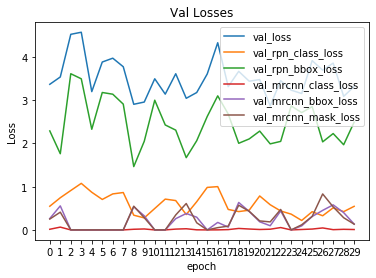

Train Loss 



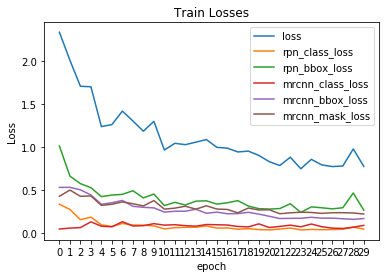

Fine tune Resnet stage 4 and up

Starting at epoch 0. LR=0.001

Checkpoint Path: /home/harsh/Mask_RCNN/logs/shapes20190826T0255/mask_rcnn_shapes_{epoch:04d}.h5
Selecting layers to train
res4a_branch2a         (Conv2D)
bn4a_branch2a          (BatchNorm)
res4a_branch2b         (Conv2D)
bn4a_branch2b          (BatchNorm)
res4a_branch2c         (Conv2D)
res4a_branch1          (Conv2D)
bn4a_branch2c          (BatchNorm)
bn4a_branch1           (BatchNorm)
res4b_branch2a         (Conv2D)
bn4b_branch2a          (BatchNorm)
res4b_branch2b         (Conv2D)
bn4b_branch2b          (BatchNorm)
res4b_branch2c         (Conv2D)
bn4b_branch2c          (BatchNorm)
res4c_branch2a         (Conv2D)
bn4c_branch2a          (BatchNorm)
res4c_branch2b         (Conv2D)
bn4c_branch2b          (BatchNorm)
res4c_branch2c         (Conv2D)
bn4c_branch2c          (BatchNorm)
res4d_branch2a         (Conv2D)
bn4d_branch2a          (BatchNorm)
res4d_branch2b         (Conv2D)
bn4d_branch2b          (BatchNorm)
res4d_bran

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 17/100 [====>.........................] - ETA: 5:09 - loss: 0.6541 - rpn_class_loss: 0.0217 - rpn_bbox_loss: 0.2306 - mrcnn_class_loss: 0.0503 - mrcnn_bbox_loss: 0.1738 - mrcnn_mask_loss: 0.1776

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 19/100 [====>.........................] - ETA: 4:35 - loss: 0.6907 - rpn_class_loss: 0.0228 - rpn_bbox_loss: 0.2660 - mrcnn_class_loss: 0.0479 - mrcnn_bbox_loss: 0.1721 - mrcnn_mask_loss: 0.1818

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 21/100 [=====>........................] - ETA: 4:07 - loss: 0.6944 - rpn_class_loss: 0.0224 - rpn_bbox_loss: 0.2743 - mrcnn_class_loss: 0.0460 - mrcnn_bbox_loss: 0.1658 - mrcnn_mask_loss: 0.1859

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 24/100 [======>.......................] - ETA: 3:34 - loss: 0.6750 - rpn_class_loss: 0.0211 - rpn_bbox_loss: 0.2667 - mrcnn_class_loss: 0.0439 - mrcnn_bbox_loss: 0.1557 - mrcnn_mask_loss: 0.1875

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 26/100 [======>.......................] - ETA: 3:16 - loss: 0.6917 - rpn_class_loss: 0.0206 - rpn_bbox_loss: 0.2960 - mrcnn_class_loss: 0.0406 - mrcnn_bbox_loss: 0.1502 - mrcnn_mask_loss: 0.1841

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 28/100 [=======>......................] - ETA: 3:00 - loss: 0.6971 - rpn_class_loss: 0.0197 - rpn_bbox_loss: 0.3138 - mrcnn_class_loss: 0.0378 - mrcnn_bbox_loss: 0.1451 - mrcnn_mask_loss: 0.1805

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 30/100 [========>.....................] - ETA: 2:46 - loss: 0.6899 - rpn_class_loss: 0.0189 - rpn_bbox_loss: 0.3208 - mrcnn_class_loss: 0.0354 - mrcnn_bbox_loss: 0.1376 - mrcnn_mask_loss: 0.1771

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


100/100 [==============================] - 122s 1s/step - loss: 0.8100 - rpn_class_loss: 0.0343 - rpn_bbox_loss: 0.3304 - mrcnn_class_loss: 0.0548 - mrcnn_bbox_loss: 0.1769 - mrcnn_mask_loss: 0.2135 - val_loss: 4.8436 - val_rpn_class_loss: 0.5140 - val_rpn_bbox_loss: 2.3832 - val_mrcnn_class_loss: 0.0212 - val_mrcnn_bbox_loss: 0.6267 - val_mrcnn_mask_loss: 1.2984
Epoch 2/30
100/100 [==============================] - 66s 660ms/step - loss: 0.9253 - rpn_class_loss: 0.0565 - rpn_bbox_loss: 0.2819 - mrcnn_class_loss: 0.1142 - mrcnn_bbox_loss: 0.1998 - mrcnn_mask_loss: 0.2729 - val_loss: 2.8304 - val_rpn_class_loss: 0.3625 - val_rpn_bbox_loss: 1.5663 - val_mrcnn_class_loss: 0.0472 - val_mrcnn_bbox_loss: 0.4157 - val_mrcnn_mask_loss: 0.4386
Epoch 3/30
100/100 [==============================] - 67s 673ms/step - loss: 0.6456 - rpn_class_loss: 0.0259 - rpn_bbox_loss: 0.1942 - mrcnn_class_loss: 0.0660 - mrcnn_bbox_loss: 0.1452 - mrcnn_mask_loss: 0.2143 - val_loss: 3.5823 - val_rpn_class_loss: 0.

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 22/100 [=====>........................] - ETA: 48s - loss: 1.0350 - rpn_class_loss: 0.1414 - rpn_bbox_loss: 0.2356 - mrcnn_class_loss: 0.1701 - mrcnn_bbox_loss: 0.1713 - mrcnn_mask_loss: 0.3165

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 28/100 [=======>......................] - ETA: 44s - loss: 0.9654 - rpn_class_loss: 0.1167 - rpn_bbox_loss: 0.2384 - mrcnn_class_loss: 0.1489 - mrcnn_bbox_loss: 0.1650 - mrcnn_mask_loss: 0.2962

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 33/100 [========>.....................] - ETA: 41s - loss: 0.9035 - rpn_class_loss: 0.1027 - rpn_bbox_loss: 0.2384 - mrcnn_class_loss: 0.1308 - mrcnn_bbox_loss: 0.1553 - mrcnn_mask_loss: 0.2762

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 39/100 [==========>...................] - ETA: 38s - loss: 0.8973 - rpn_class_loss: 0.0915 - rpn_bbox_loss: 0.2402 - mrcnn_class_loss: 0.1272 - mrcnn_bbox_loss: 0.1614 - mrcnn_mask_loss: 0.2769

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 40/100 [===========>..................] - ETA: 37s - loss: 0.8790 - rpn_class_loss: 0.0893 - rpn_bbox_loss: 0.2347 - mrcnn_class_loss: 0.1241 - mrcnn_bbox_loss: 0.1580 - mrcnn_mask_loss: 0.2728

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 45/100 [============>.................] - ETA: 34s - loss: 0.8741 - rpn_class_loss: 0.0811 - rpn_bbox_loss: 0.2336 - mrcnn_class_loss: 0.1257 - mrcnn_bbox_loss: 0.1596 - mrcnn_mask_loss: 0.2741

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 50/100 [==============>...............] - ETA: 31s - loss: 0.8595 - rpn_class_loss: 0.0755 - rpn_bbox_loss: 0.2327 - mrcnn_class_loss: 0.1185 - mrcnn_bbox_loss: 0.1599 - mrcnn_mask_loss: 0.2726

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


100/100 [==============================] - 66s 663ms/step - loss: 0.7883 - rpn_class_loss: 0.0495 - rpn_bbox_loss: 0.1938 - mrcnn_class_loss: 0.1214 - mrcnn_bbox_loss: 0.1598 - mrcnn_mask_loss: 0.2636 - val_loss: 3.6164 - val_rpn_class_loss: 0.5883 - val_rpn_bbox_loss: 2.6575 - val_mrcnn_class_loss: 0.0145 - val_mrcnn_bbox_loss: 0.1897 - val_mrcnn_mask_loss: 0.1663
Epoch 5/30
100/100 [==============================] - 67s 667ms/step - loss: 0.5281 - rpn_class_loss: 0.0173 - rpn_bbox_loss: 0.1606 - mrcnn_class_loss: 0.0549 - mrcnn_bbox_loss: 0.1101 - mrcnn_mask_loss: 0.1851 - val_loss: 2.8261 - val_rpn_class_loss: 0.4268 - val_rpn_bbox_loss: 1.9121 - val_mrcnn_class_loss: 0.0051 - val_mrcnn_bbox_loss: 0.1978 - val_mrcnn_mask_loss: 0.2842
Epoch 6/30
100/100 [==============================] - 68s 678ms/step - loss: 0.5205 - rpn_class_loss: 0.0193 - rpn_bbox_loss: 0.1540 - mrcnn_class_loss: 0.0520 - mrcnn_bbox_loss: 0.1043 - mrcnn_mask_loss: 0.1908 - val_loss: 4.5921 - val_rpn_class_loss: 

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 36/100 [=========>....................] - ETA: 39s - loss: 0.6852 - rpn_class_loss: 0.0733 - rpn_bbox_loss: 0.1838 - mrcnn_class_loss: 0.0953 - mrcnn_bbox_loss: 0.1119 - mrcnn_mask_loss: 0.2208

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 40/100 [===========>..................] - ETA: 37s - loss: 0.6604 - rpn_class_loss: 0.0675 - rpn_bbox_loss: 0.1756 - mrcnn_class_loss: 0.0952 - mrcnn_bbox_loss: 0.1084 - mrcnn_mask_loss: 0.2136

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 47/100 [=============>................] - ETA: 32s - loss: 0.6986 - rpn_class_loss: 0.0626 - rpn_bbox_loss: 0.1802 - mrcnn_class_loss: 0.1131 - mrcnn_bbox_loss: 0.1199 - mrcnn_mask_loss: 0.2227

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 50/100 [==============>...............] - ETA: 30s - loss: 0.7023 - rpn_class_loss: 0.0604 - rpn_bbox_loss: 0.1790 - mrcnn_class_loss: 0.1177 - mrcnn_bbox_loss: 0.1209 - mrcnn_mask_loss: 0.2241

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 51/100 [==============>...............] - ETA: 30s - loss: 0.7140 - rpn_class_loss: 0.0600 - rpn_bbox_loss: 0.1812 - mrcnn_class_loss: 0.1217 - mrcnn_bbox_loss: 0.1237 - mrcnn_mask_loss: 0.2273

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 57/100 [================>.............] - ETA: 26s - loss: 0.7155 - rpn_class_loss: 0.0561 - rpn_bbox_loss: 0.1801 - mrcnn_class_loss: 0.1211 - mrcnn_bbox_loss: 0.1271 - mrcnn_mask_loss: 0.2310

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 62/100 [=================>............] - ETA: 23s - loss: 0.6915 - rpn_class_loss: 0.0525 - rpn_bbox_loss: 0.1747 - mrcnn_class_loss: 0.1145 - mrcnn_bbox_loss: 0.1230 - mrcnn_mask_loss: 0.2267

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


100/100 [==============================] - 65s 653ms/step - loss: 0.6068 - rpn_class_loss: 0.0381 - rpn_bbox_loss: 0.1467 - mrcnn_class_loss: 0.0905 - mrcnn_bbox_loss: 0.1156 - mrcnn_mask_loss: 0.2158 - val_loss: 5.4406 - val_rpn_class_loss: 1.9324 - val_rpn_bbox_loss: 3.5081 - val_mrcnn_class_loss: 1.1921e-07 - val_mrcnn_bbox_loss: 0.0000e+00 - val_mrcnn_mask_loss: 0.0000e+00
Epoch 8/30
 42/100 [===========>..................] - ETA: 36s - loss: 0.4549 - rpn_class_loss: 0.0118 - rpn_bbox_loss: 0.1038 - mrcnn_class_loss: 0.0434 - mrcnn_bbox_loss: 0.0937 - mrcnn_mask_loss: 0.2021

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 49/100 [=============>................] - ETA: 32s - loss: 0.4581 - rpn_class_loss: 0.0149 - rpn_bbox_loss: 0.1140 - mrcnn_class_loss: 0.0400 - mrcnn_bbox_loss: 0.0921 - mrcnn_mask_loss: 0.1969

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 53/100 [==============>...............] - ETA: 30s - loss: 0.4541 - rpn_class_loss: 0.0141 - rpn_bbox_loss: 0.1127 - mrcnn_class_loss: 0.0394 - mrcnn_bbox_loss: 0.0936 - mrcnn_mask_loss: 0.1942

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 57/100 [================>.............] - ETA: 27s - loss: 0.4715 - rpn_class_loss: 0.0143 - rpn_bbox_loss: 0.1226 - mrcnn_class_loss: 0.0380 - mrcnn_bbox_loss: 0.0973 - mrcnn_mask_loss: 0.1992

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 62/100 [=================>............] - ETA: 24s - loss: 0.4680 - rpn_class_loss: 0.0139 - rpn_bbox_loss: 0.1254 - mrcnn_class_loss: 0.0366 - mrcnn_bbox_loss: 0.0946 - mrcnn_mask_loss: 0.1973

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 64/100 [==================>...........] - ETA: 23s - loss: 0.4770 - rpn_class_loss: 0.0152 - rpn_bbox_loss: 0.1305 - mrcnn_class_loss: 0.0379 - mrcnn_bbox_loss: 0.0954 - mrcnn_mask_loss: 0.1978

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 69/100 [===================>..........] - ETA: 19s - loss: 0.4768 - rpn_class_loss: 0.0146 - rpn_bbox_loss: 0.1311 - mrcnn_class_loss: 0.0369 - mrcnn_bbox_loss: 0.0949 - mrcnn_mask_loss: 0.1993

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 76/100 [=====================>........] - ETA: 15s - loss: 0.4997 - rpn_class_loss: 0.0214 - rpn_bbox_loss: 0.1409 - mrcnn_class_loss: 0.0384 - mrcnn_bbox_loss: 0.0990 - mrcnn_mask_loss: 0.1998

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


100/100 [==============================] - 67s 670ms/step - loss: 0.5632 - rpn_class_loss: 0.0260 - rpn_bbox_loss: 0.1606 - mrcnn_class_loss: 0.0509 - mrcnn_bbox_loss: 0.1138 - mrcnn_mask_loss: 0.2118 - val_loss: 5.3304 - val_rpn_class_loss: 1.7825 - val_rpn_bbox_loss: 2.8512 - val_mrcnn_class_loss: 0.0465 - val_mrcnn_bbox_loss: 0.3552 - val_mrcnn_mask_loss: 0.2948
Epoch 9/30
100/100 [==============================] - 68s 677ms/step - loss: 0.4557 - rpn_class_loss: 0.0149 - rpn_bbox_loss: 0.1110 - mrcnn_class_loss: 0.0543 - mrcnn_bbox_loss: 0.0954 - mrcnn_mask_loss: 0.1799 - val_loss: 2.9646 - val_rpn_class_loss: 0.6043 - val_rpn_bbox_loss: 2.0053 - val_mrcnn_class_loss: 0.0270 - val_mrcnn_bbox_loss: 0.1354 - val_mrcnn_mask_loss: 0.1924
Epoch 10/30
100/100 [==============================] - 67s 666ms/step - loss: 0.6021 - rpn_class_loss: 0.0213 - rpn_bbox_loss: 0.1664 - mrcnn_class_loss: 0.0681 - mrcnn_bbox_loss: 0.1125 - mrcnn_mask_loss: 0.2338 - val_loss: 2.2079 - val_rpn_class_loss:

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


100/100 [==============================] - 66s 665ms/step - loss: 0.4312 - rpn_class_loss: 0.0126 - rpn_bbox_loss: 0.1051 - mrcnn_class_loss: 0.0482 - mrcnn_bbox_loss: 0.0894 - mrcnn_mask_loss: 0.1757 - val_loss: 3.4344 - val_rpn_class_loss: 0.3700 - val_rpn_bbox_loss: 2.0552 - val_mrcnn_class_loss: 0.0104 - val_mrcnn_bbox_loss: 0.6765 - val_mrcnn_mask_loss: 0.3222


/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


Epoch 13/30
  3/100 [..............................] - ETA: 1:01 - loss: 0.4922 - rpn_class_loss: 0.0273 - rpn_bbox_loss: 0.1354 - mrcnn_class_loss: 0.0202 - mrcnn_bbox_loss: 0.0914 - mrcnn_mask_loss: 0.2177

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 10/100 [==>...........................] - ETA: 56s - loss: 0.6527 - rpn_class_loss: 0.0215 - rpn_bbox_loss: 0.1584 - mrcnn_class_loss: 0.0983 - mrcnn_bbox_loss: 0.1373 - mrcnn_mask_loss: 0.2371

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 21/100 [=====>........................] - ETA: 48s - loss: 0.6106 - rpn_class_loss: 0.0177 - rpn_bbox_loss: 0.1546 - mrcnn_class_loss: 0.0869 - mrcnn_bbox_loss: 0.1245 - mrcnn_mask_loss: 0.2268

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 24/100 [======>.......................] - ETA: 46s - loss: 0.5785 - rpn_class_loss: 0.0173 - rpn_bbox_loss: 0.1459 - mrcnn_class_loss: 0.0791 - mrcnn_bbox_loss: 0.1199 - mrcnn_mask_loss: 0.2162

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 29/100 [=======>......................] - ETA: 43s - loss: 0.5446 - rpn_class_loss: 0.0149 - rpn_bbox_loss: 0.1360 - mrcnn_class_loss: 0.0723 - mrcnn_bbox_loss: 0.1159 - mrcnn_mask_loss: 0.2054

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 32/100 [========>.....................] - ETA: 42s - loss: 0.5253 - rpn_class_loss: 0.0138 - rpn_bbox_loss: 0.1302 - mrcnn_class_loss: 0.0677 - mrcnn_bbox_loss: 0.1123 - mrcnn_mask_loss: 0.2011

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 99/100 [============================>.] - ETA: 0s - loss: 0.4686 - rpn_class_loss: 0.0108 - rpn_bbox_loss: 0.1102 - mrcnn_class_loss: 0.0537 - mrcnn_bbox_loss: 0.0933 - mrcnn_mask_loss: 0.2004

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


100/100 [==============================] - 66s 659ms/step - loss: 0.4676 - rpn_class_loss: 0.0108 - rpn_bbox_loss: 0.1106 - mrcnn_class_loss: 0.0533 - mrcnn_bbox_loss: 0.0931 - mrcnn_mask_loss: 0.1996 - val_loss: 5.3260 - val_rpn_class_loss: 1.7240 - val_rpn_bbox_loss: 2.5540 - val_mrcnn_class_loss: 0.1028 - val_mrcnn_bbox_loss: 0.4875 - val_mrcnn_mask_loss: 0.4576
Epoch 14/30
  3/100 [..............................] - ETA: 59s - loss: 0.3889 - rpn_class_loss: 0.0054 - rpn_bbox_loss: 0.1626 - mrcnn_class_loss: 0.0191 - mrcnn_bbox_loss: 0.0377 - mrcnn_mask_loss: 0.1640

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 10/100 [==>...........................] - ETA: 56s - loss: 0.5995 - rpn_class_loss: 0.0248 - rpn_bbox_loss: 0.1835 - mrcnn_class_loss: 0.0588 - mrcnn_bbox_loss: 0.1123 - mrcnn_mask_loss: 0.2199

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 14/100 [===>..........................] - ETA: 53s - loss: 0.5645 - rpn_class_loss: 0.0231 - rpn_bbox_loss: 0.1724 - mrcnn_class_loss: 0.0531 - mrcnn_bbox_loss: 0.1046 - mrcnn_mask_loss: 0.2113

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 25/100 [======>.......................] - ETA: 47s - loss: 0.5323 - rpn_class_loss: 0.0192 - rpn_bbox_loss: 0.1562 - mrcnn_class_loss: 0.0499 - mrcnn_bbox_loss: 0.1019 - mrcnn_mask_loss: 0.2050

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 29/100 [=======>......................] - ETA: 44s - loss: 0.4985 - rpn_class_loss: 0.0171 - rpn_bbox_loss: 0.1446 - mrcnn_class_loss: 0.0454 - mrcnn_bbox_loss: 0.0948 - mrcnn_mask_loss: 0.1965

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 31/100 [========>.....................] - ETA: 43s - loss: 0.5066 - rpn_class_loss: 0.0181 - rpn_bbox_loss: 0.1446 - mrcnn_class_loss: 0.0462 - mrcnn_bbox_loss: 0.0977 - mrcnn_mask_loss: 0.1999

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 36/100 [=========>....................] - ETA: 40s - loss: 0.5009 - rpn_class_loss: 0.0183 - rpn_bbox_loss: 0.1416 - mrcnn_class_loss: 0.0470 - mrcnn_bbox_loss: 0.0956 - mrcnn_mask_loss: 0.1983

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


100/100 [==============================] - 68s 676ms/step - loss: 0.4476 - rpn_class_loss: 0.0148 - rpn_bbox_loss: 0.1172 - mrcnn_class_loss: 0.0437 - mrcnn_bbox_loss: 0.0870 - mrcnn_mask_loss: 0.1849 - val_loss: 2.5532 - val_rpn_class_loss: 0.3882 - val_rpn_bbox_loss: 1.2351 - val_mrcnn_class_loss: 0.0644 - val_mrcnn_bbox_loss: 0.2827 - val_mrcnn_mask_loss: 0.5827
Epoch 15/30
100/100 [==============================] - 66s 664ms/step - loss: 0.4856 - rpn_class_loss: 0.0161 - rpn_bbox_loss: 0.1371 - mrcnn_class_loss: 0.0554 - mrcnn_bbox_loss: 0.0882 - mrcnn_mask_loss: 0.1886 - val_loss: 2.9845 - val_rpn_class_loss: 0.6627 - val_rpn_bbox_loss: 1.7241 - val_mrcnn_class_loss: 0.0096 - val_mrcnn_bbox_loss: 0.3322 - val_mrcnn_mask_loss: 0.2558
Epoch 16/30
100/100 [==============================] - 67s 669ms/step - loss: 0.4347 - rpn_class_loss: 0.0091 - rpn_bbox_loss: 0.0998 - mrcnn_class_loss: 0.0547 - mrcnn_bbox_loss: 0.0848 - mrcnn_mask_loss: 0.1861 - val_loss: 3.8535 - val_rpn_class_loss

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 29/100 [=======>......................] - ETA: 45s - loss: 0.3843 - rpn_class_loss: 0.0075 - rpn_bbox_loss: 0.1075 - mrcnn_class_loss: 0.0297 - mrcnn_bbox_loss: 0.0795 - mrcnn_mask_loss: 0.1599

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 36/100 [=========>....................] - ETA: 41s - loss: 0.4371 - rpn_class_loss: 0.0093 - rpn_bbox_loss: 0.1270 - mrcnn_class_loss: 0.0441 - mrcnn_bbox_loss: 0.0867 - mrcnn_mask_loss: 0.1698

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 43/100 [===========>..................] - ETA: 36s - loss: 0.4439 - rpn_class_loss: 0.0094 - rpn_bbox_loss: 0.1303 - mrcnn_class_loss: 0.0471 - mrcnn_bbox_loss: 0.0853 - mrcnn_mask_loss: 0.1717

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 50/100 [==============>...............] - ETA: 32s - loss: 0.4467 - rpn_class_loss: 0.0099 - rpn_bbox_loss: 0.1313 - mrcnn_class_loss: 0.0482 - mrcnn_bbox_loss: 0.0854 - mrcnn_mask_loss: 0.1717

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 57/100 [================>.............] - ETA: 27s - loss: 0.4404 - rpn_class_loss: 0.0097 - rpn_bbox_loss: 0.1260 - mrcnn_class_loss: 0.0487 - mrcnn_bbox_loss: 0.0831 - mrcnn_mask_loss: 0.1728

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 64/100 [==================>...........] - ETA: 22s - loss: 0.4512 - rpn_class_loss: 0.0096 - rpn_bbox_loss: 0.1248 - mrcnn_class_loss: 0.0536 - mrcnn_bbox_loss: 0.0842 - mrcnn_mask_loss: 0.1789

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 71/100 [====================>.........] - ETA: 18s - loss: 0.4389 - rpn_class_loss: 0.0089 - rpn_bbox_loss: 0.1193 - mrcnn_class_loss: 0.0520 - mrcnn_bbox_loss: 0.0817 - mrcnn_mask_loss: 0.1768

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


100/100 [==============================] - 66s 664ms/step - loss: 0.4020 - rpn_class_loss: 0.0087 - rpn_bbox_loss: 0.1063 - mrcnn_class_loss: 0.0472 - mrcnn_bbox_loss: 0.0723 - mrcnn_mask_loss: 0.1673 - val_loss: 3.4267 - val_rpn_class_loss: 0.5287 - val_rpn_bbox_loss: 2.5777 - val_mrcnn_class_loss: 0.0138 - val_mrcnn_bbox_loss: 0.1527 - val_mrcnn_mask_loss: 0.1536
Epoch 18/30
 91/100 [==========================>...] - ETA: 5s - loss: 0.3132 - rpn_class_loss: 0.0109 - rpn_bbox_loss: 0.0821 - mrcnn_class_loss: 0.0303 - mrcnn_bbox_loss: 0.0517 - mrcnn_mask_loss: 0.1380

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 94/100 [===========================>..] - ETA: 3s - loss: 0.3104 - rpn_class_loss: 0.0106 - rpn_bbox_loss: 0.0818 - mrcnn_class_loss: 0.0297 - mrcnn_bbox_loss: 0.0509 - mrcnn_mask_loss: 0.1373

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


100/100 [==============================] - 66s 660ms/step - loss: 0.3085 - rpn_class_loss: 0.0101 - rpn_bbox_loss: 0.0798 - mrcnn_class_loss: 0.0297 - mrcnn_bbox_loss: 0.0507 - mrcnn_mask_loss: 0.1380 - val_loss: 3.6507 - val_rpn_class_loss: 0.7783 - val_rpn_bbox_loss: 2.4618 - val_mrcnn_class_loss: 3.0844e-04 - val_mrcnn_bbox_loss: 0.2260 - val_mrcnn_mask_loss: 0.1841
Epoch 19/30
  6/100 [>.............................] - ETA: 57s - loss: 0.3296 - rpn_class_loss: 0.0085 - rpn_bbox_loss: 0.0862 - mrcnn_class_loss: 0.0245 - mrcnn_bbox_loss: 0.0565 - mrcnn_mask_loss: 0.1537

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 11/100 [==>...........................] - ETA: 55s - loss: 0.3688 - rpn_class_loss: 0.0182 - rpn_bbox_loss: 0.1003 - mrcnn_class_loss: 0.0260 - mrcnn_bbox_loss: 0.0657 - mrcnn_mask_loss: 0.1585

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 19/100 [====>.........................] - ETA: 51s - loss: 0.3784 - rpn_class_loss: 0.0156 - rpn_bbox_loss: 0.0929 - mrcnn_class_loss: 0.0270 - mrcnn_bbox_loss: 0.0737 - mrcnn_mask_loss: 0.1690

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 23/100 [=====>........................] - ETA: 49s - loss: 0.3656 - rpn_class_loss: 0.0148 - rpn_bbox_loss: 0.0875 - mrcnn_class_loss: 0.0254 - mrcnn_bbox_loss: 0.0722 - mrcnn_mask_loss: 0.1656

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 28/100 [=======>......................] - ETA: 46s - loss: 0.3699 - rpn_class_loss: 0.0142 - rpn_bbox_loss: 0.0876 - mrcnn_class_loss: 0.0262 - mrcnn_bbox_loss: 0.0752 - mrcnn_mask_loss: 0.1666

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 36/100 [=========>....................] - ETA: 40s - loss: 0.3928 - rpn_class_loss: 0.0128 - rpn_bbox_loss: 0.0874 - mrcnn_class_loss: 0.0369 - mrcnn_bbox_loss: 0.0784 - mrcnn_mask_loss: 0.1772

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


100/100 [==============================] - 67s 669ms/step - loss: 0.3691 - rpn_class_loss: 0.0074 - rpn_bbox_loss: 0.0777 - mrcnn_class_loss: 0.0358 - mrcnn_bbox_loss: 0.0723 - mrcnn_mask_loss: 0.1758 - val_loss: 2.7588 - val_rpn_class_loss: 0.5361 - val_rpn_bbox_loss: 1.3390 - val_mrcnn_class_loss: 0.0473 - val_mrcnn_bbox_loss: 0.3037 - val_mrcnn_mask_loss: 0.5326
Epoch 20/30
100/100 [==============================] - 65s 655ms/step - loss: 0.3477 - rpn_class_loss: 0.0047 - rpn_bbox_loss: 0.0718 - mrcnn_class_loss: 0.0515 - mrcnn_bbox_loss: 0.0634 - mrcnn_mask_loss: 0.1561 - val_loss: 3.5119 - val_rpn_class_loss: 0.5822 - val_rpn_bbox_loss: 2.0241 - val_mrcnn_class_loss: 0.0266 - val_mrcnn_bbox_loss: 0.4347 - val_mrcnn_mask_loss: 0.4442
Epoch 21/30
 97/100 [============================>.] - ETA: 1s - loss: 0.3780 - rpn_class_loss: 0.0064 - rpn_bbox_loss: 0.1111 - mrcnn_class_loss: 0.0279 - mrcnn_bbox_loss: 0.0640 - mrcnn_mask_loss: 0.1684

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 98/100 [============================>.] - ETA: 1s - loss: 0.3762 - rpn_class_loss: 0.0064 - rpn_bbox_loss: 0.1103 - mrcnn_class_loss: 0.0277 - mrcnn_bbox_loss: 0.0637 - mrcnn_mask_loss: 0.1680

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


100/100 [==============================] - 66s 664ms/step - loss: 0.3730 - rpn_class_loss: 0.0063 - rpn_bbox_loss: 0.1092 - mrcnn_class_loss: 0.0273 - mrcnn_bbox_loss: 0.0632 - mrcnn_mask_loss: 0.1670 - val_loss: 3.5958 - val_rpn_class_loss: 0.8670 - val_rpn_bbox_loss: 2.2065 - val_mrcnn_class_loss: 0.0303 - val_mrcnn_bbox_loss: 0.2901 - val_mrcnn_mask_loss: 0.2017
Epoch 22/30
  8/100 [=>............................] - ETA: 57s - loss: 0.5182 - rpn_class_loss: 0.0039 - rpn_bbox_loss: 0.1174 - mrcnn_class_loss: 0.0528 - mrcnn_bbox_loss: 0.1107 - mrcnn_mask_loss: 0.2332

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 14/100 [===>..........................] - ETA: 53s - loss: 0.4564 - rpn_class_loss: 0.0029 - rpn_bbox_loss: 0.1098 - mrcnn_class_loss: 0.0514 - mrcnn_bbox_loss: 0.0904 - mrcnn_mask_loss: 0.2018

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 24/100 [======>.......................] - ETA: 48s - loss: 0.4167 - rpn_class_loss: 0.0030 - rpn_bbox_loss: 0.0898 - mrcnn_class_loss: 0.0503 - mrcnn_bbox_loss: 0.0772 - mrcnn_mask_loss: 0.1962

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 26/100 [======>.......................] - ETA: 46s - loss: 0.4066 - rpn_class_loss: 0.0028 - rpn_bbox_loss: 0.0867 - mrcnn_class_loss: 0.0467 - mrcnn_bbox_loss: 0.0751 - mrcnn_mask_loss: 0.1952

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 36/100 [=========>....................] - ETA: 40s - loss: 0.4143 - rpn_class_loss: 0.0054 - rpn_bbox_loss: 0.0946 - mrcnn_class_loss: 0.0505 - mrcnn_bbox_loss: 0.0745 - mrcnn_mask_loss: 0.1892

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 42/100 [===========>..................] - ETA: 36s - loss: 0.4009 - rpn_class_loss: 0.0065 - rpn_bbox_loss: 0.0904 - mrcnn_class_loss: 0.0511 - mrcnn_bbox_loss: 0.0701 - mrcnn_mask_loss: 0.1828

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


100/100 [==============================] - 68s 675ms/step - loss: 0.3515 - rpn_class_loss: 0.0061 - rpn_bbox_loss: 0.0872 - mrcnn_class_loss: 0.0355 - mrcnn_bbox_loss: 0.0613 - mrcnn_mask_loss: 0.1614 - val_loss: 2.2064 - val_rpn_class_loss: 0.2463 - val_rpn_bbox_loss: 1.0548 - val_mrcnn_class_loss: 0.0455 - val_mrcnn_bbox_loss: 0.3812 - val_mrcnn_mask_loss: 0.4784
Epoch 23/30
100/100 [==============================] - 65s 654ms/step - loss: 0.3924 - rpn_class_loss: 0.0071 - rpn_bbox_loss: 0.0957 - mrcnn_class_loss: 0.0477 - mrcnn_bbox_loss: 0.0727 - mrcnn_mask_loss: 0.1691 - val_loss: 2.6661 - val_rpn_class_loss: 0.6950 - val_rpn_bbox_loss: 1.3855 - val_mrcnn_class_loss: 0.0394 - val_mrcnn_bbox_loss: 0.1585 - val_mrcnn_mask_loss: 0.3876
Epoch 24/30
100/100 [==============================] - 68s 676ms/step - loss: 0.3421 - rpn_class_loss: 0.0037 - rpn_bbox_loss: 0.0758 - mrcnn_class_loss: 0.0281 - mrcnn_bbox_loss: 0.0670 - mrcnn_mask_loss: 0.1673 - val_loss: 4.1037 - val_rpn_class_loss

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


100/100 [==============================] - 66s 656ms/step - loss: 0.3977 - rpn_class_loss: 0.0046 - rpn_bbox_loss: 0.0909 - mrcnn_class_loss: 0.0566 - mrcnn_bbox_loss: 0.0690 - mrcnn_mask_loss: 0.1765 - val_loss: 3.0547 - val_rpn_class_loss: 0.4128 - val_rpn_bbox_loss: 2.4841 - val_mrcnn_class_loss: 0.0109 - val_mrcnn_bbox_loss: 0.0329 - val_mrcnn_mask_loss: 0.1139
Epoch 26/30
  2/100 [..............................] - ETA: 58s - loss: 0.5162 - rpn_class_loss: 0.0060 - rpn_bbox_loss: 0.1026 - mrcnn_class_loss: 0.0890 - mrcnn_bbox_loss: 0.0805 - mrcnn_mask_loss: 0.2380

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


  8/100 [=>............................] - ETA: 56s - loss: 0.4276 - rpn_class_loss: 0.0037 - rpn_bbox_loss: 0.1090 - mrcnn_class_loss: 0.0720 - mrcnn_bbox_loss: 0.0631 - mrcnn_mask_loss: 0.1797

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 21/100 [=====>........................] - ETA: 49s - loss: 0.3355 - rpn_class_loss: 0.0028 - rpn_bbox_loss: 0.0742 - mrcnn_class_loss: 0.0482 - mrcnn_bbox_loss: 0.0505 - mrcnn_mask_loss: 0.1597

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 22/100 [=====>........................] - ETA: 48s - loss: 0.3309 - rpn_class_loss: 0.0027 - rpn_bbox_loss: 0.0723 - mrcnn_class_loss: 0.0468 - mrcnn_bbox_loss: 0.0499 - mrcnn_mask_loss: 0.1591

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 27/100 [=======>......................] - ETA: 45s - loss: 0.3339 - rpn_class_loss: 0.0038 - rpn_bbox_loss: 0.0760 - mrcnn_class_loss: 0.0453 - mrcnn_bbox_loss: 0.0519 - mrcnn_mask_loss: 0.1568

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 31/100 [========>.....................] - ETA: 43s - loss: 0.3361 - rpn_class_loss: 0.0041 - rpn_bbox_loss: 0.0766 - mrcnn_class_loss: 0.0418 - mrcnn_bbox_loss: 0.0554 - mrcnn_mask_loss: 0.1580

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 42/100 [===========>..................] - ETA: 36s - loss: 0.3409 - rpn_class_loss: 0.0037 - rpn_bbox_loss: 0.0739 - mrcnn_class_loss: 0.0428 - mrcnn_bbox_loss: 0.0553 - mrcnn_mask_loss: 0.1651

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


100/100 [==============================] - 66s 659ms/step - loss: 0.2910 - rpn_class_loss: 0.0026 - rpn_bbox_loss: 0.0594 - mrcnn_class_loss: 0.0316 - mrcnn_bbox_loss: 0.0483 - mrcnn_mask_loss: 0.1490 - val_loss: 2.6677 - val_rpn_class_loss: 0.2967 - val_rpn_bbox_loss: 1.6733 - val_mrcnn_class_loss: 0.0330 - val_mrcnn_bbox_loss: 0.2908 - val_mrcnn_mask_loss: 0.3738
Epoch 27/30
100/100 [==============================] - 66s 658ms/step - loss: 0.3096 - rpn_class_loss: 0.0048 - rpn_bbox_loss: 0.0740 - mrcnn_class_loss: 0.0277 - mrcnn_bbox_loss: 0.0575 - mrcnn_mask_loss: 0.1454 - val_loss: 3.1423 - val_rpn_class_loss: 0.4229 - val_rpn_bbox_loss: 1.9541 - val_mrcnn_class_loss: 0.0247 - val_mrcnn_bbox_loss: 0.3430 - val_mrcnn_mask_loss: 0.3973
Epoch 28/30
 19/100 [====>.........................] - ETA: 50s - loss: 0.2889 - rpn_class_loss: 0.0013 - rpn_bbox_loss: 0.0890 - mrcnn_class_loss: 0.0177 - mrcnn_bbox_loss: 0.0480 - mrcnn_mask_loss: 0.1328

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 21/100 [=====>........................] - ETA: 49s - loss: 0.2786 - rpn_class_loss: 0.0012 - rpn_bbox_loss: 0.0836 - mrcnn_class_loss: 0.0164 - mrcnn_bbox_loss: 0.0461 - mrcnn_mask_loss: 0.1313

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 32/100 [========>.....................] - ETA: 42s - loss: 0.2754 - rpn_class_loss: 0.0011 - rpn_bbox_loss: 0.0747 - mrcnn_class_loss: 0.0178 - mrcnn_bbox_loss: 0.0485 - mrcnn_mask_loss: 0.1331

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 42/100 [===========>..................] - ETA: 36s - loss: 0.2685 - rpn_class_loss: 0.0023 - rpn_bbox_loss: 0.0681 - mrcnn_class_loss: 0.0189 - mrcnn_bbox_loss: 0.0467 - mrcnn_mask_loss: 0.1323

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 47/100 [=============>................] - ETA: 33s - loss: 0.2631 - rpn_class_loss: 0.0029 - rpn_bbox_loss: 0.0648 - mrcnn_class_loss: 0.0181 - mrcnn_bbox_loss: 0.0459 - mrcnn_mask_loss: 0.1313

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 54/100 [===============>..............] - ETA: 29s - loss: 0.2758 - rpn_class_loss: 0.0030 - rpn_bbox_loss: 0.0726 - mrcnn_class_loss: 0.0186 - mrcnn_bbox_loss: 0.0467 - mrcnn_mask_loss: 0.1347

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 57/100 [================>.............] - ETA: 27s - loss: 0.2713 - rpn_class_loss: 0.0029 - rpn_bbox_loss: 0.0703 - mrcnn_class_loss: 0.0179 - mrcnn_bbox_loss: 0.0456 - mrcnn_mask_loss: 0.1345

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 67/100 [===================>..........] - ETA: 20s - loss: 0.2842 - rpn_class_loss: 0.0035 - rpn_bbox_loss: 0.0700 - mrcnn_class_loss: 0.0203 - mrcnn_bbox_loss: 0.0491 - mrcnn_mask_loss: 0.1411

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


100/100 [==============================] - 66s 663ms/step - loss: 0.3300 - rpn_class_loss: 0.0059 - rpn_bbox_loss: 0.0863 - mrcnn_class_loss: 0.0234 - mrcnn_bbox_loss: 0.0622 - mrcnn_mask_loss: 0.1520 - val_loss: 3.2894 - val_rpn_class_loss: 0.6948 - val_rpn_bbox_loss: 2.1179 - val_mrcnn_class_loss: 0.0126 - val_mrcnn_bbox_loss: 0.3036 - val_mrcnn_mask_loss: 0.1603
Epoch 29/30
100/100 [==============================] - 67s 672ms/step - loss: 0.4708 - rpn_class_loss: 0.0295 - rpn_bbox_loss: 0.1957 - mrcnn_class_loss: 0.0313 - mrcnn_bbox_loss: 0.0607 - mrcnn_mask_loss: 0.1535 - val_loss: 3.7016 - val_rpn_class_loss: 0.9917 - val_rpn_bbox_loss: 2.2357 - val_mrcnn_class_loss: 0.0477 - val_mrcnn_bbox_loss: 0.1584 - val_mrcnn_mask_loss: 0.2680
Epoch 30/30
100/100 [==============================] - 66s 658ms/step - loss: 0.3531 - rpn_class_loss: 0.0068 - rpn_bbox_loss: 0.0919 - mrcnn_class_loss: 0.0398 - mrcnn_bbox_loss: 0.0618 - mrcnn_mask_loss: 0.1527 - val_loss: 4.6976 - val_rpn_class_loss

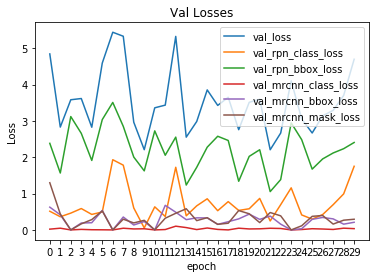

Train Loss 



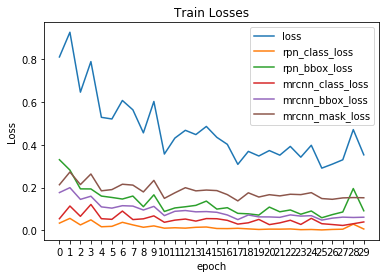

Fine tune all layers

Starting at epoch 0. LR=0.0001

Checkpoint Path: /home/harsh/Mask_RCNN/logs/shapes20190826T0255/mask_rcnn_shapes_{epoch:04d}.h5
Selecting layers to train
conv1                  (Conv2D)
bn_conv1               (BatchNorm)
res2a_branch2a         (Conv2D)
bn2a_branch2a          (BatchNorm)
res2a_branch2b         (Conv2D)
bn2a_branch2b          (BatchNorm)
res2a_branch2c         (Conv2D)
res2a_branch1          (Conv2D)
bn2a_branch2c          (BatchNorm)
bn2a_branch1           (BatchNorm)
res2b_branch2a         (Conv2D)
bn2b_branch2a          (BatchNorm)
res2b_branch2b         (Conv2D)
bn2b_branch2b          (BatchNorm)
res2b_branch2c         (Conv2D)
bn2b_branch2c          (BatchNorm)
res2c_branch2a         (Conv2D)
bn2c_branch2a          (BatchNorm)
res2c_branch2b         (Conv2D)
bn2c_branch2b          (BatchNorm)
res2c_branch2c         (Conv2D)
bn2c_branch2c          (BatchNorm)
res3a_branch2a         (Conv2D)
bn3a_branch2a          (BatchNorm)
res3a_branch2b      

 16/100 [===>..........................] - ETA: 5:46 - loss: 0.3334 - rpn_class_loss: 0.0018 - rpn_bbox_loss: 0.0771 - mrcnn_class_loss: 0.0258 - mrcnn_bbox_loss: 0.0709 - mrcnn_mask_loss: 0.1574

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 17/100 [====>.........................] - ETA: 5:25 - loss: 0.3430 - rpn_class_loss: 0.0020 - rpn_bbox_loss: 0.0831 - mrcnn_class_loss: 0.0248 - mrcnn_bbox_loss: 0.0739 - mrcnn_mask_loss: 0.1588

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 20/100 [=====>........................] - ETA: 4:35 - loss: 0.3655 - rpn_class_loss: 0.0022 - rpn_bbox_loss: 0.0969 - mrcnn_class_loss: 0.0233 - mrcnn_bbox_loss: 0.0806 - mrcnn_mask_loss: 0.1621

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 22/100 [=====>........................] - ETA: 4:08 - loss: 0.3751 - rpn_class_loss: 0.0023 - rpn_bbox_loss: 0.1021 - mrcnn_class_loss: 0.0232 - mrcnn_bbox_loss: 0.0835 - mrcnn_mask_loss: 0.1636

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 23/100 [=====>........................] - ETA: 3:57 - loss: 0.3780 - rpn_class_loss: 0.0024 - rpn_bbox_loss: 0.1036 - mrcnn_class_loss: 0.0227 - mrcnn_bbox_loss: 0.0847 - mrcnn_mask_loss: 0.1643

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 26/100 [======>.......................] - ETA: 3:27 - loss: 0.3744 - rpn_class_loss: 0.0031 - rpn_bbox_loss: 0.1092 - mrcnn_class_loss: 0.0207 - mrcnn_bbox_loss: 0.0805 - mrcnn_mask_loss: 0.1605

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 27/100 [=======>......................] - ETA: 3:19 - loss: 0.3712 - rpn_class_loss: 0.0034 - rpn_bbox_loss: 0.1108 - mrcnn_class_loss: 0.0199 - mrcnn_bbox_loss: 0.0783 - mrcnn_mask_loss: 0.1584

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 29/100 [=======>......................] - ETA: 3:03 - loss: 0.3635 - rpn_class_loss: 0.0037 - rpn_bbox_loss: 0.1119 - mrcnn_class_loss: 0.0186 - mrcnn_bbox_loss: 0.0744 - mrcnn_mask_loss: 0.1545

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


100/100 [==============================] - 131s 1s/step - loss: 0.3711 - rpn_class_loss: 0.0083 - rpn_bbox_loss: 0.1217 - mrcnn_class_loss: 0.0231 - mrcnn_bbox_loss: 0.0741 - mrcnn_mask_loss: 0.1435 - val_loss: 3.7452 - val_rpn_class_loss: 0.5214 - val_rpn_bbox_loss: 2.1576 - val_mrcnn_class_loss: 0.0141 - val_mrcnn_bbox_loss: 0.6240 - val_mrcnn_mask_loss: 0.4276
Epoch 2/30
100/100 [==============================] - 73s 730ms/step - loss: 0.3994 - rpn_class_loss: 0.0036 - rpn_bbox_loss: 0.0948 - mrcnn_class_loss: 0.0528 - mrcnn_bbox_loss: 0.0732 - mrcnn_mask_loss: 0.1747 - val_loss: 2.3951 - val_rpn_class_loss: 0.6418 - val_rpn_bbox_loss: 1.2301 - val_mrcnn_class_loss: 0.0351 - val_mrcnn_bbox_loss: 0.1886 - val_mrcnn_mask_loss: 0.2991
Epoch 3/30
100/100 [==============================] - 74s 744ms/step - loss: 0.2657 - rpn_class_loss: 0.0033 - rpn_bbox_loss: 0.0571 - mrcnn_class_loss: 0.0280 - mrcnn_bbox_loss: 0.0381 - mrcnn_mask_loss: 0.1388 - val_loss: 3.6573 - val_rpn_class_loss: 0.

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 25/100 [======>.......................] - ETA: 52s - loss: 0.5087 - rpn_class_loss: 0.0069 - rpn_bbox_loss: 0.1153 - mrcnn_class_loss: 0.0989 - mrcnn_bbox_loss: 0.0931 - mrcnn_mask_loss: 0.1942

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 31/100 [========>.....................] - ETA: 48s - loss: 0.4693 - rpn_class_loss: 0.0061 - rpn_bbox_loss: 0.1196 - mrcnn_class_loss: 0.0816 - mrcnn_bbox_loss: 0.0822 - mrcnn_mask_loss: 0.1794

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 34/100 [=========>....................] - ETA: 46s - loss: 0.4608 - rpn_class_loss: 0.0060 - rpn_bbox_loss: 0.1160 - mrcnn_class_loss: 0.0792 - mrcnn_bbox_loss: 0.0809 - mrcnn_mask_loss: 0.1782

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 36/100 [=========>....................] - ETA: 44s - loss: 0.4526 - rpn_class_loss: 0.0059 - rpn_bbox_loss: 0.1176 - mrcnn_class_loss: 0.0758 - mrcnn_bbox_loss: 0.0786 - mrcnn_mask_loss: 0.1743

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 40/100 [===========>..................] - ETA: 41s - loss: 0.4441 - rpn_class_loss: 0.0059 - rpn_bbox_loss: 0.1165 - mrcnn_class_loss: 0.0730 - mrcnn_bbox_loss: 0.0769 - mrcnn_mask_loss: 0.1715

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 43/100 [===========>..................] - ETA: 39s - loss: 0.4386 - rpn_class_loss: 0.0058 - rpn_bbox_loss: 0.1130 - mrcnn_class_loss: 0.0720 - mrcnn_bbox_loss: 0.0764 - mrcnn_mask_loss: 0.1710

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 46/100 [============>.................] - ETA: 37s - loss: 0.4265 - rpn_class_loss: 0.0056 - rpn_bbox_loss: 0.1114 - mrcnn_class_loss: 0.0679 - mrcnn_bbox_loss: 0.0738 - mrcnn_mask_loss: 0.1673

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


100/100 [==============================] - 73s 735ms/step - loss: 0.3827 - rpn_class_loss: 0.0053 - rpn_bbox_loss: 0.0921 - mrcnn_class_loss: 0.0557 - mrcnn_bbox_loss: 0.0636 - mrcnn_mask_loss: 0.1656 - val_loss: 4.6505 - val_rpn_class_loss: 1.1885 - val_rpn_bbox_loss: 2.7084 - val_mrcnn_class_loss: 0.0727 - val_mrcnn_bbox_loss: 0.3043 - val_mrcnn_mask_loss: 0.3762
Epoch 5/30
100/100 [==============================] - 74s 741ms/step - loss: 0.2621 - rpn_class_loss: 0.0021 - rpn_bbox_loss: 0.0482 - mrcnn_class_loss: 0.0232 - mrcnn_bbox_loss: 0.0517 - mrcnn_mask_loss: 0.1364 - val_loss: 2.6258 - val_rpn_class_loss: 0.5026 - val_rpn_bbox_loss: 1.8701 - val_mrcnn_class_loss: 0.0101 - val_mrcnn_bbox_loss: 0.1392 - val_mrcnn_mask_loss: 0.1034
Epoch 6/30
100/100 [==============================] - 75s 745ms/step - loss: 0.2105 - rpn_class_loss: 0.0015 - rpn_bbox_loss: 0.0403 - mrcnn_class_loss: 0.0192 - mrcnn_bbox_loss: 0.0357 - mrcnn_mask_loss: 0.1134 - val_loss: 3.7421 - val_rpn_class_loss: 

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 38/100 [==========>...................] - ETA: 43s - loss: 0.3289 - rpn_class_loss: 0.0070 - rpn_bbox_loss: 0.0633 - mrcnn_class_loss: 0.0458 - mrcnn_bbox_loss: 0.0586 - mrcnn_mask_loss: 0.1538

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 39/100 [==========>...................] - ETA: 42s - loss: 0.3239 - rpn_class_loss: 0.0068 - rpn_bbox_loss: 0.0622 - mrcnn_class_loss: 0.0449 - mrcnn_bbox_loss: 0.0575 - mrcnn_mask_loss: 0.1522

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 45/100 [============>.................] - ETA: 38s - loss: 0.3310 - rpn_class_loss: 0.0079 - rpn_bbox_loss: 0.0613 - mrcnn_class_loss: 0.0502 - mrcnn_bbox_loss: 0.0585 - mrcnn_mask_loss: 0.1527

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 48/100 [=============>................] - ETA: 36s - loss: 0.3541 - rpn_class_loss: 0.0087 - rpn_bbox_loss: 0.0645 - mrcnn_class_loss: 0.0576 - mrcnn_bbox_loss: 0.0639 - mrcnn_mask_loss: 0.1590

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 51/100 [==============>...............] - ETA: 34s - loss: 0.3616 - rpn_class_loss: 0.0088 - rpn_bbox_loss: 0.0661 - mrcnn_class_loss: 0.0603 - mrcnn_bbox_loss: 0.0657 - mrcnn_mask_loss: 0.1603

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 58/100 [================>.............] - ETA: 29s - loss: 0.3615 - rpn_class_loss: 0.0084 - rpn_bbox_loss: 0.0666 - mrcnn_class_loss: 0.0601 - mrcnn_bbox_loss: 0.0665 - mrcnn_mask_loss: 0.1595

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 60/100 [=================>............] - ETA: 27s - loss: 0.3574 - rpn_class_loss: 0.0082 - rpn_bbox_loss: 0.0656 - mrcnn_class_loss: 0.0590 - mrcnn_bbox_loss: 0.0655 - mrcnn_mask_loss: 0.1587

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


100/100 [==============================] - 73s 730ms/step - loss: 0.3155 - rpn_class_loss: 0.0058 - rpn_bbox_loss: 0.0593 - mrcnn_class_loss: 0.0443 - mrcnn_bbox_loss: 0.0563 - mrcnn_mask_loss: 0.1494 - val_loss: 4.7253 - val_rpn_class_loss: 1.6981 - val_rpn_bbox_loss: 3.0268 - val_mrcnn_class_loss: 0.0000e+00 - val_mrcnn_bbox_loss: 0.0000e+00 - val_mrcnn_mask_loss: 0.0000e+00
Epoch 8/30
 47/100 [=============>................] - ETA: 37s - loss: 0.2479 - rpn_class_loss: 0.0045 - rpn_bbox_loss: 0.0453 - mrcnn_class_loss: 0.0171 - mrcnn_bbox_loss: 0.0391 - mrcnn_mask_loss: 0.1416

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 49/100 [=============>................] - ETA: 36s - loss: 0.2476 - rpn_class_loss: 0.0044 - rpn_bbox_loss: 0.0452 - mrcnn_class_loss: 0.0168 - mrcnn_bbox_loss: 0.0388 - mrcnn_mask_loss: 0.1421

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 54/100 [===============>..............] - ETA: 32s - loss: 0.2475 - rpn_class_loss: 0.0042 - rpn_bbox_loss: 0.0459 - mrcnn_class_loss: 0.0166 - mrcnn_bbox_loss: 0.0385 - mrcnn_mask_loss: 0.1419

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 58/100 [================>.............] - ETA: 29s - loss: 0.2477 - rpn_class_loss: 0.0041 - rpn_bbox_loss: 0.0466 - mrcnn_class_loss: 0.0163 - mrcnn_bbox_loss: 0.0385 - mrcnn_mask_loss: 0.1418

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 60/100 [=================>............] - ETA: 28s - loss: 0.2470 - rpn_class_loss: 0.0040 - rpn_bbox_loss: 0.0465 - mrcnn_class_loss: 0.0166 - mrcnn_bbox_loss: 0.0381 - mrcnn_mask_loss: 0.1414

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 62/100 [=================>............] - ETA: 26s - loss: 0.2459 - rpn_class_loss: 0.0039 - rpn_bbox_loss: 0.0462 - mrcnn_class_loss: 0.0166 - mrcnn_bbox_loss: 0.0377 - mrcnn_mask_loss: 0.1411

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 68/100 [===================>..........] - ETA: 22s - loss: 0.2428 - rpn_class_loss: 0.0038 - rpn_bbox_loss: 0.0455 - mrcnn_class_loss: 0.0175 - mrcnn_bbox_loss: 0.0367 - mrcnn_mask_loss: 0.1389

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 73/100 [====================>.........] - ETA: 19s - loss: 0.2409 - rpn_class_loss: 0.0037 - rpn_bbox_loss: 0.0445 - mrcnn_class_loss: 0.0194 - mrcnn_bbox_loss: 0.0360 - mrcnn_mask_loss: 0.1369

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


100/100 [==============================] - 74s 739ms/step - loss: 0.2580 - rpn_class_loss: 0.0046 - rpn_bbox_loss: 0.0476 - mrcnn_class_loss: 0.0258 - mrcnn_bbox_loss: 0.0389 - mrcnn_mask_loss: 0.1408 - val_loss: 4.7793 - val_rpn_class_loss: 1.7804 - val_rpn_bbox_loss: 2.4235 - val_mrcnn_class_loss: 0.0691 - val_mrcnn_bbox_loss: 0.2537 - val_mrcnn_mask_loss: 0.2523
Epoch 9/30
100/100 [==============================] - 75s 752ms/step - loss: 0.2338 - rpn_class_loss: 0.0041 - rpn_bbox_loss: 0.0372 - mrcnn_class_loss: 0.0267 - mrcnn_bbox_loss: 0.0404 - mrcnn_mask_loss: 0.1250 - val_loss: 2.5994 - val_rpn_class_loss: 0.5678 - val_rpn_bbox_loss: 1.5561 - val_mrcnn_class_loss: 0.0479 - val_mrcnn_bbox_loss: 0.1351 - val_mrcnn_mask_loss: 0.2921
Epoch 10/30
100/100 [==============================] - 73s 733ms/step - loss: 0.3123 - rpn_class_loss: 0.0069 - rpn_bbox_loss: 0.0605 - mrcnn_class_loss: 0.0389 - mrcnn_bbox_loss: 0.0478 - mrcnn_mask_loss: 0.1578 - val_loss: 2.2336 - val_rpn_class_loss:

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


  5/100 [>.............................] - ETA: 1:06 - loss: 0.5067 - rpn_class_loss: 0.0096 - rpn_bbox_loss: 0.1044 - mrcnn_class_loss: 0.1019 - mrcnn_bbox_loss: 0.0830 - mrcnn_mask_loss: 0.2074

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


  8/100 [=>............................] - ETA: 1:03 - loss: 0.5057 - rpn_class_loss: 0.0117 - rpn_bbox_loss: 0.1064 - mrcnn_class_loss: 0.0989 - mrcnn_bbox_loss: 0.0829 - mrcnn_mask_loss: 0.2054

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 10/100 [==>...........................] - ETA: 1:02 - loss: 0.5179 - rpn_class_loss: 0.0115 - rpn_bbox_loss: 0.1083 - mrcnn_class_loss: 0.1030 - mrcnn_bbox_loss: 0.0846 - mrcnn_mask_loss: 0.2100

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 13/100 [==>...........................] - ETA: 1:01 - loss: 0.4393 - rpn_class_loss: 0.0089 - rpn_bbox_loss: 0.0891 - mrcnn_class_loss: 0.0819 - mrcnn_bbox_loss: 0.0726 - mrcnn_mask_loss: 0.1864

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 19/100 [====>.........................] - ETA: 56s - loss: 0.4051 - rpn_class_loss: 0.0069 - rpn_bbox_loss: 0.0799 - mrcnn_class_loss: 0.0751 - mrcnn_bbox_loss: 0.0686 - mrcnn_mask_loss: 0.1743

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 23/100 [=====>........................] - ETA: 53s - loss: 0.3729 - rpn_class_loss: 0.0059 - rpn_bbox_loss: 0.0727 - mrcnn_class_loss: 0.0666 - mrcnn_bbox_loss: 0.0642 - mrcnn_mask_loss: 0.1632

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 32/100 [========>.....................] - ETA: 47s - loss: 0.3306 - rpn_class_loss: 0.0046 - rpn_bbox_loss: 0.0634 - mrcnn_class_loss: 0.0527 - mrcnn_bbox_loss: 0.0588 - mrcnn_mask_loss: 0.1508

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


100/100 [==============================] - 73s 733ms/step - loss: 0.2698 - rpn_class_loss: 0.0033 - rpn_bbox_loss: 0.0490 - mrcnn_class_loss: 0.0311 - mrcnn_bbox_loss: 0.0472 - mrcnn_mask_loss: 0.1388 - val_loss: 4.7140 - val_rpn_class_loss: 1.4123 - val_rpn_bbox_loss: 2.2033 - val_mrcnn_class_loss: 0.1078 - val_mrcnn_bbox_loss: 0.3969 - val_mrcnn_mask_loss: 0.5933
Epoch 14/30
  8/100 [=>............................] - ETA: 1:04 - loss: 0.1815 - rpn_class_loss: 0.0025 - rpn_bbox_loss: 0.0225 - mrcnn_class_loss: 0.0150 - mrcnn_bbox_loss: 0.0230 - mrcnn_mask_loss: 0.1180

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


  9/100 [=>............................] - ETA: 1:03 - loss: 0.2108 - rpn_class_loss: 0.0024 - rpn_bbox_loss: 0.0266 - mrcnn_class_loss: 0.0204 - mrcnn_bbox_loss: 0.0288 - mrcnn_mask_loss: 0.1323

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 13/100 [==>...........................] - ETA: 1:00 - loss: 0.1872 - rpn_class_loss: 0.0027 - rpn_bbox_loss: 0.0222 - mrcnn_class_loss: 0.0166 - mrcnn_bbox_loss: 0.0243 - mrcnn_mask_loss: 0.1211

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 14/100 [===>..........................] - ETA: 59s - loss: 0.2016 - rpn_class_loss: 0.0030 - rpn_bbox_loss: 0.0264 - mrcnn_class_loss: 0.0186 - mrcnn_bbox_loss: 0.0301 - mrcnn_mask_loss: 0.1231 

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 18/100 [====>.........................] - ETA: 57s - loss: 0.2154 - rpn_class_loss: 0.0029 - rpn_bbox_loss: 0.0291 - mrcnn_class_loss: 0.0213 - mrcnn_bbox_loss: 0.0339 - mrcnn_mask_loss: 0.1278

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 23/100 [=====>........................] - ETA: 54s - loss: 0.2192 - rpn_class_loss: 0.0031 - rpn_bbox_loss: 0.0316 - mrcnn_class_loss: 0.0212 - mrcnn_bbox_loss: 0.0377 - mrcnn_mask_loss: 0.1251

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 27/100 [=======>......................] - ETA: 51s - loss: 0.2071 - rpn_class_loss: 0.0027 - rpn_bbox_loss: 0.0303 - mrcnn_class_loss: 0.0199 - mrcnn_bbox_loss: 0.0347 - mrcnn_mask_loss: 0.1192

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 36/100 [=========>....................] - ETA: 45s - loss: 0.2061 - rpn_class_loss: 0.0024 - rpn_bbox_loss: 0.0318 - mrcnn_class_loss: 0.0193 - mrcnn_bbox_loss: 0.0342 - mrcnn_mask_loss: 0.1180

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


100/100 [==============================] - 74s 745ms/step - loss: 0.2175 - rpn_class_loss: 0.0034 - rpn_bbox_loss: 0.0375 - mrcnn_class_loss: 0.0223 - mrcnn_bbox_loss: 0.0326 - mrcnn_mask_loss: 0.1213 - val_loss: 2.8971 - val_rpn_class_loss: 0.8186 - val_rpn_bbox_loss: 1.1863 - val_mrcnn_class_loss: 0.0828 - val_mrcnn_bbox_loss: 0.1868 - val_mrcnn_mask_loss: 0.6222
Epoch 15/30
100/100 [==============================] - 74s 735ms/step - loss: 0.2918 - rpn_class_loss: 0.0049 - rpn_bbox_loss: 0.0708 - mrcnn_class_loss: 0.0325 - mrcnn_bbox_loss: 0.0438 - mrcnn_mask_loss: 0.1394 - val_loss: 3.2030 - val_rpn_class_loss: 1.0397 - val_rpn_bbox_loss: 2.0619 - val_mrcnn_class_loss: 0.0128 - val_mrcnn_bbox_loss: 0.0417 - val_mrcnn_mask_loss: 0.0464
Epoch 16/30
100/100 [==============================] - 74s 739ms/step - loss: 0.2603 - rpn_class_loss: 0.0023 - rpn_bbox_loss: 0.0440 - mrcnn_class_loss: 0.0339 - mrcnn_bbox_loss: 0.0413 - mrcnn_mask_loss: 0.1383 - val_loss: 3.8483 - val_rpn_class_loss

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 38/100 [==========>...................] - ETA: 44s - loss: 0.2447 - rpn_class_loss: 0.0025 - rpn_bbox_loss: 0.0527 - mrcnn_class_loss: 0.0260 - mrcnn_bbox_loss: 0.0409 - mrcnn_mask_loss: 0.1221

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 41/100 [===========>..................] - ETA: 41s - loss: 0.2407 - rpn_class_loss: 0.0024 - rpn_bbox_loss: 0.0523 - mrcnn_class_loss: 0.0253 - mrcnn_bbox_loss: 0.0398 - mrcnn_mask_loss: 0.1206

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 42/100 [===========>..................] - ETA: 41s - loss: 0.2517 - rpn_class_loss: 0.0029 - rpn_bbox_loss: 0.0543 - mrcnn_class_loss: 0.0287 - mrcnn_bbox_loss: 0.0410 - mrcnn_mask_loss: 0.1245

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 48/100 [=============>................] - ETA: 36s - loss: 0.2666 - rpn_class_loss: 0.0035 - rpn_bbox_loss: 0.0567 - mrcnn_class_loss: 0.0338 - mrcnn_bbox_loss: 0.0420 - mrcnn_mask_loss: 0.1302

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 52/100 [==============>...............] - ETA: 33s - loss: 0.2694 - rpn_class_loss: 0.0037 - rpn_bbox_loss: 0.0570 - mrcnn_class_loss: 0.0346 - mrcnn_bbox_loss: 0.0417 - mrcnn_mask_loss: 0.1320

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 53/100 [==============>...............] - ETA: 33s - loss: 0.2687 - rpn_class_loss: 0.0037 - rpn_bbox_loss: 0.0568 - mrcnn_class_loss: 0.0346 - mrcnn_bbox_loss: 0.0415 - mrcnn_mask_loss: 0.1319

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 67/100 [===================>..........] - ETA: 23s - loss: 0.2634 - rpn_class_loss: 0.0034 - rpn_bbox_loss: 0.0545 - mrcnn_class_loss: 0.0340 - mrcnn_bbox_loss: 0.0399 - mrcnn_mask_loss: 0.1311

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


100/100 [==============================] - 73s 731ms/step - loss: 0.2484 - rpn_class_loss: 0.0027 - rpn_bbox_loss: 0.0503 - mrcnn_class_loss: 0.0319 - mrcnn_bbox_loss: 0.0367 - mrcnn_mask_loss: 0.1263 - val_loss: 3.8858 - val_rpn_class_loss: 0.6501 - val_rpn_bbox_loss: 2.6336 - val_mrcnn_class_loss: 0.0207 - val_mrcnn_bbox_loss: 0.3093 - val_mrcnn_mask_loss: 0.2718
Epoch 18/30
 96/100 [===========================>..] - ETA: 2s - loss: 0.1718 - rpn_class_loss: 0.0020 - rpn_bbox_loss: 0.0297 - mrcnn_class_loss: 0.0196 - mrcnn_bbox_loss: 0.0218 - mrcnn_mask_loss: 0.0984

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


100/100 [==============================] - 73s 732ms/step - loss: 0.1695 - rpn_class_loss: 0.0021 - rpn_bbox_loss: 0.0290 - mrcnn_class_loss: 0.0191 - mrcnn_bbox_loss: 0.0214 - mrcnn_mask_loss: 0.0975 - val_loss: 3.8274 - val_rpn_class_loss: 0.9432 - val_rpn_bbox_loss: 2.5237 - val_mrcnn_class_loss: 2.5096e-04 - val_mrcnn_bbox_loss: 0.2122 - val_mrcnn_mask_loss: 0.1478
Epoch 19/30
  6/100 [>.............................] - ETA: 1:04 - loss: 0.1773 - rpn_class_loss: 0.0062 - rpn_bbox_loss: 0.0250 - mrcnn_class_loss: 0.0142 - mrcnn_bbox_loss: 0.0212 - mrcnn_mask_loss: 0.1103

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


  8/100 [=>............................] - ETA: 1:03 - loss: 0.1881 - rpn_class_loss: 0.0048 - rpn_bbox_loss: 0.0322 - mrcnn_class_loss: 0.0148 - mrcnn_bbox_loss: 0.0244 - mrcnn_mask_loss: 0.1116

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 10/100 [==>...........................] - ETA: 1:01 - loss: 0.1696 - rpn_class_loss: 0.0040 - rpn_bbox_loss: 0.0270 - mrcnn_class_loss: 0.0129 - mrcnn_bbox_loss: 0.0211 - mrcnn_mask_loss: 0.1043

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 17/100 [====>.........................] - ETA: 57s - loss: 0.1885 - rpn_class_loss: 0.0042 - rpn_bbox_loss: 0.0259 - mrcnn_class_loss: 0.0177 - mrcnn_bbox_loss: 0.0249 - mrcnn_mask_loss: 0.1154

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 19/100 [====>.........................] - ETA: 56s - loss: 0.1923 - rpn_class_loss: 0.0044 - rpn_bbox_loss: 0.0269 - mrcnn_class_loss: 0.0185 - mrcnn_bbox_loss: 0.0261 - mrcnn_mask_loss: 0.1159

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 22/100 [=====>........................] - ETA: 54s - loss: 0.1925 - rpn_class_loss: 0.0044 - rpn_bbox_loss: 0.0265 - mrcnn_class_loss: 0.0193 - mrcnn_bbox_loss: 0.0258 - mrcnn_mask_loss: 0.1162

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 35/100 [=========>....................] - ETA: 46s - loss: 0.1891 - rpn_class_loss: 0.0041 - rpn_bbox_loss: 0.0261 - mrcnn_class_loss: 0.0180 - mrcnn_bbox_loss: 0.0269 - mrcnn_mask_loss: 0.1136

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


100/100 [==============================] - 74s 739ms/step - loss: 0.2179 - rpn_class_loss: 0.0023 - rpn_bbox_loss: 0.0314 - mrcnn_class_loss: 0.0221 - mrcnn_bbox_loss: 0.0336 - mrcnn_mask_loss: 0.1280 - val_loss: 3.1668 - val_rpn_class_loss: 0.8997 - val_rpn_bbox_loss: 1.2697 - val_mrcnn_class_loss: 0.1103 - val_mrcnn_bbox_loss: 0.1656 - val_mrcnn_mask_loss: 0.7211
Epoch 20/30
100/100 [==============================] - 73s 729ms/step - loss: 0.2181 - rpn_class_loss: 0.0015 - rpn_bbox_loss: 0.0325 - mrcnn_class_loss: 0.0330 - mrcnn_bbox_loss: 0.0338 - mrcnn_mask_loss: 0.1170 - val_loss: 3.6385 - val_rpn_class_loss: 0.6900 - val_rpn_bbox_loss: 1.9890 - val_mrcnn_class_loss: 0.0437 - val_mrcnn_bbox_loss: 0.4036 - val_mrcnn_mask_loss: 0.5118
Epoch 21/30
100/100 [==============================] - 74s 740ms/step - loss: 0.2091 - rpn_class_loss: 0.0023 - rpn_bbox_loss: 0.0407 - mrcnn_class_loss: 0.0200 - mrcnn_bbox_loss: 0.0301 - mrcnn_mask_loss: 0.1156 - val_loss: 3.6740 - val_rpn_class_loss

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


  8/100 [=>............................] - ETA: 1:02 - loss: 0.2751 - rpn_class_loss: 6.8044e-04 - rpn_bbox_loss: 0.0380 - mrcnn_class_loss: 0.0292 - mrcnn_bbox_loss: 0.0467 - mrcnn_mask_loss: 0.1601

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 12/100 [==>...........................] - ETA: 1:00 - loss: 0.2405 - rpn_class_loss: 7.3035e-04 - rpn_bbox_loss: 0.0311 - mrcnn_class_loss: 0.0234 - mrcnn_bbox_loss: 0.0377 - mrcnn_mask_loss: 0.1471

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 14/100 [===>..........................] - ETA: 59s - loss: 0.2219 - rpn_class_loss: 7.2096e-04 - rpn_bbox_loss: 0.0288 - mrcnn_class_loss: 0.0204 - mrcnn_bbox_loss: 0.0341 - mrcnn_mask_loss: 0.1375 

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 19/100 [====>.........................] - ETA: 55s - loss: 0.2512 - rpn_class_loss: 7.1403e-04 - rpn_bbox_loss: 0.0331 - mrcnn_class_loss: 0.0294 - mrcnn_bbox_loss: 0.0380 - mrcnn_mask_loss: 0.1496

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 25/100 [======>.......................] - ETA: 51s - loss: 0.2568 - rpn_class_loss: 7.1962e-04 - rpn_bbox_loss: 0.0344 - mrcnn_class_loss: 0.0331 - mrcnn_bbox_loss: 0.0380 - mrcnn_mask_loss: 0.1503

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 31/100 [========>.....................] - ETA: 48s - loss: 0.2340 - rpn_class_loss: 7.1614e-04 - rpn_bbox_loss: 0.0312 - mrcnn_class_loss: 0.0286 - mrcnn_bbox_loss: 0.0341 - mrcnn_mask_loss: 0.1391

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 36/100 [=========>....................] - ETA: 44s - loss: 0.2371 - rpn_class_loss: 7.0498e-04 - rpn_bbox_loss: 0.0317 - mrcnn_class_loss: 0.0313 - mrcnn_bbox_loss: 0.0337 - mrcnn_mask_loss: 0.1392

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


100/100 [==============================] - 75s 747ms/step - loss: 0.1838 - rpn_class_loss: 0.0012 - rpn_bbox_loss: 0.0241 - mrcnn_class_loss: 0.0243 - mrcnn_bbox_loss: 0.0229 - mrcnn_mask_loss: 0.1110 - val_loss: 2.5322 - val_rpn_class_loss: 0.6171 - val_rpn_bbox_loss: 1.3367 - val_mrcnn_class_loss: 0.0621 - val_mrcnn_bbox_loss: 0.1346 - val_mrcnn_mask_loss: 0.3812
Epoch 23/30
100/100 [==============================] - 72s 725ms/step - loss: 0.2278 - rpn_class_loss: 0.0013 - rpn_bbox_loss: 0.0385 - mrcnn_class_loss: 0.0339 - mrcnn_bbox_loss: 0.0307 - mrcnn_mask_loss: 0.1231 - val_loss: 2.9912 - val_rpn_class_loss: 0.9590 - val_rpn_bbox_loss: 1.5233 - val_mrcnn_class_loss: 0.0485 - val_mrcnn_bbox_loss: 0.0966 - val_mrcnn_mask_loss: 0.3634
Epoch 24/30
100/100 [==============================] - 75s 747ms/step - loss: 0.1821 - rpn_class_loss: 6.1856e-04 - rpn_bbox_loss: 0.0275 - mrcnn_class_loss: 0.0166 - mrcnn_bbox_loss: 0.0244 - mrcnn_mask_loss: 0.1126 - val_loss: 3.7524 - val_rpn_class_

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


Epoch 26/30
  4/100 [>.............................] - ETA: 1:05 - loss: 0.1587 - rpn_class_loss: 4.8122e-04 - rpn_bbox_loss: 0.0198 - mrcnn_class_loss: 0.0255 - mrcnn_bbox_loss: 0.0205 - mrcnn_mask_loss: 0.0921

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 13/100 [==>...........................] - ETA: 1:00 - loss: 0.1939 - rpn_class_loss: 5.9549e-04 - rpn_bbox_loss: 0.0265 - mrcnn_class_loss: 0.0337 - mrcnn_bbox_loss: 0.0240 - mrcnn_mask_loss: 0.1086

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 16/100 [===>..........................] - ETA: 58s - loss: 0.1860 - rpn_class_loss: 5.0334e-04 - rpn_bbox_loss: 0.0260 - mrcnn_class_loss: 0.0302 - mrcnn_bbox_loss: 0.0227 - mrcnn_mask_loss: 0.1062

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 22/100 [=====>........................] - ETA: 54s - loss: 0.1854 - rpn_class_loss: 5.1256e-04 - rpn_bbox_loss: 0.0264 - mrcnn_class_loss: 0.0282 - mrcnn_bbox_loss: 0.0223 - mrcnn_mask_loss: 0.1076

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 26/100 [======>.......................] - ETA: 51s - loss: 0.1875 - rpn_class_loss: 4.7529e-04 - rpn_bbox_loss: 0.0268 - mrcnn_class_loss: 0.0282 - mrcnn_bbox_loss: 0.0220 - mrcnn_mask_loss: 0.1096

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 31/100 [========>.....................] - ETA: 48s - loss: 0.2007 - rpn_class_loss: 5.7526e-04 - rpn_bbox_loss: 0.0298 - mrcnn_class_loss: 0.0294 - mrcnn_bbox_loss: 0.0244 - mrcnn_mask_loss: 0.1161

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 35/100 [=========>....................] - ETA: 45s - loss: 0.1984 - rpn_class_loss: 5.9306e-04 - rpn_bbox_loss: 0.0292 - mrcnn_class_loss: 0.0286 - mrcnn_bbox_loss: 0.0236 - mrcnn_mask_loss: 0.1160

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


100/100 [==============================] - 73s 733ms/step - loss: 0.1670 - rpn_class_loss: 7.2954e-04 - rpn_bbox_loss: 0.0224 - mrcnn_class_loss: 0.0194 - mrcnn_bbox_loss: 0.0198 - mrcnn_mask_loss: 0.1044 - val_loss: 2.7839 - val_rpn_class_loss: 0.4839 - val_rpn_bbox_loss: 1.7119 - val_mrcnn_class_loss: 0.0393 - val_mrcnn_bbox_loss: 0.1678 - val_mrcnn_mask_loss: 0.3806
Epoch 27/30
100/100 [==============================] - 73s 735ms/step - loss: 0.1640 - rpn_class_loss: 0.0014 - rpn_bbox_loss: 0.0220 - mrcnn_class_loss: 0.0154 - mrcnn_bbox_loss: 0.0191 - mrcnn_mask_loss: 0.1058 - val_loss: 3.0640 - val_rpn_class_loss: 0.5348 - val_rpn_bbox_loss: 1.7309 - val_mrcnn_class_loss: 0.0412 - val_mrcnn_bbox_loss: 0.3029 - val_mrcnn_mask_loss: 0.4538
Epoch 28/30
 24/100 [======>.......................] - ETA: 53s - loss: 0.1365 - rpn_class_loss: 5.0151e-04 - rpn_bbox_loss: 0.0195 - mrcnn_class_loss: 0.0122 - mrcnn_bbox_loss: 0.0164 - mrcnn_mask_loss: 0.0876

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 29/100 [=======>......................] - ETA: 49s - loss: 0.1339 - rpn_class_loss: 4.5674e-04 - rpn_bbox_loss: 0.0187 - mrcnn_class_loss: 0.0119 - mrcnn_bbox_loss: 0.0159 - mrcnn_mask_loss: 0.0866

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 34/100 [=========>....................] - ETA: 46s - loss: 0.1385 - rpn_class_loss: 4.4144e-04 - rpn_bbox_loss: 0.0185 - mrcnn_class_loss: 0.0129 - mrcnn_bbox_loss: 0.0162 - mrcnn_mask_loss: 0.0902

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 41/100 [===========>..................] - ETA: 41s - loss: 0.1341 - rpn_class_loss: 4.1103e-04 - rpn_bbox_loss: 0.0168 - mrcnn_class_loss: 0.0119 - mrcnn_bbox_loss: 0.0154 - mrcnn_mask_loss: 0.0892

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 45/100 [============>.................] - ETA: 38s - loss: 0.1306 - rpn_class_loss: 4.1097e-04 - rpn_bbox_loss: 0.0158 - mrcnn_class_loss: 0.0113 - mrcnn_bbox_loss: 0.0148 - mrcnn_mask_loss: 0.0880

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 51/100 [==============>...............] - ETA: 34s - loss: 0.1357 - rpn_class_loss: 0.0013 - rpn_bbox_loss: 0.0172 - mrcnn_class_loss: 0.0118 - mrcnn_bbox_loss: 0.0154 - mrcnn_mask_loss: 0.0897

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 56/100 [===============>..............] - ETA: 31s - loss: 0.1393 - rpn_class_loss: 0.0016 - rpn_bbox_loss: 0.0183 - mrcnn_class_loss: 0.0118 - mrcnn_bbox_loss: 0.0159 - mrcnn_mask_loss: 0.0913

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 60/100 [=================>............] - ETA: 28s - loss: 0.1408 - rpn_class_loss: 0.0015 - rpn_bbox_loss: 0.0187 - mrcnn_class_loss: 0.0121 - mrcnn_bbox_loss: 0.0161 - mrcnn_mask_loss: 0.0920

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


100/100 [==============================] - 74s 736ms/step - loss: 0.1623 - rpn_class_loss: 0.0016 - rpn_bbox_loss: 0.0226 - mrcnn_class_loss: 0.0147 - mrcnn_bbox_loss: 0.0195 - mrcnn_mask_loss: 0.1035 - val_loss: 3.4143 - val_rpn_class_loss: 0.8480 - val_rpn_bbox_loss: 1.9786 - val_mrcnn_class_loss: 0.0162 - val_mrcnn_bbox_loss: 0.2945 - val_mrcnn_mask_loss: 0.2765
Epoch 29/30
100/100 [==============================] - 74s 744ms/step - loss: 0.2809 - rpn_class_loss: 0.0148 - rpn_bbox_loss: 0.1085 - mrcnn_class_loss: 0.0219 - mrcnn_bbox_loss: 0.0254 - mrcnn_mask_loss: 0.1099 - val_loss: 4.1279 - val_rpn_class_loss: 1.3004 - val_rpn_bbox_loss: 2.2527 - val_mrcnn_class_loss: 0.0687 - val_mrcnn_bbox_loss: 0.2151 - val_mrcnn_mask_loss: 0.2906
Epoch 30/30
100/100 [==============================] - 73s 732ms/step - loss: 0.2089 - rpn_class_loss: 0.0019 - rpn_bbox_loss: 0.0397 - mrcnn_class_loss: 0.0290 - mrcnn_bbox_loss: 0.0260 - mrcnn_mask_loss: 0.1119 - val_loss: 4.3109 - val_rpn_class_loss

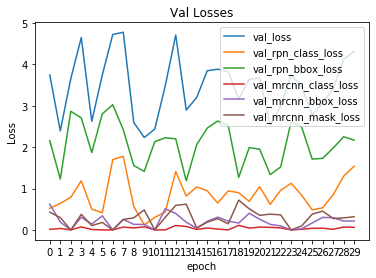

Train Loss 



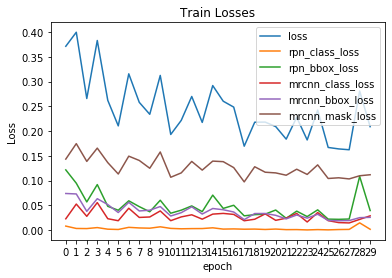

In [19]:
        
model.train(dataset_train, dataset_val, 
            learning_rate=config.LEARNING_RATE, 
            epochs=30, 
            layers='heads', augmentation= seq)

# Training - Stage 2
# Finetune layers from ResNet stage 4 and up
print("Fine tune Resnet stage 4 and up")
model.train(dataset_train, dataset_val,
            learning_rate=config.LEARNING_RATE,
            epochs=30,
            layers='4+',
            augmentation=seq)


# Training - Stage 3
# Fine tune all layers
print("Fine tune all layers")
model.train(dataset_train, dataset_val,
            learning_rate=config.LEARNING_RATE / 10,
            epochs=30,
            layers='all',
            augmentation=seq)


In [20]:
class ShapesConfig(Config):
    """Configuration for training on the toy shapes dataset.
    Derives from the base Config class and overrides values specific
    to the toy shapes dataset.
    """
    # Give the configuration a recognizable name
    NAME = "shapes"

    # Train on 1 GPU and 1 images per GPU. We can put multiple images on each
    # GPU because the images are small. Batch size is 1 (GPUs * images/GPU).
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1
    STEPS_PER_EPOCH = 100
    # Number of classes (including background)
    NUM_CLASSES = 1 + 1  # background + 1 shapes

    # Use small images for faster training. Set the limits of the small side
    # the large side, and that determines the image shape.
    #IMAGE_MIN_DIM = 128
    #IMAGE_MAX_DIM = 128

    # Use smaller anchors because our image and objects are small
    RPN_ANCHOR_SCALES = (32, 64, 128, 256, 512, 768, 1024)  # anchor side in pixels
    BACKBONE_STRIDES =  [4, 8, 16, 32, 64, 128, 256]
    # Reduce training ROIs per image because the images are small and have
    # few objects. Aim to allow ROI sampling to pick 33% positive ROIs.
    #TRAIN_ROIS_PER_IMAGE = 32

    # Use a small epoch since the data is simple
    #STEPS_PER_EPOCH = 100

    # use small validation steps since the epoch is small
    VALIDATION_STEPS = 10
    #WEIGHT_DECAY = 0.005
    
config = ShapesConfig()
config.display()


Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64, 128, 256]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 1
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  1024
IMAGE_META_SIZE                14
IMAGE_MIN_DIM                  800
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [1024 1024    3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAP


Starting at epoch 0. LR=0.001

Checkpoint Path: /home/harsh/Mask_RCNN/logs/shapes20190826T0958/mask_rcnn_shapes_{epoch:04d}.h5
Selecting layers to train
fpn_c5p5               (Conv2D)
fpn_c4p4               (Conv2D)
fpn_c3p3               (Conv2D)
fpn_c2p2               (Conv2D)
fpn_p5                 (Conv2D)
fpn_p2                 (Conv2D)
fpn_p3                 (Conv2D)
fpn_p4                 (Conv2D)
In model:  rpn_model
    rpn_conv_shared        (Conv2D)
    rpn_class_raw          (Conv2D)
    rpn_bbox_pred          (Conv2D)
mrcnn_mask_conv1       (TimeDistributed)
mrcnn_mask_bn1         (TimeDistributed)
mrcnn_mask_conv2       (TimeDistributed)
mrcnn_mask_bn2         (TimeDistributed)
mrcnn_class_conv1      (TimeDistributed)
mrcnn_class_bn1        (TimeDistributed)
mrcnn_mask_conv3       (TimeDistributed)
mrcnn_mask_bn3         (TimeDistributed)
mrcnn_class_conv2      (TimeDistributed)
mrcnn_class_bn2        (TimeDistributed)
mrcnn_mask_conv4       (TimeDistributed)
mrcnn_mask

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 74/100 [=====================>........] - ETA: 28s - loss: 2.8348 - rpn_class_loss: 0.3993 - rpn_bbox_loss: 1.2206 - mrcnn_class_loss: 0.1081 - mrcnn_bbox_loss: 0.6427 - mrcnn_mask_loss: 0.4642

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 77/100 [======================>.......] - ETA: 24s - loss: 2.8352 - rpn_class_loss: 0.3975 - rpn_bbox_loss: 1.1973 - mrcnn_class_loss: 0.1052 - mrcnn_bbox_loss: 0.6568 - mrcnn_mask_loss: 0.4783

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 78/100 [======================>.......] - ETA: 23s - loss: 2.8255 - rpn_class_loss: 0.3969 - rpn_bbox_loss: 1.1888 - mrcnn_class_loss: 0.1045 - mrcnn_bbox_loss: 0.6539 - mrcnn_mask_loss: 0.4814

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 79/100 [======================>.......] - ETA: 21s - loss: 2.8176 - rpn_class_loss: 0.3961 - rpn_bbox_loss: 1.1802 - mrcnn_class_loss: 0.1040 - mrcnn_bbox_loss: 0.6532 - mrcnn_mask_loss: 0.4840

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 80/100 [=======================>......] - ETA: 20s - loss: 2.8101 - rpn_class_loss: 0.3951 - rpn_bbox_loss: 1.1717 - mrcnn_class_loss: 0.1036 - mrcnn_bbox_loss: 0.6538 - mrcnn_mask_loss: 0.4859

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 83/100 [=======================>......] - ETA: 17s - loss: 2.7895 - rpn_class_loss: 0.3831 - rpn_bbox_loss: 1.1536 - mrcnn_class_loss: 0.1010 - mrcnn_bbox_loss: 0.6608 - mrcnn_mask_loss: 0.4910

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 84/100 [========================>.....] - ETA: 16s - loss: 2.7782 - rpn_class_loss: 0.3792 - rpn_bbox_loss: 1.1466 - mrcnn_class_loss: 0.1003 - mrcnn_bbox_loss: 0.6594 - mrcnn_mask_loss: 0.4928

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


100/100 [==============================] - 98s 977ms/step - loss: 2.6220 - rpn_class_loss: 0.3558 - rpn_bbox_loss: 1.0587 - mrcnn_class_loss: 0.0905 - mrcnn_bbox_loss: 0.6273 - mrcnn_mask_loss: 0.4898 - val_loss: 3.6346 - val_rpn_class_loss: 0.4265 - val_rpn_bbox_loss: 2.9538 - val_mrcnn_class_loss: 0.0125 - val_mrcnn_bbox_loss: 0.0967 - val_mrcnn_mask_loss: 0.1451
Epoch 2/30
100/100 [==============================] - 75s 747ms/step - loss: 1.9896 - rpn_class_loss: 0.1773 - rpn_bbox_loss: 0.6782 - mrcnn_class_loss: 0.0412 - mrcnn_bbox_loss: 0.6320 - mrcnn_mask_loss: 0.4609 - val_loss: 2.8383 - val_rpn_class_loss: 0.3431 - val_rpn_bbox_loss: 1.7723 - val_mrcnn_class_loss: 0.0316 - val_mrcnn_bbox_loss: 0.2415 - val_mrcnn_mask_loss: 0.4498
Epoch 3/30
100/100 [==============================] - 69s 695ms/step - loss: 1.8606 - rpn_class_loss: 0.2269 - rpn_bbox_loss: 0.5681 - mrcnn_class_loss: 0.0915 - mrcnn_bbox_loss: 0.5095 - mrcnn_mask_loss: 0.4647 - val_loss: 5.0767 - val_rpn_class_loss: 

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 87/100 [=========================>....] - ETA: 6s - loss: 1.6571 - rpn_class_loss: 0.2469 - rpn_bbox_loss: 0.5947 - mrcnn_class_loss: 0.0704 - mrcnn_bbox_loss: 0.4077 - mrcnn_mask_loss: 0.3374

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 89/100 [=========================>....] - ETA: 5s - loss: 1.6456 - rpn_class_loss: 0.2434 - rpn_bbox_loss: 0.5928 - mrcnn_class_loss: 0.0697 - mrcnn_bbox_loss: 0.4047 - mrcnn_mask_loss: 0.3350

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 91/100 [==========================>...] - ETA: 4s - loss: 1.6471 - rpn_class_loss: 0.2428 - rpn_bbox_loss: 0.5971 - mrcnn_class_loss: 0.0690 - mrcnn_bbox_loss: 0.4053 - mrcnn_mask_loss: 0.3329

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 93/100 [==========================>...] - ETA: 3s - loss: 1.6382 - rpn_class_loss: 0.2396 - rpn_bbox_loss: 0.5940 - mrcnn_class_loss: 0.0681 - mrcnn_bbox_loss: 0.4044 - mrcnn_mask_loss: 0.3321

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 95/100 [===========================>..] - ETA: 2s - loss: 1.6278 - rpn_class_loss: 0.2364 - rpn_bbox_loss: 0.5906 - mrcnn_class_loss: 0.0673 - mrcnn_bbox_loss: 0.4021 - mrcnn_mask_loss: 0.3314

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 97/100 [============================>.] - ETA: 1s - loss: 1.6152 - rpn_class_loss: 0.2332 - rpn_bbox_loss: 0.5866 - mrcnn_class_loss: 0.0664 - mrcnn_bbox_loss: 0.3984 - mrcnn_mask_loss: 0.3306

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 99/100 [============================>.] - ETA: 0s - loss: 1.6143 - rpn_class_loss: 0.2323 - rpn_bbox_loss: 0.5873 - mrcnn_class_loss: 0.0658 - mrcnn_bbox_loss: 0.3991 - mrcnn_mask_loss: 0.3298

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


100/100 [==============================] - 54s 544ms/step - loss: 1.6129 - rpn_class_loss: 0.2310 - rpn_bbox_loss: 0.5883 - mrcnn_class_loss: 0.0654 - mrcnn_bbox_loss: 0.3988 - mrcnn_mask_loss: 0.3293 - val_loss: 4.0551 - val_rpn_class_loss: 0.8836 - val_rpn_bbox_loss: 3.1715 - val_mrcnn_class_loss: 6.1035e-06 - val_mrcnn_bbox_loss: 0.0000e+00 - val_mrcnn_mask_loss: 0.0000e+00
Epoch 5/30
100/100 [==============================] - 55s 552ms/step - loss: 1.4412 - rpn_class_loss: 0.1312 - rpn_bbox_loss: 0.5553 - mrcnn_class_loss: 0.0576 - mrcnn_bbox_loss: 0.3459 - mrcnn_mask_loss: 0.3512 - val_loss: 2.3556 - val_rpn_class_loss: 0.3615 - val_rpn_bbox_loss: 1.6249 - val_mrcnn_class_loss: 0.0055 - val_mrcnn_bbox_loss: 0.1166 - val_mrcnn_mask_loss: 0.2472
Epoch 6/30
 39/100 [==========>...................] - ETA: 33s - loss: 1.5134 - rpn_class_loss: 0.1088 - rpn_bbox_loss: 0.4836 - mrcnn_class_loss: 0.0919 - mrcnn_bbox_loss: 0.3713 - mrcnn_mask_loss: 0.4577

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 45/100 [============>.................] - ETA: 30s - loss: 1.5012 - rpn_class_loss: 0.1071 - rpn_bbox_loss: 0.4889 - mrcnn_class_loss: 0.0883 - mrcnn_bbox_loss: 0.3725 - mrcnn_mask_loss: 0.4443

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 51/100 [==============>...............] - ETA: 27s - loss: 1.5028 - rpn_class_loss: 0.1061 - rpn_bbox_loss: 0.4912 - mrcnn_class_loss: 0.0861 - mrcnn_bbox_loss: 0.3765 - mrcnn_mask_loss: 0.4430

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 53/100 [==============>...............] - ETA: 26s - loss: 1.4817 - rpn_class_loss: 0.1039 - rpn_bbox_loss: 0.4817 - mrcnn_class_loss: 0.0853 - mrcnn_bbox_loss: 0.3692 - mrcnn_mask_loss: 0.4416

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 57/100 [================>.............] - ETA: 24s - loss: 1.4839 - rpn_class_loss: 0.1021 - rpn_bbox_loss: 0.4894 - mrcnn_class_loss: 0.0841 - mrcnn_bbox_loss: 0.3669 - mrcnn_mask_loss: 0.4414

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 59/100 [================>.............] - ETA: 23s - loss: 1.4722 - rpn_class_loss: 0.1016 - rpn_bbox_loss: 0.4865 - mrcnn_class_loss: 0.0835 - mrcnn_bbox_loss: 0.3620 - mrcnn_mask_loss: 0.4385

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 63/100 [=================>............] - ETA: 21s - loss: 1.4794 - rpn_class_loss: 0.1057 - rpn_bbox_loss: 0.4895 - mrcnn_class_loss: 0.0835 - mrcnn_bbox_loss: 0.3621 - mrcnn_mask_loss: 0.4386

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 66/100 [==================>...........] - ETA: 19s - loss: 1.4770 - rpn_class_loss: 0.1063 - rpn_bbox_loss: 0.4867 - mrcnn_class_loss: 0.0826 - mrcnn_bbox_loss: 0.3624 - mrcnn_mask_loss: 0.4390

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


100/100 [==============================] - 58s 579ms/step - loss: 1.3841 - rpn_class_loss: 0.1042 - rpn_bbox_loss: 0.4426 - mrcnn_class_loss: 0.0723 - mrcnn_bbox_loss: 0.3588 - mrcnn_mask_loss: 0.4063 - val_loss: 3.3581 - val_rpn_class_loss: 0.2121 - val_rpn_bbox_loss: 1.9807 - val_mrcnn_class_loss: 0.0301 - val_mrcnn_bbox_loss: 0.4185 - val_mrcnn_mask_loss: 0.7167
Epoch 7/30
100/100 [==============================] - 55s 550ms/step - loss: 1.4629 - rpn_class_loss: 0.1285 - rpn_bbox_loss: 0.5764 - mrcnn_class_loss: 0.0997 - mrcnn_bbox_loss: 0.3349 - mrcnn_mask_loss: 0.3235 - val_loss: 3.9399 - val_rpn_class_loss: 0.7333 - val_rpn_bbox_loss: 3.2066 - val_mrcnn_class_loss: 2.0849e-05 - val_mrcnn_bbox_loss: 0.0000e+00 - val_mrcnn_mask_loss: 0.0000e+00
Epoch 8/30
 96/100 [===========================>..] - ETA: 2s - loss: 1.2148 - rpn_class_loss: 0.0756 - rpn_bbox_loss: 0.4284 - mrcnn_class_loss: 0.0839 - mrcnn_bbox_loss: 0.3285 - mrcnn_mask_loss: 0.2984

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


100/100 [==============================] - 55s 545ms/step - loss: 1.2066 - rpn_class_loss: 0.0760 - rpn_bbox_loss: 0.4271 - mrcnn_class_loss: 0.0831 - mrcnn_bbox_loss: 0.3270 - mrcnn_mask_loss: 0.2935 - val_loss: 2.8245 - val_rpn_class_loss: 0.6339 - val_rpn_bbox_loss: 2.1905 - val_mrcnn_class_loss: 1.5663e-04 - val_mrcnn_bbox_loss: 0.0000e+00 - val_mrcnn_mask_loss: 0.0000e+00
Epoch 9/30
  8/100 [=>............................] - ETA: 47s - loss: 1.0351 - rpn_class_loss: 0.0740 - rpn_bbox_loss: 0.3400 - mrcnn_class_loss: 0.0780 - mrcnn_bbox_loss: 0.2898 - mrcnn_mask_loss: 0.2534

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 19/100 [====>.........................] - ETA: 43s - loss: 1.1302 - rpn_class_loss: 0.1016 - rpn_bbox_loss: 0.3679 - mrcnn_class_loss: 0.1094 - mrcnn_bbox_loss: 0.3170 - mrcnn_mask_loss: 0.2343

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 27/100 [=======>......................] - ETA: 38s - loss: 1.1101 - rpn_class_loss: 0.0964 - rpn_bbox_loss: 0.3542 - mrcnn_class_loss: 0.1071 - mrcnn_bbox_loss: 0.3158 - mrcnn_mask_loss: 0.2366

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 29/100 [=======>......................] - ETA: 37s - loss: 1.1111 - rpn_class_loss: 0.0935 - rpn_bbox_loss: 0.3599 - mrcnn_class_loss: 0.1039 - mrcnn_bbox_loss: 0.3151 - mrcnn_mask_loss: 0.2387

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 31/100 [========>.....................] - ETA: 36s - loss: 1.1282 - rpn_class_loss: 0.0968 - rpn_bbox_loss: 0.3641 - mrcnn_class_loss: 0.1067 - mrcnn_bbox_loss: 0.3150 - mrcnn_mask_loss: 0.2455

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 34/100 [=========>....................] - ETA: 34s - loss: 1.1390 - rpn_class_loss: 0.0961 - rpn_bbox_loss: 0.3586 - mrcnn_class_loss: 0.1116 - mrcnn_bbox_loss: 0.3158 - mrcnn_mask_loss: 0.2569

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 36/100 [=========>....................] - ETA: 33s - loss: 1.1483 - rpn_class_loss: 0.0955 - rpn_bbox_loss: 0.3592 - mrcnn_class_loss: 0.1104 - mrcnn_bbox_loss: 0.3183 - mrcnn_mask_loss: 0.2649

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


100/100 [==============================] - 57s 574ms/step - loss: 1.1128 - rpn_class_loss: 0.0892 - rpn_bbox_loss: 0.3926 - mrcnn_class_loss: 0.0875 - mrcnn_bbox_loss: 0.2750 - mrcnn_mask_loss: 0.2685 - val_loss: 3.7084 - val_rpn_class_loss: 0.8662 - val_rpn_bbox_loss: 2.8422 - val_mrcnn_class_loss: 3.2973e-05 - val_mrcnn_bbox_loss: 0.0000e+00 - val_mrcnn_mask_loss: 0.0000e+00
Epoch 10/30
100/100 [==============================] - 55s 546ms/step - loss: 1.2164 - rpn_class_loss: 0.0862 - rpn_bbox_loss: 0.4546 - mrcnn_class_loss: 0.1224 - mrcnn_bbox_loss: 0.2494 - mrcnn_mask_loss: 0.3037 - val_loss: 3.1339 - val_rpn_class_loss: 0.4210 - val_rpn_bbox_loss: 2.7127 - val_mrcnn_class_loss: 2.1712e-04 - val_mrcnn_bbox_loss: 0.0000e+00 - val_mrcnn_mask_loss: 0.0000e+00
Epoch 11/30
100/100 [==============================] - 56s 555ms/step - loss: 0.9285 - rpn_class_loss: 0.0594 - rpn_bbox_loss: 0.3069 - mrcnn_class_loss: 0.0578 - mrcnn_bbox_loss: 0.2416 - mrcnn_mask_loss: 0.2629 - val_loss: 3.3

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 99/100 [============================>.] - ETA: 0s - loss: 0.9701 - rpn_class_loss: 0.0597 - rpn_bbox_loss: 0.3013 - mrcnn_class_loss: 0.0854 - mrcnn_bbox_loss: 0.2503 - mrcnn_mask_loss: 0.2735

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


100/100 [==============================] - 56s 555ms/step - loss: 0.9691 - rpn_class_loss: 0.0597 - rpn_bbox_loss: 0.3015 - mrcnn_class_loss: 0.0856 - mrcnn_bbox_loss: 0.2495 - mrcnn_mask_loss: 0.2728 - val_loss: 4.0434 - val_rpn_class_loss: 0.8853 - val_rpn_bbox_loss: 3.0146 - val_mrcnn_class_loss: 0.0051 - val_mrcnn_bbox_loss: 0.0593 - val_mrcnn_mask_loss: 0.0792
Epoch 13/30
 13/100 [==>...........................] - ETA: 43s - loss: 0.9287 - rpn_class_loss: 0.0647 - rpn_bbox_loss: 0.3468 - mrcnn_class_loss: 0.1017 - mrcnn_bbox_loss: 0.1998 - mrcnn_mask_loss: 0.2156

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 22/100 [=====>........................] - ETA: 39s - loss: 0.9683 - rpn_class_loss: 0.0671 - rpn_bbox_loss: 0.3579 - mrcnn_class_loss: 0.1011 - mrcnn_bbox_loss: 0.2235 - mrcnn_mask_loss: 0.2186

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 29/100 [=======>......................] - ETA: 35s - loss: 0.9637 - rpn_class_loss: 0.0745 - rpn_bbox_loss: 0.3619 - mrcnn_class_loss: 0.1008 - mrcnn_bbox_loss: 0.2102 - mrcnn_mask_loss: 0.2164

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 31/100 [========>.....................] - ETA: 34s - loss: 0.9832 - rpn_class_loss: 0.0730 - rpn_bbox_loss: 0.3743 - mrcnn_class_loss: 0.0994 - mrcnn_bbox_loss: 0.2164 - mrcnn_mask_loss: 0.2201

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 35/100 [=========>....................] - ETA: 32s - loss: 1.0033 - rpn_class_loss: 0.0751 - rpn_bbox_loss: 0.3815 - mrcnn_class_loss: 0.1061 - mrcnn_bbox_loss: 0.2216 - mrcnn_mask_loss: 0.2191

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 40/100 [===========>..................] - ETA: 30s - loss: 1.0043 - rpn_class_loss: 0.0743 - rpn_bbox_loss: 0.3855 - mrcnn_class_loss: 0.1029 - mrcnn_bbox_loss: 0.2215 - mrcnn_mask_loss: 0.2201

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 42/100 [===========>..................] - ETA: 29s - loss: 0.9891 - rpn_class_loss: 0.0730 - rpn_bbox_loss: 0.3756 - mrcnn_class_loss: 0.1012 - mrcnn_bbox_loss: 0.2192 - mrcnn_mask_loss: 0.2201

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 49/100 [=============>................] - ETA: 25s - loss: 1.0380 - rpn_class_loss: 0.0734 - rpn_bbox_loss: 0.3976 - mrcnn_class_loss: 0.1097 - mrcnn_bbox_loss: 0.2296 - mrcnn_mask_loss: 0.2278

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 53/100 [==============>...............] - ETA: 23s - loss: 1.0565 - rpn_class_loss: 0.0736 - rpn_bbox_loss: 0.4044 - mrcnn_class_loss: 0.1136 - mrcnn_bbox_loss: 0.2322 - mrcnn_mask_loss: 0.2326

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 60/100 [=================>............] - ETA: 20s - loss: 1.0532 - rpn_class_loss: 0.0701 - rpn_bbox_loss: 0.4039 - mrcnn_class_loss: 0.1110 - mrcnn_bbox_loss: 0.2345 - mrcnn_mask_loss: 0.2337

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 73/100 [====================>.........] - ETA: 13s - loss: 1.0424 - rpn_class_loss: 0.0660 - rpn_bbox_loss: 0.4097 - mrcnn_class_loss: 0.1032 - mrcnn_bbox_loss: 0.2346 - mrcnn_mask_loss: 0.2288

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 75/100 [=====================>........] - ETA: 12s - loss: 1.0397 - rpn_class_loss: 0.0654 - rpn_bbox_loss: 0.4099 - mrcnn_class_loss: 0.1013 - mrcnn_bbox_loss: 0.2342 - mrcnn_mask_loss: 0.2289

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 82/100 [=======================>......] - ETA: 9s - loss: 1.0239 - rpn_class_loss: 0.0637 - rpn_bbox_loss: 0.4035 - mrcnn_class_loss: 0.0987 - mrcnn_bbox_loss: 0.2321 - mrcnn_mask_loss: 0.2260

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 88/100 [=========================>....] - ETA: 6s - loss: 1.0027 - rpn_class_loss: 0.0615 - rpn_bbox_loss: 0.3973 - mrcnn_class_loss: 0.0952 - mrcnn_bbox_loss: 0.2257 - mrcnn_mask_loss: 0.2230

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


100/100 [==============================] - 54s 540ms/step - loss: 0.9895 - rpn_class_loss: 0.0598 - rpn_bbox_loss: 0.3907 - mrcnn_class_loss: 0.0894 - mrcnn_bbox_loss: 0.2255 - mrcnn_mask_loss: 0.2241 - val_loss: 2.9464 - val_rpn_class_loss: 0.1960 - val_rpn_bbox_loss: 1.5911 - val_mrcnn_class_loss: 0.0282 - val_mrcnn_bbox_loss: 0.4283 - val_mrcnn_mask_loss: 0.7027
Epoch 14/30
100/100 [==============================] - 56s 559ms/step - loss: 0.9118 - rpn_class_loss: 0.0542 - rpn_bbox_loss: 0.3230 - mrcnn_class_loss: 0.0548 - mrcnn_bbox_loss: 0.2276 - mrcnn_mask_loss: 0.2522 - val_loss: 2.6764 - val_rpn_class_loss: 0.3293 - val_rpn_bbox_loss: 2.3472 - val_mrcnn_class_loss: 1.4305e-06 - val_mrcnn_bbox_loss: 0.0000e+00 - val_mrcnn_mask_loss: 0.0000e+00
Epoch 15/30
100/100 [==============================] - 56s 562ms/step - loss: 0.9727 - rpn_class_loss: 0.0657 - rpn_bbox_loss: 0.3020 - mrcnn_class_loss: 0.1008 - mrcnn_bbox_loss: 0.2298 - mrcnn_mask_loss: 0.2743 - val_loss: 3.0620 - val_rp

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 56/100 [===============>..............] - ETA: 22s - loss: 1.0600 - rpn_class_loss: 0.0713 - rpn_bbox_loss: 0.4237 - mrcnn_class_loss: 0.0999 - mrcnn_bbox_loss: 0.2117 - mrcnn_mask_loss: 0.2534

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 69/100 [===================>..........] - ETA: 16s - loss: 1.0232 - rpn_class_loss: 0.0687 - rpn_bbox_loss: 0.4167 - mrcnn_class_loss: 0.0927 - mrcnn_bbox_loss: 0.2035 - mrcnn_mask_loss: 0.2416

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 87/100 [=========================>....] - ETA: 6s - loss: 0.9931 - rpn_class_loss: 0.0662 - rpn_bbox_loss: 0.4056 - mrcnn_class_loss: 0.0870 - mrcnn_bbox_loss: 0.2005 - mrcnn_mask_loss: 0.2338

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 94/100 [===========================>..] - ETA: 3s - loss: 0.9809 - rpn_class_loss: 0.0645 - rpn_bbox_loss: 0.3970 - mrcnn_class_loss: 0.0875 - mrcnn_bbox_loss: 0.1992 - mrcnn_mask_loss: 0.2327

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 99/100 [============================>.] - ETA: 0s - loss: 0.9741 - rpn_class_loss: 0.0637 - rpn_bbox_loss: 0.3931 - mrcnn_class_loss: 0.0877 - mrcnn_bbox_loss: 0.1987 - mrcnn_mask_loss: 0.2310

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


100/100 [==============================] - 55s 553ms/step - loss: 0.9730 - rpn_class_loss: 0.0635 - rpn_bbox_loss: 0.3927 - mrcnn_class_loss: 0.0874 - mrcnn_bbox_loss: 0.1985 - mrcnn_mask_loss: 0.2309 - val_loss: 3.2596 - val_rpn_class_loss: 0.5114 - val_rpn_bbox_loss: 2.4280 - val_mrcnn_class_loss: 6.2711e-04 - val_mrcnn_bbox_loss: 0.1593 - val_mrcnn_mask_loss: 0.1603
Epoch 17/30
  5/100 [>.............................] - ETA: 51s - loss: 0.8292 - rpn_class_loss: 0.0390 - rpn_bbox_loss: 0.3051 - mrcnn_class_loss: 0.0923 - mrcnn_bbox_loss: 0.2231 - mrcnn_mask_loss: 0.1697

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


  7/100 [=>............................] - ETA: 48s - loss: 0.8624 - rpn_class_loss: 0.0494 - rpn_bbox_loss: 0.2916 - mrcnn_class_loss: 0.1194 - mrcnn_bbox_loss: 0.2248 - mrcnn_mask_loss: 0.1772

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


100/100 [==============================] - 54s 542ms/step - loss: 0.8883 - rpn_class_loss: 0.0476 - rpn_bbox_loss: 0.3375 - mrcnn_class_loss: 0.0850 - mrcnn_bbox_loss: 0.1959 - mrcnn_mask_loss: 0.2223 - val_loss: 3.0656 - val_rpn_class_loss: 0.4568 - val_rpn_bbox_loss: 2.6087 - val_mrcnn_class_loss: 3.5989e-05 - val_mrcnn_bbox_loss: 0.0000e+00 - val_mrcnn_mask_loss: 0.0000e+00
Epoch 18/30
100/100 [==============================] - 55s 550ms/step - loss: 0.8399 - rpn_class_loss: 0.0394 - rpn_bbox_loss: 0.3210 - mrcnn_class_loss: 0.0612 - mrcnn_bbox_loss: 0.1990 - mrcnn_mask_loss: 0.2194 - val_loss: 3.5750 - val_rpn_class_loss: 0.2627 - val_rpn_bbox_loss: 2.8628 - val_mrcnn_class_loss: 0.0087 - val_mrcnn_bbox_loss: 0.2243 - val_mrcnn_mask_loss: 0.2165
Epoch 19/30
100/100 [==============================] - 54s 544ms/step - loss: 0.9658 - rpn_class_loss: 0.0458 - rpn_bbox_loss: 0.3175 - mrcnn_class_loss: 0.0969 - mrcnn_bbox_loss: 0.2537 - mrcnn_mask_loss: 0.2519 - val_loss: 3.8281 - val_rp

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 14/100 [===>..........................] - ETA: 45s - loss: 0.7529 - rpn_class_loss: 0.0428 - rpn_bbox_loss: 0.2903 - mrcnn_class_loss: 0.0445 - mrcnn_bbox_loss: 0.1685 - mrcnn_mask_loss: 0.2068

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 22/100 [=====>........................] - ETA: 40s - loss: 0.8180 - rpn_class_loss: 0.0445 - rpn_bbox_loss: 0.3420 - mrcnn_class_loss: 0.0455 - mrcnn_bbox_loss: 0.1829 - mrcnn_mask_loss: 0.2031

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 47/100 [=============>................] - ETA: 28s - loss: 0.7889 - rpn_class_loss: 0.0417 - rpn_bbox_loss: 0.3061 - mrcnn_class_loss: 0.0518 - mrcnn_bbox_loss: 0.1761 - mrcnn_mask_loss: 0.2132

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 51/100 [==============>...............] - ETA: 26s - loss: 0.8020 - rpn_class_loss: 0.0407 - rpn_bbox_loss: 0.3124 - mrcnn_class_loss: 0.0524 - mrcnn_bbox_loss: 0.1783 - mrcnn_mask_loss: 0.2182

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 59/100 [================>.............] - ETA: 22s - loss: 0.7896 - rpn_class_loss: 0.0388 - rpn_bbox_loss: 0.3052 - mrcnn_class_loss: 0.0507 - mrcnn_bbox_loss: 0.1776 - mrcnn_mask_loss: 0.2174

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 63/100 [=================>............] - ETA: 19s - loss: 0.7936 - rpn_class_loss: 0.0397 - rpn_bbox_loss: 0.3055 - mrcnn_class_loss: 0.0529 - mrcnn_bbox_loss: 0.1800 - mrcnn_mask_loss: 0.2155

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 69/100 [===================>..........] - ETA: 16s - loss: 0.8110 - rpn_class_loss: 0.0403 - rpn_bbox_loss: 0.3055 - mrcnn_class_loss: 0.0590 - mrcnn_bbox_loss: 0.1879 - mrcnn_mask_loss: 0.2183

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


100/100 [==============================] - 55s 555ms/step - loss: 0.8488 - rpn_class_loss: 0.0477 - rpn_bbox_loss: 0.3071 - mrcnn_class_loss: 0.0741 - mrcnn_bbox_loss: 0.1925 - mrcnn_mask_loss: 0.2274 - val_loss: 2.2790 - val_rpn_class_loss: 0.1945 - val_rpn_bbox_loss: 1.9512 - val_mrcnn_class_loss: 0.0021 - val_mrcnn_bbox_loss: 0.0514 - val_mrcnn_mask_loss: 0.0798
Epoch 22/30
 63/100 [=================>............] - ETA: 19s - loss: 0.9315 - rpn_class_loss: 0.0479 - rpn_bbox_loss: 0.3035 - mrcnn_class_loss: 0.1106 - mrcnn_bbox_loss: 0.2099 - mrcnn_mask_loss: 0.2597

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 69/100 [===================>..........] - ETA: 16s - loss: 0.9231 - rpn_class_loss: 0.0478 - rpn_bbox_loss: 0.2970 - mrcnn_class_loss: 0.1051 - mrcnn_bbox_loss: 0.2082 - mrcnn_mask_loss: 0.2649

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 82/100 [=======================>......] - ETA: 9s - loss: 0.8769 - rpn_class_loss: 0.0443 - rpn_bbox_loss: 0.2840 - mrcnn_class_loss: 0.0949 - mrcnn_bbox_loss: 0.1981 - mrcnn_mask_loss: 0.2557 

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


100/100 [==============================] - 56s 561ms/step - loss: 0.8585 - rpn_class_loss: 0.0420 - rpn_bbox_loss: 0.2784 - mrcnn_class_loss: 0.0896 - mrcnn_bbox_loss: 0.1944 - mrcnn_mask_loss: 0.2541 - val_loss: 3.4016 - val_rpn_class_loss: 0.4291 - val_rpn_bbox_loss: 2.1326 - val_mrcnn_class_loss: 0.0171 - val_mrcnn_bbox_loss: 0.4492 - val_mrcnn_mask_loss: 0.3735


/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


Epoch 23/30
 11/100 [==>...........................] - ETA: 44s - loss: 0.9050 - rpn_class_loss: 0.0692 - rpn_bbox_loss: 0.3600 - mrcnn_class_loss: 0.0671 - mrcnn_bbox_loss: 0.1613 - mrcnn_mask_loss: 0.2475

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 13/100 [==>...........................] - ETA: 44s - loss: 0.8955 - rpn_class_loss: 0.0666 - rpn_bbox_loss: 0.3589 - mrcnn_class_loss: 0.0675 - mrcnn_bbox_loss: 0.1612 - mrcnn_mask_loss: 0.2413

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 23/100 [=====>........................] - ETA: 40s - loss: 0.8332 - rpn_class_loss: 0.0592 - rpn_bbox_loss: 0.3106 - mrcnn_class_loss: 0.0601 - mrcnn_bbox_loss: 0.1589 - mrcnn_mask_loss: 0.2444

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 33/100 [========>.....................] - ETA: 34s - loss: 0.7853 - rpn_class_loss: 0.0548 - rpn_bbox_loss: 0.2851 - mrcnn_class_loss: 0.0605 - mrcnn_bbox_loss: 0.1528 - mrcnn_mask_loss: 0.2320

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


100/100 [==============================] - 55s 547ms/step - loss: 0.8237 - rpn_class_loss: 0.0520 - rpn_bbox_loss: 0.2800 - mrcnn_class_loss: 0.0897 - mrcnn_bbox_loss: 0.1739 - mrcnn_mask_loss: 0.2282 - val_loss: 3.1703 - val_rpn_class_loss: 0.2969 - val_rpn_bbox_loss: 2.3288 - val_mrcnn_class_loss: 0.0124 - val_mrcnn_bbox_loss: 0.2290 - val_mrcnn_mask_loss: 0.3032
Epoch 24/30
 43/100 [===========>..................] - ETA: 29s - loss: 0.8320 - rpn_class_loss: 0.0448 - rpn_bbox_loss: 0.2941 - mrcnn_class_loss: 0.1020 - mrcnn_bbox_loss: 0.1773 - mrcnn_mask_loss: 0.2137

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 50/100 [==============>...............] - ETA: 25s - loss: 0.8271 - rpn_class_loss: 0.0447 - rpn_bbox_loss: 0.2925 - mrcnn_class_loss: 0.0985 - mrcnn_bbox_loss: 0.1775 - mrcnn_mask_loss: 0.2138

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 61/100 [=================>............] - ETA: 19s - loss: 0.8246 - rpn_class_loss: 0.0424 - rpn_bbox_loss: 0.2901 - mrcnn_class_loss: 0.0940 - mrcnn_bbox_loss: 0.1833 - mrcnn_mask_loss: 0.2148

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 88/100 [=========================>....] - ETA: 6s - loss: 0.8390 - rpn_class_loss: 0.0427 - rpn_bbox_loss: 0.3161 - mrcnn_class_loss: 0.0806 - mrcnn_bbox_loss: 0.1792 - mrcnn_mask_loss: 0.2205

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 91/100 [==========================>...] - ETA: 4s - loss: 0.8378 - rpn_class_loss: 0.0430 - rpn_bbox_loss: 0.3162 - mrcnn_class_loss: 0.0789 - mrcnn_bbox_loss: 0.1803 - mrcnn_mask_loss: 0.2195

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 97/100 [============================>.] - ETA: 1s - loss: 0.8415 - rpn_class_loss: 0.0427 - rpn_bbox_loss: 0.3221 - mrcnn_class_loss: 0.0768 - mrcnn_bbox_loss: 0.1788 - mrcnn_mask_loss: 0.2212

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


100/100 [==============================] - 54s 539ms/step - loss: 0.8534 - rpn_class_loss: 0.0437 - rpn_bbox_loss: 0.3267 - mrcnn_class_loss: 0.0775 - mrcnn_bbox_loss: 0.1819 - mrcnn_mask_loss: 0.2236 - val_loss: 3.4853 - val_rpn_class_loss: 0.3160 - val_rpn_bbox_loss: 2.5225 - val_mrcnn_class_loss: 0.0130 - val_mrcnn_bbox_loss: 0.3581 - val_mrcnn_mask_loss: 0.2758
Epoch 25/30
 11/100 [==>...........................] - ETA: 45s - loss: 0.7926 - rpn_class_loss: 0.0290 - rpn_bbox_loss: 0.3248 - mrcnn_class_loss: 0.0533 - mrcnn_bbox_loss: 0.1571 - mrcnn_mask_loss: 0.2284

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 18/100 [====>.........................] - ETA: 43s - loss: 0.8050 - rpn_class_loss: 0.0283 - rpn_bbox_loss: 0.3323 - mrcnn_class_loss: 0.0500 - mrcnn_bbox_loss: 0.1686 - mrcnn_mask_loss: 0.2259

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


100/100 [==============================] - 56s 561ms/step - loss: 0.7744 - rpn_class_loss: 0.0262 - rpn_bbox_loss: 0.3435 - mrcnn_class_loss: 0.0518 - mrcnn_bbox_loss: 0.1459 - mrcnn_mask_loss: 0.2070 - val_loss: 2.9061 - val_rpn_class_loss: 0.1742 - val_rpn_bbox_loss: 2.1341 - val_mrcnn_class_loss: 0.0120 - val_mrcnn_bbox_loss: 0.2482 - val_mrcnn_mask_loss: 0.3377
Epoch 26/30
 84/100 [========================>.....] - ETA: 8s - loss: 0.8185 - rpn_class_loss: 0.0498 - rpn_bbox_loss: 0.2746 - mrcnn_class_loss: 0.0825 - mrcnn_bbox_loss: 0.1770 - mrcnn_mask_loss: 0.2345

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 92/100 [==========================>...] - ETA: 4s - loss: 0.8081 - rpn_class_loss: 0.0476 - rpn_bbox_loss: 0.2782 - mrcnn_class_loss: 0.0782 - mrcnn_bbox_loss: 0.1714 - mrcnn_mask_loss: 0.2325

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


100/100 [==============================] - 55s 550ms/step - loss: 0.8197 - rpn_class_loss: 0.0497 - rpn_bbox_loss: 0.2821 - mrcnn_class_loss: 0.0807 - mrcnn_bbox_loss: 0.1749 - mrcnn_mask_loss: 0.2323 - val_loss: 2.6435 - val_rpn_class_loss: 0.4298 - val_rpn_bbox_loss: 2.0952 - val_mrcnn_class_loss: 0.0032 - val_mrcnn_bbox_loss: 0.0474 - val_mrcnn_mask_loss: 0.0679
Epoch 27/30
  4/100 [>.............................] - ETA: 48s - loss: 0.8502 - rpn_class_loss: 0.0259 - rpn_bbox_loss: 0.3030 - mrcnn_class_loss: 0.1141 - mrcnn_bbox_loss: 0.1795 - mrcnn_mask_loss: 0.2277

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 25/100 [======>.......................] - ETA: 39s - loss: 0.8371 - rpn_class_loss: 0.0400 - rpn_bbox_loss: 0.3036 - mrcnn_class_loss: 0.0903 - mrcnn_bbox_loss: 0.1818 - mrcnn_mask_loss: 0.2213

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 27/100 [=======>......................] - ETA: 38s - loss: 0.8575 - rpn_class_loss: 0.0399 - rpn_bbox_loss: 0.3118 - mrcnn_class_loss: 0.0978 - mrcnn_bbox_loss: 0.1826 - mrcnn_mask_loss: 0.2253

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 40/100 [===========>..................] - ETA: 31s - loss: 0.8384 - rpn_class_loss: 0.0402 - rpn_bbox_loss: 0.3032 - mrcnn_class_loss: 0.0874 - mrcnn_bbox_loss: 0.1851 - mrcnn_mask_loss: 0.2225

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 48/100 [=============>................] - ETA: 27s - loss: 0.8494 - rpn_class_loss: 0.0411 - rpn_bbox_loss: 0.3029 - mrcnn_class_loss: 0.0877 - mrcnn_bbox_loss: 0.1922 - mrcnn_mask_loss: 0.2256

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 61/100 [=================>............] - ETA: 20s - loss: 0.8266 - rpn_class_loss: 0.0401 - rpn_bbox_loss: 0.2912 - mrcnn_class_loss: 0.0856 - mrcnn_bbox_loss: 0.1891 - mrcnn_mask_loss: 0.2205

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


100/100 [==============================] - 55s 547ms/step - loss: 0.8088 - rpn_class_loss: 0.0380 - rpn_bbox_loss: 0.2663 - mrcnn_class_loss: 0.0903 - mrcnn_bbox_loss: 0.1931 - mrcnn_mask_loss: 0.2210 - val_loss: 4.0482 - val_rpn_class_loss: 0.5948 - val_rpn_bbox_loss: 3.4534 - val_mrcnn_class_loss: 1.6689e-06 - val_mrcnn_bbox_loss: 0.0000e+00 - val_mrcnn_mask_loss: 0.0000e+00
Epoch 28/30
100/100 [==============================] - 54s 542ms/step - loss: 0.7724 - rpn_class_loss: 0.0301 - rpn_bbox_loss: 0.2530 - mrcnn_class_loss: 0.0896 - mrcnn_bbox_loss: 0.1721 - mrcnn_mask_loss: 0.2276 - val_loss: 3.4162 - val_rpn_class_loss: 0.3268 - val_rpn_bbox_loss: 2.5848 - val_mrcnn_class_loss: 0.0022 - val_mrcnn_bbox_loss: 0.2634 - val_mrcnn_mask_loss: 0.2391
Epoch 29/30
100/100 [==============================] - 56s 556ms/step - loss: 0.6894 - rpn_class_loss: 0.0335 - rpn_bbox_loss: 0.2669 - mrcnn_class_loss: 0.0534 - mrcnn_bbox_loss: 0.1423 - mrcnn_mask_loss: 0.1933 - val_loss: 3.1254 - val_rp

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 81/100 [=======================>......] - ETA: 9s - loss: 0.8377 - rpn_class_loss: 0.0407 - rpn_bbox_loss: 0.3131 - mrcnn_class_loss: 0.0956 - mrcnn_bbox_loss: 0.1809 - mrcnn_mask_loss: 0.2074 

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 96/100 [===========================>..] - ETA: 2s - loss: 0.8430 - rpn_class_loss: 0.0416 - rpn_bbox_loss: 0.3134 - mrcnn_class_loss: 0.0963 - mrcnn_bbox_loss: 0.1804 - mrcnn_mask_loss: 0.2112

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


100/100 [==============================] - 54s 541ms/step - loss: 0.8386 - rpn_class_loss: 0.0418 - rpn_bbox_loss: 0.3095 - mrcnn_class_loss: 0.0943 - mrcnn_bbox_loss: 0.1791 - mrcnn_mask_loss: 0.2139 - val_loss: 3.8174 - val_rpn_class_loss: 0.5551 - val_rpn_bbox_loss: 3.1321 - val_mrcnn_class_loss: 0.0057 - val_mrcnn_bbox_loss: 0.0506 - val_mrcnn_mask_loss: 0.0739
Validation Loss 



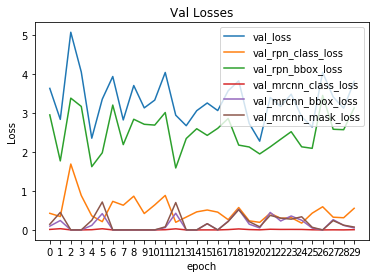

Train Loss 



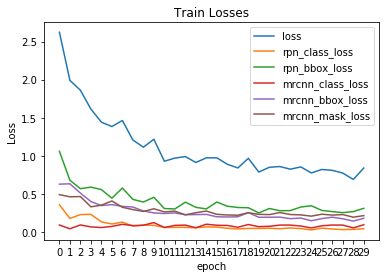

In [29]:
# Create model in training mode
model = modellib.MaskRCNN(mode="training", config=config,
                          model_dir=MODEL_DIR)

# Which weights to start with?
init_with = "coco"  # imagenet, coco, or last

if init_with == "imagenet":
    model.load_weights(model.get_imagenet_weights(), by_name=True)
elif init_with == "coco":
    # Load weights trained on MS COCO, but skip layers that
    # are different due to the different number of classes
    # See README for instructions to download the COCO weights
    model.load_weights(COCO_MODEL_PATH, by_name=True,
                       exclude=["mrcnn_class_logits", "mrcnn_bbox_fc", 
                                "mrcnn_bbox", "mrcnn_mask"])
elif init_with == "last":
    # Load the last model you trained and continue training
    model.load_weights(model.find_last(), by_name=True)

    
model.train(dataset_train, dataset_val, 
            learning_rate=config.LEARNING_RATE, 
            epochs=30, 
            layers='heads', augmentation= seq)

In [14]:
class ShapesConfig(Config):
    """Configuration for training on the toy shapes dataset.
    Derives from the base Config class and overrides values specific
    to the toy shapes dataset.
    """
    # Give the configuration a recognizable name
    NAME = "shapes"

    # Train on 1 GPU and 1 images per GPU. We can put multiple images on each
    # GPU because the images are small. Batch size is 1 (GPUs * images/GPU).
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1
    STEPS_PER_EPOCH = 100
    # Number of classes (including background)
    NUM_CLASSES = 1 + 1  # background + 1 shapes

    # Use small images for faster training. Set the limits of the small side
    # the large side, and that determines the image shape.
    #IMAGE_MIN_DIM = 128
    #IMAGE_MAX_DIM = 128

    # Use smaller anchors because our image and objects are small
    RPN_ANCHOR_SCALES = (32, 64, 128, 256, 512, 768, 1024)  # anchor side in pixels
    BACKBONE_STRIDES =  [4, 8, 16, 32, 64, 128, 256]
    # Reduce training ROIs per image because the images are small and have
    # few objects. Aim to allow ROI sampling to pick 33% positive ROIs.
    #TRAIN_ROIS_PER_IMAGE = 32

    # Use a small epoch since the data is simple
    #STEPS_PER_EPOCH = 100

    # use small validation steps since the epoch is small
    VALIDATION_STEPS = 10
    #WEIGHT_DECAY = 0.005
    
config = ShapesConfig()
config.display()


Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64, 128, 256]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 1
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  1024
IMAGE_META_SIZE                14
IMAGE_MIN_DIM                  800
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [1024 1024    3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAP

In [15]:
# Create model in training mode
model = modellib.MaskRCNN(mode="training", config=config,
                          model_dir=MODEL_DIR)

# Which weights to start with?
init_with = "coco"  # imagenet, coco, or last

if init_with == "imagenet":
    model.load_weights(model.get_imagenet_weights(), by_name=True)
elif init_with == "coco":
    # Load weights trained on MS COCO, but skip layers that
    # are different due to the different number of classes
    # See README for instructions to download the COCO weights
    model.load_weights(COCO_MODEL_PATH, by_name=True,
                       exclude=["mrcnn_class_logits", "mrcnn_bbox_fc", 
                                "mrcnn_bbox", "mrcnn_mask"])
elif init_with == "last":
    # Load the last model you trained and continue training
    model.load_weights(model.find_last(), by_name=True)




Starting at epoch 0. LR=0.001

Checkpoint Path: /home/harsh/Mask_RCNN/logs/shapes20190826T1047/mask_rcnn_shapes_{epoch:04d}.h5
Selecting layers to train
fpn_c5p5               (Conv2D)
fpn_c4p4               (Conv2D)
fpn_c3p3               (Conv2D)
fpn_c2p2               (Conv2D)
fpn_p5                 (Conv2D)
fpn_p2                 (Conv2D)
fpn_p3                 (Conv2D)
fpn_p4                 (Conv2D)
In model:  rpn_model
    rpn_conv_shared        (Conv2D)
    rpn_class_raw          (Conv2D)
    rpn_bbox_pred          (Conv2D)
mrcnn_mask_conv1       (TimeDistributed)
mrcnn_mask_bn1         (TimeDistributed)
mrcnn_mask_conv2       (TimeDistributed)
mrcnn_mask_bn2         (TimeDistributed)
mrcnn_class_conv1      (TimeDistributed)
mrcnn_class_bn1        (TimeDistributed)
mrcnn_mask_conv3       (TimeDistributed)
mrcnn_mask_bn3         (TimeDistributed)
mrcnn_class_conv2      (TimeDistributed)
mrcnn_class_bn2        (TimeDistributed)
mrcnn_mask_conv4       (TimeDistributed)
mrcnn_mask

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:108: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/keras/engine/training_generator.py:47: UserWarning: Using a generator with `use_multiprocessing=True` and multiple workers may duplicate your data. Please consider using the`keras.utils.Sequence class.
  UserWarning('Using a generator with `use_multiprocessing=True`'


Epoch 1/30
 11/100 [==>...........................] - ETA: 6:24 - loss: 5.3929 - rpn_class_loss: 1.6712 - rpn_bbox_loss: 2.2953 - mrcnn_class_loss: 0.0576 - mrcnn_bbox_loss: 0.5962 - mrcnn_mask_loss: 0.7726

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 14/100 [===>..........................] - ETA: 5:03 - loss: 4.8535 - rpn_class_loss: 1.4929 - rpn_bbox_loss: 1.9914 - mrcnn_class_loss: 0.0493 - mrcnn_bbox_loss: 0.5704 - mrcnn_mask_loss: 0.7495

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 15/100 [===>..........................] - ETA: 4:43 - loss: 4.7360 - rpn_class_loss: 1.4362 - rpn_bbox_loss: 1.9107 - mrcnn_class_loss: 0.0493 - mrcnn_bbox_loss: 0.5956 - mrcnn_mask_loss: 0.7442

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6

 16/100 [===>..........................] - ETA: 4:25 - loss: 4.6462 - rpn_class_loss: 1.3989 - rpn_bbox_loss: 1.8369 - mrcnn_class_loss: 0.0524 - mrcnn_bbox_loss: 0.6185 - mrcnn_mask_loss: 0.7395

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


100/100 [==============================] - 101s 1s/step - loss: 2.4516 - rpn_class_loss: 0.5053 - rpn_bbox_loss: 0.9980 - mrcnn_class_loss: 0.0294 - mrcnn_bbox_loss: 0.5407 - mrcnn_mask_loss: 0.3782 - val_loss: 3.5752 - val_rpn_class_loss: 0.5862 - val_rpn_bbox_loss: 2.9890 - val_mrcnn_class_loss: 1.8263e-05 - val_mrcnn_bbox_loss: 0.0000e+00 - val_mrcnn_mask_loss: 0.0000e+00
Epoch 2/30
100/100 [==============================] - 53s 532ms/step - loss: 1.8789 - rpn_class_loss: 0.1754 - rpn_bbox_loss: 0.6795 - mrcnn_class_loss: 0.0382 - mrcnn_bbox_loss: 0.5547 - mrcnn_mask_loss: 0.4310 - val_loss: 2.5777 - val_rpn_class_loss: 0.5869 - val_rpn_bbox_loss: 1.2993 - val_mrcnn_class_loss: 0.0211 - val_mrcnn_bbox_loss: 0.2264 - val_mrcnn_mask_loss: 0.4440
Epoch 3/30
 34/100 [=========>....................] - ETA: 33s - loss: 1.8638 - rpn_class_loss: 0.1776 - rpn_bbox_loss: 0.5929 - mrcnn_class_loss: 0.0794 - mrcnn_bbox_loss: 0.5903 - mrcnn_mask_loss: 0.4236

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 39/100 [==========>...................] - ETA: 31s - loss: 1.8325 - rpn_class_loss: 0.1628 - rpn_bbox_loss: 0.5907 - mrcnn_class_loss: 0.0734 - mrcnn_bbox_loss: 0.5689 - mrcnn_mask_loss: 0.4368

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 45/100 [============>.................] - ETA: 27s - loss: 1.7837 - rpn_class_loss: 0.1593 - rpn_bbox_loss: 0.5680 - mrcnn_class_loss: 0.0721 - mrcnn_bbox_loss: 0.5587 - mrcnn_mask_loss: 0.4255

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 46/100 [============>.................] - ETA: 27s - loss: 1.7755 - rpn_class_loss: 0.1588 - rpn_bbox_loss: 0.5652 - mrcnn_class_loss: 0.0719 - mrcnn_bbox_loss: 0.5554 - mrcnn_mask_loss: 0.4243

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 48/100 [=============>................] - ETA: 26s - loss: 1.7766 - rpn_class_loss: 0.1584 - rpn_bbox_loss: 0.5758 - mrcnn_class_loss: 0.0715 - mrcnn_bbox_loss: 0.5521 - mrcnn_mask_loss: 0.4189

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 51/100 [==============>...............] - ETA: 24s - loss: 1.7478 - rpn_class_loss: 0.1548 - rpn_bbox_loss: 0.5608 - mrcnn_class_loss: 0.0702 - mrcnn_bbox_loss: 0.5484 - mrcnn_mask_loss: 0.4136

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 52/100 [==============>...............] - ETA: 24s - loss: 1.7533 - rpn_class_loss: 0.1549 - rpn_bbox_loss: 0.5728 - mrcnn_class_loss: 0.0698 - mrcnn_bbox_loss: 0.5457 - mrcnn_mask_loss: 0.4102

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 58/100 [================>.............] - ETA: 21s - loss: 1.6946 - rpn_class_loss: 0.1537 - rpn_bbox_loss: 0.5457 - mrcnn_class_loss: 0.0685 - mrcnn_bbox_loss: 0.5324 - mrcnn_mask_loss: 0.3943

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


100/100 [==============================] - 53s 534ms/step - loss: 1.6232 - rpn_class_loss: 0.1695 - rpn_bbox_loss: 0.5569 - mrcnn_class_loss: 0.0708 - mrcnn_bbox_loss: 0.4792 - mrcnn_mask_loss: 0.3469 - val_loss: 3.8221 - val_rpn_class_loss: 0.4601 - val_rpn_bbox_loss: 2.0751 - val_mrcnn_class_loss: 0.0262 - val_mrcnn_bbox_loss: 0.2672 - val_mrcnn_mask_loss: 0.9935
Epoch 4/30
100/100 [==============================] - 56s 560ms/step - loss: 1.3721 - rpn_class_loss: 0.1077 - rpn_bbox_loss: 0.4712 - mrcnn_class_loss: 0.0720 - mrcnn_bbox_loss: 0.3689 - mrcnn_mask_loss: 0.3522 - val_loss: 3.2596 - val_rpn_class_loss: 0.3176 - val_rpn_bbox_loss: 2.9420 - val_mrcnn_class_loss: 6.0986e-05 - val_mrcnn_bbox_loss: 0.0000e+00 - val_mrcnn_mask_loss: 0.0000e+00
Epoch 5/30
100/100 [==============================] - 53s 534ms/step - loss: 1.3619 - rpn_class_loss: 0.1548 - rpn_bbox_loss: 0.4568 - mrcnn_class_loss: 0.1005 - mrcnn_bbox_loss: 0.3621 - mrcnn_mask_loss: 0.2877 - val_loss: 5.1382 - val_rpn_

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 67/100 [===================>..........] - ETA: 17s - loss: 1.1422 - rpn_class_loss: 0.0833 - rpn_bbox_loss: 0.3944 - mrcnn_class_loss: 0.0761 - mrcnn_bbox_loss: 0.2828 - mrcnn_mask_loss: 0.3057

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 75/100 [=====================>........] - ETA: 13s - loss: 1.1273 - rpn_class_loss: 0.0797 - rpn_bbox_loss: 0.3913 - mrcnn_class_loss: 0.0729 - mrcnn_bbox_loss: 0.2795 - mrcnn_mask_loss: 0.3037

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 85/100 [========================>.....] - ETA: 7s - loss: 1.1018 - rpn_class_loss: 0.0757 - rpn_bbox_loss: 0.3831 - mrcnn_class_loss: 0.0725 - mrcnn_bbox_loss: 0.2732 - mrcnn_mask_loss: 0.2973

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 93/100 [==========================>...] - ETA: 3s - loss: 1.1047 - rpn_class_loss: 0.0787 - rpn_bbox_loss: 0.3883 - mrcnn_class_loss: 0.0712 - mrcnn_bbox_loss: 0.2726 - mrcnn_mask_loss: 0.2939

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 96/100 [===========================>..] - ETA: 2s - loss: 1.1018 - rpn_class_loss: 0.0787 - rpn_bbox_loss: 0.3877 - mrcnn_class_loss: 0.0725 - mrcnn_bbox_loss: 0.2719 - mrcnn_mask_loss: 0.2911

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


100/100 [==============================] - 56s 559ms/step - loss: 1.0959 - rpn_class_loss: 0.0786 - rpn_bbox_loss: 0.3884 - mrcnn_class_loss: 0.0721 - mrcnn_bbox_loss: 0.2702 - mrcnn_mask_loss: 0.2867 - val_loss: 2.5820 - val_rpn_class_loss: 0.4589 - val_rpn_bbox_loss: 1.4738 - val_mrcnn_class_loss: 0.0143 - val_mrcnn_bbox_loss: 0.2237 - val_mrcnn_mask_loss: 0.4113
Epoch 8/30
  5/100 [>.............................] - ETA: 45s - loss: 1.3735 - rpn_class_loss: 0.0714 - rpn_bbox_loss: 0.5159 - mrcnn_class_loss: 0.1299 - mrcnn_bbox_loss: 0.3227 - mrcnn_mask_loss: 0.3336

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 11/100 [==>...........................] - ETA: 43s - loss: 1.2710 - rpn_class_loss: 0.0668 - rpn_bbox_loss: 0.4775 - mrcnn_class_loss: 0.1215 - mrcnn_bbox_loss: 0.2929 - mrcnn_mask_loss: 0.3123

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 92/100 [==========================>...] - ETA: 4s - loss: 1.2618 - rpn_class_loss: 0.0892 - rpn_bbox_loss: 0.4649 - mrcnn_class_loss: 0.1205 - mrcnn_bbox_loss: 0.2898 - mrcnn_mask_loss: 0.2974

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


100/100 [==============================] - 54s 535ms/step - loss: 1.2595 - rpn_class_loss: 0.0915 - rpn_bbox_loss: 0.4703 - mrcnn_class_loss: 0.1159 - mrcnn_bbox_loss: 0.2877 - mrcnn_mask_loss: 0.2942 - val_loss: 3.1379 - val_rpn_class_loss: 0.5307 - val_rpn_bbox_loss: 2.6071 - val_mrcnn_class_loss: 2.6869e-05 - val_mrcnn_bbox_loss: 0.0000e+00 - val_mrcnn_mask_loss: 0.0000e+00
Epoch 9/30
  4/100 [>.............................] - ETA: 48s - loss: 1.0531 - rpn_class_loss: 0.0491 - rpn_bbox_loss: 0.3704 - mrcnn_class_loss: 0.0750 - mrcnn_bbox_loss: 0.2827 - mrcnn_mask_loss: 0.2758

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 15/100 [===>..........................] - ETA: 43s - loss: 1.0228 - rpn_class_loss: 0.0785 - rpn_bbox_loss: 0.3793 - mrcnn_class_loss: 0.0748 - mrcnn_bbox_loss: 0.2285 - mrcnn_mask_loss: 0.2616

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 19/100 [====>.........................] - ETA: 40s - loss: 1.0595 - rpn_class_loss: 0.0927 - rpn_bbox_loss: 0.3864 - mrcnn_class_loss: 0.0777 - mrcnn_bbox_loss: 0.2274 - mrcnn_mask_loss: 0.2754

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 30/100 [========>.....................] - ETA: 35s - loss: 1.0133 - rpn_class_loss: 0.0861 - rpn_bbox_loss: 0.3461 - mrcnn_class_loss: 0.0783 - mrcnn_bbox_loss: 0.2188 - mrcnn_mask_loss: 0.2838

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 36/100 [=========>....................] - ETA: 32s - loss: 0.9951 - rpn_class_loss: 0.0849 - rpn_bbox_loss: 0.3411 - mrcnn_class_loss: 0.0781 - mrcnn_bbox_loss: 0.2151 - mrcnn_mask_loss: 0.2758

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 42/100 [===========>..................] - ETA: 29s - loss: 1.0024 - rpn_class_loss: 0.0820 - rpn_bbox_loss: 0.3438 - mrcnn_class_loss: 0.0775 - mrcnn_bbox_loss: 0.2187 - mrcnn_mask_loss: 0.2804

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 47/100 [=============>................] - ETA: 26s - loss: 1.0014 - rpn_class_loss: 0.0801 - rpn_bbox_loss: 0.3465 - mrcnn_class_loss: 0.0798 - mrcnn_bbox_loss: 0.2201 - mrcnn_mask_loss: 0.2749

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


100/100 [==============================] - 55s 554ms/step - loss: 1.0250 - rpn_class_loss: 0.0749 - rpn_bbox_loss: 0.3720 - mrcnn_class_loss: 0.0689 - mrcnn_bbox_loss: 0.2375 - mrcnn_mask_loss: 0.2716 - val_loss: 3.6349 - val_rpn_class_loss: 0.5523 - val_rpn_bbox_loss: 3.0826 - val_mrcnn_class_loss: 1.8740e-05 - val_mrcnn_bbox_loss: 0.0000e+00 - val_mrcnn_mask_loss: 0.0000e+00
Epoch 10/30
100/100 [==============================] - 54s 542ms/step - loss: 1.2148 - rpn_class_loss: 0.0924 - rpn_bbox_loss: 0.5066 - mrcnn_class_loss: 0.0763 - mrcnn_bbox_loss: 0.2669 - mrcnn_mask_loss: 0.2727 - val_loss: 4.4912 - val_rpn_class_loss: 0.9971 - val_rpn_bbox_loss: 3.4941 - val_mrcnn_class_loss: 1.6522e-05 - val_mrcnn_bbox_loss: 0.0000e+00 - val_mrcnn_mask_loss: 0.0000e+00
Epoch 11/30
100/100 [==============================] - 55s 554ms/step - loss: 1.0832 - rpn_class_loss: 0.0695 - rpn_bbox_loss: 0.3645 - mrcnn_class_loss: 0.0944 - mrcnn_bbox_loss: 0.2942 - mrcnn_mask_loss: 0.2605 - val_loss: 3.9

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


100/100 [==============================] - 53s 529ms/step - loss: 1.0579 - rpn_class_loss: 0.0691 - rpn_bbox_loss: 0.3161 - mrcnn_class_loss: 0.1121 - mrcnn_bbox_loss: 0.2893 - mrcnn_mask_loss: 0.2713 - val_loss: 3.4658 - val_rpn_class_loss: 0.6948 - val_rpn_bbox_loss: 2.5917 - val_mrcnn_class_loss: 0.0054 - val_mrcnn_bbox_loss: 0.0628 - val_mrcnn_mask_loss: 0.1110
Epoch 13/30
 12/100 [==>...........................] - ETA: 44s - loss: 0.8828 - rpn_class_loss: 0.0512 - rpn_bbox_loss: 0.3084 - mrcnn_class_loss: 0.0747 - mrcnn_bbox_loss: 0.2212 - mrcnn_mask_loss: 0.2273

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 23/100 [=====>........................] - ETA: 38s - loss: 0.8576 - rpn_class_loss: 0.0451 - rpn_bbox_loss: 0.3026 - mrcnn_class_loss: 0.0636 - mrcnn_bbox_loss: 0.2188 - mrcnn_mask_loss: 0.2275

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 28/100 [=======>......................] - ETA: 36s - loss: 0.8469 - rpn_class_loss: 0.0453 - rpn_bbox_loss: 0.2979 - mrcnn_class_loss: 0.0642 - mrcnn_bbox_loss: 0.2154 - mrcnn_mask_loss: 0.2241

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 38/100 [==========>...................] - ETA: 31s - loss: 0.8300 - rpn_class_loss: 0.0481 - rpn_bbox_loss: 0.2887 - mrcnn_class_loss: 0.0583 - mrcnn_bbox_loss: 0.2126 - mrcnn_mask_loss: 0.2223

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 46/100 [============>.................] - ETA: 27s - loss: 0.8404 - rpn_class_loss: 0.0479 - rpn_bbox_loss: 0.2969 - mrcnn_class_loss: 0.0555 - mrcnn_bbox_loss: 0.2129 - mrcnn_mask_loss: 0.2272

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 51/100 [==============>...............] - ETA: 24s - loss: 0.8194 - rpn_class_loss: 0.0493 - rpn_bbox_loss: 0.2854 - mrcnn_class_loss: 0.0526 - mrcnn_bbox_loss: 0.2065 - mrcnn_mask_loss: 0.2255

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 56/100 [===============>..............] - ETA: 22s - loss: 0.8418 - rpn_class_loss: 0.0527 - rpn_bbox_loss: 0.2966 - mrcnn_class_loss: 0.0542 - mrcnn_bbox_loss: 0.2097 - mrcnn_mask_loss: 0.2286

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 79/100 [======================>.......] - ETA: 10s - loss: 0.8611 - rpn_class_loss: 0.0503 - rpn_bbox_loss: 0.3065 - mrcnn_class_loss: 0.0552 - mrcnn_bbox_loss: 0.2187 - mrcnn_mask_loss: 0.2304

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


100/100 [==============================] - 54s 538ms/step - loss: 0.8694 - rpn_class_loss: 0.0470 - rpn_bbox_loss: 0.3189 - mrcnn_class_loss: 0.0587 - mrcnn_bbox_loss: 0.2184 - mrcnn_mask_loss: 0.2264 - val_loss: 2.9764 - val_rpn_class_loss: 0.2792 - val_rpn_bbox_loss: 1.5427 - val_mrcnn_class_loss: 0.0401 - val_mrcnn_bbox_loss: 0.3371 - val_mrcnn_mask_loss: 0.7773
Epoch 14/30
 10/100 [==>...........................] - ETA: 45s - loss: 1.0534 - rpn_class_loss: 0.0607 - rpn_bbox_loss: 0.4312 - mrcnn_class_loss: 0.0799 - mrcnn_bbox_loss: 0.2250 - mrcnn_mask_loss: 0.2566

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 23/100 [=====>........................] - ETA: 39s - loss: 0.9972 - rpn_class_loss: 0.0459 - rpn_bbox_loss: 0.3921 - mrcnn_class_loss: 0.0795 - mrcnn_bbox_loss: 0.2433 - mrcnn_mask_loss: 0.2363

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 24/100 [======>.......................] - ETA: 38s - loss: 0.9909 - rpn_class_loss: 0.0452 - rpn_bbox_loss: 0.3886 - mrcnn_class_loss: 0.0777 - mrcnn_bbox_loss: 0.2462 - mrcnn_mask_loss: 0.2333

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 33/100 [========>.....................] - ETA: 34s - loss: 0.9800 - rpn_class_loss: 0.0417 - rpn_bbox_loss: 0.3962 - mrcnn_class_loss: 0.0723 - mrcnn_bbox_loss: 0.2451 - mrcnn_mask_loss: 0.2247

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 43/100 [===========>..................] - ETA: 29s - loss: 1.0206 - rpn_class_loss: 0.0498 - rpn_bbox_loss: 0.4177 - mrcnn_class_loss: 0.0747 - mrcnn_bbox_loss: 0.2512 - mrcnn_mask_loss: 0.2272

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 44/100 [============>.................] - ETA: 28s - loss: 1.0135 - rpn_class_loss: 0.0491 - rpn_bbox_loss: 0.4141 - mrcnn_class_loss: 0.0739 - mrcnn_bbox_loss: 0.2515 - mrcnn_mask_loss: 0.2248

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 53/100 [==============>...............] - ETA: 24s - loss: 1.0293 - rpn_class_loss: 0.0526 - rpn_bbox_loss: 0.4255 - mrcnn_class_loss: 0.0769 - mrcnn_bbox_loss: 0.2494 - mrcnn_mask_loss: 0.2248

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


100/100 [==============================] - 55s 550ms/step - loss: 1.0096 - rpn_class_loss: 0.0538 - rpn_bbox_loss: 0.3928 - mrcnn_class_loss: 0.0766 - mrcnn_bbox_loss: 0.2464 - mrcnn_mask_loss: 0.2400 - val_loss: 3.5818 - val_rpn_class_loss: 0.4036 - val_rpn_bbox_loss: 2.4611 - val_mrcnn_class_loss: 0.0056 - val_mrcnn_bbox_loss: 0.4033 - val_mrcnn_mask_loss: 0.3082
Epoch 15/30
100/100 [==============================] - 55s 549ms/step - loss: 1.0412 - rpn_class_loss: 0.0627 - rpn_bbox_loss: 0.3656 - mrcnn_class_loss: 0.0842 - mrcnn_bbox_loss: 0.2544 - mrcnn_mask_loss: 0.2743 - val_loss: 2.9048 - val_rpn_class_loss: 0.3313 - val_rpn_bbox_loss: 1.9194 - val_mrcnn_class_loss: 0.0121 - val_mrcnn_bbox_loss: 0.3567 - val_mrcnn_mask_loss: 0.2852
Epoch 16/30
100/100 [==============================] - 54s 535ms/step - loss: 0.9970 - rpn_class_loss: 0.0525 - rpn_bbox_loss: 0.3432 - mrcnn_class_loss: 0.1051 - mrcnn_bbox_loss: 0.2245 - mrcnn_mask_loss: 0.2717 - val_loss: 3.1476 - val_rpn_class_loss

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 92/100 [==========================>...] - ETA: 4s - loss: 0.9119 - rpn_class_loss: 0.0428 - rpn_bbox_loss: 0.3427 - mrcnn_class_loss: 0.0670 - mrcnn_bbox_loss: 0.2098 - mrcnn_mask_loss: 0.2495

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


100/100 [==============================] - 56s 559ms/step - loss: 0.9042 - rpn_class_loss: 0.0418 - rpn_bbox_loss: 0.3402 - mrcnn_class_loss: 0.0666 - mrcnn_bbox_loss: 0.2072 - mrcnn_mask_loss: 0.2483 - val_loss: 2.8824 - val_rpn_class_loss: 0.5450 - val_rpn_bbox_loss: 1.9745 - val_mrcnn_class_loss: 0.0130 - val_mrcnn_bbox_loss: 0.1170 - val_mrcnn_mask_loss: 0.2328
Epoch 18/30
 13/100 [==>...........................] - ETA: 42s - loss: 0.7549 - rpn_class_loss: 0.0417 - rpn_bbox_loss: 0.2250 - mrcnn_class_loss: 0.0933 - mrcnn_bbox_loss: 0.1788 - mrcnn_mask_loss: 0.2161

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 16/100 [===>..........................] - ETA: 41s - loss: 0.6914 - rpn_class_loss: 0.0356 - rpn_bbox_loss: 0.2069 - mrcnn_class_loss: 0.0793 - mrcnn_bbox_loss: 0.1633 - mrcnn_mask_loss: 0.2063

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 25/100 [======>.......................] - ETA: 37s - loss: 0.7367 - rpn_class_loss: 0.0361 - rpn_bbox_loss: 0.2397 - mrcnn_class_loss: 0.0824 - mrcnn_bbox_loss: 0.1794 - mrcnn_mask_loss: 0.1991

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 37/100 [==========>...................] - ETA: 31s - loss: 0.8001 - rpn_class_loss: 0.0393 - rpn_bbox_loss: 0.2831 - mrcnn_class_loss: 0.0821 - mrcnn_bbox_loss: 0.1891 - mrcnn_mask_loss: 0.2065

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 40/100 [===========>..................] - ETA: 30s - loss: 0.7977 - rpn_class_loss: 0.0384 - rpn_bbox_loss: 0.2863 - mrcnn_class_loss: 0.0794 - mrcnn_bbox_loss: 0.1894 - mrcnn_mask_loss: 0.2042

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 49/100 [=============>................] - ETA: 25s - loss: 0.8280 - rpn_class_loss: 0.0394 - rpn_bbox_loss: 0.2946 - mrcnn_class_loss: 0.0848 - mrcnn_bbox_loss: 0.2022 - mrcnn_mask_loss: 0.2070

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


100/100 [==============================] - 54s 536ms/step - loss: 0.9039 - rpn_class_loss: 0.0425 - rpn_bbox_loss: 0.3383 - mrcnn_class_loss: 0.0894 - mrcnn_bbox_loss: 0.2096 - mrcnn_mask_loss: 0.2240 - val_loss: 3.5024 - val_rpn_class_loss: 0.5277 - val_rpn_bbox_loss: 2.5600 - val_mrcnn_class_loss: 0.0011 - val_mrcnn_bbox_loss: 0.2097 - val_mrcnn_mask_loss: 0.2038
Epoch 19/30
 52/100 [==============>...............] - ETA: 24s - loss: 0.9203 - rpn_class_loss: 0.0499 - rpn_bbox_loss: 0.3315 - mrcnn_class_loss: 0.0765 - mrcnn_bbox_loss: 0.2175 - mrcnn_mask_loss: 0.2449

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 77/100 [======================>.......] - ETA: 11s - loss: 0.9128 - rpn_class_loss: 0.0526 - rpn_bbox_loss: 0.3145 - mrcnn_class_loss: 0.0844 - mrcnn_bbox_loss: 0.2163 - mrcnn_mask_loss: 0.2451

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 95/100 [===========================>..] - ETA: 2s - loss: 0.8836 - rpn_class_loss: 0.0537 - rpn_bbox_loss: 0.3050 - mrcnn_class_loss: 0.0805 - mrcnn_bbox_loss: 0.2087 - mrcnn_mask_loss: 0.2357

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


100/100 [==============================] - 54s 541ms/step - loss: 0.8772 - rpn_class_loss: 0.0540 - rpn_bbox_loss: 0.3058 - mrcnn_class_loss: 0.0787 - mrcnn_bbox_loss: 0.2065 - mrcnn_mask_loss: 0.2322 - val_loss: 3.4030 - val_rpn_class_loss: 0.4892 - val_rpn_bbox_loss: 2.7036 - val_mrcnn_class_loss: 0.0014 - val_mrcnn_bbox_loss: 0.1197 - val_mrcnn_mask_loss: 0.0892
Epoch 20/30
  3/100 [..............................] - ETA: 47s - loss: 0.7466 - rpn_class_loss: 0.0332 - rpn_bbox_loss: 0.2418 - mrcnn_class_loss: 0.0989 - mrcnn_bbox_loss: 0.1804 - mrcnn_mask_loss: 0.1924

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


  8/100 [=>............................] - ETA: 46s - loss: 0.7443 - rpn_class_loss: 0.0372 - rpn_bbox_loss: 0.3116 - mrcnn_class_loss: 0.0585 - mrcnn_bbox_loss: 0.1514 - mrcnn_mask_loss: 0.1855

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 20/100 [=====>........................] - ETA: 40s - loss: 0.7356 - rpn_class_loss: 0.0410 - rpn_bbox_loss: 0.2596 - mrcnn_class_loss: 0.0672 - mrcnn_bbox_loss: 0.1707 - mrcnn_mask_loss: 0.1972

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 25/100 [======>.......................] - ETA: 38s - loss: 0.7271 - rpn_class_loss: 0.0394 - rpn_bbox_loss: 0.2528 - mrcnn_class_loss: 0.0693 - mrcnn_bbox_loss: 0.1740 - mrcnn_mask_loss: 0.1917

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 26/100 [======>.......................] - ETA: 38s - loss: 0.7303 - rpn_class_loss: 0.0394 - rpn_bbox_loss: 0.2533 - mrcnn_class_loss: 0.0706 - mrcnn_bbox_loss: 0.1753 - mrcnn_mask_loss: 0.1916

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


100/100 [==============================] - 55s 549ms/step - loss: 0.7865 - rpn_class_loss: 0.0423 - rpn_bbox_loss: 0.2939 - mrcnn_class_loss: 0.0691 - mrcnn_bbox_loss: 0.1673 - mrcnn_mask_loss: 0.2139 - val_loss: 3.6173 - val_rpn_class_loss: 0.4203 - val_rpn_bbox_loss: 2.7481 - val_mrcnn_class_loss: 0.0214 - val_mrcnn_bbox_loss: 0.1598 - val_mrcnn_mask_loss: 0.2677
Epoch 21/30
100/100 [==============================] - 54s 538ms/step - loss: 0.9388 - rpn_class_loss: 0.0513 - rpn_bbox_loss: 0.3108 - mrcnn_class_loss: 0.1019 - mrcnn_bbox_loss: 0.2107 - mrcnn_mask_loss: 0.2643 - val_loss: 3.3253 - val_rpn_class_loss: 0.4739 - val_rpn_bbox_loss: 2.3985 - val_mrcnn_class_loss: 0.0282 - val_mrcnn_bbox_loss: 0.1788 - val_mrcnn_mask_loss: 0.2458
Epoch 22/30
 58/100 [================>.............] - ETA: 21s - loss: 0.7457 - rpn_class_loss: 0.0231 - rpn_bbox_loss: 0.2689 - mrcnn_class_loss: 0.0766 - mrcnn_bbox_loss: 0.1713 - mrcnn_mask_loss: 0.2057

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 85/100 [========================>.....] - ETA: 7s - loss: 0.7582 - rpn_class_loss: 0.0308 - rpn_bbox_loss: 0.2648 - mrcnn_class_loss: 0.0783 - mrcnn_bbox_loss: 0.1691 - mrcnn_mask_loss: 0.2151

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


100/100 [==============================] - 54s 541ms/step - loss: 0.7784 - rpn_class_loss: 0.0338 - rpn_bbox_loss: 0.2795 - mrcnn_class_loss: 0.0789 - mrcnn_bbox_loss: 0.1710 - mrcnn_mask_loss: 0.2153 - val_loss: 2.9224 - val_rpn_class_loss: 0.3656 - val_rpn_bbox_loss: 2.2330 - val_mrcnn_class_loss: 0.0098 - val_mrcnn_bbox_loss: 0.1907 - val_mrcnn_mask_loss: 0.1232
Epoch 23/30
  6/100 [>.............................] - ETA: 46s - loss: 0.7954 - rpn_class_loss: 0.0198 - rpn_bbox_loss: 0.3477 - mrcnn_class_loss: 0.0691 - mrcnn_bbox_loss: 0.1677 - mrcnn_mask_loss: 0.1912

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 18/100 [====>.........................] - ETA: 41s - loss: 0.8273 - rpn_class_loss: 0.0389 - rpn_bbox_loss: 0.3328 - mrcnn_class_loss: 0.0794 - mrcnn_bbox_loss: 0.1781 - mrcnn_mask_loss: 0.1981

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 25/100 [======>.......................] - ETA: 37s - loss: 0.8557 - rpn_class_loss: 0.0408 - rpn_bbox_loss: 0.3359 - mrcnn_class_loss: 0.0909 - mrcnn_bbox_loss: 0.1865 - mrcnn_mask_loss: 0.2017

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 31/100 [========>.....................] - ETA: 34s - loss: 0.8679 - rpn_class_loss: 0.0468 - rpn_bbox_loss: 0.3339 - mrcnn_class_loss: 0.0973 - mrcnn_bbox_loss: 0.1847 - mrcnn_mask_loss: 0.2051

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 43/100 [===========>..................] - ETA: 28s - loss: 0.8654 - rpn_class_loss: 0.0452 - rpn_bbox_loss: 0.3249 - mrcnn_class_loss: 0.1031 - mrcnn_bbox_loss: 0.1884 - mrcnn_mask_loss: 0.2038

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 54/100 [===============>..............] - ETA: 23s - loss: 0.8450 - rpn_class_loss: 0.0443 - rpn_bbox_loss: 0.3113 - mrcnn_class_loss: 0.0994 - mrcnn_bbox_loss: 0.1893 - mrcnn_mask_loss: 0.2006

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


100/100 [==============================] - 53s 533ms/step - loss: 0.8111 - rpn_class_loss: 0.0440 - rpn_bbox_loss: 0.3069 - mrcnn_class_loss: 0.0872 - mrcnn_bbox_loss: 0.1836 - mrcnn_mask_loss: 0.1894 - val_loss: 3.3601 - val_rpn_class_loss: 0.4683 - val_rpn_bbox_loss: 2.7106 - val_mrcnn_class_loss: 0.0015 - val_mrcnn_bbox_loss: 0.0724 - val_mrcnn_mask_loss: 0.1072
Epoch 24/30
100/100 [==============================] - 54s 539ms/step - loss: 0.8476 - rpn_class_loss: 0.0473 - rpn_bbox_loss: 0.3069 - mrcnn_class_loss: 0.0636 - mrcnn_bbox_loss: 0.1925 - mrcnn_mask_loss: 0.2373 - val_loss: 2.8905 - val_rpn_class_loss: 0.3914 - val_rpn_bbox_loss: 2.2449 - val_mrcnn_class_loss: 0.0160 - val_mrcnn_bbox_loss: 0.0946 - val_mrcnn_mask_loss: 0.1436
Epoch 25/30
 85/100 [========================>.....] - ETA: 7s - loss: 0.7578 - rpn_class_loss: 0.0387 - rpn_bbox_loss: 0.2349 - mrcnn_class_loss: 0.0798 - mrcnn_bbox_loss: 0.1684 - mrcnn_mask_loss: 0.2360

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


100/100 [==============================] - 53s 535ms/step - loss: 0.7574 - rpn_class_loss: 0.0379 - rpn_bbox_loss: 0.2379 - mrcnn_class_loss: 0.0795 - mrcnn_bbox_loss: 0.1679 - mrcnn_mask_loss: 0.2342 - val_loss: 4.0211 - val_rpn_class_loss: 0.6477 - val_rpn_bbox_loss: 3.0147 - val_mrcnn_class_loss: 0.0113 - val_mrcnn_bbox_loss: 0.1474 - val_mrcnn_mask_loss: 0.1999
Epoch 26/30
  9/100 [=>............................] - ETA: 44s - loss: 0.8033 - rpn_class_loss: 0.0328 - rpn_bbox_loss: 0.2570 - mrcnn_class_loss: 0.0770 - mrcnn_bbox_loss: 0.1728 - mrcnn_mask_loss: 0.2638

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 20/100 [=====>........................] - ETA: 40s - loss: 0.7930 - rpn_class_loss: 0.0319 - rpn_bbox_loss: 0.2684 - mrcnn_class_loss: 0.0747 - mrcnn_bbox_loss: 0.1673 - mrcnn_mask_loss: 0.2507

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 37/100 [==========>...................] - ETA: 32s - loss: 0.7720 - rpn_class_loss: 0.0413 - rpn_bbox_loss: 0.2743 - mrcnn_class_loss: 0.0654 - mrcnn_bbox_loss: 0.1578 - mrcnn_mask_loss: 0.2332

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 48/100 [=============>................] - ETA: 27s - loss: 0.7600 - rpn_class_loss: 0.0366 - rpn_bbox_loss: 0.2812 - mrcnn_class_loss: 0.0606 - mrcnn_bbox_loss: 0.1548 - mrcnn_mask_loss: 0.2267

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 53/100 [==============>...............] - ETA: 24s - loss: 0.7621 - rpn_class_loss: 0.0362 - rpn_bbox_loss: 0.2851 - mrcnn_class_loss: 0.0615 - mrcnn_bbox_loss: 0.1548 - mrcnn_mask_loss: 0.2245

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 67/100 [===================>..........] - ETA: 17s - loss: 0.7816 - rpn_class_loss: 0.0404 - rpn_bbox_loss: 0.2981 - mrcnn_class_loss: 0.0633 - mrcnn_bbox_loss: 0.1576 - mrcnn_mask_loss: 0.2222

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 71/100 [====================>.........] - ETA: 15s - loss: 0.7829 - rpn_class_loss: 0.0409 - rpn_bbox_loss: 0.3027 - mrcnn_class_loss: 0.0628 - mrcnn_bbox_loss: 0.1564 - mrcnn_mask_loss: 0.2201

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 96/100 [===========================>..] - ETA: 2s - loss: 0.7645 - rpn_class_loss: 0.0387 - rpn_bbox_loss: 0.2948 - mrcnn_class_loss: 0.0603 - mrcnn_bbox_loss: 0.1538 - mrcnn_mask_loss: 0.2168

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


100/100 [==============================] - 55s 546ms/step - loss: 0.7708 - rpn_class_loss: 0.0388 - rpn_bbox_loss: 0.2961 - mrcnn_class_loss: 0.0626 - mrcnn_bbox_loss: 0.1555 - mrcnn_mask_loss: 0.2178 - val_loss: 3.8130 - val_rpn_class_loss: 0.3994 - val_rpn_bbox_loss: 2.5493 - val_mrcnn_class_loss: 0.0263 - val_mrcnn_bbox_loss: 0.2992 - val_mrcnn_mask_loss: 0.5389
Epoch 27/30
 15/100 [===>..........................] - ETA: 42s - loss: 0.8765 - rpn_class_loss: 0.0439 - rpn_bbox_loss: 0.3011 - mrcnn_class_loss: 0.0851 - mrcnn_bbox_loss: 0.1953 - mrcnn_mask_loss: 0.2510

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 28/100 [=======>......................] - ETA: 36s - loss: 0.8796 - rpn_class_loss: 0.0397 - rpn_bbox_loss: 0.3195 - mrcnn_class_loss: 0.0863 - mrcnn_bbox_loss: 0.1876 - mrcnn_mask_loss: 0.2464

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 46/100 [============>.................] - ETA: 27s - loss: 0.8786 - rpn_class_loss: 0.0376 - rpn_bbox_loss: 0.3094 - mrcnn_class_loss: 0.0907 - mrcnn_bbox_loss: 0.1923 - mrcnn_mask_loss: 0.2486

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 63/100 [=================>............] - ETA: 18s - loss: 0.8577 - rpn_class_loss: 0.0355 - rpn_bbox_loss: 0.3020 - mrcnn_class_loss: 0.0805 - mrcnn_bbox_loss: 0.1919 - mrcnn_mask_loss: 0.2478

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 64/100 [==================>...........] - ETA: 18s - loss: 0.8521 - rpn_class_loss: 0.0350 - rpn_bbox_loss: 0.2986 - mrcnn_class_loss: 0.0793 - mrcnn_bbox_loss: 0.1931 - mrcnn_mask_loss: 0.2461

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 81/100 [=======================>......] - ETA: 9s - loss: 0.8329 - rpn_class_loss: 0.0342 - rpn_bbox_loss: 0.2889 - mrcnn_class_loss: 0.0763 - mrcnn_bbox_loss: 0.1889 - mrcnn_mask_loss: 0.2447 

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 86/100 [========================>.....] - ETA: 7s - loss: 0.8254 - rpn_class_loss: 0.0333 - rpn_bbox_loss: 0.2881 - mrcnn_class_loss: 0.0764 - mrcnn_bbox_loss: 0.1871 - mrcnn_mask_loss: 0.2405

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


100/100 [==============================] - 54s 538ms/step - loss: 0.8019 - rpn_class_loss: 0.0321 - rpn_bbox_loss: 0.2752 - mrcnn_class_loss: 0.0753 - mrcnn_bbox_loss: 0.1834 - mrcnn_mask_loss: 0.2360 - val_loss: 3.9329 - val_rpn_class_loss: 0.7289 - val_rpn_bbox_loss: 2.3349 - val_mrcnn_class_loss: 0.0121 - val_mrcnn_bbox_loss: 0.3870 - val_mrcnn_mask_loss: 0.4701
Epoch 28/30
100/100 [==============================] - 55s 545ms/step - loss: 0.8519 - rpn_class_loss: 0.0381 - rpn_bbox_loss: 0.2873 - mrcnn_class_loss: 0.0769 - mrcnn_bbox_loss: 0.2275 - mrcnn_mask_loss: 0.2221 - val_loss: 3.4027 - val_rpn_class_loss: 0.3792 - val_rpn_bbox_loss: 2.2902 - val_mrcnn_class_loss: 0.0098 - val_mrcnn_bbox_loss: 0.4594 - val_mrcnn_mask_loss: 0.2641
Epoch 29/30
100/100 [==============================] - 54s 537ms/step - loss: 0.8117 - rpn_class_loss: 0.0588 - rpn_bbox_loss: 0.2819 - mrcnn_class_loss: 0.0837 - mrcnn_bbox_loss: 0.1685 - mrcnn_mask_loss: 0.2188 - val_loss: 2.6665 - val_rpn_class_loss

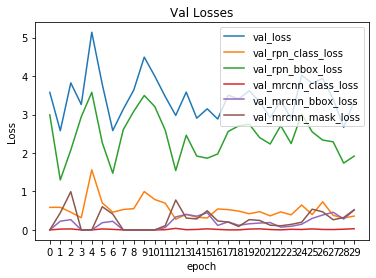

Train Loss 



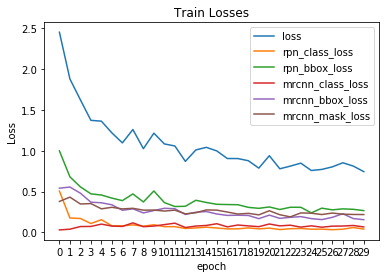

Fine tune Resnet stage 4 and up

Starting at epoch 0. LR=0.001

Checkpoint Path: /home/harsh/Mask_RCNN/logs/shapes20190826T1047/mask_rcnn_shapes_{epoch:04d}.h5
Selecting layers to train
res4a_branch2a         (Conv2D)
bn4a_branch2a          (BatchNorm)
res4a_branch2b         (Conv2D)
bn4a_branch2b          (BatchNorm)
res4a_branch2c         (Conv2D)
res4a_branch1          (Conv2D)
bn4a_branch2c          (BatchNorm)
bn4a_branch1           (BatchNorm)
res4b_branch2a         (Conv2D)
bn4b_branch2a          (BatchNorm)
res4b_branch2b         (Conv2D)
bn4b_branch2b          (BatchNorm)
res4b_branch2c         (Conv2D)
bn4b_branch2c          (BatchNorm)
res4c_branch2a         (Conv2D)
bn4c_branch2a          (BatchNorm)
res4c_branch2b         (Conv2D)
bn4c_branch2b          (BatchNorm)
res4c_branch2c         (Conv2D)
bn4c_branch2c          (BatchNorm)
res4d_branch2a         (Conv2D)
bn4d_branch2a          (BatchNorm)
res4d_branch2b         (Conv2D)
bn4d_branch2b          (BatchNorm)
res4d_bran

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6

100/100 [==============================] - 129s 1s/step - loss: 1.1074 - rpn_class_loss: 0.0577 - rpn_bbox_loss: 0.3928 - mrcnn_class_loss: 0.1189 - mrcnn_bbox_loss: 0.2532 - mrcnn_mask_loss: 0.2847 - val_loss: 3.8109 - val_rpn_class_loss: 0.3655 - val_rpn_bbox_loss: 2.9015 - val_mrcnn_class_loss: 0.0014 - val_mrcnn_bbox_loss: 0.1026 - val_mrcnn_mask_loss: 0.4399
Epoch 2/30
100/100 [==============================] - 67s 669ms/step - loss: 0.7817 - rpn_class_loss: 0.0433 - rpn_bbox_loss: 0.2731 - mrcnn_class_loss: 0.0448 - mrcnn_bbox_loss: 0.1811 - mrcnn_mask_loss: 0.2395 - val_loss: 2.5896 - val_rpn_class_loss: 0.2328 - val_rpn_bbox_loss: 1.7538 - val_mrcnn_class_loss: 0.0175 - val_mrcnn_bbox_loss: 0.2879 - val_mrcnn_mask_loss: 0.2977
Epoch 3/30
 41/100 [===========>..................] - ETA: 37s - loss: 0.9182 - rpn_class_loss: 0.0574 - rpn_bbox_loss: 0.3014 - mrcnn_class_loss: 0.0797 - mrcnn_bbox_loss: 0.2262 - mrcnn_mask_loss: 0.2535

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 42/100 [===========>..................] - ETA: 36s - loss: 0.9065 - rpn_class_loss: 0.0562 - rpn_bbox_loss: 0.2976 - mrcnn_class_loss: 0.0779 - mrcnn_bbox_loss: 0.2232 - mrcnn_mask_loss: 0.2517

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 45/100 [============>.................] - ETA: 34s - loss: 0.8868 - rpn_class_loss: 0.0528 - rpn_bbox_loss: 0.2931 - mrcnn_class_loss: 0.0753 - mrcnn_bbox_loss: 0.2159 - mrcnn_mask_loss: 0.2496

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 46/100 [============>.................] - ETA: 34s - loss: 0.8780 - rpn_class_loss: 0.0518 - rpn_bbox_loss: 0.2898 - mrcnn_class_loss: 0.0747 - mrcnn_bbox_loss: 0.2132 - mrcnn_mask_loss: 0.2486

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 47/100 [=============>................] - ETA: 33s - loss: 0.8684 - rpn_class_loss: 0.0510 - rpn_bbox_loss: 0.2859 - mrcnn_class_loss: 0.0742 - mrcnn_bbox_loss: 0.2108 - mrcnn_mask_loss: 0.2465

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 48/100 [=============>................] - ETA: 33s - loss: 0.8587 - rpn_class_loss: 0.0502 - rpn_bbox_loss: 0.2819 - mrcnn_class_loss: 0.0738 - mrcnn_bbox_loss: 0.2083 - mrcnn_mask_loss: 0.2445

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 51/100 [==============>...............] - ETA: 31s - loss: 0.8315 - rpn_class_loss: 0.0475 - rpn_bbox_loss: 0.2731 - mrcnn_class_loss: 0.0714 - mrcnn_bbox_loss: 0.2002 - mrcnn_mask_loss: 0.2392

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 52/100 [==============>...............] - ETA: 30s - loss: 0.8207 - rpn_class_loss: 0.0468 - rpn_bbox_loss: 0.2689 - mrcnn_class_loss: 0.0709 - mrcnn_bbox_loss: 0.1973 - mrcnn_mask_loss: 0.2368

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


100/100 [==============================] - 67s 670ms/step - loss: 0.7879 - rpn_class_loss: 0.0426 - rpn_bbox_loss: 0.2830 - mrcnn_class_loss: 0.0700 - mrcnn_bbox_loss: 0.1800 - mrcnn_mask_loss: 0.2123 - val_loss: 4.1684 - val_rpn_class_loss: 0.7675 - val_rpn_bbox_loss: 2.0165 - val_mrcnn_class_loss: 0.0305 - val_mrcnn_bbox_loss: 0.6681 - val_mrcnn_mask_loss: 0.6858
Epoch 4/30
100/100 [==============================] - 69s 689ms/step - loss: 0.7544 - rpn_class_loss: 0.0294 - rpn_bbox_loss: 0.2408 - mrcnn_class_loss: 0.0694 - mrcnn_bbox_loss: 0.1690 - mrcnn_mask_loss: 0.2457 - val_loss: 2.9120 - val_rpn_class_loss: 0.3669 - val_rpn_bbox_loss: 2.2923 - val_mrcnn_class_loss: 0.0019 - val_mrcnn_bbox_loss: 0.1313 - val_mrcnn_mask_loss: 0.1196
Epoch 5/30
100/100 [==============================] - 66s 662ms/step - loss: 0.7322 - rpn_class_loss: 0.0652 - rpn_bbox_loss: 0.1839 - mrcnn_class_loss: 0.1086 - mrcnn_bbox_loss: 0.1400 - mrcnn_mask_loss: 0.2344 - val_loss: 5.6742 - val_rpn_class_loss: 

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 75/100 [=====================>........] - ETA: 16s - loss: 0.5659 - rpn_class_loss: 0.0187 - rpn_bbox_loss: 0.1621 - mrcnn_class_loss: 0.0644 - mrcnn_bbox_loss: 0.1141 - mrcnn_mask_loss: 0.2066

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 77/100 [======================>.......] - ETA: 15s - loss: 0.5598 - rpn_class_loss: 0.0184 - rpn_bbox_loss: 0.1595 - mrcnn_class_loss: 0.0633 - mrcnn_bbox_loss: 0.1128 - mrcnn_mask_loss: 0.2058

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 88/100 [=========================>....] - ETA: 7s - loss: 0.5423 - rpn_class_loss: 0.0194 - rpn_bbox_loss: 0.1555 - mrcnn_class_loss: 0.0589 - mrcnn_bbox_loss: 0.1095 - mrcnn_mask_loss: 0.1990

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 89/100 [=========================>....] - ETA: 7s - loss: 0.5410 - rpn_class_loss: 0.0194 - rpn_bbox_loss: 0.1545 - mrcnn_class_loss: 0.0587 - mrcnn_bbox_loss: 0.1096 - mrcnn_mask_loss: 0.1987

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 95/100 [===========================>..] - ETA: 3s - loss: 0.5227 - rpn_class_loss: 0.0184 - rpn_bbox_loss: 0.1485 - mrcnn_class_loss: 0.0563 - mrcnn_bbox_loss: 0.1056 - mrcnn_mask_loss: 0.1939

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 98/100 [============================>.] - ETA: 1s - loss: 0.5266 - rpn_class_loss: 0.0191 - rpn_bbox_loss: 0.1524 - mrcnn_class_loss: 0.0569 - mrcnn_bbox_loss: 0.1055 - mrcnn_mask_loss: 0.1927

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


100/100 [==============================] - 68s 681ms/step - loss: 0.5201 - rpn_class_loss: 0.0188 - rpn_bbox_loss: 0.1500 - mrcnn_class_loss: 0.0564 - mrcnn_bbox_loss: 0.1040 - mrcnn_mask_loss: 0.1909 - val_loss: 2.2576 - val_rpn_class_loss: 0.3320 - val_rpn_bbox_loss: 1.3526 - val_mrcnn_class_loss: 0.0222 - val_mrcnn_bbox_loss: 0.2407 - val_mrcnn_mask_loss: 0.3101
Epoch 8/30
  1/100 [..............................] - ETA: 59s - loss: 0.6507 - rpn_class_loss: 0.0425 - rpn_bbox_loss: 0.2590 - mrcnn_class_loss: 0.0631 - mrcnn_bbox_loss: 0.1059 - mrcnn_mask_loss: 0.1801

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


100/100 [==============================] - 67s 667ms/step - loss: 0.7182 - rpn_class_loss: 0.0326 - rpn_bbox_loss: 0.2201 - mrcnn_class_loss: 0.0937 - mrcnn_bbox_loss: 0.1466 - mrcnn_mask_loss: 0.2252 - val_loss: 4.3640 - val_rpn_class_loss: 1.5954 - val_rpn_bbox_loss: 2.7686 - val_mrcnn_class_loss: 3.5763e-07 - val_mrcnn_bbox_loss: 0.0000e+00 - val_mrcnn_mask_loss: 0.0000e+00
Epoch 9/30
  5/100 [>.............................] - ETA: 59s - loss: 0.5660 - rpn_class_loss: 0.0219 - rpn_bbox_loss: 0.2131 - mrcnn_class_loss: 0.0506 - mrcnn_bbox_loss: 0.1050 - mrcnn_mask_loss: 0.1754 

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 10/100 [==>...........................] - ETA: 55s - loss: 0.6699 - rpn_class_loss: 0.0601 - rpn_bbox_loss: 0.2084 - mrcnn_class_loss: 0.0738 - mrcnn_bbox_loss: 0.1134 - mrcnn_mask_loss: 0.2141

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 15/100 [===>..........................] - ETA: 53s - loss: 0.5866 - rpn_class_loss: 0.0417 - rpn_bbox_loss: 0.1699 - mrcnn_class_loss: 0.0676 - mrcnn_bbox_loss: 0.1049 - mrcnn_mask_loss: 0.2025

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 24/100 [======>.......................] - ETA: 47s - loss: 0.6128 - rpn_class_loss: 0.0519 - rpn_bbox_loss: 0.1730 - mrcnn_class_loss: 0.0742 - mrcnn_bbox_loss: 0.1118 - mrcnn_mask_loss: 0.2019

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 26/100 [======>.......................] - ETA: 46s - loss: 0.6086 - rpn_class_loss: 0.0489 - rpn_bbox_loss: 0.1710 - mrcnn_class_loss: 0.0707 - mrcnn_bbox_loss: 0.1162 - mrcnn_mask_loss: 0.2017

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 29/100 [=======>......................] - ETA: 44s - loss: 0.6136 - rpn_class_loss: 0.0459 - rpn_bbox_loss: 0.1744 - mrcnn_class_loss: 0.0721 - mrcnn_bbox_loss: 0.1171 - mrcnn_mask_loss: 0.2042

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 36/100 [=========>....................] - ETA: 40s - loss: 0.5976 - rpn_class_loss: 0.0396 - rpn_bbox_loss: 0.1695 - mrcnn_class_loss: 0.0688 - mrcnn_bbox_loss: 0.1145 - mrcnn_mask_loss: 0.2052

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 39/100 [==========>...................] - ETA: 38s - loss: 0.5924 - rpn_class_loss: 0.0378 - rpn_bbox_loss: 0.1668 - mrcnn_class_loss: 0.0682 - mrcnn_bbox_loss: 0.1138 - mrcnn_mask_loss: 0.2059

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


100/100 [==============================] - 69s 688ms/step - loss: 0.5224 - rpn_class_loss: 0.0303 - rpn_bbox_loss: 0.1384 - mrcnn_class_loss: 0.0509 - mrcnn_bbox_loss: 0.1080 - mrcnn_mask_loss: 0.1949 - val_loss: 4.0202 - val_rpn_class_loss: 0.4077 - val_rpn_bbox_loss: 2.7636 - val_mrcnn_class_loss: 6.2711e-04 - val_mrcnn_bbox_loss: 0.5285 - val_mrcnn_mask_loss: 0.3197
Epoch 10/30
100/100 [==============================] - 67s 670ms/step - loss: 0.5667 - rpn_class_loss: 0.0259 - rpn_bbox_loss: 0.1695 - mrcnn_class_loss: 0.0561 - mrcnn_bbox_loss: 0.1102 - mrcnn_mask_loss: 0.2049 - val_loss: 4.1791 - val_rpn_class_loss: 0.4961 - val_rpn_bbox_loss: 3.0229 - val_mrcnn_class_loss: 0.0028 - val_mrcnn_bbox_loss: 0.3767 - val_mrcnn_mask_loss: 0.2805
Epoch 11/30
100/100 [==============================] - 68s 675ms/step - loss: 0.4461 - rpn_class_loss: 0.0122 - rpn_bbox_loss: 0.1108 - mrcnn_class_loss: 0.0555 - mrcnn_bbox_loss: 0.0984 - mrcnn_mask_loss: 0.1691 - val_loss: 3.6406 - val_rpn_class_

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 20/100 [=====>........................] - ETA: 49s - loss: 0.2903 - rpn_class_loss: 0.0027 - rpn_bbox_loss: 0.0686 - mrcnn_class_loss: 0.0227 - mrcnn_bbox_loss: 0.0581 - mrcnn_mask_loss: 0.1382

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 24/100 [======>.......................] - ETA: 47s - loss: 0.2724 - rpn_class_loss: 0.0024 - rpn_bbox_loss: 0.0636 - mrcnn_class_loss: 0.0202 - mrcnn_bbox_loss: 0.0534 - mrcnn_mask_loss: 0.1329

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 27/100 [=======>......................] - ETA: 45s - loss: 0.2803 - rpn_class_loss: 0.0027 - rpn_bbox_loss: 0.0698 - mrcnn_class_loss: 0.0201 - mrcnn_bbox_loss: 0.0545 - mrcnn_mask_loss: 0.1331

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 30/100 [========>.....................] - ETA: 44s - loss: 0.3095 - rpn_class_loss: 0.0028 - rpn_bbox_loss: 0.0854 - mrcnn_class_loss: 0.0224 - mrcnn_bbox_loss: 0.0575 - mrcnn_mask_loss: 0.1414

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 36/100 [=========>....................] - ETA: 40s - loss: 0.3227 - rpn_class_loss: 0.0032 - rpn_bbox_loss: 0.0905 - mrcnn_class_loss: 0.0232 - mrcnn_bbox_loss: 0.0611 - mrcnn_mask_loss: 0.1447

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 40/100 [===========>..................] - ETA: 38s - loss: 0.3179 - rpn_class_loss: 0.0031 - rpn_bbox_loss: 0.0878 - mrcnn_class_loss: 0.0222 - mrcnn_bbox_loss: 0.0607 - mrcnn_mask_loss: 0.1441

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 50/100 [==============>...............] - ETA: 32s - loss: 0.3584 - rpn_class_loss: 0.0045 - rpn_bbox_loss: 0.1029 - mrcnn_class_loss: 0.0224 - mrcnn_bbox_loss: 0.0682 - mrcnn_mask_loss: 0.1604

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


100/100 [==============================] - 66s 665ms/step - loss: 0.3503 - rpn_class_loss: 0.0059 - rpn_bbox_loss: 0.0996 - mrcnn_class_loss: 0.0295 - mrcnn_bbox_loss: 0.0650 - mrcnn_mask_loss: 0.1503 - val_loss: 3.1796 - val_rpn_class_loss: 0.3843 - val_rpn_bbox_loss: 1.3498 - val_mrcnn_class_loss: 0.0646 - val_mrcnn_bbox_loss: 0.3745 - val_mrcnn_mask_loss: 1.0066
Epoch 14/30
 10/100 [==>...........................] - ETA: 57s - loss: 0.2698 - rpn_class_loss: 0.0038 - rpn_bbox_loss: 0.0629 - mrcnn_class_loss: 0.0300 - mrcnn_bbox_loss: 0.0509 - mrcnn_mask_loss: 0.1222

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 19/100 [====>.........................] - ETA: 51s - loss: 0.2948 - rpn_class_loss: 0.0035 - rpn_bbox_loss: 0.0681 - mrcnn_class_loss: 0.0263 - mrcnn_bbox_loss: 0.0554 - mrcnn_mask_loss: 0.1415

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 22/100 [=====>........................] - ETA: 49s - loss: 0.3197 - rpn_class_loss: 0.0037 - rpn_bbox_loss: 0.0746 - mrcnn_class_loss: 0.0265 - mrcnn_bbox_loss: 0.0610 - mrcnn_mask_loss: 0.1539

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 23/100 [=====>........................] - ETA: 48s - loss: 0.3124 - rpn_class_loss: 0.0036 - rpn_bbox_loss: 0.0732 - mrcnn_class_loss: 0.0257 - mrcnn_bbox_loss: 0.0593 - mrcnn_mask_loss: 0.1505

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 24/100 [======>.......................] - ETA: 48s - loss: 0.3312 - rpn_class_loss: 0.0049 - rpn_bbox_loss: 0.0762 - mrcnn_class_loss: 0.0307 - mrcnn_bbox_loss: 0.0631 - mrcnn_mask_loss: 0.1562

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 33/100 [========>.....................] - ETA: 42s - loss: 0.3604 - rpn_class_loss: 0.0076 - rpn_bbox_loss: 0.0993 - mrcnn_class_loss: 0.0338 - mrcnn_bbox_loss: 0.0624 - mrcnn_mask_loss: 0.1574

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 36/100 [=========>....................] - ETA: 40s - loss: 0.3545 - rpn_class_loss: 0.0074 - rpn_bbox_loss: 0.0954 - mrcnn_class_loss: 0.0337 - mrcnn_bbox_loss: 0.0612 - mrcnn_mask_loss: 0.1568

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 45/100 [============>.................] - ETA: 34s - loss: 0.4241 - rpn_class_loss: 0.0160 - rpn_bbox_loss: 0.1310 - mrcnn_class_loss: 0.0413 - mrcnn_bbox_loss: 0.0686 - mrcnn_mask_loss: 0.1673

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


100/100 [==============================] - 68s 676ms/step - loss: 0.4431 - rpn_class_loss: 0.0142 - rpn_bbox_loss: 0.1241 - mrcnn_class_loss: 0.0451 - mrcnn_bbox_loss: 0.0812 - mrcnn_mask_loss: 0.1786 - val_loss: 3.8642 - val_rpn_class_loss: 0.7505 - val_rpn_bbox_loss: 2.2192 - val_mrcnn_class_loss: 0.0266 - val_mrcnn_bbox_loss: 0.3924 - val_mrcnn_mask_loss: 0.4755
Epoch 15/30
100/100 [==============================] - 67s 671ms/step - loss: 0.4920 - rpn_class_loss: 0.0119 - rpn_bbox_loss: 0.1399 - mrcnn_class_loss: 0.0493 - mrcnn_bbox_loss: 0.0902 - mrcnn_mask_loss: 0.2007 - val_loss: 2.8122 - val_rpn_class_loss: 0.3347 - val_rpn_bbox_loss: 1.9424 - val_mrcnn_class_loss: 0.0093 - val_mrcnn_bbox_loss: 0.2029 - val_mrcnn_mask_loss: 0.3229
Epoch 16/30
100/100 [==============================] - 66s 663ms/step - loss: 0.5080 - rpn_class_loss: 0.0122 - rpn_bbox_loss: 0.1374 - mrcnn_class_loss: 0.0634 - mrcnn_bbox_loss: 0.1091 - mrcnn_mask_loss: 0.1859 - val_loss: 2.9445 - val_rpn_class_loss

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


Epoch 18/30
  5/100 [>.............................] - ETA: 58s - loss: 0.3055 - rpn_class_loss: 0.0021 - rpn_bbox_loss: 0.0938 - mrcnn_class_loss: 0.0190 - mrcnn_bbox_loss: 0.0702 - mrcnn_mask_loss: 0.1204

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 12/100 [==>...........................] - ETA: 53s - loss: 0.3274 - rpn_class_loss: 0.0031 - rpn_bbox_loss: 0.0982 - mrcnn_class_loss: 0.0283 - mrcnn_bbox_loss: 0.0644 - mrcnn_mask_loss: 0.1334

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 15/100 [===>..........................] - ETA: 52s - loss: 0.3310 - rpn_class_loss: 0.0035 - rpn_bbox_loss: 0.1003 - mrcnn_class_loss: 0.0291 - mrcnn_bbox_loss: 0.0647 - mrcnn_mask_loss: 0.1335

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 18/100 [====>.........................] - ETA: 50s - loss: 0.3023 - rpn_class_loss: 0.0029 - rpn_bbox_loss: 0.0897 - mrcnn_class_loss: 0.0249 - mrcnn_bbox_loss: 0.0606 - mrcnn_mask_loss: 0.1242

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 24/100 [======>.......................] - ETA: 47s - loss: 0.3256 - rpn_class_loss: 0.0038 - rpn_bbox_loss: 0.1013 - mrcnn_class_loss: 0.0281 - mrcnn_bbox_loss: 0.0660 - mrcnn_mask_loss: 0.1264

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 28/100 [=======>......................] - ETA: 44s - loss: 0.3305 - rpn_class_loss: 0.0039 - rpn_bbox_loss: 0.1029 - mrcnn_class_loss: 0.0280 - mrcnn_bbox_loss: 0.0696 - mrcnn_mask_loss: 0.1261

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 41/100 [===========>..................] - ETA: 37s - loss: 0.3536 - rpn_class_loss: 0.0058 - rpn_bbox_loss: 0.1089 - mrcnn_class_loss: 0.0396 - mrcnn_bbox_loss: 0.0715 - mrcnn_mask_loss: 0.1278

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


100/100 [==============================] - 66s 660ms/step - loss: 0.4084 - rpn_class_loss: 0.0087 - rpn_bbox_loss: 0.1209 - mrcnn_class_loss: 0.0472 - mrcnn_bbox_loss: 0.0763 - mrcnn_mask_loss: 0.1553 - val_loss: 4.4464 - val_rpn_class_loss: 1.2707 - val_rpn_bbox_loss: 3.0676 - val_mrcnn_class_loss: 0.0121 - val_mrcnn_bbox_loss: 0.0442 - val_mrcnn_mask_loss: 0.0519
Epoch 19/30
 85/100 [========================>.....] - ETA: 9s - loss: 0.4134 - rpn_class_loss: 0.0084 - rpn_bbox_loss: 0.0896 - mrcnn_class_loss: 0.0625 - mrcnn_bbox_loss: 0.0835 - mrcnn_mask_loss: 0.1693 

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 90/100 [==========================>...] - ETA: 6s - loss: 0.4075 - rpn_class_loss: 0.0085 - rpn_bbox_loss: 0.0883 - mrcnn_class_loss: 0.0601 - mrcnn_bbox_loss: 0.0832 - mrcnn_mask_loss: 0.1674

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 95/100 [===========================>..] - ETA: 3s - loss: 0.3988 - rpn_class_loss: 0.0082 - rpn_bbox_loss: 0.0864 - mrcnn_class_loss: 0.0578 - mrcnn_bbox_loss: 0.0814 - mrcnn_mask_loss: 0.1649

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 99/100 [============================>.] - ETA: 0s - loss: 0.3952 - rpn_class_loss: 0.0084 - rpn_bbox_loss: 0.0871 - mrcnn_class_loss: 0.0560 - mrcnn_bbox_loss: 0.0806 - mrcnn_mask_loss: 0.1631

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


100/100 [==============================] - 66s 665ms/step - loss: 0.3937 - rpn_class_loss: 0.0084 - rpn_bbox_loss: 0.0867 - mrcnn_class_loss: 0.0556 - mrcnn_bbox_loss: 0.0803 - mrcnn_mask_loss: 0.1626 - val_loss: 5.7234 - val_rpn_class_loss: 1.5073 - val_rpn_bbox_loss: 3.9705 - val_mrcnn_class_loss: 0.0272 - val_mrcnn_bbox_loss: 0.0795 - val_mrcnn_mask_loss: 0.1389
Epoch 20/30
  4/100 [>.............................] - ETA: 1:01 - loss: 0.2657 - rpn_class_loss: 0.0045 - rpn_bbox_loss: 0.0638 - mrcnn_class_loss: 0.0097 - mrcnn_bbox_loss: 0.0528 - mrcnn_mask_loss: 0.1349

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


  8/100 [=>............................] - ETA: 59s - loss: 0.3214 - rpn_class_loss: 0.0061 - rpn_bbox_loss: 0.0685 - mrcnn_class_loss: 0.0259 - mrcnn_bbox_loss: 0.0686 - mrcnn_mask_loss: 0.1523

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


  9/100 [=>............................] - ETA: 58s - loss: 0.3032 - rpn_class_loss: 0.0061 - rpn_bbox_loss: 0.0659 - mrcnn_class_loss: 0.0232 - mrcnn_bbox_loss: 0.0644 - mrcnn_mask_loss: 0.1437

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 26/100 [======>.......................] - ETA: 48s - loss: 0.3544 - rpn_class_loss: 0.0068 - rpn_bbox_loss: 0.1006 - mrcnn_class_loss: 0.0335 - mrcnn_bbox_loss: 0.0694 - mrcnn_mask_loss: 0.1442

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


100/100 [==============================] - 68s 676ms/step - loss: 0.3020 - rpn_class_loss: 0.0057 - rpn_bbox_loss: 0.0807 - mrcnn_class_loss: 0.0259 - mrcnn_bbox_loss: 0.0541 - mrcnn_mask_loss: 0.1355 - val_loss: 4.1735 - val_rpn_class_loss: 0.7473 - val_rpn_bbox_loss: 3.1360 - val_mrcnn_class_loss: 0.0262 - val_mrcnn_bbox_loss: 0.0724 - val_mrcnn_mask_loss: 0.1917
Epoch 21/30
100/100 [==============================] - 66s 664ms/step - loss: 0.4448 - rpn_class_loss: 0.0244 - rpn_bbox_loss: 0.1023 - mrcnn_class_loss: 0.0600 - mrcnn_bbox_loss: 0.0801 - mrcnn_mask_loss: 0.1780 - val_loss: 3.0754 - val_rpn_class_loss: 0.2422 - val_rpn_bbox_loss: 1.7963 - val_mrcnn_class_loss: 0.0879 - val_mrcnn_bbox_loss: 0.2545 - val_mrcnn_mask_loss: 0.6945
Epoch 22/30
 92/100 [==========================>...] - ETA: 5s - loss: 0.3103 - rpn_class_loss: 0.0044 - rpn_bbox_loss: 0.0720 - mrcnn_class_loss: 0.0347 - mrcnn_bbox_loss: 0.0520 - mrcnn_mask_loss: 0.1472

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 99/100 [============================>.] - ETA: 0s - loss: 0.3048 - rpn_class_loss: 0.0042 - rpn_bbox_loss: 0.0710 - mrcnn_class_loss: 0.0335 - mrcnn_bbox_loss: 0.0507 - mrcnn_mask_loss: 0.1454

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


100/100 [==============================] - 67s 670ms/step - loss: 0.3042 - rpn_class_loss: 0.0042 - rpn_bbox_loss: 0.0711 - mrcnn_class_loss: 0.0332 - mrcnn_bbox_loss: 0.0506 - mrcnn_mask_loss: 0.1451 - val_loss: 3.7846 - val_rpn_class_loss: 0.7709 - val_rpn_bbox_loss: 2.7973 - val_mrcnn_class_loss: 0.0088 - val_mrcnn_bbox_loss: 0.1448 - val_mrcnn_mask_loss: 0.0629
Epoch 23/30
  9/100 [=>............................] - ETA: 56s - loss: 0.6568 - rpn_class_loss: 0.0688 - rpn_bbox_loss: 0.1656 - mrcnn_class_loss: 0.1451 - mrcnn_bbox_loss: 0.1037 - mrcnn_mask_loss: 0.1737

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 13/100 [==>...........................] - ETA: 54s - loss: 0.5344 - rpn_class_loss: 0.0481 - rpn_bbox_loss: 0.1541 - mrcnn_class_loss: 0.1023 - mrcnn_bbox_loss: 0.0850 - mrcnn_mask_loss: 0.1449

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 18/100 [====>.........................] - ETA: 51s - loss: 0.4912 - rpn_class_loss: 0.0376 - rpn_bbox_loss: 0.1406 - mrcnn_class_loss: 0.0900 - mrcnn_bbox_loss: 0.0790 - mrcnn_mask_loss: 0.1440

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 23/100 [=====>........................] - ETA: 47s - loss: 0.5350 - rpn_class_loss: 0.0321 - rpn_bbox_loss: 0.1478 - mrcnn_class_loss: 0.1034 - mrcnn_bbox_loss: 0.0897 - mrcnn_mask_loss: 0.1620

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 27/100 [=======>......................] - ETA: 45s - loss: 0.5237 - rpn_class_loss: 0.0280 - rpn_bbox_loss: 0.1377 - mrcnn_class_loss: 0.0986 - mrcnn_bbox_loss: 0.0956 - mrcnn_mask_loss: 0.1637

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 37/100 [==========>...................] - ETA: 39s - loss: 0.4810 - rpn_class_loss: 0.0233 - rpn_bbox_loss: 0.1187 - mrcnn_class_loss: 0.0863 - mrcnn_bbox_loss: 0.0885 - mrcnn_mask_loss: 0.1642

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


100/100 [==============================] - 66s 661ms/step - loss: 0.3308 - rpn_class_loss: 0.0124 - rpn_bbox_loss: 0.0772 - mrcnn_class_loss: 0.0506 - mrcnn_bbox_loss: 0.0568 - mrcnn_mask_loss: 0.1338 - val_loss: 5.3153 - val_rpn_class_loss: 1.8824 - val_rpn_bbox_loss: 3.3344 - val_mrcnn_class_loss: 0.0128 - val_mrcnn_bbox_loss: 0.0389 - val_mrcnn_mask_loss: 0.0468
Epoch 24/30
100/100 [==============================] - 66s 662ms/step - loss: 0.3391 - rpn_class_loss: 0.0068 - rpn_bbox_loss: 0.0874 - mrcnn_class_loss: 0.0285 - mrcnn_bbox_loss: 0.0602 - mrcnn_mask_loss: 0.1562 - val_loss: 4.4483 - val_rpn_class_loss: 1.0045 - val_rpn_bbox_loss: 3.2633 - val_mrcnn_class_loss: 0.0155 - val_mrcnn_bbox_loss: 0.0934 - val_mrcnn_mask_loss: 0.0717
Epoch 25/30
100/100 [==============================] - 67s 666ms/step - loss: 0.3098 - rpn_class_loss: 0.0046 - rpn_bbox_loss: 0.0606 - mrcnn_class_loss: 0.0374 - mrcnn_bbox_loss: 0.0551 - mrcnn_mask_loss: 0.1521 - val_loss: 4.1503 - val_rpn_class_loss

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 18/100 [====>.........................] - ETA: 52s - loss: 0.2502 - rpn_class_loss: 0.0022 - rpn_bbox_loss: 0.0510 - mrcnn_class_loss: 0.0244 - mrcnn_bbox_loss: 0.0359 - mrcnn_mask_loss: 0.1367

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 32/100 [========>.....................] - ETA: 45s - loss: 0.2418 - rpn_class_loss: 0.0024 - rpn_bbox_loss: 0.0492 - mrcnn_class_loss: 0.0201 - mrcnn_bbox_loss: 0.0369 - mrcnn_mask_loss: 0.1332

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 35/100 [=========>....................] - ETA: 43s - loss: 0.2491 - rpn_class_loss: 0.0030 - rpn_bbox_loss: 0.0508 - mrcnn_class_loss: 0.0205 - mrcnn_bbox_loss: 0.0394 - mrcnn_mask_loss: 0.1354

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 40/100 [===========>..................] - ETA: 39s - loss: 0.2448 - rpn_class_loss: 0.0027 - rpn_bbox_loss: 0.0502 - mrcnn_class_loss: 0.0210 - mrcnn_bbox_loss: 0.0383 - mrcnn_mask_loss: 0.1326

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 42/100 [===========>..................] - ETA: 38s - loss: 0.2484 - rpn_class_loss: 0.0026 - rpn_bbox_loss: 0.0511 - mrcnn_class_loss: 0.0206 - mrcnn_bbox_loss: 0.0395 - mrcnn_mask_loss: 0.1346

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 45/100 [============>.................] - ETA: 36s - loss: 0.2489 - rpn_class_loss: 0.0028 - rpn_bbox_loss: 0.0499 - mrcnn_class_loss: 0.0211 - mrcnn_bbox_loss: 0.0399 - mrcnn_mask_loss: 0.1352

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 54/100 [===============>..............] - ETA: 29s - loss: 0.2452 - rpn_class_loss: 0.0026 - rpn_bbox_loss: 0.0475 - mrcnn_class_loss: 0.0212 - mrcnn_bbox_loss: 0.0390 - mrcnn_mask_loss: 0.1349

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


100/100 [==============================] - 67s 671ms/step - loss: 0.2758 - rpn_class_loss: 0.0052 - rpn_bbox_loss: 0.0642 - mrcnn_class_loss: 0.0264 - mrcnn_bbox_loss: 0.0442 - mrcnn_mask_loss: 0.1359 - val_loss: 3.4871 - val_rpn_class_loss: 0.7712 - val_rpn_bbox_loss: 1.9209 - val_mrcnn_class_loss: 0.0625 - val_mrcnn_bbox_loss: 0.2284 - val_mrcnn_mask_loss: 0.5041
Epoch 27/30
 24/100 [======>.......................] - ETA: 47s - loss: 0.4202 - rpn_class_loss: 0.0057 - rpn_bbox_loss: 0.1012 - mrcnn_class_loss: 0.0609 - mrcnn_bbox_loss: 0.0627 - mrcnn_mask_loss: 0.1896

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 27/100 [=======>......................] - ETA: 45s - loss: 0.4078 - rpn_class_loss: 0.0052 - rpn_bbox_loss: 0.0991 - mrcnn_class_loss: 0.0549 - mrcnn_bbox_loss: 0.0616 - mrcnn_mask_loss: 0.1871

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 45/100 [============>.................] - ETA: 34s - loss: 0.4378 - rpn_class_loss: 0.0065 - rpn_bbox_loss: 0.1170 - mrcnn_class_loss: 0.0539 - mrcnn_bbox_loss: 0.0723 - mrcnn_mask_loss: 0.1880

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 48/100 [=============>................] - ETA: 32s - loss: 0.4397 - rpn_class_loss: 0.0076 - rpn_bbox_loss: 0.1188 - mrcnn_class_loss: 0.0525 - mrcnn_bbox_loss: 0.0731 - mrcnn_mask_loss: 0.1877

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 52/100 [==============>...............] - ETA: 30s - loss: 0.4363 - rpn_class_loss: 0.0072 - rpn_bbox_loss: 0.1159 - mrcnn_class_loss: 0.0504 - mrcnn_bbox_loss: 0.0735 - mrcnn_mask_loss: 0.1894

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 55/100 [===============>..............] - ETA: 28s - loss: 0.4346 - rpn_class_loss: 0.0069 - rpn_bbox_loss: 0.1139 - mrcnn_class_loss: 0.0499 - mrcnn_bbox_loss: 0.0738 - mrcnn_mask_loss: 0.1901

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 59/100 [================>.............] - ETA: 25s - loss: 0.4324 - rpn_class_loss: 0.0069 - rpn_bbox_loss: 0.1110 - mrcnn_class_loss: 0.0504 - mrcnn_bbox_loss: 0.0729 - mrcnn_mask_loss: 0.1913

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 65/100 [==================>...........] - ETA: 22s - loss: 0.4246 - rpn_class_loss: 0.0066 - rpn_bbox_loss: 0.1083 - mrcnn_class_loss: 0.0486 - mrcnn_bbox_loss: 0.0729 - mrcnn_mask_loss: 0.1881

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


100/100 [==============================] - 66s 660ms/step - loss: 0.3820 - rpn_class_loss: 0.0054 - rpn_bbox_loss: 0.1016 - mrcnn_class_loss: 0.0400 - mrcnn_bbox_loss: 0.0652 - mrcnn_mask_loss: 0.1699 - val_loss: 3.8666 - val_rpn_class_loss: 1.1993 - val_rpn_bbox_loss: 2.4012 - val_mrcnn_class_loss: 0.0519 - val_mrcnn_bbox_loss: 0.1146 - val_mrcnn_mask_loss: 0.0996
Epoch 28/30
100/100 [==============================] - 67s 669ms/step - loss: 0.3278 - rpn_class_loss: 0.0057 - rpn_bbox_loss: 0.0843 - mrcnn_class_loss: 0.0333 - mrcnn_bbox_loss: 0.0607 - mrcnn_mask_loss: 0.1438 - val_loss: 3.8891 - val_rpn_class_loss: 1.0070 - val_rpn_bbox_loss: 2.8821 - val_mrcnn_class_loss: 0.0000e+00 - val_mrcnn_bbox_loss: 0.0000e+00 - val_mrcnn_mask_loss: 0.0000e+00
Epoch 29/30
100/100 [==============================] - 66s 664ms/step - loss: 0.3506 - rpn_class_loss: 0.0142 - rpn_bbox_loss: 0.0698 - mrcnn_class_loss: 0.0491 - mrcnn_bbox_loss: 0.0590 - mrcnn_mask_loss: 0.1584 - val_loss: 2.6314 - val_rp

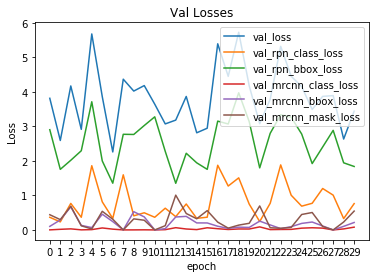

Train Loss 



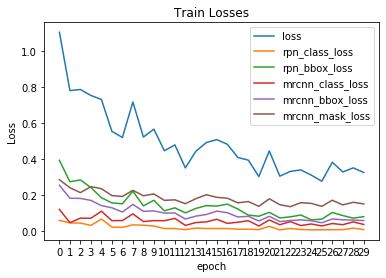

Fine tune all layers

Starting at epoch 0. LR=0.0001

Checkpoint Path: /home/harsh/Mask_RCNN/logs/shapes20190826T1047/mask_rcnn_shapes_{epoch:04d}.h5
Selecting layers to train
conv1                  (Conv2D)
bn_conv1               (BatchNorm)
res2a_branch2a         (Conv2D)
bn2a_branch2a          (BatchNorm)
res2a_branch2b         (Conv2D)
bn2a_branch2b          (BatchNorm)
res2a_branch2c         (Conv2D)
res2a_branch1          (Conv2D)
bn2a_branch2c          (BatchNorm)
bn2a_branch1           (BatchNorm)
res2b_branch2a         (Conv2D)
bn2b_branch2a          (BatchNorm)
res2b_branch2b         (Conv2D)
bn2b_branch2b          (BatchNorm)
res2b_branch2c         (Conv2D)
bn2b_branch2c          (BatchNorm)
res2c_branch2a         (Conv2D)
bn2c_branch2a          (BatchNorm)
res2c_branch2b         (Conv2D)
bn2c_branch2b          (BatchNorm)
res2c_branch2c         (Conv2D)
bn2c_branch2c          (BatchNorm)
res3a_branch2a         (Conv2D)
bn3a_branch2a          (BatchNorm)
res3a_branch2b      

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6

100/100 [==============================] - 139s 1s/step - loss: 0.7034 - rpn_class_loss: 0.0465 - rpn_bbox_loss: 0.2516 - mrcnn_class_loss: 0.0751 - mrcnn_bbox_loss: 0.1125 - mrcnn_mask_loss: 0.2176 - val_loss: 3.6748 - val_rpn_class_loss: 1.0071 - val_rpn_bbox_loss: 2.2573 - val_mrcnn_class_loss: 0.0789 - val_mrcnn_bbox_loss: 0.1941 - val_mrcnn_mask_loss: 0.1373
Epoch 2/30
100/100 [==============================] - 74s 735ms/step - loss: 0.3728 - rpn_class_loss: 0.0064 - rpn_bbox_loss: 0.1237 - mrcnn_class_loss: 0.0192 - mrcnn_bbox_loss: 0.0721 - mrcnn_mask_loss: 0.1514 - val_loss: 1.9707 - val_rpn_class_loss: 0.1724 - val_rpn_bbox_loss: 1.2658 - val_mrcnn_class_loss: 0.0464 - val_mrcnn_bbox_loss: 0.1396 - val_mrcnn_mask_loss: 0.3465
Epoch 3/30
 42/100 [===========>..................] - ETA: 40s - loss: 0.3462 - rpn_class_loss: 0.0031 - rpn_bbox_loss: 0.0774 - mrcnn_class_loss: 0.0328 - mrcnn_bbox_loss: 0.0808 - mrcnn_mask_loss: 0.1521

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 43/100 [===========>..................] - ETA: 40s - loss: 0.3408 - rpn_class_loss: 0.0030 - rpn_bbox_loss: 0.0759 - mrcnn_class_loss: 0.0321 - mrcnn_bbox_loss: 0.0793 - mrcnn_mask_loss: 0.1505

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 44/100 [============>.................] - ETA: 39s - loss: 0.3388 - rpn_class_loss: 0.0030 - rpn_bbox_loss: 0.0752 - mrcnn_class_loss: 0.0316 - mrcnn_bbox_loss: 0.0787 - mrcnn_mask_loss: 0.1504

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 46/100 [============>.................] - ETA: 38s - loss: 0.3351 - rpn_class_loss: 0.0028 - rpn_bbox_loss: 0.0736 - mrcnn_class_loss: 0.0313 - mrcnn_bbox_loss: 0.0773 - mrcnn_mask_loss: 0.1500

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 47/100 [=============>................] - ETA: 37s - loss: 0.3327 - rpn_class_loss: 0.0028 - rpn_bbox_loss: 0.0728 - mrcnn_class_loss: 0.0309 - mrcnn_bbox_loss: 0.0766 - mrcnn_mask_loss: 0.1496

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 48/100 [=============>................] - ETA: 36s - loss: 0.3295 - rpn_class_loss: 0.0027 - rpn_bbox_loss: 0.0719 - mrcnn_class_loss: 0.0307 - mrcnn_bbox_loss: 0.0756 - mrcnn_mask_loss: 0.1485

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 49/100 [=============>................] - ETA: 36s - loss: 0.3264 - rpn_class_loss: 0.0027 - rpn_bbox_loss: 0.0710 - mrcnn_class_loss: 0.0305 - mrcnn_bbox_loss: 0.0747 - mrcnn_mask_loss: 0.1474

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 53/100 [==============>...............] - ETA: 33s - loss: 0.3142 - rpn_class_loss: 0.0026 - rpn_bbox_loss: 0.0674 - mrcnn_class_loss: 0.0296 - mrcnn_bbox_loss: 0.0709 - mrcnn_mask_loss: 0.1437

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


100/100 [==============================] - 74s 739ms/step - loss: 0.3130 - rpn_class_loss: 0.0042 - rpn_bbox_loss: 0.0688 - mrcnn_class_loss: 0.0322 - mrcnn_bbox_loss: 0.0702 - mrcnn_mask_loss: 0.1375 - val_loss: 2.8290 - val_rpn_class_loss: 0.4277 - val_rpn_bbox_loss: 1.8548 - val_mrcnn_class_loss: 0.0474 - val_mrcnn_bbox_loss: 0.1326 - val_mrcnn_mask_loss: 0.3665
Epoch 4/30
100/100 [==============================] - 76s 758ms/step - loss: 0.3318 - rpn_class_loss: 0.0088 - rpn_bbox_loss: 0.0876 - mrcnn_class_loss: 0.0308 - mrcnn_bbox_loss: 0.0607 - mrcnn_mask_loss: 0.1439 - val_loss: 4.3868 - val_rpn_class_loss: 1.2357 - val_rpn_bbox_loss: 2.9186 - val_mrcnn_class_loss: 1.5824e-05 - val_mrcnn_bbox_loss: 0.1387 - val_mrcnn_mask_loss: 0.0938
Epoch 5/30
100/100 [==============================] - 73s 734ms/step - loss: 0.3427 - rpn_class_loss: 0.0068 - rpn_bbox_loss: 0.0658 - mrcnn_class_loss: 0.0501 - mrcnn_bbox_loss: 0.0649 - mrcnn_mask_loss: 0.1551 - val_loss: 4.9360 - val_rpn_class_lo

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 78/100 [======================>.......] - ETA: 16s - loss: 0.2916 - rpn_class_loss: 0.0066 - rpn_bbox_loss: 0.0679 - mrcnn_class_loss: 0.0233 - mrcnn_bbox_loss: 0.0547 - mrcnn_mask_loss: 0.1391

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 81/100 [=======================>......] - ETA: 13s - loss: 0.2898 - rpn_class_loss: 0.0064 - rpn_bbox_loss: 0.0677 - mrcnn_class_loss: 0.0230 - mrcnn_bbox_loss: 0.0544 - mrcnn_mask_loss: 0.1382

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 83/100 [=======================>......] - ETA: 12s - loss: 0.2872 - rpn_class_loss: 0.0063 - rpn_bbox_loss: 0.0670 - mrcnn_class_loss: 0.0229 - mrcnn_bbox_loss: 0.0539 - mrcnn_mask_loss: 0.1371

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 90/100 [==========================>...] - ETA: 7s - loss: 0.2813 - rpn_class_loss: 0.0061 - rpn_bbox_loss: 0.0656 - mrcnn_class_loss: 0.0222 - mrcnn_bbox_loss: 0.0532 - mrcnn_mask_loss: 0.1341

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 93/100 [==========================>...] - ETA: 5s - loss: 0.2807 - rpn_class_loss: 0.0060 - rpn_bbox_loss: 0.0657 - mrcnn_class_loss: 0.0220 - mrcnn_bbox_loss: 0.0534 - mrcnn_mask_loss: 0.1336

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 95/100 [===========================>..] - ETA: 3s - loss: 0.2795 - rpn_class_loss: 0.0059 - rpn_bbox_loss: 0.0653 - mrcnn_class_loss: 0.0217 - mrcnn_bbox_loss: 0.0531 - mrcnn_mask_loss: 0.1335

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


100/100 [==============================] - 76s 759ms/step - loss: 0.2761 - rpn_class_loss: 0.0057 - rpn_bbox_loss: 0.0642 - mrcnn_class_loss: 0.0213 - mrcnn_bbox_loss: 0.0527 - mrcnn_mask_loss: 0.1322 - val_loss: 2.3463 - val_rpn_class_loss: 0.3207 - val_rpn_bbox_loss: 1.5114 - val_mrcnn_class_loss: 0.0417 - val_mrcnn_bbox_loss: 0.1570 - val_mrcnn_mask_loss: 0.3155


/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


Epoch 8/30
100/100 [==============================] - 74s 736ms/step - loss: 0.3738 - rpn_class_loss: 0.0055 - rpn_bbox_loss: 0.0780 - mrcnn_class_loss: 0.0533 - mrcnn_bbox_loss: 0.0711 - mrcnn_mask_loss: 0.1659 - val_loss: 4.3204 - val_rpn_class_loss: 1.6526 - val_rpn_bbox_loss: 2.6678 - val_mrcnn_class_loss: 0.0000e+00 - val_mrcnn_bbox_loss: 0.0000e+00 - val_mrcnn_mask_loss: 0.0000e+00
Epoch 9/30
 10/100 [==>...........................] - ETA: 1:03 - loss: 0.2313 - rpn_class_loss: 0.0043 - rpn_bbox_loss: 0.0508 - mrcnn_class_loss: 0.0205 - mrcnn_bbox_loss: 0.0398 - mrcnn_mask_loss: 0.1159

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 14/100 [===>..........................] - ETA: 1:00 - loss: 0.2986 - rpn_class_loss: 0.0212 - rpn_bbox_loss: 0.0823 - mrcnn_class_loss: 0.0292 - mrcnn_bbox_loss: 0.0429 - mrcnn_mask_loss: 0.1230

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 15/100 [===>..........................] - ETA: 59s - loss: 0.2897 - rpn_class_loss: 0.0198 - rpn_bbox_loss: 0.0788 - mrcnn_class_loss: 0.0282 - mrcnn_bbox_loss: 0.0418 - mrcnn_mask_loss: 0.1211 

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 20/100 [=====>........................] - ETA: 56s - loss: 0.3133 - rpn_class_loss: 0.0260 - rpn_bbox_loss: 0.0903 - mrcnn_class_loss: 0.0334 - mrcnn_bbox_loss: 0.0424 - mrcnn_mask_loss: 0.1212

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 26/100 [======>.......................] - ETA: 52s - loss: 0.3508 - rpn_class_loss: 0.0330 - rpn_bbox_loss: 0.1091 - mrcnn_class_loss: 0.0376 - mrcnn_bbox_loss: 0.0449 - mrcnn_mask_loss: 0.1262

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 30/100 [========>.....................] - ETA: 49s - loss: 0.3323 - rpn_class_loss: 0.0290 - rpn_bbox_loss: 0.0999 - mrcnn_class_loss: 0.0358 - mrcnn_bbox_loss: 0.0436 - mrcnn_mask_loss: 0.1240

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 33/100 [========>.....................] - ETA: 47s - loss: 0.3479 - rpn_class_loss: 0.0281 - rpn_bbox_loss: 0.1066 - mrcnn_class_loss: 0.0378 - mrcnn_bbox_loss: 0.0460 - mrcnn_mask_loss: 0.1294

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 36/100 [=========>....................] - ETA: 45s - loss: 0.3542 - rpn_class_loss: 0.0268 - rpn_bbox_loss: 0.1103 - mrcnn_class_loss: 0.0383 - mrcnn_bbox_loss: 0.0468 - mrcnn_mask_loss: 0.1319

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


100/100 [==============================] - 75s 751ms/step - loss: 0.2916 - rpn_class_loss: 0.0131 - rpn_bbox_loss: 0.0782 - mrcnn_class_loss: 0.0264 - mrcnn_bbox_loss: 0.0432 - mrcnn_mask_loss: 0.1308 - val_loss: 3.0859 - val_rpn_class_loss: 0.4257 - val_rpn_bbox_loss: 2.6601 - val_mrcnn_class_loss: 0.0000e+00 - val_mrcnn_bbox_loss: 0.0000e+00 - val_mrcnn_mask_loss: 0.0000e+00
Epoch 10/30
100/100 [==============================] - 74s 742ms/step - loss: 0.3084 - rpn_class_loss: 0.0053 - rpn_bbox_loss: 0.0823 - mrcnn_class_loss: 0.0327 - mrcnn_bbox_loss: 0.0496 - mrcnn_mask_loss: 0.1386 - val_loss: 4.2069 - val_rpn_class_loss: 0.5473 - val_rpn_bbox_loss: 3.2146 - val_mrcnn_class_loss: 8.9080e-05 - val_mrcnn_bbox_loss: 0.2433 - val_mrcnn_mask_loss: 0.2017
Epoch 11/30
100/100 [==============================] - 75s 754ms/step - loss: 0.2319 - rpn_class_loss: 0.0032 - rpn_bbox_loss: 0.0481 - mrcnn_class_loss: 0.0237 - mrcnn_bbox_loss: 0.0394 - mrcnn_mask_loss: 0.1174 - val_loss: 3.3904 - va

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 21/100 [=====>........................] - ETA: 56s - loss: 0.1663 - rpn_class_loss: 6.6696e-04 - rpn_bbox_loss: 0.0262 - mrcnn_class_loss: 0.0143 - mrcnn_bbox_loss: 0.0323 - mrcnn_mask_loss: 0.0928

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 24/100 [======>.......................] - ETA: 54s - loss: 0.1783 - rpn_class_loss: 8.1986e-04 - rpn_bbox_loss: 0.0309 - mrcnn_class_loss: 0.0136 - mrcnn_bbox_loss: 0.0359 - mrcnn_mask_loss: 0.0971

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 28/100 [=======>......................] - ETA: 51s - loss: 0.1804 - rpn_class_loss: 9.0772e-04 - rpn_bbox_loss: 0.0326 - mrcnn_class_loss: 0.0124 - mrcnn_bbox_loss: 0.0362 - mrcnn_mask_loss: 0.0984

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 33/100 [========>.....................] - ETA: 47s - loss: 0.1885 - rpn_class_loss: 9.4729e-04 - rpn_bbox_loss: 0.0363 - mrcnn_class_loss: 0.0117 - mrcnn_bbox_loss: 0.0371 - mrcnn_mask_loss: 0.1024

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 34/100 [=========>....................] - ETA: 47s - loss: 0.1895 - rpn_class_loss: 0.0011 - rpn_bbox_loss: 0.0369 - mrcnn_class_loss: 0.0116 - mrcnn_bbox_loss: 0.0370 - mrcnn_mask_loss: 0.1029    

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 37/100 [==========>...................] - ETA: 45s - loss: 0.1906 - rpn_class_loss: 0.0011 - rpn_bbox_loss: 0.0386 - mrcnn_class_loss: 0.0116 - mrcnn_bbox_loss: 0.0365 - mrcnn_mask_loss: 0.1028

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 47/100 [=============>................] - ETA: 38s - loss: 0.2034 - rpn_class_loss: 0.0014 - rpn_bbox_loss: 0.0424 - mrcnn_class_loss: 0.0119 - mrcnn_bbox_loss: 0.0389 - mrcnn_mask_loss: 0.1087

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


100/100 [==============================] - 74s 745ms/step - loss: 0.2124 - rpn_class_loss: 0.0026 - rpn_bbox_loss: 0.0442 - mrcnn_class_loss: 0.0144 - mrcnn_bbox_loss: 0.0378 - mrcnn_mask_loss: 0.1134 - val_loss: 3.1242 - val_rpn_class_loss: 0.5461 - val_rpn_bbox_loss: 1.2904 - val_mrcnn_class_loss: 0.1307 - val_mrcnn_bbox_loss: 0.2995 - val_mrcnn_mask_loss: 0.8575
Epoch 14/30
 13/100 [==>...........................] - ETA: 1:01 - loss: 0.1401 - rpn_class_loss: 0.0021 - rpn_bbox_loss: 0.0221 - mrcnn_class_loss: 0.0113 - mrcnn_bbox_loss: 0.0182 - mrcnn_mask_loss: 0.0864

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 19/100 [====>.........................] - ETA: 57s - loss: 0.1378 - rpn_class_loss: 0.0022 - rpn_bbox_loss: 0.0224 - mrcnn_class_loss: 0.0111 - mrcnn_bbox_loss: 0.0177 - mrcnn_mask_loss: 0.0844

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 20/100 [=====>........................] - ETA: 56s - loss: 0.1361 - rpn_class_loss: 0.0021 - rpn_bbox_loss: 0.0224 - mrcnn_class_loss: 0.0109 - mrcnn_bbox_loss: 0.0174 - mrcnn_mask_loss: 0.0833

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 23/100 [=====>........................] - ETA: 54s - loss: 0.1529 - rpn_class_loss: 0.0022 - rpn_bbox_loss: 0.0265 - mrcnn_class_loss: 0.0117 - mrcnn_bbox_loss: 0.0211 - mrcnn_mask_loss: 0.0915

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 30/100 [========>.....................] - ETA: 49s - loss: 0.1603 - rpn_class_loss: 0.0021 - rpn_bbox_loss: 0.0274 - mrcnn_class_loss: 0.0126 - mrcnn_bbox_loss: 0.0220 - mrcnn_mask_loss: 0.0962

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 32/100 [========>.....................] - ETA: 48s - loss: 0.1633 - rpn_class_loss: 0.0021 - rpn_bbox_loss: 0.0275 - mrcnn_class_loss: 0.0135 - mrcnn_bbox_loss: 0.0223 - mrcnn_mask_loss: 0.0979

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 34/100 [=========>....................] - ETA: 46s - loss: 0.1645 - rpn_class_loss: 0.0020 - rpn_bbox_loss: 0.0275 - mrcnn_class_loss: 0.0139 - mrcnn_bbox_loss: 0.0225 - mrcnn_mask_loss: 0.0987

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 41/100 [===========>..................] - ETA: 41s - loss: 0.1846 - rpn_class_loss: 0.0021 - rpn_bbox_loss: 0.0383 - mrcnn_class_loss: 0.0158 - mrcnn_bbox_loss: 0.0249 - mrcnn_mask_loss: 0.1036

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


100/100 [==============================] - 75s 748ms/step - loss: 0.2274 - rpn_class_loss: 0.0024 - rpn_bbox_loss: 0.0463 - mrcnn_class_loss: 0.0229 - mrcnn_bbox_loss: 0.0341 - mrcnn_mask_loss: 0.1216 - val_loss: 3.8612 - val_rpn_class_loss: 1.1086 - val_rpn_bbox_loss: 2.3875 - val_mrcnn_class_loss: 0.0599 - val_mrcnn_bbox_loss: 0.1472 - val_mrcnn_mask_loss: 0.1580
Epoch 15/30
100/100 [==============================] - 74s 744ms/step - loss: 0.2346 - rpn_class_loss: 0.0046 - rpn_bbox_loss: 0.0444 - mrcnn_class_loss: 0.0280 - mrcnn_bbox_loss: 0.0346 - mrcnn_mask_loss: 0.1230 - val_loss: 2.2691 - val_rpn_class_loss: 0.3299 - val_rpn_bbox_loss: 1.8005 - val_mrcnn_class_loss: 0.0128 - val_mrcnn_bbox_loss: 0.0328 - val_mrcnn_mask_loss: 0.0931
Epoch 16/30
100/100 [==============================] - 73s 734ms/step - loss: 0.2627 - rpn_class_loss: 0.0026 - rpn_bbox_loss: 0.0532 - mrcnn_class_loss: 0.0303 - mrcnn_bbox_loss: 0.0481 - mrcnn_mask_loss: 0.1284 - val_loss: 3.1502 - val_rpn_class_loss

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


100/100 [==============================] - 75s 753ms/step - loss: 0.1965 - rpn_class_loss: 0.0037 - rpn_bbox_loss: 0.0338 - mrcnn_class_loss: 0.0188 - mrcnn_bbox_loss: 0.0274 - mrcnn_mask_loss: 0.1127 - val_loss: 3.1693 - val_rpn_class_loss: 0.8904 - val_rpn_bbox_loss: 1.9516 - val_mrcnn_class_loss: 0.0353 - val_mrcnn_bbox_loss: 0.0645 - val_mrcnn_mask_loss: 0.2276
Epoch 18/30
 12/100 [==>...........................] - ETA: 1:02 - loss: 0.1399 - rpn_class_loss: 9.4126e-04 - rpn_bbox_loss: 0.0202 - mrcnn_class_loss: 0.0117 - mrcnn_bbox_loss: 0.0192 - mrcnn_mask_loss: 0.0878

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 17/100 [====>.........................] - ETA: 58s - loss: 0.1400 - rpn_class_loss: 0.0010 - rpn_bbox_loss: 0.0229 - mrcnn_class_loss: 0.0116 - mrcnn_bbox_loss: 0.0190 - mrcnn_mask_loss: 0.0855    

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 18/100 [====>.........................] - ETA: 57s - loss: 0.1377 - rpn_class_loss: 9.8002e-04 - rpn_bbox_loss: 0.0221 - mrcnn_class_loss: 0.0113 - mrcnn_bbox_loss: 0.0184 - mrcnn_mask_loss: 0.0850

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 21/100 [=====>........................] - ETA: 55s - loss: 0.1471 - rpn_class_loss: 9.9081e-04 - rpn_bbox_loss: 0.0252 - mrcnn_class_loss: 0.0126 - mrcnn_bbox_loss: 0.0203 - mrcnn_mask_loss: 0.0880

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 23/100 [=====>........................] - ETA: 54s - loss: 0.1508 - rpn_class_loss: 9.4428e-04 - rpn_bbox_loss: 0.0252 - mrcnn_class_loss: 0.0134 - mrcnn_bbox_loss: 0.0216 - mrcnn_mask_loss: 0.0897

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 27/100 [=======>......................] - ETA: 51s - loss: 0.1494 - rpn_class_loss: 8.6483e-04 - rpn_bbox_loss: 0.0242 - mrcnn_class_loss: 0.0138 - mrcnn_bbox_loss: 0.0213 - mrcnn_mask_loss: 0.0893

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 32/100 [========>.....................] - ETA: 48s - loss: 0.1433 - rpn_class_loss: 7.7266e-04 - rpn_bbox_loss: 0.0231 - mrcnn_class_loss: 0.0131 - mrcnn_bbox_loss: 0.0205 - mrcnn_mask_loss: 0.0858

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


100/100 [==============================] - 74s 740ms/step - loss: 0.2277 - rpn_class_loss: 0.0031 - rpn_bbox_loss: 0.0463 - mrcnn_class_loss: 0.0295 - mrcnn_bbox_loss: 0.0341 - mrcnn_mask_loss: 0.1147 - val_loss: 3.5309 - val_rpn_class_loss: 0.8431 - val_rpn_bbox_loss: 2.5057 - val_mrcnn_class_loss: 0.0332 - val_mrcnn_bbox_loss: 0.0639 - val_mrcnn_mask_loss: 0.0850
Epoch 19/30
 82/100 [=======================>......] - ETA: 12s - loss: 0.2403 - rpn_class_loss: 0.0026 - rpn_bbox_loss: 0.0431 - mrcnn_class_loss: 0.0243 - mrcnn_bbox_loss: 0.0444 - mrcnn_mask_loss: 0.1258

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 96/100 [===========================>..] - ETA: 2s - loss: 0.2313 - rpn_class_loss: 0.0027 - rpn_bbox_loss: 0.0414 - mrcnn_class_loss: 0.0226 - mrcnn_bbox_loss: 0.0420 - mrcnn_mask_loss: 0.1226

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 99/100 [============================>.] - ETA: 0s - loss: 0.2283 - rpn_class_loss: 0.0027 - rpn_bbox_loss: 0.0406 - mrcnn_class_loss: 0.0222 - mrcnn_bbox_loss: 0.0412 - mrcnn_mask_loss: 0.1216

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


100/100 [==============================] - 75s 746ms/step - loss: 0.2270 - rpn_class_loss: 0.0027 - rpn_bbox_loss: 0.0402 - mrcnn_class_loss: 0.0220 - mrcnn_bbox_loss: 0.0409 - mrcnn_mask_loss: 0.1212 - val_loss: 4.0774 - val_rpn_class_loss: 0.8957 - val_rpn_bbox_loss: 2.9061 - val_mrcnn_class_loss: 0.0512 - val_mrcnn_bbox_loss: 0.1072 - val_mrcnn_mask_loss: 0.1171
Epoch 20/30
  2/100 [..............................] - ETA: 1:10 - loss: 0.1378 - rpn_class_loss: 0.0059 - rpn_bbox_loss: 0.0125 - mrcnn_class_loss: 0.0111 - mrcnn_bbox_loss: 0.0153 - mrcnn_mask_loss: 0.0930

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


  5/100 [>.............................] - ETA: 1:06 - loss: 0.1574 - rpn_class_loss: 0.0035 - rpn_bbox_loss: 0.0184 - mrcnn_class_loss: 0.0160 - mrcnn_bbox_loss: 0.0225 - mrcnn_mask_loss: 0.0970

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


  8/100 [=>............................] - ETA: 1:04 - loss: 0.1390 - rpn_class_loss: 0.0037 - rpn_bbox_loss: 0.0152 - mrcnn_class_loss: 0.0118 - mrcnn_bbox_loss: 0.0184 - mrcnn_mask_loss: 0.0899

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 11/100 [==>...........................] - ETA: 1:03 - loss: 0.1327 - rpn_class_loss: 0.0033 - rpn_bbox_loss: 0.0162 - mrcnn_class_loss: 0.0100 - mrcnn_bbox_loss: 0.0169 - mrcnn_mask_loss: 0.0863

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 17/100 [====>.........................] - ETA: 1:00 - loss: 0.1438 - rpn_class_loss: 0.0028 - rpn_bbox_loss: 0.0198 - mrcnn_class_loss: 0.0133 - mrcnn_bbox_loss: 0.0196 - mrcnn_mask_loss: 0.0883

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


100/100 [==============================] - 75s 751ms/step - loss: 0.1764 - rpn_class_loss: 0.0017 - rpn_bbox_loss: 0.0302 - mrcnn_class_loss: 0.0184 - mrcnn_bbox_loss: 0.0285 - mrcnn_mask_loss: 0.0976 - val_loss: 3.8653 - val_rpn_class_loss: 0.4451 - val_rpn_bbox_loss: 3.0917 - val_mrcnn_class_loss: 0.0274 - val_mrcnn_bbox_loss: 0.0779 - val_mrcnn_mask_loss: 0.2231
Epoch 21/30
100/100 [==============================] - 74s 743ms/step - loss: 0.2447 - rpn_class_loss: 0.0051 - rpn_bbox_loss: 0.0485 - mrcnn_class_loss: 0.0311 - mrcnn_bbox_loss: 0.0388 - mrcnn_mask_loss: 0.1213 - val_loss: 2.9479 - val_rpn_class_loss: 0.3279 - val_rpn_bbox_loss: 1.6662 - val_mrcnn_class_loss: 0.0730 - val_mrcnn_bbox_loss: 0.1997 - val_mrcnn_mask_loss: 0.6810
Epoch 22/30
 93/100 [==========================>...] - ETA: 5s - loss: 0.1949 - rpn_class_loss: 0.0016 - rpn_bbox_loss: 0.0311 - mrcnn_class_loss: 0.0233 - mrcnn_bbox_loss: 0.0284 - mrcnn_mask_loss: 0.1104

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


100/100 [==============================] - 74s 743ms/step - loss: 0.2013 - rpn_class_loss: 0.0016 - rpn_bbox_loss: 0.0328 - mrcnn_class_loss: 0.0245 - mrcnn_bbox_loss: 0.0294 - mrcnn_mask_loss: 0.1129 - val_loss: 3.5502 - val_rpn_class_loss: 1.0016 - val_rpn_bbox_loss: 2.5486 - val_mrcnn_class_loss: 0.0000e+00 - val_mrcnn_bbox_loss: 0.0000e+00 - val_mrcnn_mask_loss: 0.0000e+00
Epoch 23/30
  5/100 [>.............................] - ETA: 1:06 - loss: 0.1320 - rpn_class_loss: 9.2065e-04 - rpn_bbox_loss: 0.0198 - mrcnn_class_loss: 0.0089 - mrcnn_bbox_loss: 0.0161 - mrcnn_mask_loss: 0.0863

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 10/100 [==>...........................] - ETA: 1:03 - loss: 0.1444 - rpn_class_loss: 8.4679e-04 - rpn_bbox_loss: 0.0223 - mrcnn_class_loss: 0.0112 - mrcnn_bbox_loss: 0.0198 - mrcnn_mask_loss: 0.0903

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 14/100 [===>..........................] - ETA: 1:01 - loss: 0.1734 - rpn_class_loss: 0.0012 - rpn_bbox_loss: 0.0280 - mrcnn_class_loss: 0.0212 - mrcnn_bbox_loss: 0.0244 - mrcnn_mask_loss: 0.0986  

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 19/100 [====>.........................] - ETA: 57s - loss: 0.1949 - rpn_class_loss: 0.0012 - rpn_bbox_loss: 0.0353 - mrcnn_class_loss: 0.0258 - mrcnn_bbox_loss: 0.0282 - mrcnn_mask_loss: 0.1044

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 23/100 [=====>........................] - ETA: 54s - loss: 0.2312 - rpn_class_loss: 0.0015 - rpn_bbox_loss: 0.0420 - mrcnn_class_loss: 0.0382 - mrcnn_bbox_loss: 0.0334 - mrcnn_mask_loss: 0.1161

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 24/100 [======>.......................] - ETA: 54s - loss: 0.2309 - rpn_class_loss: 0.0015 - rpn_bbox_loss: 0.0416 - mrcnn_class_loss: 0.0381 - mrcnn_bbox_loss: 0.0340 - mrcnn_mask_loss: 0.1158

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 29/100 [=======>......................] - ETA: 50s - loss: 0.2743 - rpn_class_loss: 0.0018 - rpn_bbox_loss: 0.0504 - mrcnn_class_loss: 0.0517 - mrcnn_bbox_loss: 0.0408 - mrcnn_mask_loss: 0.1297

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


100/100 [==============================] - 74s 737ms/step - loss: 0.1966 - rpn_class_loss: 0.0031 - rpn_bbox_loss: 0.0331 - mrcnn_class_loss: 0.0285 - mrcnn_bbox_loss: 0.0288 - mrcnn_mask_loss: 0.1032 - val_loss: 4.6712 - val_rpn_class_loss: 1.7545 - val_rpn_bbox_loss: 2.7913 - val_mrcnn_class_loss: 0.0301 - val_mrcnn_bbox_loss: 0.0412 - val_mrcnn_mask_loss: 0.0541
Epoch 24/30
100/100 [==============================] - 75s 746ms/step - loss: 0.2006 - rpn_class_loss: 0.0026 - rpn_bbox_loss: 0.0364 - mrcnn_class_loss: 0.0175 - mrcnn_bbox_loss: 0.0314 - mrcnn_mask_loss: 0.1127 - val_loss: 4.0233 - val_rpn_class_loss: 0.8983 - val_rpn_bbox_loss: 2.8946 - val_mrcnn_class_loss: 0.0462 - val_mrcnn_bbox_loss: 0.0976 - val_mrcnn_mask_loss: 0.0865
Epoch 25/30
100/100 [==============================] - 73s 734ms/step - loss: 0.2032 - rpn_class_loss: 0.0018 - rpn_bbox_loss: 0.0284 - mrcnn_class_loss: 0.0254 - mrcnn_bbox_loss: 0.0289 - mrcnn_mask_loss: 0.1188 - val_loss: 3.9349 - val_rpn_class_loss

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 24/100 [======>.......................] - ETA: 56s - loss: 0.1534 - rpn_class_loss: 0.0014 - rpn_bbox_loss: 0.0213 - mrcnn_class_loss: 0.0146 - mrcnn_bbox_loss: 0.0187 - mrcnn_mask_loss: 0.0975

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 31/100 [========>.....................] - ETA: 51s - loss: 0.1458 - rpn_class_loss: 0.0012 - rpn_bbox_loss: 0.0193 - mrcnn_class_loss: 0.0138 - mrcnn_bbox_loss: 0.0172 - mrcnn_mask_loss: 0.0943

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 34/100 [=========>....................] - ETA: 49s - loss: 0.1433 - rpn_class_loss: 0.0011 - rpn_bbox_loss: 0.0189 - mrcnn_class_loss: 0.0132 - mrcnn_bbox_loss: 0.0169 - mrcnn_mask_loss: 0.0932

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 40/100 [===========>..................] - ETA: 44s - loss: 0.1446 - rpn_class_loss: 0.0011 - rpn_bbox_loss: 0.0190 - mrcnn_class_loss: 0.0128 - mrcnn_bbox_loss: 0.0176 - mrcnn_mask_loss: 0.0941

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 43/100 [===========>..................] - ETA: 42s - loss: 0.1456 - rpn_class_loss: 0.0011 - rpn_bbox_loss: 0.0187 - mrcnn_class_loss: 0.0137 - mrcnn_bbox_loss: 0.0176 - mrcnn_mask_loss: 0.0945

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 49/100 [=============>................] - ETA: 37s - loss: 0.1465 - rpn_class_loss: 0.0011 - rpn_bbox_loss: 0.0192 - mrcnn_class_loss: 0.0130 - mrcnn_bbox_loss: 0.0182 - mrcnn_mask_loss: 0.0950

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 52/100 [==============>...............] - ETA: 35s - loss: 0.1512 - rpn_class_loss: 0.0011 - rpn_bbox_loss: 0.0194 - mrcnn_class_loss: 0.0143 - mrcnn_bbox_loss: 0.0191 - mrcnn_mask_loss: 0.0973

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


100/100 [==============================] - 75s 751ms/step - loss: 0.1621 - rpn_class_loss: 0.0015 - rpn_bbox_loss: 0.0255 - mrcnn_class_loss: 0.0153 - mrcnn_bbox_loss: 0.0219 - mrcnn_mask_loss: 0.0979 - val_loss: 3.3635 - val_rpn_class_loss: 0.5280 - val_rpn_bbox_loss: 1.9080 - val_mrcnn_class_loss: 0.0844 - val_mrcnn_bbox_loss: 0.2377 - val_mrcnn_mask_loss: 0.6053
Epoch 27/30
 18/100 [====>.........................] - ETA: 57s - loss: 0.2692 - rpn_class_loss: 0.0029 - rpn_bbox_loss: 0.0435 - mrcnn_class_loss: 0.0492 - mrcnn_bbox_loss: 0.0330 - mrcnn_mask_loss: 0.1406

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 33/100 [========>.....................] - ETA: 47s - loss: 0.2646 - rpn_class_loss: 0.0026 - rpn_bbox_loss: 0.0466 - mrcnn_class_loss: 0.0449 - mrcnn_bbox_loss: 0.0319 - mrcnn_mask_loss: 0.1385

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 45/100 [============>.................] - ETA: 39s - loss: 0.2359 - rpn_class_loss: 0.0023 - rpn_bbox_loss: 0.0422 - mrcnn_class_loss: 0.0355 - mrcnn_bbox_loss: 0.0283 - mrcnn_mask_loss: 0.1276

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 48/100 [=============>................] - ETA: 36s - loss: 0.2319 - rpn_class_loss: 0.0022 - rpn_bbox_loss: 0.0408 - mrcnn_class_loss: 0.0344 - mrcnn_bbox_loss: 0.0279 - mrcnn_mask_loss: 0.1266

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 52/100 [==============>...............] - ETA: 34s - loss: 0.2314 - rpn_class_loss: 0.0022 - rpn_bbox_loss: 0.0417 - mrcnn_class_loss: 0.0335 - mrcnn_bbox_loss: 0.0279 - mrcnn_mask_loss: 0.1261

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 55/100 [===============>..............] - ETA: 31s - loss: 0.2256 - rpn_class_loss: 0.0021 - rpn_bbox_loss: 0.0402 - mrcnn_class_loss: 0.0319 - mrcnn_bbox_loss: 0.0272 - mrcnn_mask_loss: 0.1243

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 59/100 [================>.............] - ETA: 29s - loss: 0.2246 - rpn_class_loss: 0.0020 - rpn_bbox_loss: 0.0397 - mrcnn_class_loss: 0.0313 - mrcnn_bbox_loss: 0.0272 - mrcnn_mask_loss: 0.1244

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


 62/100 [=================>............] - ETA: 27s - loss: 0.2239 - rpn_class_loss: 0.0020 - rpn_bbox_loss: 0.0392 - mrcnn_class_loss: 0.0311 - mrcnn_bbox_loss: 0.0269 - mrcnn_mask_loss: 0.1247

/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 669057 bytes but only got 65171. Skipping tag 34675
  " Skipping tag %s" % (size, len(data), tag)
/home/harsh/anaconda3/envs/maskrcnntensorflowgpu/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:605: UserWarning: Metadata Warning, tag 34377 had too many entries: 24, expected 1
  % (tag, len(values))


100/100 [==============================] - 74s 741ms/step - loss: 0.1974 - rpn_class_loss: 0.0019 - rpn_bbox_loss: 0.0325 - mrcnn_class_loss: 0.0252 - mrcnn_bbox_loss: 0.0239 - mrcnn_mask_loss: 0.1139 - val_loss: 4.1220 - val_rpn_class_loss: 1.3481 - val_rpn_bbox_loss: 2.4704 - val_mrcnn_class_loss: 0.0571 - val_mrcnn_bbox_loss: 0.1127 - val_mrcnn_mask_loss: 0.1337
Epoch 28/30
100/100 [==============================] - 74s 743ms/step - loss: 0.1854 - rpn_class_loss: 0.0024 - rpn_bbox_loss: 0.0296 - mrcnn_class_loss: 0.0210 - mrcnn_bbox_loss: 0.0269 - mrcnn_mask_loss: 0.1055 - val_loss: 3.4488 - val_rpn_class_loss: 0.9378 - val_rpn_bbox_loss: 2.1061 - val_mrcnn_class_loss: 0.0149 - val_mrcnn_bbox_loss: 0.1432 - val_mrcnn_mask_loss: 0.2467
Epoch 29/30
100/100 [==============================] - 74s 745ms/step - loss: 0.1845 - rpn_class_loss: 0.0035 - rpn_bbox_loss: 0.0305 - mrcnn_class_loss: 0.0246 - mrcnn_bbox_loss: 0.0224 - mrcnn_mask_loss: 0.1035 - val_loss: 3.2283 - val_rpn_class_loss

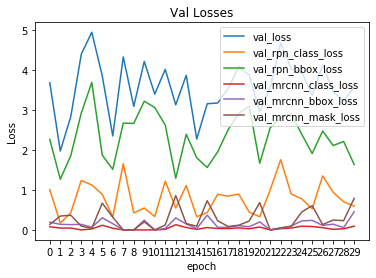

Train Loss 



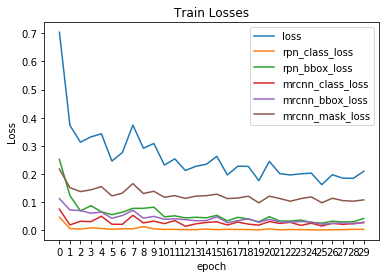

In [16]:
        
model.train(dataset_train, dataset_val, 
            learning_rate=config.LEARNING_RATE, 
            epochs=30, 
            layers='heads', augmentation= seq)


print("Fine tune Resnet stage 4 and up")
model.train(dataset_train, dataset_val,
            learning_rate=config.LEARNING_RATE,
            epochs=30,
            layers='4+',
            augmentation=seq)



print("Fine tune all layers")
model.train(dataset_train, dataset_val,
            learning_rate=config.LEARNING_RATE / 10,
            epochs=30,
            layers='all',
            augmentation=seq)


## Evaluation

### 1